# Configuration

## Packages to import

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

from insight import *

import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import csv
from datetime import datetime
import re
from tqdm import tqdm
import multiprocessing as mp
from collections import OrderedDict
import time
import pandas as pd

['LICENSE', 'stage_2.ipynb', 'LoughranMcDonald_MasterDictionary_2018.csv', 'stage_2.py', 'requirements.txt', 'sec-scrapper.py', '__pycache__', 'README.md', 'Load_MasterDictionary.py', 'Filing metrics.py']
/home/alex/Desktop/Insight project/sec-scrapper
 ...Loading Master Dictionary 85000
Master Dictionary loaded from file: 
  LoughranMcDonald_MasterDictionary_2018.csv
  86,486 words loaded in master_dictionary.



## Settings dictionary

In [2]:
_s = {
    'path_stage_1_data': '/home/alex/Desktop/filtered_text_data/nd_data/',
    'path_stock_database': '/home/alex/Desktop/Insight project/Database/Ticker_stock_price.csv',
    'path_stock_indexes': '/home/alex/Desktop/Insight project/Database/Indexes/',
    'path_cik_ticker_lookup': '/home/alex/Desktop/Insight project/Database/cik_ticker.csv',
    'path_master_dictionary': '/home/alex/Desktop/Insight project/Database/LoughranMcDonald_MasterDictionary_2018.csv',
    'path_dump_crsp': '/home/alex/Desktop/Insight project/Database/dump_crsp_2001_2005.txt',
    'metrics': ['diff_jaccard', 'diff_cosine_tf', 'diff_cosine_tf_idf', 'diff_minEdit', 'diff_simple', 'sing_LoughranMcDonald'],
    'differentiation_mode': 'intersection',
    'time_range': [(2010, 1), (2012, 4)],
    'bin_count': 5,
    'report_type': ['10-K', '10-Q'],
    'sections_to_parse_10k': [],
    'sections_to_parse_10q': [],
    'type_daily_price': 'closing'
}

In [3]:
_s['pf_init_value'] = 1000000
_s['epsilon'] = 0.0001  # Rounding error
# Calculated settings
_s['list_qtr'] = qtrs.create_qtr_list(_s['time_range'])

if _s['bin_count'] == 5:
    _s['bin_labels'] = ['Q'+str(n) for n in range(1, _s['bin_count']+1)]
elif _s['bin_count'] == 10:
    _s['bin_labels'] = ['D'+str(n) for n in range(1, _s['bin_count']+1)]
else:
    raise ValueError('[ERROR] This type of bin has not been implemented yet.')

# Reports considered to calculate the differences
if _s['differentiation_mode'] == 'intersection':
    _s['lag'] = 1
    _s['sections_to_parse_10k'] = ['1a', '3', '7', '7a', '9a']
    _s['sections_to_parse_10q'] = ['_i_2', '_i_3', '_i_4', 'ii_1', 'ii_1a']
elif _s['differentiation_mode'] == 'yearly':
    _s['lag'] = 4
    _s['sections_to_parse_10k'] = []
    _s['sections_to_parse_10q'] = []

_s['intersection_table'] = {
        '10-K': ['1a', '3', '7', '7a', '9a'],
        '10-Q': ['ii_1a', 'ii_1', '_i_2', '_i_3', '_i_4']
}  # Exhibits are not taken into account
_s['straight_table'] = {
    '10-K': ['1', '1a', '1b', '2', '3', '4', '5', '6', '7', '7a', '8', '9', '9a', '9b', '10', '11', '12', '13', '14', '15'],
    '10-Q': ['_i_1', '_i_2', '_i_3', '_i_4', 'ii_1', 'ii_1a', 'ii_2', 'ii_3', 'ii_4', 'ii_5', 'ii_6']
}

In [4]:
# Transfer s to a read only dict
read_only_dict = pre_processing.ReadOnlyDict()
for key in _s:  # Brute force copy
    read_only_dict[key] = _s[key]
s = read_only_dict  # Copy back
s.set_read_state(read_only=True)  # Set as read only

# Load external tables

## Extract the list of CIK for which we have complete data

The main problem in our case is that we have 3 different database to play with:
1. The SEC provides information based on the CIK of the entity
2. Given that the CIK is used by no one else, we use a lookup table to transform that into tickers. But we do not have all the correspondances, so the list of useful CIK is shrunk.
3. Finally, we only have stock prices for so many tickers. So that shrinks the CIK list even further.

We end up with a reduced list of CIK that we can play with.

### Find all the unique CIK from the SEC filings

In [5]:
cik_path = pre_processing.load_cik_path(s)

[INFO] Loaded 306,198 10-X
[INFO] Shrunk to 276,841 ['10-K', '10-Q']


 34%|███▍      | 94696/276841 [00:00<00:00, 946954.13it/s]

[INFO] Found 14,549 unique CIK in master index


100%|██████████| 276841/276841 [00:00<00:00, 990817.87it/s]

[INFO] cik_path contains data on 14,549 CIK numbers


### Get the largest {CIK: ticker} possible given our lookup table

In [6]:
lookup = pre_processing.load_lookup(s)
print("[INFO] Loaded {:,} CIK/Tickers correspondances.".format(len(lookup)))

[INFO] Loaded 13,738 CIK/Tickers correspondances.


In [7]:
cik_path, lookup = pre_processing.intersection_sec_lookup(cik_path, lookup)
print("[INFO] Intersected SEC & lookup.")
print("cik_path: {:,} CIK | lookup: {:,} CIK"
      .format(len(cik_path), len(lookup)))

[INFO] Intersected SEC & lookup.
cik_path: 8,207 CIK | lookup: 8,207 CIK


### Load stock data and drop all CIKs for which we don't have data

In [8]:
# Load all stock prices
stock_data = pre_processing.load_stock_data(s)

100%|██████████| 30563446/30563446 [01:21<00:00, 375854.38it/s]


In [9]:
lookup, stock_data = pre_processing.intersection_lookup_stock(lookup, stock_data)
print("[INFO] Intersected lookup & stock data.")
print("lookup: {:,} tickers | stock_data: {:,} tickers"
      .format(len(lookup.values()), len(stock_data)))

4668
[INFO] Intersected lookup & stock data.
lookup: 4,791 tickers | stock_data: 4,668 tickers


### Load stock indexes - will serve as benchmark later on

In [10]:
index_data = pre_processing.load_index_data(s)
print("[INFO] Loaded the following index data:", list(index_data.keys()))

[INFO] Loaded the following index data: ['IXIC', 'SPX', 'DJI', 'RUT']


## Back propagate these intersection all the way to cik_path

Technically, we have just done it for lookup. So we only need to re-run an intersection for lookup and sec.

In [11]:
cik_path, lookup = pre_processing.intersection_sec_lookup(cik_path, lookup)
print("[INFO] Intersected SEC & lookup.")
print("cik_path: {:,} CIK | lookup: {:,} CIK"
      .format(len(cik_path), len(lookup)))

[INFO] Intersected SEC & lookup.
cik_path: 4,791 CIK | lookup: 4,791 CIK


## Sanity check

At this point, cik_path and lookup should have the same number of keys as the CIK is unique in the path database.

However, multiple CIK can redirect to the same ticker if the company changed its ticker over time. That should be a very limited amount of cases though.

In [12]:
assert cik_path.keys() == lookup.keys()
assert len(set(lookup.values())) == len(set(stock_data.keys()))

At that point, we have a {CIK: ticker} for which the stock is known, which will enable comparison and all down the road.

## Review all CIKs: make sure there is only one submission per quarter

In this section, the goal is to build a list of CIK that will successfully be parsed for the time_range considered.
It should be trivial for a vast majority of the CIK, but ideally there should be only one document per quarter for each CIK from the moment they are listed to the moment they are delisted.

In [13]:
# Create the list of quarters to consider
cik_path = pre_processing.review_cik_publications(cik_path, s)
print("[INFO] Removed all the CIK that did not have one report per quarter.")
print("cik_dict: {:,} CIK".format(len(cik_path)))

100%|██████████| 4791/4791 [00:00<00:00, 8229.14it/s]



[INFO] 607 CIKs caused trouble
[INFO] Removed all the CIK that did not have one report per quarter.
cik_dict: 4,184 CIK


In [14]:
print("[INFO] We are left with {:,} CIKs that meet our requirements:".format(len(cik_path)))
print("- The ticker can be looked up in the CIK/ticker tabke")
print("- The stock data is available for that ticker")
print("- There is one and only one report per quarter")

[INFO] We are left with 4,184 CIKs that meet our requirements:
- The ticker can be looked up in the CIK/ticker tabke
- The stock data is available for that ticker
- There is one and only one report per quarter


In [15]:
"""
# [USER SETTINGS]
example = 'apple'  # Debug
# Examples of companies
example_companies = {
    'apple': ['AAPL', 320193],
    'baxter': ['BAX', 10456],
    'facebook': ['FB', 1326801],
    'google': ['GOOGL', 1652044],
    'microsoft': ['MSFT', 789019],
    'amazon': ['AMZN', 1018724],
    'johnson': ['JNJ', 200406],
    'jpmorgan': ['JPM', 19617]
}

# [DEBUG]: isolate a subset of companies
company = 'apple'
cik_path = {
    example_companies['apple'][1]: cik_path[example_companies['apple'][1]],
    example_companies['microsoft'][1]: cik_path[example_companies['microsoft'][1]],
    example_companies['jpmorgan'][1]: cik_path[example_companies['jpmorgan'][1]],
    example_companies['amazon'][1]: cik_path[example_companies['amazon'][1]],
    example_companies['johnson'][1]: cik_path[example_companies['johnson'][1]],
    
}
cik_path.keys()
"""

"\n# [USER SETTINGS]\nexample = 'apple'  # Debug\n# Examples of companies\nexample_companies = {\n    'apple': ['AAPL', 320193],\n    'baxter': ['BAX', 10456],\n    'facebook': ['FB', 1326801],\n    'google': ['GOOGL', 1652044],\n    'microsoft': ['MSFT', 789019],\n    'amazon': ['AMZN', 1018724],\n    'johnson': ['JNJ', 200406],\n    'jpmorgan': ['JPM', 19617]\n}\n\n# [DEBUG]: isolate a subset of companies\ncompany = 'apple'\ncik_path = {\n    example_companies['apple'][1]: cik_path[example_companies['apple'][1]],\n    example_companies['microsoft'][1]: cik_path[example_companies['microsoft'][1]],\n    example_companies['jpmorgan'][1]: cik_path[example_companies['jpmorgan'][1]],\n    example_companies['amazon'][1]: cik_path[example_companies['amazon'][1]],\n    example_companies['johnson'][1]: cik_path[example_companies['johnson'][1]],\n    \n}\ncik_path.keys()\n"

# Parse files

Now we have a list of CIK that should make it until the end. It is time to open the relevant reports and start parsing. This step takes a lot of time and can get arbitrarily long as the metrics get fancier.

You do not want to keep in RAM all the parsed data. However, there are only ~100 quarters for which we have data and the stage 2 files are no more than 1 Mb in size (Apple seems to top out at ~ 325 kb). So 100 Mb per core + others, that's definitely doable. More cores will use more RAM, but the usage remains reasonable.

We use multiprocessing to go through N CIK at once but a single core is dedicated to going through a given CIK for the specified time_range. Such a core can be running for a while if the company has been in business for the whole time_range and publish a lot of text data in its 10-K.

In [18]:
# Processing the reports will be done in parrallel in a random order
cik_scores = {k: 0 for k in cik_path.keys()}  # Organized by ticker
#debug = [[k, v, {**s}] for k, v in cik_path.items() if k==98338]  # settings are cast to dict for pickling
debug = [[k, v, {**s}] for k, v in cik_path.items()]  # settings are cast to dict for pickling

data_to_process = debug[:1000]  # Debug
#print(data_to_process)
#result = process_cik(data_to_process[0])
#cik_perf[result[0]] = result[1]
#print(cik_perf)
#assert 0
processing_stats = [0, 0, 0, 0, 0, 0]
#qtr_metric_result = {key: [] for key in s['list_qtr']}
with mp.Pool(processes=min(mp.cpu_count(), len(data_to_process))) as p:
#with mp.Pool(processes=min(mp.cpu_count(), 1)) as p:
    print("[INFO] Starting a pool of {} workers".format(min(mp.cpu_count(), len(data_to_process))))

    with tqdm(total=len(data_to_process)) as pbar:
        for i, value in tqdm(enumerate(p.imap_unordered(processing.process_cik, data_to_process))):
            pbar.update()
            #qtr = list_qtr[i]
            # Each quarter gets a few metrics
            if value[1] == {}:
                # The parsing failed
                del cik_scores[value[0]]
            else:
                cik_scores[value[0]] = value[1]
            processing_stats[value[2]] += 1
           
        #qtr_metric_result[value['0']['qtr']] = value
print("[INFO] {} CIK failed to be processed.".format(sum(processing_stats[1:])))
print("Detailed stats:", processing_stats)



  0%|          | 0/1000 [00:00<?, ?it/s]


0it [00:00, ?it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Starting a pool of 8 workers
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be em



  0%|          | 1/1000 [00:01<20:45,  1.25s/it]

[INFO] No ToC found
[INFO] Found a ToC!





1it [00:01,  1.22s/it]

[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section i

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0037501660904442876, 'diff_cosine_tf': 0.036089301135573765, 'diff_cosine_tf_idf': 0.020336568572035623, 'diff_minEdit': 0.7579778619546479, 'diff_simple': 0.20396206143086512, 'sing_LoughranMcDonald': -0.0033525804203594967, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.008618396360013247, 'diff_cosine_tf': 0.09053971303034211, 'diff_cosine_tf_idf': 0.057106271181130853, 'diff_minEdit': 0.7691361010856488, 'diff_simple': 0.19551305563586616, 'sing_LoughranMcDonald': -0.00026821466384349495, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 8), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7926596952954889, 'diff_cosine



  0%|          | 2/1000 [00:03<27:11,  1.63s/it]


2it [00:03,  1.62s/it]

{'diff_jaccard': 0.8175076140925489, 'diff_cosine_tf': 0.9710138204044313, 'diff_cosine_tf_idf': 0.9598991193138794, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002690574382308163, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
{'diff_jaccard': 0.849773016926045, 'diff_cosine_tf': 0.991424873394707, 'diff_cosine_tf_idf': 0.9897739952229097, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001411784041286702, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.880659434633624, 'diff_cosine_tf': 0.9900619367821617, 'diff_cosine_tf_idf': 0.9888628606097636, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0011404468469448676, '0': {'type': '10-Q',



  0%|          | 3/1000 [00:04<20:04,  1.21s/it]


3it [00:03,  1.19s/it]

{'diff_jaccard': 0.007165995826697846, 'diff_cosine_tf': 0.08985677146175894, 'diff_cosine_tf_idf': 0.05634398386998748, 'diff_minEdit': 0.19606957307431666, 'diff_simple': 0.21420947447740013, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 12, 19), 'qtr': (2012, 4)}}
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.8165114586808954, 'diff_cosine_tf': 0.9931562811226052, 'diff_cosine_tf_idf': 0.9899288855527351, 'diff_minEdit': 0.9001069249209981, 'diff_simple': 0.9384658657513348, 'sing_LoughranMcDonald': -0.0014076586028811098, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0021168628982670542, 'diff_cosine_tf': 0.04310492400177771, 'diff_cosine_tf_idf': 0.025598305619127373, 'diff_minEdit'



  0%|          | 5/1000 [00:04<16:12,  1.02it/s]


5it [00:04,  1.03it/s]

[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.8134297667949074, 'diff_cosine_tf': 0.9938677316429787, 'diff_cosine_tf_idf': 0.9935633610452812, 'diff_minEdit': 0.9392802556620814, 'diff_simple': 0.9908920383493123, 'sing_LoughranMcDonald': -0.0004679442549336972, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}




  1%|          | 6/1000 [00:04<11:54,  1.39it/s]


6it [00:04,  1.40it/s]

[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Compa

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.0012296749612080045, 'diff_cosine_tf': 0.07727707723631685, 'diff_cosine_tf_idf': 0.046882323532196304, 'diff_minEdit': 0.19890938834863214, 'diff_simple': 0.21289127947756098, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.0037074909276232065, 'diff_cosine_tf': 0.06851223303867163, 'diff_cosine_tf_idf': 0.04119926166012083, 'diff_minEdit': 0.7591793356595987, 'diff_simple': 0.1883049898317074, 'sing_LoughranMcDonald': -0.00039823167846782525, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 28), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.




  1%|          | 7/1000 [00:06<18:03,  1.09s/it]


7it [00:06,  1.09s/it]

{'diff_jaccard': 0.7619917162991239, 'diff_cosine_tf': 0.9571730269254265, 'diff_cosine_tf_idf': 0.9534597026826629, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -8.227737734501934e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 27), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.6943321152995425, 'diff_cosine_tf': 0.9724728156379844, 'diff_cosine_tf_idf': 0.9626765772182617, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004512524302679506, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 31), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.8160364705295963, 'diff_cosine_tf': 0.976827158175406,



  1%|          | 8/1000 [00:07<17:13,  1.04s/it]


8it [00:07,  1.04s/it]

{'diff_jaccard': 0.0037319614074472485, 'diff_cosine_tf': 0.07238079537876733, 'diff_cosine_tf_idf': 0.04099387018268018, 'diff_minEdit': 0.7147220237759464, 'diff_simple': 0.20936287071842732, 'sing_LoughranMcDonald': -0.0015382201818911405, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 8), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.009542375154803596, 'diff_cosine_tf': 0.11017334056386267, 'diff_cosine_tf_idf': 0.06457459956641023, 'diff_minEdit': 0.7576659751037345, 'diff_simple': 0.20940103259320259, 'sing_LoughranMcDonald': -0.00010819379375733224, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[ERROR] Here is full_sect: |[]|
[WARNING] Section 1a was found to be empty.
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4'



  1%|          | 10/1000 [00:08<12:27,  1.32it/s]


10it [00:08,  1.33it/s]

[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.6859557914745301, 'diff_cosine_tf': 0.9780887626440503, 'diff_cosine_tf_idf': 0.9712448999593798, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001588526182088586, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.8079802394547622, 'diff_cosine_tf': 0.961858423990335, 'diff_cosine_tf_idf': 0.9287087618043757, 'diff_mi

{'diff_jaccard': 0.6821469882715543, 'diff_cosine_tf': 0.9658496374874951, 'diff_cosine_tf_idf': 0.9538909026681198, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.002051185760735576, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}


  1%|          | 11/1000 [00:08<11:20,  1.45it/s]


11it [00:08,  1.46it/s]

[WARNING] Section 9a was found to be empty.


[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.7695103856760832, 'diff_cosine_tf': 0.9836087051874628, 'diff_cosine_tf_idf': 0.9789478721542249, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0019747318513988785, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a



  1%|          | 12/1000 [00:08<09:31,  1.73it/s]


12it [00:08,  1.73it/s]

[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section



  1%|▏         | 13/1000 [00:09<08:26,  1.95it/s]


13it [00:09,  1.95it/s]

[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100319_10-K_edgar_data_1122342_0001122342-10-000005_1.txt failed parsing




  1%|▏         | 14/1000 [00:09<06:36,  2.49it/s]


14it [00:09,  2.50it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING

[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.00678847297771814, 'diff_cosine_tf': 0.055200903049601596, 'diff_cosine_tf_idf': 0.034944240635349996, 'diff_minEdit': 0.7509753786348133, 'diff_simple': 0.2015915204457925, 'sing_LoughranMcDonald': -0.00043723290628512276, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.006183715167492498, 'diff_cosine_tf': 0.07489823269734941, 'diff_cosine_tf_idf': 0.04415051288242166, 'diff_minEdit': 0.7359013612922957, 'diff_simple': 0.2006491269423945, 'sing_LoughranMcDonald': -0.0020183588869644303, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.6946465664448184, 'diff_cosine_tf'



  2%|▏         | 15/1000 [00:11<12:51,  1.28it/s]

[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)





15it [00:11,  1.28it/s]

[INFO] No ToC found
{'diff_jaccard': 0.7739041441409324, 'diff_cosine_tf': 0.9495527217652149, 'diff_cosine_tf_idf': 0.94224186556742, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006447621930020009, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 10), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.0639259611247974, 'diff_cosine_tf': 0.6302873153523751, 'diff_cosine_tf_idf': 0.5743821280293244, 'diff_minEdit': 0.6091439280529849, 'diff_simple': 0.5235591958206874, 'sing_LoughranMcDonald': -0.0008717633405172598, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 3), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.6953845548471734, 'diff_cosine_tf': 0.9126127224603933, 'diff_cosine_tf_idf': 0.8976748145630685, 'diff_minEdit': 0.9840050180335582, 'diff_simple': 0.9542738874318132, 'sing_LoughranMcDonald': -0.0004364008630738822, '0': {'t



  2%|▏         | 16/1000 [00:11<10:17,  1.59it/s]

[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)





16it [00:11,  1.58it/s]

[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.005560605261363918, 'diff_cosine_tf': 0.07403040771584427, 'diff_cosine_tf_idf': 0.043419537818367236, 'diff_minEdit': 0.5153699738282179, 'diff_simple': 0.11500327828359608, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}
{'diff_jaccard': 0.006604863890582509, 'diff_cosine_tf': 0.04652744760042833, 'diff_cosine_tf_idf': 0.02933762307632336, 'diff_minEdit': 0.7633082632869685, 'diff_simple': 0.20053882521493938, 'sing_LoughranMcDonald': -0.0004367162622975641, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.7935696132405722, 'diff_cosine_tf': 0.9621560834514017, 'diff_cosine_tf_idf': 0.9468917112960399, 'diff_minEdit': 0.9926675786593707, 'di



  2%|▏         | 17/1000 [00:11<09:31,  1.72it/s]


17it [00:11,  1.71it/s]

{'diff_jaccard': 0.005928440429588445, 'diff_cosine_tf': 0.05111569208000337, 'diff_cosine_tf_idf': 0.0324290620782053, 'diff_minEdit': 0.7664279195486621, 'diff_simple': 0.20242571867204162, 'sing_LoughranMcDonald': -3.896874815352128e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 2), 'qtr': (2012, 2)}}
{'diff_jaccard': 0.7538919367820994, 'diff_cosine_tf': 0.9431288391801349, 'diff_cosine_tf_idf': 0.9259556339812999, 'diff_minEdit': 0.9928936594471903, 'diff_simple': 0.9966173818968627, 'sing_LoughranMcDonald': -0.006570772173018212, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.5771591727624481, 'diff_cosine_tf': 0.9040702536615723, 'diff_cosine_tf_idf': 0.8765459429670088, 'diff_minEdit': 0.7298167938173499, 'diff_simple': 0.7902096869462492, 'sing_LoughranMcDonald': -0.003140204043267



  2%|▏         | 18/1000 [00:12<08:05,  2.02it/s]


18it [00:12,  2.04it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.004695106678794559, 'diff_cosine_tf': 0.0562608722774094, 'diff_cosine_tf_idf': 0.03185676411106428, 'diff_minEdit': 0.7382026083795001, 'diff_simple': 0.20044817723041045, 'sing_LoughranMcDonald': -0.0037719306161694867, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 16), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.7779274533295574, 'diff_cosine_tf': 0.9337285748638541, 'diff_cosine_tf_idf': 0.9173276022115895, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0052204447445028095, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 21), 'qtr': (2012, 2)}}
{'diff_jaccard': 0.9005886241431174, 'diff_cosine_tf': 0.99670400



  2%|▏         | 19/1000 [00:12<06:47,  2.41it/s]


19it [00:12,  2.42it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.9426158908161277, 'diff_cosine_tf': 0.995452252467058, 'diff_cosine_tf_idf': 0.9937148978819779, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00036571964912387046, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
{'d



  2%|▏         | 20/1000 [00:13<08:40,  1.88it/s]


20it [00:13,  1.89it/s]

{'diff_jaccard': 0.9678918543443745, 'diff_cosine_tf': 0.9979084722883192, 'diff_cosine_tf_idf': 0.9962762866622842, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003661353041612954, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}




  2%|▏         | 21/1000 [00:13<06:34,  2.48it/s]


21it [00:13,  2.47it/s]

[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0014422636060393505, 'diff_cosine_tf': 0.06208222221944993, 'diff_cosine_tf_idf': 0.038751575080693025, 'diff_minEdit': 0.7832407766766911, 'diff_simple': 0.15396812912473068, 'sing_LoughranMcDonald': -0.0004696877888746722, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}




  2%|▏         | 22/1000 [00:13<05:48,  2.81it/s]


22it [00:13,  2.82it/s]

{'diff_jaccard': 0.003012955042133352, 'diff_cosine_tf': 0.04818510239315721, 'diff_cosine_tf_idf': 0.029537288138591553, 'diff_minEdit': 0.7817587508131727, 'diff_simple': 0.19702988025243093, 'sing_LoughranMcDonald': -0.0001546644065347483, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 4), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.6774543330658476, 'diff_cosine_tf': 0.9771730222257657, 'diff_cosine_tf_idf': 0.9728239573580431, 'diff_minEdit': 0.9378962528339144, 'diff_simple': 0.9834774820232646, 'sing_LoughranMcDonald': -0.0005748987066827593, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 3), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.7118282722363796, 'diff_cosine_tf': 0.989967159537529, 'diff_cosine_tf_idf': 0.9827686529111012, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005713423824487837, '0': {'type': '10-Q', 

[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.7558823529411764, 'diff_cosine_tf': 0.8529411764705881, 'diff_cosine_tf_idf': 0.7651478411571525, 'diff_minEdit': 0.9243697478991596, 'diff_simple': 0.9710776170933489, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7772132281918013, 'diff_cosine_tf': 0.9855955316771894, 'diff_cosine_tf_idf': 0.9839490310254778, 'diff_minEdit': 0.9985239979195399, 'diff_simple': 0.9955129536754014, 'sing_LoughranMcDonald': -9.845351948027576e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7558823529411764, 'diff_cosine_tf': 0.8529411764705881, 'diff_cosine_tf_idf': 0.7651478411571525, 'diff_minEdit': 0.9243697478991596, 'diff_simple': 0.9753668327796234, 



  2%|▏         | 23/1000 [00:15<14:19,  1.14it/s]


23it [00:15,  1.14it/s]

[INFO] No ToC found
This is the res {'_i_1': [(180315, 180349)], '_i_2': [], '_i_3': [(268887, 268924)], '_i_4': [(269201, 269234)], 'ii_1': [(271279, 271309)], 'ii_1a': [(271529, 271559)], 'ii_6': [(271776, 271809)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100507_10-Q_edgar_data_49196_0000950123-10-046488_1.txt failed parsing




  2%|▏         | 24/1000 [00:15<10:41,  1.52it/s]


24it [00:15,  1.52it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8071197604987385, 'diff_cosine_tf': 0.9906833884779943, 'diff_cosine_tf_idf': 0.9886998261698328, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0001447403148537185, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}




  2%|▎         | 25/1000 [00:15<08:40,  1.87it/s]


25it [00:15,  1.87it/s]

[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[I

{'diff_jaccard': 0.011471043613647711, 'diff_cosine_tf': 0.41142684896596177, 'diff_cosine_tf_idf': 0.31760891804889074, 'diff_minEdit': 0.9088731801568402, 'diff_simple': 0.7919865981863855, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 10), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7928550207961973, 'diff_cosine_tf': 0.8955954192380707, 'diff_cosine_tf_idf': 0.8291360427593231, 'diff_minEdit': 0.9390756302521008, 'diff_simple': 0.9793599302466084, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.908496732



  3%|▎         | 26/1000 [00:18<16:31,  1.02s/it]


26it [00:18,  1.02s/it]

[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7928550207961973, 'diff_cosine_tf': 0.9378618087231845, 'diff_cosine_tf_idf': 0.9024308567343072, 'diff_minEdit': 0.9390756302521008, 'diff_simple': 0.9767215460992202, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0010435140561439362, 'diff_cosine_tf': 0.0848



  3%|▎         | 28/1000 [00:18<12:43,  1.27it/s]


28it [00:18,  1.27it/s]

[WARNING] Section 9a was found to be empty.


[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.684979157934687, 'diff_cosine_tf': 0.9737272097428952, 'diff_cosine_tf_idf': 0.9662056273153494, 'diff_minEdit': 0.5302164801048697, 'diff_simple': 0.6108203121644419, 'sing_LoughranMcDonald': -5.2728650903855955e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.7763092255416367, 'diff_cosine_tf': 0.9838046705340614, 'diff_cosine_tf_idf': 0.9749247503774627, 'diff_minEdit': 



  3%|▎         | 29/1000 [00:19<13:25,  1.20it/s]


29it [00:19,  1.21it/s]

{'diff_jaccard': 0.003017962030363866, 'diff_cosine_tf': 0.08045146155836794, 'diff_cosine_tf_idf': 0.049093896587070744, 'diff_minEdit': 0.1941607175544572, 'diff_simple': 0.21782483969186184, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 18), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.7469215058947096, 'diff_cosine_tf': 0.9813159620947531, 'diff_cosine_tf_idf': 0.9810962810992148, 'diff_minEdit': 0.9999335835732893, 'diff_simple': 0.9999719831931572, 'sing_LoughranMcDonald': -5.473580731162745e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.0049494179932693125, 'diff_cosine_tf': 0.0829938835038



  3%|▎         | 30/1000 [00:20<13:33,  1.19it/s]


30it [00:20,  1.19it/s]

{'diff_jaccard': 0.002424584965464204, 'diff_cosine_tf': 0.053469453475634664, 'diff_cosine_tf_idf': 0.030240246215368336, 'diff_minEdit': 0.20342701722574794, 'diff_simple': 0.2174222972739164, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 19), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
{'diff_jaccard': 0.004069429805098678, 'diff_cosine_tf': 0.07865830908558742, 'diff_cosine_tf_idf': 0.04863363267910291, 'diff_minEdit': 0.747716626976995, 'diff_simple': 0.20070450167653564, 'sing_LoughranMcDonald': -0.0003504647720306684, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 27), 'qtr': (2012, 2)}}
{'diff_jaccard': 0.904793360863883, 'diff_cosine_tf': 0.9721900847445321, 'diff_cosine_tf_idf': 0.9712232678781871, 'diff_minEdit': 0.993916990920882, 'diff_simple': 0.9900238651102464, 'sing_LoughranMcDonald': -0.001292384586950701, '0': {'type': '10-Q', 'published': datetime.date(20



  3%|▎         | 31/1000 [00:21<12:34,  1.28it/s]


31it [00:21,  1.28it/s]

{'diff_jaccard': 0.006854486281777914, 'diff_cosine_tf': 0.06507661657748974, 'diff_cosine_tf_idf': 0.03667718257250774, 'diff_minEdit': 0.6925285971338604, 'diff_simple': 0.2547207713941342, 'sing_LoughranMcDonald': -0.004936154307907794, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 16), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.7242245494232862, 'diff_cosine_tf': 0.9691208138605408, 'diff_cosine_tf_idf': 0.9635587200784772, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002570223768305236, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 25), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.08912546433736063, 'diff_cosine_tf': 0.17412033171130137, 'diff_cosine_tf_idf': 0.14332019126364234, 'diff_minEdit': 0.7912824840876324, 'diff_simple': 0.28303143388881324, 'sing_LoughranMcDonald': -0.0016004478251382698, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[



  3%|▎         | 33/1000 [00:21<09:38,  1.67it/s]


33it [00:21,  1.67it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.004843285759500238, 'diff_cosine_tf': 0.07702545308984259, 'diff_cosine_tf_idf': 0.04643908552488579, 'diff_minEdit': 0.18687952777032463, 'diff_simple': 0.29460282608651117, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 30), 'qtr': (2012, 1)}}
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.005599135605325551, 'diff_cosine_tf': 0.07477829674839813, 'diff_cosine_tf_idf': 0.04233567269976053, 'diff_minEdit': 0.6857361650601832, 'diff_simple': 0.2600888883031822, 'sing_LoughranMcDonald': -0.003598470763719117



  3%|▎         | 34/1000 [00:21<08:29,  1.89it/s]


34it [00:21,  1.89it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100114_10-Q_edgar_data_729156_0001144204-10-002031_1.txt failed parsing
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100507_10-Q_edgar_data_712770_0001144204-10-025286_1.txt failed parsing




  4%|▎         | 36/1000 [00:21<06:16,  2.56it/s]


36it [00:21,  2.55it/s]

[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.743069873208043, 'diff_cosine_tf': 0.9752086421113071, 'diff_cosine_tf_idf': 0.9705609232280703, 'diff_minEdit': 0.7758116286224543, 'diff_simple': 0.8557003849443969, 'sing_LoughranMcDonald': -0.0004473021111101451, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.07152613835286921, 'diff_cosine_tf': 0.12065501599160128, 'diff_cosine_tf_idf': 0.09922911997996636, 'diff_minEdit': 0.2572019945432308, 'diff_simple': 0.2699599755529845, 'sing_LoughranMcDonald': -0.00963949091074144, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.041401823



  4%|▎         | 37/1000 [00:23<09:51,  1.63it/s]


37it [00:23,  1.63it/s]

{'diff_jaccard': 0.803108381005311, 'diff_cosine_tf': 0.9916450620710617, 'diff_cosine_tf_idf': 0.9852634934018282, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 5.227507577759145e-06, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 11), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.6917135022762823, 'diff_cosine_tf': 0.9834495473562099, 'diff_cosine_tf_idf': 0.9798131378825795, 'diff_minEdit': 0.7120310255673656, 'diff_simple': 0.8464165469692617, 'sing_LoughranMcDonald': -0.00039174048534912776, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 31), 'qtr': (2012, 3)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.010009597564204395, 'diff_cosine_tf': 0.05538631721832961, 'diff_cosine_tf_idf': 0.03480387968196091, 'diff_minEdit': 0.20635424940428906, 'diff_simple': 0.2



  4%|▍         | 38/1000 [00:23<08:18,  1.93it/s]


38it [00:23,  1.93it/s]

{'diff_jaccard': 0.6706428159963457, 'diff_cosine_tf': 0.9769302773024142, 'diff_cosine_tf_idf': 0.9721950883062603, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -5.874730821486196e-06, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8006053268765134, 'diff_cosine_tf': 0.9913025609213044, 'diff_cosine_tf_idf': 0.9857134039909455, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -9.299717743381085e-06, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[



  4%|▍         | 39/1000 [00:23<07:05,  2.26it/s]


39it [00:23,  2.26it/s]

[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be

[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.7944444444444445, 'diff_cosine_tf': 0.8666666666666665, 'diff_cosine_tf_idf': 0.7958954792317016, 'diff_minEdit': 0.9333333333333333, 'diff_simple': 0.9794300144300144, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.005063417052818568, 'diff_cosine_tf': 0.06733432228924996, 'diff_cosine_tf_idf': 0.04444794573047685, 'diff_minEdit': 0.7617910774715977, 'diff_simple': 0.2038303561049328, 'sing_LoughranMcDonald': -0.0007416271953017971, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 22), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jacca



  4%|▍         | 40/1000 [00:26<17:32,  1.10s/it]


40it [00:26,  1.10s/it]

{'diff_jaccard': 0.002818490984124991, 'diff_cosine_tf': 0.03379366496557312, 'diff_cosine_tf_idf': 0.01892601345592968, 'diff_minEdit': 0.20983020554066126, 'diff_simple': 0.21764593523388526, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 8), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.8067538662877853, 'diff_cosine_tf': 0.9449180295339331, 'diff_cosine_tf_idf': 0.9233701671126042, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0014091613882521216, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 30), 'qtr': (2010, 3)}}
{'diff_jaccard': 0.8131187637252695, 'diff_cosine_tf': 0.9885513572325332, 'diff_cosine_tf_idf': 0.9848799317695537, 'diff_minEdit': 0.9997846768194808, 'diff_simple': 0.9999397095094548, 'sing_LoughranMcDonald': -0.0006373435792446809, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 21), 'qtr': (2010, 4)}}
[INFO] Comparing curr



  4%|▍         | 41/1000 [00:26<14:35,  1.09it/s]


41it [00:26,  1.09it/s]

{'diff_jaccard': 0.8797623262578469, 'diff_cosine_tf': 0.9950075354302682, 'diff_cosine_tf_idf': 0.9939665202378506, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0011938401299109867, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 10), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.7722376011827016, 'diff_cosine_tf': 0.9804207794198015, 'diff_cosine_tf_idf': 0.9731590058027018, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004808288846215884, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 26), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.0024201794451963027, 'diff_cosine_tf': 0.07052791854869646, 'diff_cosine_tf_idf': 0.042667541541755984, 'diff_minEdit': 0.7518097643097642, 'diff_simple': 0.19762189323258025, 'sing_LoughranMcDonald': -0.0008089992355024345, '0': {'type': '10-Q', 'publ



  4%|▍         | 42/1000 [00:27<13:26,  1.19it/s]


42it [00:27,  1.18it/s]

{'diff_jaccard': 0.0024023779430090543, 'diff_cosine_tf': 0.07395207347215628, 'diff_cosine_tf_idf': 0.0447907162043837, 'diff_minEdit': 0.7517239932885906, 'diff_simple': 0.19767803166145806, 'sing_LoughranMcDonald': -0.0008266425773617923, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 26), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.7714999362063935, 'diff_cosine_tf': 0.9864147316309132, 'diff_cosine_tf_idf': 0.9779376910507104, 'diff_minEdit': 0.8812845013243558, 'diff_simple': 0.8423228210015596, 'sing_LoughranMcDonald': -0.00025059653875859634, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 23), 'qtr': (2012, 4)}}
[INFO] Found a ToC!
{'diff_jaccard': 0.8816733802938679, 'diff_cosine_tf': 0.9517821571048247, 'diff_cosine_tf_idf': 0.9370412317454051, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007160551852574311, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 26), 



  4%|▍         | 44/1000 [00:27<10:29,  1.52it/s]


44it [00:27,  1.52it/s]

[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.28802336862634415, 'diff_cosine_tf': 0.8189039182586321, 'diff_cosine_tf_idf': 0.8011100949767292, 'diff_minEdit': 0.9620519087523277, 'diff_simple': 0.9507342949440427, 'sing_LoughranMcDonald': -0.0009927385241107576, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 8), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.592833097



  4%|▍         | 45/1000 [00:28<10:12,  1.56it/s]


45it [00:28,  1.56it/s]

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.0025042005750278928, 'diff_cosine_tf': 0.05888710560032924, 'diff_cosine_tf_idf': 0.03457006071866045, 'diff_minEdit': 0.7469178129631938, 'diff_simple': 0.18321160558284286, 'sing_LoughranMcDonald': -0.000576057255241739, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}




  5%|▍         | 46/1000 [00:28<07:56,  2.00it/s]


46it [00:28,  2.00it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.0015147884683547408, 'diff_cosine_tf': 0.053417648405173906, 'diff_cosine_tf_idf': 0.03361758301530911, 'diff_minEdit': 0.737493202503109, 'diff_simple': 0.20986775257963766, 'sing_LoughranMcDonald': -0.0008314166672243802, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.8857219992855362



  5%|▍         | 47/1000 [00:31<18:44,  1.18s/it]


47it [00:31,  1.18s/it]

{'diff_jaccard': 0.002821552682233534, 'diff_cosine_tf': 0.08496181344623026, 'diff_cosine_tf_idf': 0.04846220300754213, 'diff_minEdit': 0.1522913505311077, 'diff_simple': 0.24553973751578267, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 12, 1), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
{'diff_jaccard': 0.003247238184369548, 'diff_cosine_tf': 0.09467852502756931, 'diff_cosine_tf_idf': 0.0539108814057517, 'diff_minEdit': 0.7413380778950498, 'diff_simple': 0.2085415160734286, 'sing_LoughranMcDonald': -0.001975038872726965, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 4), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.8689545024098722, 'diff_cosine_tf': 0.9734335842339752, 'diff_cosine_tf_idf': 0.9626736541824502, 'diff_minEdit': 0.9970893970893971, 'diff_simple': 0.9986902286902287, 'sing_LoughranMcD



  5%|▍         | 48/1000 [00:32<17:31,  1.10s/it]


48it [00:32,  1.10s/it]

[INFO] No ToC found
{'diff_jaccard': 0.0016642407218652679, 'diff_cosine_tf': 0.07895249240795664, 'diff_cosine_tf_idf': 0.04496307093732668, 'diff_minEdit': 0.7171601614483812, 'diff_simple': 0.21210347516268913, 'sing_LoughranMcDonald': -0.0005472028192717783, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.8918363935759631, 'diff_cosine_tf': 0.987038073144308, 'diff_cosine_tf_idf': 0.9812431659153846, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0021911369799878268, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 13), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.003415927763703792, 'diff_cosine_tf': 0.06296094451651575, 'diff_cosine_tf_idf': 0.039355592153397484, 'diff_minEdit': 0.27022271440876094, 'diff_simple': 0.2652640054779234, 'sing_LoughranMcDonald':



  5%|▍         | 49/1000 [00:32<13:24,  1.18it/s]


49it [00:32,  1.18it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.00293404815206477, 'diff_cosine_tf': 0.055523684773669896, 'diff_cosine_tf_idf': 0.03353167949295399, 'diff_minEdit': 0.665214362432622, 'diff_simple': 0.25814007648437204, 'sing_LoughranMcDonald': -0.0005308755532634622, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 12), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.7144410988795387, 'diff_cosine_tf': 0.9432372412267478, 'diff_cosine_tf_idf': 0.9387682875466483, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000434232415165593, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
{'diff_jaccard': 0.6961151061318082, 'diff_cosine_tf': 0.9636765303990075, 'diff_cosine_tf_idf': 0.9560152758585603, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00046541604531876953, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010,



  5%|▌         | 51/1000 [00:33<11:09,  1.42it/s]


51it [00:33,  1.41it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.6992858409381002, 'diff_cosine_tf': 0.9283629355017973, 'diff_cosine_tf_idf': 0.9218704992966047, 'diff_minEdit': 0.9354442691058402, 'diff_simple': 0.9908828676994877, 'sing_LoughranMcDonald': -0.0007899062921849754, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.6617709456246089, 'diff_cosine_tf': 0.9599551294387919, 'diff_cosine_tf_idf': 0.94082893485009, 'diff_minEdit': 0.9332516134438106, 'diff_simple': 0.9905277695036421, 'sing_LoughranMcDonald': -0.0008897981424661889, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a To



  5%|▌         | 52/1000 [00:34<13:15,  1.19it/s]


52it [00:34,  1.19it/s]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.6671528623121534, 'diff_cosine_tf': 0.9406634788038977, 'diff_cosine_tf_idf': 0.916269855062047, 'diff_minEdit': 0.9901366023600906, 'diff_simple': 0.9906007622490276, 'sing_LoughranMcDonald': -0.0009636298290448952, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
This is the res {'_i_3': [(68383, 68404)], '_i_4': [(72560, 72577)], 'ii_1a': [(75328, 75342)], 'ii_5': [], 'ii_6': [(153877, 153894)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR3/20100722_10-Q_edgar_data_901219_0000950123-10-067270_1.txt failed parsing




  5%|▌         | 53/1000 [00:34<10:31,  1.50it/s]


53it [00:34,  1.50it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.7177129621692407, 'diff_cosine_tf': 0.9677908990547021, 'diff_cosine_tf_idf': 0.9533408866008054, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000989557557638322, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a



  6%|▌         | 55/1000 [00:36<12:40,  1.24it/s]


55it [00:36,  1.24it/s]

[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.874811830421923, 'diff_cosine_tf': 0.9955147149463055, 'diff_cosine_tf_idf': 0.9946705498944972, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00048014084329602263, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.0014405191394955314, 'diff_cosine_tf': 0.07376127184034693, 'diff_cosine_tf_idf': 0.04731217057912984, 'diff_minEdit': 0.19507930231536394, 'diff_simpl

{'diff_jaccard': 0.003039886378576063, 'diff_cosine_tf': 0.0803639759499042, 'diff_cosine_tf_idf': 0.04904651018004819, 'diff_minEdit': 0.20353191921242256, 'diff_simple': 0.30269232527311785, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 15), 'qtr': (2011, 1)}}
{'diff_jaccard': 0.6907054866223105, 'diff_cosine_tf': 0.9884781931799045, 'diff_cosine_tf_idf': 0.9840963555003992, 'diff_minEdit': 0.9836758042631264, 'diff_simple': 0.9801497779839617, 'sing_LoughranMcDonald': -0.0016648819367172157, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.002414169593665184, 'diff_cosine_tf': 0.054974475130872384, 'diff_cosine_tf_idf': 0.03312969766877973, 'diff_minEdit': 0.11243873360710027, 'diff_simple': 0.22780251624161313, 'sing_LoughranMcDonald': 0.0, '



  6%|▌         | 56/1000 [00:39<21:42,  1.38s/it]


56it [00:39,  1.38s/it]

[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 11), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.6253488575235063, 'diff_cosine_tf': 0.9620897888209636, 'diff_cosine_tf_idf': 0.9481627828207363, 'diff_minEdit': 0.9359066844988015, 'diff_simple': 0.9876029611051084, 'sing_LoughranMcDonald': -0.0011551328992372874, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 6), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[ERROR] Here is full_sect: |[]|
[WARNING] Section 3 was found to be empty.
[ERROR] Original res: {'_i_1': [], '_i_2': [],



  6%|▌         | 57/1000 [00:39<15:54,  1.01s/it]


57it [00:39,  1.01s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.917958734908008, 'diff_cosine_tf': 0.998211814315011, 'diff_cosine_tf_idf': 0.9977562162252966, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00038352156124355055, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_



  6%|▌         | 58/1000 [00:39<11:46,  1.33it/s]


58it [00:39,  1.33it/s]

[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.8180992322582907, 'diff_cosine_tf': 0.9946780468265423, 'diff_cosine_tf_idf': 0.9935290349550442, 'diff_minEdit': 0.9728227431675707, 'diff_simple': 0.9943773747222022, 'sing_LoughranMcDonald': -0.00032492537739330703, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 3), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.001621092600927665, 'diff_cosine_tf': 0.06321924888932083, 'diff_cosine_tf_idf': 0.03586702930833446, 'diff_minEdit': 0.6665010689658039, 'diff_simple': 0.24476756528372995, 'sing_LoughranMcDonald': -0.000520429605647923, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.001141675331308721, 'diff_cosine_tf'



  6%|▌         | 59/1000 [00:40<10:10,  1.54it/s]


59it [00:40,  1.54it/s]

{'diff_jaccard': 0.940017041224434, 'diff_cosine_tf': 0.9953400917516497, 'diff_cosine_tf_idf': 0.9935123680046475, 'diff_minEdit': 0.9988558726422804, 'diff_simple': 0.9993135235853682, 'sing_LoughranMcDonald': -0.00048613890665155364, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0012462399217157878, 'diff_cosine_tf': 0.05063254531560035, 'diff_cosine_tf_idf': 0.031030990458772015, 'diff_minEdit': 0.708817702784758, 'diff_simple': 0.22550581900673783, 'sing_LoughranMcDonald': -0.00035183959407314745, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_ja



  6%|▌         | 60/1000 [00:41<11:36,  1.35it/s]


60it [00:41,  1.35it/s]

[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23003082175048828, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.8840601561108397, 'diff_cosine_tf': 0.9959938900433561, 'diff_cosine_tf_idf': 0.995251994171611, 'diff_minEdit': 0.9971882064603078, 'diff_simple': 0.99938679245283, 'sing_LoughranMcDonald': -0.0002912920367837957, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{



  6%|▌         | 61/1000 [00:41<08:54,  1.76it/s]


61it [00:41,  1.76it/s]

[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.8833333333333334, 'diff_simple': 0.9628682880427066, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.007586717580939128, 'diff_cosine_tf': 0.36244582442043005, 'diff_cosine_tf_idf': 0.2745482594064576, 'diff_minEdit': 0.9657813288985488, 'diff_simple': 0.7971192916797945, 'sing_LoughranMcDonald': -0.0008726393976833603, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.8666666666666667, 'diff_simple': 0.973155755742965, 'sing_LoughranMcDonald'



  6%|▌         | 62/1000 [00:42<08:41,  1.80it/s]

[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)





62it [00:42,  1.80it/s]

[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.8354708041618186, 'diff_cosine_tf': 0.9778831037348923, 'diff_cosine_tf_idf': 0.9704766415258892, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0015091686663388781, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.41090909090909084, 'diff_simple': 0.25912310716509546, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.9631760032939976, 'diff_cosine_tf': 0.9964392482866722, 'diff_cosine_tf_idf': 0.9930594362103271, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0052415281398910125, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 29), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011



  6%|▋         | 63/1000 [00:42<07:24,  2.11it/s]


63it [00:42,  2.11it/s]

{'diff_jaccard': 0.002419557274294913, 'diff_cosine_tf': 0.07489645698279777, 'diff_cosine_tf_idf': 0.0426464287029492, 'diff_minEdit': 0.7549770181741334, 'diff_simple': 0.19437547185638787, 'sing_LoughranMcDonald': -0.0018276060217167745, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 28), 'qtr': (2011, 2)}}
{'diff_jaccard': 0.8507401618935936, 'diff_cosine_tf': 0.96773065899086, 'diff_cosine_tf_idf': 0.9525440137448662, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0015061628165088932, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.2411259832969853, 'diff_cosine_tf': 0.3074604996947787, 'diff_cosine_



  6%|▋         | 65/1000 [00:42<06:37,  2.35it/s]


65it [00:42,  2.35it/s]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.8802200464127328, 'diff_cosine_tf': 0.9964732654345451, 'diff_cosine_tf_idf': 0.9958892089338371, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00030420355077023006, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100507_10-Q_edgar_data_1065087_0001144204-10-025377_1.txt failed parsing




  7%|▋         | 66/1000 [00:43<06:58,  2.23it/s]

[WARNING] Section 9a was found to be empty.





66it [00:43,  2.22it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8468371462662565, 'diff_cosine_tf': 0.9955613587512124, 'diff_cosine_tf_idf': 0.9944574766328204, 'diff_minEdit': 0.9409379766545628, 'diff_simple': 0.9880247355387279, 'sing_LoughranMcDonald': -0.0002591881145138981, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}




  7%|▋         | 67/1000 [00:43<07:10,  2.17it/s]


67it [00:43,  2.16it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.1694915254237288, 'diff_cosine_tf': 0.16949152542372878, 'diff_cosine_tf_idf': 0.16949152542372878, 'diff_minEdit': 0.669592413236481, 'diff_simple': 0.36240047711933293, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccar



  7%|▋         | 68/1000 [00:45<13:24,  1.16it/s]


68it [00:45,  1.16it/s]

[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.9153100598202615, 'diff_cosine_tf': 0.9888242961755382, 'diff_cosine_tf_idf': 0.9832920074823099, 'diff_minEdit': 0.9948686313546252, 'diff_simple': 0.9977250932338839, 'sing_LoughranMcDonald': -0.0011154471424552287, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
{'diff_jaccard': 0.8818524497046732, 'diff_cosine_tf': 0.9902479173649703, 'diff_cosine_tf_idf': 0.9862712182868203, 'diff_minEdit': 0.9974503099374487, 'diff_simple': 0.998062235552461, 'sing_LoughranMcDonald': -0.0011434144941762738, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to



  7%|▋         | 69/1000 [00:47<17:05,  1.10s/it]


69it [00:47,  1.10s/it]

{'diff_jaccard': 0.0014582341548392578, 'diff_cosine_tf': 0.07915966230335501, 'diff_cosine_tf_idf': 0.048077553986502465, 'diff_minEdit': 0.7794208874068733, 'diff_simple': 0.19770441401367925, 'sing_LoughranMcDonald': -0.002126596354367549, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 16), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.9030416147420575, 'diff_cosine_tf': 0.9898529438495635, 'diff_cosine_tf_idf': 0.9835419195490958, 'diff_minEdit': 0.9974412045671656, 'diff_simple': 0.9980553154710458, 'sing_LoughranMcDonald': -0.0013870190339695424, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Fo



  7%|▋         | 70/1000 [00:47<13:16,  1.17it/s]

[WARNING] Section 9a was found to be empty.





70it [00:47,  1.16it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7207998907087234, 'diff_cosine_tf': 0.9850636918002305, 'diff_cosine_tf_idf': 0.982868762413063, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0015436097772186595, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.0014204516905736674, 'diff_cosine_tf': 0.08244534436541497, 'diff_cosine_tf_idf': 0.05007106375769933, 'diff_minEdit': 0.2099944629014396, 'diff_simple': 0.21091930354216262, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K',



  7%|▋         | 71/1000 [00:48<13:07,  1.18it/s]


71it [00:48,  1.18it/s]

[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing



  7%|▋         | 72/1000 [00:49<12:42,  1.22it/s]


72it [00:49,  1.22it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.002261574829526829, 'diff_cosine_tf': 0.0703034323619687, 'diff_cosine_tf_idf': 0.042274992683807, 'diff_minEdit': 0.17684407096171798, 'diff_simple': 0.2832182236762389, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 7), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.0020028613547923564, 'diff_cosine_tf': 0.07262477860479964, 'diff_cosine_tf_idf': 0.04386497244186963, 'diff_minEdit': 0.6838125647164349, 'diff_simple': 0.25932784372328055, 'sing_LoughranMcDonald': -0.0008875129790762078, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (20



  7%|▋         | 73/1000 [00:50<15:44,  1.02s/it]


73it [00:50,  1.02s/it]

[INFO] Found a ToC!
{'diff_jaccard': 0.0016241422128316682, 'diff_cosine_tf': 0.037623529733237286, 'diff_cosine_tf_idf': 0.021269849848296832, 'diff_minEdit': 0.17751274343223106, 'diff_simple': 0.21781217043922813, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 17), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.9142572046388925, 'diff_cosine_tf': 0.9903677217370884, 'diff_cosine_tf_idf': 0.9885772865817406, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0003794910253888421, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
{'diff_jaccard': 0.0011495756210406671, 'diff_cosine_tf': 0.09638880854767051, 'diff_cosine_tf_idf': 0.058590804502375776, 'diff_minEdit': 0.7670662855457527, 'diff_simple': 0.19773399580399434, 'sing_LoughranMcDonald': -0.0010204683996285593, '0': {'type': '10-Q', 'p

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.9007440749262177, 'diff_cosine_tf': 0.991498717674431, 'diff_cosine_tf_idf': 0.9846684309343694, 'diff_minEdit': 0.9976489049638178, 'diff_simple': 0.9983072115739487, 'sing_LoughranMcDonald': -0.00017996975559197564, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.003991122329130142, 'diff_cosine_tf': 0.05976640421420766, 'diff_cosine_tf_idf': 0.033837243909300777, 'diff_minEdit': 0.7473593220871964, 'diff_simple': 0.19873830740288573, 'sing_LoughranMcDonald': -0.0012939989627308343, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 26), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
{'diff_jaccard': 0.0027783835124068896, 'diff_cosine_tf': 0.0742767825990905



  7%|▋         | 74/1000 [00:53<21:26,  1.39s/it]


74it [00:52,  1.39s/it]

{'diff_jaccard': 0.001696675491280765, 'diff_cosine_tf': 0.06047001831480779, 'diff_cosine_tf_idf': 0.03852971680366088, 'diff_minEdit': 0.7143957020322999, 'diff_simple': 0.20447004511452202, 'sing_LoughranMcDonald': -0.0004895369821511844, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 3), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.6801574615876577, 'diff_cosine_tf': 0.958972474837039, 'diff_cosine_tf_idf': 0.9480676667654191, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0014397313776882388, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 21), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.001543593592520983, 'diff_cosine_tf': 0.11019371417019683, 'diff_cosine_tf_idf': 0.07253218027577883, 'diff_minEdit': 0.2005851341173744, 'diff_simple': 0.21358744130858473, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': d



  8%|▊         | 75/1000 [00:53<16:36,  1.08s/it]


75it [00:53,  1.08s/it]

{'diff_jaccard': 0.004638457001744957, 'diff_cosine_tf': 0.04605145905359396, 'diff_cosine_tf_idf': 0.027591793048472535, 'diff_minEdit': 0.7474517087816567, 'diff_simple': 0.19871635029430068, 'sing_LoughranMcDonald': -0.0014759139591108404, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 26), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.7774214713656796, 'diff_cosine_tf': 0.9745652912074004, 'diff_cosine_tf_idf': 0.9706994078752663, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0013991704177427659, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 24), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8908608211187066, '



  8%|▊         | 76/1000 [00:53<12:55,  1.19it/s]


76it [00:53,  1.19it/s]

{'diff_jaccard': 0.7057941321723572, 'diff_cosine_tf': 0.9776903699354113, 'diff_cosine_tf_idf': 0.9752330860637213, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00097962858466689, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 6), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.002743059221421255, 'diff_cosine_tf': 0.11219398585805192, 'diff_cosine_tf_idf': 0.08730637625052924, 'diff_minEdit': 0.7911416249662038, 'diff_simple': 0.32110949390663507, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}




  8%|▊         | 77/1000 [00:53<09:57,  1.54it/s]


77it [00:53,  1.55it/s]

{'diff_jaccard': 0.7892273034010556, 'diff_cosine_tf': 0.9869346617056205, 'diff_cosine_tf_idf': 0.9844879484958161, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0009750981772603613, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 5), 'qtr': (2012, 4)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0021016768978210014, 'diff_cosine_tf': 0.09588864224779402, 'diff_cosine_tf_idf': 0.05808009984101863, 'diff_minEdit': 0.20318880477173662, 'diff_simple': 0.2158174103241692, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0



  8%|▊         | 79/1000 [00:55<11:29,  1.34it/s]


79it [00:55,  1.34it/s]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.6495733469473515, 'diff_cosine_tf': 0.8840499075720276, 'diff_cosine_tf_idf': 0.875861219550609, 'diff_minEdit': 0.9274843169406036, 'diff_simple': 0.9362818836287371, 'sing_LoughranMcDonald': -0.0006439919096832223, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[WARNING] Section _i_2

[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.47467740584990387, 'diff_cosine_tf': 0.8306616178266693, 'diff_cosine_tf_idf': 0.8138438574201069, 'diff_minEdit': 0.9555685435734181, 'diff_simple': 0.8886728608550971, 'sing_LoughranMcDonald': -0.0007798103800028659, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}




  8%|▊         | 80/1000 [00:57<16:00,  1.04s/it]


80it [00:57,  1.04s/it]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.6840008689747853, 'diff_cosine_tf': 0.9697284083101441, 'diff_cosine_tf_idf': 0.961368808587535, 'diff_minEdit': 0.99978931844517, 'diff_simple': 0.9999662909512271, 'sing_LoughranMcDonald': -0.00039252347465619573, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.23992673992673993, 'diff_cosine_tf': 0.2524398526853466, 'diff_cosine_tf_idf': 0.24237081943577765, 'diff_minEdit': 0.7737556561085972, 'diff_simple': 0.41280093951849683, 'sing_LoughranMcDonald': -0.05084348297644696, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 



  8%|▊         | 81/1000 [00:57<12:53,  1.19it/s]


81it [00:57,  1.19it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7458562277377249, 'diff_cosine_tf': 0.9740979034659799, 'diff_cosine_tf_idf': 0.9592320978647917, 'diff_minEdit': 0.787401825937886, 'diff_simple': 0.8451070446118883, 'sing_LoughranMcDonald': -0.0014631775438521063, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 12), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.005168048871236723, 'diff_cosine_tf': 0.10240509653362963, 'diff_cosine_tf_idf': 0.059489549192095426, 'diff_minEdit': 0.656629213483146, 'diff_simple': 0.13180890299339565, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 1), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff



  8%|▊         | 82/1000 [00:58<12:21,  1.24it/s]


82it [00:58,  1.24it/s]

[WARNING] Section 3 was found to be empty.


{'diff_jaccard': 0.0043315822038858314, 'diff_cosine_tf': 0.10221332299689978, 'diff_cosine_tf_idf': 0.05931656508307198, 'diff_minEdit': 0.45186789388197074, 'diff_simple': 0.163739838070401, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.00630233963567297, 'diff_cosine_tf': 0.09851869153065318, 'diff_cosine_tf_idf': 0.06104748664759537, 'diff_minEdit': 0.8528719460449329, 'diff_simple': 0.14818115425411676, 'sing_LoughranMcDonald': -0.00170773494837904, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.759564453475086, 'diff_cosine_tf': 0.9826998022605574, 'diff_cosine_tf_idf': 0.979425912613992



  8%|▊         | 83/1000 [00:59<10:28,  1.46it/s]


83it [00:59,  1.44it/s]

[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8533801703274816, 'diff_cosine_tf': 0.9933173231979033, 'diff_cosine_tf_idf': 0.9916351321456655, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008323172231444099, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}




  8%|▊         | 84/1000 [00:59<08:14,  1.85it/s]

[INFO] Found a ToC!





84it [00:59,  1.85it/s]

[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a

{'diff_jaccard': 0.14728353140916808, 'diff_cosine_tf': 0.16155417149679446, 'diff_cosine_tf_idf': 0.15166620758566265, 'diff_minEdit': 0.22631578947368428, 'diff_simple': 0.3634659167001473, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 1), 'qtr': (2011, 1)}}
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.009050000041965826, 'diff_cosine_tf': 0.06192794644168365, 'diff_cosine_tf_idf': 0.04004234066099478, 'diff_minEdit': 0.8657042403579801, 'diff_simple': 0.17511580870359492, 'sing_LoughranMcDonald': -0.0010151611206629127, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous



  8%|▊         | 85/1000 [01:01<17:03,  1.12s/it]


85it [01:01,  1.12s/it]

{'diff_jaccard': 0.9812097882087278, 'diff_cosine_tf': 0.9989699546783479, 'diff_cosine_tf_idf': 0.9983492123829046, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.005307868956686139, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.7871565515000479, 'diff_cosine_tf': 0.9718923358595046, 'diff_cosine_tf_idf': 0.9567405644890873, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000477279020902978, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.8025625243982044, 'diff_cosine_tf': 0.98009901391061, 'diff_cosine_tf_idf': 0.97393



  9%|▊         | 86/1000 [01:02<13:15,  1.15it/s]


86it [01:01,  1.15it/s]

[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.004324604047553668, 'diff_cosine_tf': 0.06469876394528258, 'diff_cosine_tf_idf': 0.04033352758992034, 'diff_minEdit': 0.7064861706271911, 'diff_simple': 0.24649434232535855, 'sing_LoughranMcDonald': -0.0002455241393355533, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.2541538154811601, 'diff_cosine_tf': 0.8906974807329596, 'diff_cosine_tf_idf': 0.8773479060738715, 'diff_minEdit': 0.5287949948191197, 'diff_simple': 0.3962586165051779, 'sing_LoughranMcDonald': -0.004187813551706719, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[INFO] Comparing c



  9%|▊         | 87/1000 [01:02<12:30,  1.22it/s]




{'diff_jaccard': 0.9845535990114305, 'diff_cosine_tf': 0.9996251312040791, 'diff_cosine_tf_idf': 0.9992599317203614, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.019755836777289003, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}


87it [01:02,  1.22it/s]

{'diff_jaccard': 0.7077303443459193, 'diff_cosine_tf': 0.990514996101753, 'diff_cosine_tf_idf': 0.98727572199397, 'diff_minEdit': 0.9944184833756362, 'diff_simple': 0.9941952227106616, 'sing_LoughranMcDonald': -0.0013467201605400012, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 27), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
{'diff_jaccard': 0.03199702045555442, 'diff_cosine_tf': 0.04184569956854915, 'diff_cosine_tf_idf': 0.032609291501029765, 'diff_minEdit': 0.24317180616740092, 'diff_simple': 0.19198305141742614, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 23), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.002148171885005978, 'diff_cosine_tf': 0.060067994417671425, 'diff_cosine_tf_idf': 0.035911713707355



  9%|▉         | 88/1000 [01:02<09:49,  1.55it/s]


88it [01:02,  1.55it/s]

{'diff_jaccard': 0.004110774220086621, 'diff_cosine_tf': 0.06482443718707614, 'diff_cosine_tf_idf': 0.04263967263266895, 'diff_minEdit': 0.7499358736252605, 'diff_simple': 0.19967835514149745, 'sing_LoughranMcDonald': -0.0003791627353921053, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 28), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0017167313127678626, 'diff_cosine_tf': 0.0690815089910941, 'diff_cosine_tf_idf': 0.04171775286388287, 'diff_minEdit': 0.11006263891695289, 'diff_simple': 0.22626978385640406, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 5, 20), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.70



  9%|▉         | 89/1000 [01:04<11:41,  1.30it/s]

[WARNING] Section _i_4 was found to be empty.





89it [01:03,  1.29it/s]

[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.0022167602995719986, 'diff_cosine_tf': 0.06727129011978596, 'diff_cosine_tf_idf': 0.03916767254767588, 'diff_minEdit': 0.7598198601899981, 'diff_simple': 0.1967818249734213, 'sing_LoughranMcDonald': -0.0002186887639249794, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 6), 'qtr': (2012, 3)}}
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.5186011904761905, 'diff_simple': 0.22987049692599648, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-



  9%|▉         | 90/1000 [01:04<09:23,  1.61it/s]


90it [01:04,  1.62it/s]

[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.4125, 'diff_simple': 0.25923275092812476, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 23), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23081706253672907, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 30), 'qtr': (2010, 2)}}
[WARNING] Section _i_4 was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.5186011904761905, 'diff_simple': 0.22987049692599648, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.da



  9%|▉         | 91/1000 [01:04<07:38,  1.98it/s]




[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100517_10-Q_edgar_data_1302709_0000914317-10-000916_1.txt failed parsing


91it [01:04,  1.98it/s]

{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.41090909090909084, 'diff_simple': 0.2600665961085844, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.41090909090909084, 'diff_simple': 0.2600665961085844, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 10), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23081706253672907, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 29), 'qtr': (2011, 2)}}
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51860119047619



  9%|▉         | 93/1000 [01:04<05:36,  2.69it/s]




[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)


93it [01:04,  2.69it/s]

{'diff_jaccard': 0.7297979797979798, 'diff_cosine_tf': 0.8405529953917048, 'diff_cosine_tf_idf': 0.7466257225460292, 'diff_minEdit': 0.8502304147465438, 'diff_simple': 0.9734737932318576, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 24), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9, 'diff_simple': 0.9683272509144601, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 29), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.9628016879761065, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}
[WARNING] Section 1a was fou



 10%|▉         | 95/1000 [01:05<04:53,  3.09it/s]


95it [01:05,  3.08it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.850678055774178, 'diff_cosine_tf': 0.9781277578505893, 'diff_cosine_tf_idf': 0.9679435036097243, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.002610440640323287, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.004177462200039747, 'diff_cosine_tf': 0.09940136706890931, 'diff_cosine_tf_idf': 0.06117611878271771, 'diff_minEdit': 0.20365316901408448, 'diff_simple': 0.21459722072895387, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 8, 25), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
{'diff_ja



 10%|▉         | 96/1000 [01:05<06:30,  2.31it/s]


96it [01:05,  2.33it/s]

{'diff_jaccard': 0.004754605139389765, 'diff_cosine_tf': 0.08880085766601736, 'diff_cosine_tf_idf': 0.054814171268995696, 'diff_minEdit': 0.20424769703172974, 'diff_simple': 0.21472102635423912, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 8, 29), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.005576665236851284, 'diff_cosine_tf': 0.09381354483719484, 'diff_cosine_tf_idf': 0.058059587457903475, 'diff_minEdit': 0.7540729651608687, 'diff_simple': 0.1994318432985661, 'sing_LoughranMcDonald': -0.003421844737704272, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.6672531012612946, 'diff_cosine_tf': 0.9159308529351828, 'diff_cosine_tf_idf': 0.90579420324



 10%|▉         | 97/1000 [01:06<07:36,  1.98it/s]


97it [01:06,  1.99it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.003091901694195101, 'diff_cosine_tf': 0.0891995822637918, 'diff_cosine_tf_idf': 0.05457760081199045, 'diff_minEdit': 0.2000849102377486, 'diff_simple': 0.21487012530047297, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 6, 30), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.002012335083772971, 'diff_cosine_tf': 0.04112092761631355, 'diff_cosine_tf_idf': 0.025967995025779983, 'diff_minEdit': 0.7392615674351396, 'diff_simple': 0.20389329



 10%|▉         | 98/1000 [01:07<08:31,  1.76it/s]


98it [01:07,  1.76it/s]

{'diff_jaccard': 0.659639241171068, 'diff_cosine_tf': 0.9470551556712428, 'diff_cosine_tf_idf': 0.9420831206354826, 'diff_minEdit': 0.9944428672369849, 'diff_simple': 0.9798819362694531, 'sing_LoughranMcDonald': -0.00037304723971520574, '0': {'type': '10-Q', 'published': datetime.date(2010, 12, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.7122997941526621, 'diff_cosine_tf': 0.9495850629427554, 'diff_cosine_tf_idf': 0.9372366680241122, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003752741834457398, '0': {'type': '10-Q', 'published': datetime.date(2011, 3, 7), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No



 10%|▉         | 99/1000 [01:07<07:16,  2.07it/s]


99it [01:07,  2.07it/s]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[W



 10%|█         | 100/1000 [01:09<12:09,  1.23it/s]


100it [01:08,  1.24it/s]

[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/fil



 10%|█         | 101/1000 [01:09<10:19,  1.45it/s]


101it [01:09,  1.45it/s]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING]



 10%|█         | 102/1000 [01:11<16:14,  1.09s/it]


102it [01:11,  1.09s/it]

[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.0020241072522388416, 'diff_cosine_tf': 0.03687820701684783, 'diff_cosine_tf_idf': 0.022140119130913738, 'diff_minEdit': 0.7352353661733886, 'diff_simple': 0.21657947941810873, 'sing_LoughranMcDonald': -0.0013426772375484696, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 8), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.7775042057567145, 'diff_cosine_tf': 0.9896484868222194, 'diff_cosine_tf_idf': 0.9860107903453289, 'diff_minEdit': 0.9996126390349177, 'diff_simple': 0.9996901112279342, 'sing_LoughranMcDonald': -0.0007915641976555903, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 12), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
{'diff_jaccard': 0.001215819233404944, 'diff_cosine_tf': 0.07038555067940964, 'diff_cosine_tf_idf': 0.04

{'diff_jaccard': 0.7630980678363019, 'diff_cosine_tf': 0.9769019152415354, 'diff_cosine_tf_idf': 0.9722927412231211, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002504479727948054, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.0015291832901626566, 'diff_cosine_tf': 0.05199031234346914, 'diff_cosine_tf_idf': 0.03134797441660379, 'diff_minEdit': 0.1919837524640105, 'diff_simple': 0.20665359215456316, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 15), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.0024715851218928713, 'diff_cosine_tf': 0.037591109394432, 'diff_cosine_tf_idf': 0.021246058691795203, 'diff_minEdit': 0.767477590282396, 'diff_simple': 0.19639820602625713, 'sing_LoughranMcDo



 10%|█         | 103/1000 [01:13<20:22,  1.36s/it]


103it [01:13,  1.36s/it]

{'diff_jaccard': 0.01200008858593167, 'diff_cosine_tf': 0.046776391584675565, 'diff_cosine_tf_idf': 0.028690402785805393, 'diff_minEdit': 0.7443682583530649, 'diff_simple': 0.22388644209739908, 'sing_LoughranMcDonald': -0.007659403130439562, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.001570514508290466, 'diff_cosine_tf': 0.08527264928461832, 'diff_cosine_tf_idf': 0.055828430582910545, 'diff_minEdit': 0.7520637584669985, 'diff_simple': 0.1983204960972638, 'sing_LoughranMcDonald': -0.00033194790443492704, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.001202658133845885, 'diff_cosine_tf': 0.06191723588757838, 'diff_cosine_tf_idf': 0.0374529527784523, 'diff_minEdit': 0.7165044116163415, 'diff_simple': 0.21191523575402474, 'sing_Lough



 10%|█         | 104/1000 [01:13<14:59,  1.00s/it]


104it [01:13,  1.00s/it]

[INFO] Found a ToC!
{'diff_jaccard': 0.11340305460715112, 'diff_cosine_tf': 0.1872314868530556, 'diff_cosine_tf_idf': 0.1593091798948582, 'diff_minEdit': 0.683875597119006, 'diff_simple': 0.3589627998054431, 'sing_LoughranMcDonald': -0.000520719198075848, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.5269261833383582, 'diff_cosine_tf': 0.7493228650360719, 'diff_cosine_tf_idf': 0.7185782391247112, 'diff_minEdit': 0.864393302353028, 'diff_simple': 0.7204837353396769, 'sing_LoughranMcDonald': -0.0010888176570733176, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
{'diff_jaccard': 0.8194869580993374, 'diff_cosine_tf': 0.9788568548197479, 'diff_cosine_tf_idf': 0.9750393312769382, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002695736690250868, '0': {'type': '10-Q', 'published': datetime.date(2011,



 10%|█         | 105/1000 [01:14<12:48,  1.16it/s]


105it [01:14,  1.16it/s]

{'diff_jaccard': 0.8024445407820275, 'diff_cosine_tf': 0.9847688382048728, 'diff_cosine_tf_idf': 0.9745665813602911, 'diff_minEdit': 0.999878772054161, 'diff_simple': 0.9997575441083218, 'sing_LoughranMcDonald': -0.0002736600925003539, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}


[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0014848953778556265, 'diff_cosine_tf': 0.08930010171749213, 'diff_cosine_tf_idf': 0.054265966981093046, 'diff_minEdit': 0.19706862091938704, 'diff_simple': 0.21455755535325902, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 7), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.7696900756236358, 'diff_cosine_tf': 0.9704288625403035, 'diff_cosine_tf_idf': 0.9673163496809644, 'diff_minEdit': 0.9889523349954426, 'diff_simple': 0.985723017532572, 'sing_LoughranMcDonald': -0.0006818390374425132, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qt



 11%|█         | 106/1000 [01:14<09:52,  1.51it/s]

[WARNING] Section 7 was found to be empty.





106it [01:14,  1.49it/s]

[WARNING] Section 7a was found to be empty.


[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.0015954204047144791, 'diff_cosine_tf': 0.09064777361825462, 'diff_cosine_tf_idf': 0.05509800328995533, 'diff_minEdit': 0.7516986854341027, 'diff_simple': 0.19864623041186785, 'sing_LoughranMcDonald': -0.0003206513865947993, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.8152137549227324, 'diff_cosine_tf': 0.9703058374804447, 'diff_cosine_tf_idf': 0.9651034295338612, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002880229654124264, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
{'



 11%|█         | 107/1000 [01:15<10:24,  1.43it/s]


107it [01:15,  1.44it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[W



 11%|█         | 108/1000 [01:16<12:21,  1.20it/s]


108it [01:16,  1.21it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8237695252130618, 'diff_cosine_tf': 0.9895272757468936, 'diff_cosine_tf_idf': 0.9854585038212147, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.002225547020866082, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0029528055527997684, 'diff_cosine_tf': 0.09017279574294602, 'diff_cosine_tf_idf': 0.0514236062846601, 'diff_minEdit': 0.3477477477477478, 'diff_simple': 0.14658655880029925, 'sing_LoughranMcDon



 11%|█         | 109/1000 [01:17<15:37,  1.05s/it]


109it [01:17,  1.05s/it]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0026212534771582145, 'diff_cosine_tf': 0.074878304529293, 'diff_cosine_tf_idf': 0.04554585368451546, 'diff_minEdit': 0.7360292962052806, 'diff_simple': 0.21256507832083754, 'sing_Lou



 11%|█         | 110/1000 [01:20<21:03,  1.42s/it]


110it [01:20,  1.42s/it]

{'diff_jaccard': 0.8929592405240052, 'diff_cosine_tf': 0.9790508449682468, 'diff_cosine_tf_idf': 0.977949991908456, 'diff_minEdit': 0.9957656838550462, 'diff_simple': 0.9889024284241666, 'sing_LoughranMcDonald': -0.0009254182018424924, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0021098762331161294, 'diff_cosine_tf': 0.06746941851295606, 'diff_cosine_tf_idf': 0.04382846053460922, 'diff_minEdit': 0.10486453734960624, 'diff_simple': 0.2585006505035208, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 23), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to



 11%|█         | 111/1000 [01:21<19:27,  1.31s/it]


111it [01:21,  1.32s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.6805917190646164, 'diff_cosine_tf': 0.9758114057649808, 'diff_cosine_tf_idf': 0.9731826717858502, 'diff_minEdit': 0.9269116855142703, 'diff_simple': 0.9473911947861867, 'sing_LoughranMcDonald': -0.00028450177771779234, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.8280783903304322, 'diff_cosine_tf': 0.992239025688206, 'diff_cosine_tf_idf': 0.9912271240070613, 'diff_minEdit': 0.965996404491562, 'diff_simple': 0.9952394966288

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
{'diff_jaccard': 0.012823149200190375, 'diff_cosine_tf': 0.34835288847023305, 'diff_cosine_tf_idf': 0.2604983479328283, 'diff_minEdit': 0.9589142454806617, 'diff_simple': 0.7840209026393044, 'sing_LoughranMcDonald': -0.0009562392505636511, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.003164886271126949, 'diff_cosine_tf': 0.07396391832588883, 'diff_cosine_tf_idf': 0.041952029167630925, 'diff_minEdit': 0.7246474147170605, 'diff_simple': 0.2056338028169014, 'sing_LoughranMcDonald': -0.002003697671235617, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 21), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Foun



 11%|█         | 112/1000 [01:22<19:44,  1.33s/it]


112it [01:22,  1.33s/it]

{'diff_jaccard': 0.10963763759060807, 'diff_cosine_tf': 0.6147866877527456, 'diff_cosine_tf_idf': 0.5651190740497729, 'diff_minEdit': 0.7547519038378757, 'diff_simple': 0.5904917723201414, 'sing_LoughranMcDonald': -0.000693471947150794, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.8976548727893834, 'diff_cosine_tf': 0.990682788805739, 'diff_cosine_tf_idf': 0.9902091801399661, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003067858732953487, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.6009380357828661, 'diff_cosine_tf': 0.8969772569189318, 'diff_cosine_tf_idf': 0.8783602699718397, 'diff_minEdit': 0.9956454422295337, 'diff_simple': 0.9925972



 11%|█▏        | 113/1000 [01:23<17:45,  1.20s/it]




[WARNING] Section 9a was found to be empty.


113it [01:23,  1.20s/it]

[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0014611558515307862, 'diff_cosine_tf': 0.05776643626164594, 'diff_cosine_tf_idf': 0.03273353085476673, 'diff_minEdit': 0.7738306259152815, 'diff_simple': 0.15335450399567993, 'sing_LoughranMcDonald': -0.00032568251439368833, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be em



 12%|█▏        | 115/1000 [01:24<14:43,  1.00it/s]


115it [01:24,  1.00it/s]

{'diff_jaccard': 0.7027383571761511, 'diff_cosine_tf': 0.9677306995501095, 'diff_cosine_tf_idf': 0.9618804710233312, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0004743236255812288, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
{'diff_jaccard': 0.91474146179806, 'diff_cosine_tf': 0.9935865465881847, 'diff_cosine_tf_idf': 0.9931527524575459, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003052803129856079, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] Section 1a was found to be empty.
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100303_10-Q_edgar_data_794619_



 12%|█▏        | 117/1000 [01:24<10:31,  1.40it/s]

[WARNING] Section 3 was found to be empty.





117it [01:24,  1.40it/s]

[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0022416533438197046, 'diff_cosine_tf': 0.05454761605807655, 'diff_cosine_tf_idf': 0.03256992214354841, 'diff_minEdit': 0.7814513015969896, 'diff_simple': 0.18494231074682385, 'sing_LoughranMcDonald': -0.0008097229911591234, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.6915731472536688, 'diff_cosine_tf': 0.9806690284391535, 'diff_cosine_tf_idf': 0.9733113734462804, 'diff_minEdit': 0.999891333876664, 'diff_simple': 0.9999674001629991, 'sing_LoughranMcDonald': -0.000477197297898609, '0': {'type': '10-Q', 'publ



 12%|█▏        | 118/1000 [01:25<11:05,  1.33it/s]


118it [01:25,  1.33it/s]

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.003977421617199813, 'diff_cosine_tf': 0.07100502399165429, 'diff_cosine_tf_idf': 0.04229054970035412, 'diff_minEdit': 0.7737853312366436, 'diff_simple': 0.19992372875878248, 'sing_LoughranMcDonald': -0.0002533895994299094, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.17394541259515695, 'diff_cosine_tf': 0.234826545597056, 'diff_cosine_tf_idf': 0.21160733741548962, 'diff_minEdit': 0.7607708000941595, 'diff_simple': 0.35567885981555836, 'sing_LoughranMcDonald': -4.787237042461624e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (20



 12%|█▏        | 119/1000 [01:25<09:35,  1.53it/s]


119it [01:25,  1.53it/s]

[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
{'diff_jaccard': 0.0028226007204580086, 'diff_cosine_tf': 0.047127882602566604, 'diff_cosine_tf_idf': 0.02686206219458322, 'diff_minEdit': 0.7606119928558136, 'diff_simple': 0.18769361145323576, 'sing_LoughranMcDonald': -0.0008658578111341851, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.0015893795424066352, 'diff_cosine_tf': 0.052137736593280574, 'diff_cosine_tf_idf': 0.029363267921938007, 'diff_minEdit': 0.20692164494838378, 'diff_simple': 0.21280773667803932, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0028226007204580086, 'diff_cosine_tf': 0.047127882602566604, 'diff



 12%|█▏        | 120/1000 [01:26<09:34,  1.53it/s]


120it [01:26,  1.53it/s]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.788802404379922, 'diff_cosine_tf': 0.9662655790151731, 'diff_cosine_tf_idf': 0.9621769572556927, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0005659435624748058, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 28), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.0022



 12%|█▏        | 121/1000 [01:26<08:52,  1.65it/s]


121it [01:26,  1.65it/s]

{'diff_jaccard': 0.002570351283038575, 'diff_cosine_tf': 0.07189788312189004, 'diff_cosine_tf_idf': 0.04077696497475699, 'diff_minEdit': 0.7177020487750104, 'diff_simple': 0.21108996759780949, 'sing_LoughranMcDonald': -0.0017464541025536402, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7437976441936331, 'diff_cosine_tf': 0.9813658602969688, 'diff_cosine_tf_idf': 0.9780936276607776, 'diff_minEdit': 0.9952132645887041, 'diff_simple': 0.9943760442102558, 'sing_LoughranMcDonald': -0.001065273736387849, '0': {'type': '10-Q', 'published': datetime.date(2010, 12, 3), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.00213325778175883, 'diff_cosine_tf': 0.05482458599319979, 'diff_cosine_tf_idf': 0.03105518803346361, 'diff_minEdit': 0.11798589341692789, 'diff



 12%|█▏        | 122/1000 [01:27<08:50,  1.66it/s]


122it [01:27,  1.66it/s]

{'diff_jaccard': 0.7623449006866384, 'diff_cosine_tf': 0.9867850660409291, 'diff_cosine_tf_idf': 0.9808568688599616, 'diff_minEdit': 0.9949502562556527, 'diff_simple': 0.994344287006331, 'sing_LoughranMcDonald': -0.0011845450047545624, '0': {'type': '10-Q', 'published': datetime.date(2011, 12, 2), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0022055689683854064, 'diff_cosine_tf': 0.07209883084922311, 'diff_cosine_tf_idf': 0.04093378215891641, 'diff_minEdit': 0.196791395516992, 'diff_simple': 0.21240333824576516, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 23), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.002339106314977664, 'diff_cosine_tf': 0.08523805669999499, 'diff_cosine_tf_idf': 0.04843064243986832, 'diff_minEdit': 0.11269598470363297, 'diff_simple': 0.250644



 12%|█▏        | 123/1000 [01:28<08:25,  1.74it/s]


123it [01:28,  1.74it/s]

{'diff_jaccard': 0.8085816567778724, 'diff_cosine_tf': 0.9455625808105409, 'diff_cosine_tf_idf': 0.9394838533929116, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006277912162548038, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 10), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0023679736599210174, 'diff_cosine_tf': 0.07512428377833048, 'diff_cosine_tf_idf': 0.04540043434852493, 'diff_minEdit': 0.20389857833797448, 'diff_simple': 0.2894162425473786, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 13), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Se



 12%|█▏        | 124/1000 [01:28<07:44,  1.89it/s]


124it [01:28,  1.89it/s]

[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.7826813327353728, 'diff_cosine_tf': 0.9625788825017697, 'diff_cosine_tf_idf': 0.9589568861914722, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00033000740008034575, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}




 12%|█▎        | 125/1000 [01:28<06:20,  2.30it/s]


125it [01:28,  2.30it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.1724137931034483, 'diff_cosine_tf': 0.17241379310344826, 'diff_cosine_tf_idf': 0.17241379310344826, 'diff_minEdit': 0.6608169129720853, 'diff_simple': 0.35771520359615916, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current



 13%|█▎        | 126/1000 [01:29<08:25,  1.73it/s]


126it [01:29,  1.73it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a 



 13%|█▎        | 127/1000 [01:31<16:06,  1.11s/it]


127it [01:31,  1.11s/it]

[INFO] No ToC found
{'diff_jaccard': 0.0018851785120796599, 'diff_cosine_tf': 0.06106834555049542, 'diff_cosine_tf_idf': 0.03687841067698053, 'diff_minEdit': 0.749368031526336, 'diff_simple': 0.1976182457715911, 'sing_LoughranMcDonald': -0.0005786234008103592, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.7588817351090074, 'diff_cosine_tf': 0.9837309946923948, 'diff_cosine_tf_idf': 0.9781247659621467, 'diff_minEdit': 0.9994871531873429, 'diff_simple': 0.9996512641673931, 'sing_LoughranMcDonald': -0.0003858704211933801, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing 



 13%|█▎        | 128/1000 [01:33<17:47,  1.22s/it]


128it [01:33,  1.22s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.003089819532980737, 'diff_cosine_tf': 0.08773356887723184, 'diff_cosine_tf_idf': 0.05276830192318834, 'diff_minEdit': 0.7778152141578664, 'diff_simple': 0.2842226177488127, 'sing_LoughranMcDonald': -0.0005225054665720255, '0': {'type': '10-Q', 'published': datetime.date(2010, 6, 9), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
{'dif

[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.8762320156555463, 'diff_cosine_tf': 0.9494107307162837, 'diff_cosine_tf_idf': 0.9313963256458062, 'diff_minEdit': 0.993498452012384, 'diff_simple': 0.9938235294117648, 'sing_LoughranMcDonald': -0.00042851559841473256, '0': {'type': '10-Q', 'published': datetime.date(2012, 12, 5), 'qtr': (2012, 4)}}




 13%|█▎        | 129/1000 [01:35<19:00,  1.31s/it]


129it [01:34,  1.31s/it]

{'diff_jaccard': 0.8106791675973106, 'diff_cosine_tf': 0.9794681205235362, 'diff_cosine_tf_idf': 0.977494077256116, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004078109884962808, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.004120862212132152, 'diff_cosine_tf': 0.05513573436175093, 'diff_cosine_tf_idf': 0.03181705150060234, 'diff_minEdit': 0.7852066602049294, 'diff_simple': 0.19231948182081465, 'sing_LoughranMcDonald': -0.0006697246101905218, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 11), 'qtr': (2012, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0027311723582285744, '

[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)


 13%|█▎        | 130/1000 [01:35<15:51,  1.09s/it]


130it [01:35,  1.10s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.820492771372507, 'diff_cosine_tf': 0.9906878465706355, 'diff_cosine_tf_idf': 0.9860122380129742, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004672053584858022, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.001102727087896377, 'diff_cosine_tf': 0.06872110335133107, 'diff_cosine_tf_idf': 0.04160918061083752, 'diff_minEdit': 0.13863432463864428, 'diff_simple': 0.2513110518979973, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 11, 17), 'qtr': (2010, 4)}}
[INFO] Comp



 13%|█▎        | 131/1000 [01:36<16:56,  1.17s/it]


131it [01:36,  1.17s/it]

{'diff_jaccard': 0.35131609890867294, 'diff_cosine_tf': 0.4210072437709731, 'diff_cosine_tf_idf': 0.39793419294558174, 'diff_minEdit': 0.845234291799787, 'diff_simple': 0.5038045996634393, 'sing_LoughranMcDonald': -0.0009169095682805223, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8325881922835643, 'diff_cosine_tf': 0.991041351834157, 'diff_cosine_tf_idf': 0.9841945401174162, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0009358530652308121, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012,



 13%|█▎        | 132/1000 [01:37<12:59,  1.11it/s]


132it [01:37,  1.11it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.7382782205460333, 'diff_cosine_tf': 0.9607557980650205, 'diff_cosine_tf_idf': 0.9512111903108448, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0004817696506899058, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.001271901322020565, 'diff_cosine_tf': 0.059637008295813775, 'diff_cosine_tf_idf': 0.036585076691783146, 'diff_minEdit': 0.14691819081362312, 'diff_simple': 0.24657738519465539, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 12, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARN



 13%|█▎        | 133/1000 [01:39<18:25,  1.27s/it]


133it [01:39,  1.27s/it]

[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.6876934196204983, 'diff_cosine_tf': 0.9648603248446737, 'diff_cosine_tf_idf': 0.9551349958965685, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006890860571734978, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
{'diff_jaccard': 0.001269487657370524, 'diff_cosine_tf': 0.0576297333324152, 'diff_cosine_tf_idf': 0.03345927737927542, 'diff_minEdit': 0.7110544693752361, 'diff_simple': 0.18974558985659812, 'sing_LoughranMcDonald': -0.00041532431295374236, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 3), 'qtr': (2011, 3)}}




 13%|█▎        | 134/1000 [01:39<14:33,  1.01s/it]


134it [01:39,  1.01s/it]

[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.7470804753246199, 'diff_cosine_tf': 0.9787195160376305, 'diff_cosine_tf_idf': 0.974476027998713, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007135643140787558, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
{'diff_jaccard': 0.001409438285482143, 'diff_cosine_tf': 0.07393829301694077, 'diff_cosine_tf_idf': 0.044648711934187395, 'diff_minEdit': 0.4510230817217717, 'diff_simple': 0.1227545680094098, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 8), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7599859596130464, 'diff_cosine_tf': 0.9863671406370155, 'diff_cosine_tf_idf': 0.9834433272019069, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranM

[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.9127906976744187, 'diff_cosine_tf': 0.8908765652951699, 'diff_cosine_tf_idf': 0.8292155463536921, 'diff_minEdit': 0.9651162790697676, 'diff_simple': 0.9795042167135191, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 1), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.14705882352941177, 'diff_cosine_tf': 0.14705882352941174, 'diff_cosine_tf_idf': 0.14705882352941174, 'diff_minEdit': 0.3808823529411765, 'diff_simple': 0.37075204623133656, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 12, 6), 'qt



 14%|█▎        | 135/1000 [01:41<16:05,  1.12s/it]


135it [01:41,  1.12s/it]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.0817815952344688, 'diff_cosine_tf': 0.17123225709037715, 'diff_cosine_tf_idf': 0.14108812646499194, 'diff_minEdit': 0.7425345916956343, 'diff_simple': 0.27471689650299347, 'sing_LoughranMcDonald': -0.0004585849562343904, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 6), 'qtr': (2012, 3)}}
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.7606442712428936, 'diff_cosine_tf': 0.9869525063775109, 'diff_cosine_tf_idf': 0.9842111929743583, 'diff_minEdit': 0.9983401015109753, 'diff_simple': 0.9966138070823894, 'sing_LoughranMcDonald': -0.0007847812265855005, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}




 14%|█▎        | 136/1000 [01:41<11:56,  1.21it/s]

[WARNING] Section 7a was found to be empty.





136it [01:41,  1.20it/s]

[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0969372271064527, 'diff_cosine_tf': 0.1784727648031565, 'diff_cosine_tf_idf': 0.14881119654607794, 'diff_minEdit': 0.5624348359398957, 'diff_simple': 0.21839505045752364, 'sing_LoughranMcDonald': -0.008602826003384946, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 26), 'qtr': (2012, 4)}}




 14%|█▎        | 137/1000 [01:41<08:49,  1.63it/s]


137it [01:41,  1.63it/s]

[INFO] Found a ToC!
idx_first_qtr: 11 | idx_last_qtr: 11 | lag: 1
[WARNING] Not enough valid reports for CIK 1540400 in this time_range. Skipping.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a



 14%|█▍        | 139/1000 [01:42<07:43,  1.86it/s]


139it [01:42,  1.86it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.8011008154592826, 'diff_cosine_tf': 0.9727528630138694, 'diff_cosine_tf_idf': 0.9543335588103286, 'diff_minEdit': 0.9930254844431872, 'diff_simple': 0.9821981646114138, 'sing_LoughranMcDonald': -0.0017325902807443156, '0': {'type': '10-Q', 'published': datetime.date(2012, 9, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.8254909837021966, 'diff_cosine_tf': 0.962546287003027, 'diff_cosine_tf_idf': 0.9461184593449664, 'diff_minEdit': 0.9994708951305947, 'diff_simple': 0.9995484971781075, 'sing_LoughranMcDonald': -0.0017485696548325458, '0': {'type': '10-Q', 'published': datetime.date(2012, 12, 4), 'qtr': (2012, 4)}}




 14%|█▍        | 140/1000 [01:42<06:59,  2.05it/s]


140it [01:42,  2.05it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
idx_first_qtr: 11 | idx_last_qtr: 11 | lag: 1
[WARNING] Not enough valid reports for CIK 1270073 in this time_range. Skipping.




 14%|█▍        | 141/1000 [01:42<06:12,  2.30it/s]


141it [01:42,  2.30it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC f



 14%|█▍        | 142/1000 [01:43<09:28,  1.51it/s]


142it [01:43,  1.51it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to

[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.002978733873284022, 'diff_cosine_tf': 0.07266420605417659, 'diff_cosine_tf_idf': 0.0439891748191481, 'diff_minEdit': 0.7424799220654519, 'diff_simple': 0.20275562990929447, 'sing_LoughranMcDonald': -0.0005251756059428073, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 7), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.004916907711936107, 'diff_cosine_tf': 0.08715900837282071, 'diff_cosine_tf_idf': 0.050916350619568486, 'diff_minEdit': 0.8218154206086975, 'diff_simple': 0.1597625154760821, 'sing_LoughranMcDonald': -0.0005216091884027893, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.7852857035767156, 'diff_cosine_tf': 0.9725121825431252, 'diff_cosine_tf_id



 14%|█▍        | 143/1000 [01:46<15:33,  1.09s/it]


143it [01:46,  1.09s/it]

{'diff_jaccard': 0.763366134486924, 'diff_cosine_tf': 0.9660728030501875, 'diff_cosine_tf_idf': 0.9525015549645724, 'diff_minEdit': 0.9781123095626083, 'diff_simple': 0.9798448048420889, 'sing_LoughranMcDonald': -0.0015853452107878743, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 12), 'qtr': (2011, 3)}}


[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.004599517690528766, 'diff_cosine_tf': 0.08161729476727729, 'diff_cosine_tf_idf': 0.05019680618837297, 'diff_minEdit': 0.8180366542428849, 'diff_simple': 0.1596135250509037, 'sing_LoughranMcDonald': -0.0010682074870097557, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.0018614555385140102, 'diff_cosine_tf': 0.06893018043826521, 'diff_cosine_tf_idf': 0.039176437084330155, 'diff_minEdit': 0.2923914269599549, 'diff_simple': 0.1944089243659128, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 9), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.6800511447032193, 'diff_cosine_tf': 0.9442326506626745



 14%|█▍        | 144/1000 [01:46<12:36,  1.13it/s]


144it [01:46,  1.13it/s]

{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.4125, 'diff_simple': 0.2582806954647911, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 16), 'qtr': (2011, 1)}}
{'diff_jaccard': 0.7540903918111163, 'diff_cosine_tf': 0.952574911606325, 'diff_cosine_tf_idf': 0.9423242004248201, 'diff_minEdit': 0.9998944580902671, 'diff_simple': 0.9999662265888853, 'sing_LoughranMcDonald': -7.35104955140035e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 22), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.526892006802721, 'diff_simple': 0.22907711737321843, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr 



 14%|█▍        | 145/1000 [01:46<10:31,  1.35it/s]


145it [01:46,  1.35it/s]

{'diff_jaccard': 0.0025995066018786447, 'diff_cosine_tf': 0.08734120363134686, 'diff_cosine_tf_idf': 0.05346373449394344, 'diff_minEdit': 0.7179160403031679, 'diff_simple': 0.22776335014443091, 'sing_LoughranMcDonald': -0.000490770746375502, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.0028383019217319686, 'diff_cosine_tf': 0.07663663337079019, 'diff_cosine_tf_idf': 0.043970270983474766, 'diff_minEdit': 0.3615129151291513, 'diff_simple': 0.13447649361989802, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 8), 'qtr': (2012, 1)}}
{'diff_jaccard': 0.7753064600972034, 'diff_cosine_tf': 0.9349978412595306, 'diff_cosine_tf_idf': 0.9200598239843013, 'diff_minEdit': 0.9720397546393352, 'diff_simple': 0.9701300833536337, 'sing_LoughranMcDonald': -0.0004306330494202483, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr':



 15%|█▍        | 146/1000 [01:47<07:57,  1.79it/s]


146it [01:46,  1.79it/s]

{'diff_jaccard': 0.002351298500193706, 'diff_cosine_tf': 0.07597910536102431, 'diff_cosine_tf_idf': 0.04578727844791107, 'diff_minEdit': 0.757953273006177, 'diff_simple': 0.19035473175526446, 'sing_LoughranMcDonald': -0.0004417624305971346, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 4), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.5432692307692307, 'diff_cosine_tf': 0.5825958082397396, 'diff_cosine_tf_idf': 0.552760584060445, 'diff_minEdit': 0.8782051282051282, 'diff_simple': 0.6392640438441964, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 26), 'qtr': (2012, 2)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to



 15%|█▍        | 147/1000 [01:47<07:48,  1.82it/s]


147it [01:47,  1.82it/s]

[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
This is the res {'_i_1': [(61175, 61194)], '_i_2': [], '_i_3': [(93136, 93157)], '_i_4': [(93401, 93418)], 'ii_1': [(94519, 94533)], 'ii_1a': [(94653, 94667)], 'ii_2': [(120370, 120391)], 'ii_3': [(120500, 120517)], 'ii_5': [(120582, 120596)], 'ii_6': [(120650, 120667)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR3/20100806_10-Q_edgar_data_868671_0000950123-10-074135_1.txt failed parsing
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.6862727174038096, 'diff_cosine_tf': 0.9875481052017564, 'diff_cosine_tf_idf': 0.9817960231091708, 'diff_minEdit': 0.9971254821824699, 'diff_simple': 0.9921404421326397, 'sing_LoughranMcDonald': -0.0003188830720624933, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 2), 'qtr'



 15%|█▍        | 149/1000 [01:47<06:18,  2.25it/s]


149it [01:47,  2.23it/s]

{'diff_jaccard': 0.0018796138079908563, 'diff_cosine_tf': 0.08004063344857691, 'diff_cosine_tf_idf': 0.04789707051143048, 'diff_minEdit': 0.7588817353569691, 'diff_simple': 0.18862614569421818, 'sing_LoughranMcDonald': -0.001085035860783851, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 2), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.7286077295404356, 'diff_cosine_tf': 0.9874193363780954, 'diff_cosine_tf_idf': 0.985023023859927, 'diff_minEdit': 0.9991555614197124, 'diff_simple': 0.9991217194155406, 'sing_LoughranMcDonald': -0.0005425042693110008, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to 



 15%|█▌        | 150/1000 [01:48<07:18,  1.94it/s]


150it [01:48,  1.93it/s]

[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.668167701863354, 'diff_simple': 0.20675135132753436, 'sing_LoughranMcDonald': -0.03155555555555555, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARN



 15%|█▌        | 151/1000 [01:49<08:21,  1.69it/s]

[INFO] Found a ToC!





151it [01:49,  1.69it/s]

[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.005489866709675626, 'diff_cosine_tf': 0.04264294480002621, 'diff_cosine_tf_idf': 0.025078510895537056, 'diff_minEdit': 0.7477529251425122, 'diff_simple': 0.20597052682761757, 'sing_LoughranMcDonald': -0.00041054725528837804, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.7480376301257327, 'diff_cosine_tf': 0.9747159519451556, 'diff_cosine_tf_idf': 0.9684071968239593, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00029199139090374694, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (20



 15%|█▌        | 152/1000 [01:49<07:41,  1.84it/s]


152it [01:49,  1.86it/s]

{'diff_jaccard': 0.7949612440483962, 'diff_cosine_tf': 0.9838098302897764, 'diff_cosine_tf_idf': 0.9804564549778448, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00028756747495404286, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 8), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.004370241990301441, 'diff_cosine_tf': 0.04418442887798179, 'diff_cosine_tf_idf': 0.025712665838680076, 'diff_minEdit': 0.3894720152211828, 'diff_simple': 0.13885698309281944, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 10), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Sect



 15%|█▌        | 153/1000 [01:51<10:22,  1.36it/s]


153it [01:50,  1.37it/s]

{'diff_jaccard': 0.0038807569448573984, 'diff_cosine_tf': 0.0515898321467324, 'diff_cosine_tf_idf': 0.0307609596118173, 'diff_minEdit': 0.7167683668264914, 'diff_simple': 0.20702467763351207, 'sing_LoughranMcDonald': -0.0020225915533256776, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.7733633396235247, 'diff_cosine_tf': 0.9725899025386708, 'diff_cosine_tf_idf': 0.9651878398784098, 'diff_minEdit': 0.9997902376607304, 'diff_simple': 0.9995594990875338, 'sing_LoughranMcDonald': -0.001275314227002186, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 26), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
{'diff_jaccard': 0.0030034621427539976, 'diff_cosine_tf': 0.05179401290468158, 'diff_cosine_tf_idf': 0.029772212922721537, 'diff_minEdit': 0.3843516058922966, 'diff_simple': 0.1320642025103646, 'sing_Loughran



 15%|█▌        | 154/1000 [01:51<08:44,  1.61it/s]


154it [01:51,  1.62it/s]

[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.7677407180452619, 'diff_cosine_tf': 0.9812798813638879, 'diff_cosine_tf_idf': 0.9770338745818132, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0011875384295873751, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 27), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.7075385547865434, 'diff_cosine_tf': 0.9801379682347298, 'diff_cosine_tf_idf': 0.9778360443364682, 'diff_minEdit': 0.9990640599001663, 'diff_simple': 0.9994009983361065, 'sing_LoughranMcDonald': -0.0014827481876802657, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current 



 16%|█▌        | 155/1000 [01:52<10:43,  1.31it/s]


155it [01:52,  1.31it/s]

{'diff_jaccard': 0.7563316461448141, 'diff_cosine_tf': 0.936765335547821, 'diff_cosine_tf_idf': 0.9084719568463031, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0009522611470872357, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 8), 'qtr': (2010, 4)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.8879032009439076, 'diff_cosine_tf': 0.9881871155089952, 'diff_cosine_tf_idf': 0.9819008077467692, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008060996083972094, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.002988779882646942, 'diff_cosine_tf': 0.045359449309707624, 'diff_cosine_tf_idf': 0.027271625161466004

[INFO] No ToC found
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.41090909090909084, 'diff_simple': 0.25912310716509546, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 27), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0029100024603864226, 'diff_cosine_tf': 0.11305347021141991, 'diff_cosine_tf_idf': 0.06924991074093573, 'diff_minEdit': 0.1897086987198871, 'diff_simple': 0.21401437770601495, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 9, 16), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.011956076109789902, 'diff_cosine_tf': 0.4447042106240766, 'diff_cosine_tf_idf': 0.3478127961273263, 'diff_minEdit': 0.9516681555952603, 'diff_simple': 0.8184448331166476, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr



 16%|█▌        | 156/1000 [01:53<11:47,  1.19it/s]


156it [01:53,  1.19it/s]

{'diff_jaccard': 0.8200244154896439, 'diff_cosine_tf': 0.9781654012616257, 'diff_cosine_tf_idf': 0.9693238492007724, 'diff_minEdit': 0.9980603207153028, 'diff_simple': 0.9960556884466547, 'sing_LoughranMcDonald': -0.0013051709314941872, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
{'diff_jaccard': 0.0037863662464404186, 'diff_cosine_tf': 0.10406597309085311, 'diff_cosine_tf_idf': 0.06371718641924963, 'diff_minEdit': 0.7511798557092181, 'diff_simple': 0.19789843635727603, 'sing_LoughranMcDonald': -0.0006454856374125489, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 12), 'qtr': (2010, 4)}}
{'diff_jaccard': 0.002864508941971957, 'diff_cosine_tf': 0.07817779081141356, 'diff_cosine_tf_idf': 0.044412315299085625, 'diff_minEdit': 0.2243069993069993, 'diff_simple': 0.20831283426703276, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.da



 16%|█▌        | 157/1000 [01:54<10:38,  1.32it/s]


157it [01:54,  1.32it/s]

{'diff_jaccard': 0.7674985535812887, 'diff_cosine_tf': 0.9399708321450541, 'diff_cosine_tf_idf': 0.9250708378540055, 'diff_minEdit': 0.9987612998445037, 'diff_simple': 0.9952839564690548, 'sing_LoughranMcDonald': -0.002070027563965379, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 12), 'qtr': (2011, 2)}}
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.8242496177529969, 'diff_cosine_tf': 0.9861005547614317, 'diff_cosine_tf_idf': 0.9796912191178341, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.001165792636073706, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 30), 'qtr': (2012, 4)}}




 16%|█▌        | 159/1000 [01:54<07:42,  1.82it/s]


159it [01:54,  1.81it/s]

[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.001748655180207485, 'diff_cosine_tf': 0.08038078479545427, 'diff_cosine_tf_idf': 0.04575543722096013, 'diff_minEdit': 0.721503956723326, 'diff_simple': 0.21863650798577866, 'sing_LoughranMcDonald': -0.0007371248458366465, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)



 16%|█▌        | 160/1000 [01:54<08:52,  1.58it/s]


160it [01:55,  1.57it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to



 16%|█▌        | 161/1000 [01:55<10:15,  1.36it/s]


161it [01:55,  1.37it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was 



 16%|█▌        | 162/1000 [01:56<11:12,  1.25it/s]


162it [01:56,  1.25it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[

[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.9732124819624819, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 12), 'qtr': (2010, 4)}}
{'diff_jaccard': 0.7577494583482607, 'diff_cosine_tf': 0.9705346021363495, 'diff_cosine_tf_idf': 0.9467633673886899, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.003358087334197061, '0': {'type': '10-Q', 'published': datetime.date(2012, 3, 7), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.9619277221371094, 'diff_cosine_tf': 0.9939289293924685, 'diff_cosine_tf_idf': 0.9880903406602349, 'diff_minEdit



 16%|█▋        | 163/1000 [01:59<17:29,  1.25s/it]


163it [01:59,  1.25s/it]

[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.27440969359294365, 'diff_cosine_tf': 0.7557054282343092, 'diff_cosine_tf_idf': 0.729083131709849, 'diff_minEdit': 0.996344715038038, 'diff_simple': 0.9757654607021922, 'sing_LoughranMcDonald': -0.0006060034808444107, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999998, 'diff_cosine_tf_idf': 0.9999999999999998, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 10), 'qtr': (2011, 4)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0017462766371477809, 'diff_cosine_tf':



 16%|█▋        | 164/1000 [01:59<13:25,  1.04it/s]


164it [01:59,  1.03it/s]

{'diff_jaccard': 0.8555987015675381, 'diff_cosine_tf': 0.9916545527185621, 'diff_cosine_tf_idf': 0.9907023401072445, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0006530810863777162, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 30), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
{'diff_jaccard': 0.002902771166979963, 'diff_cosine_tf': 0.0839693576157724, 'diff_cosine_tf_idf': 0.05449620061380295, 'diff_minEdit': 0.7488961888569038, 'diff_simple': 0.2029985987733005, 'sing_LoughranMcDonald': -0.00022105917791728752, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
{'diff_jaccard': 0.0019429201073986502, 'diff_cosine_tf': 0.08774180114040231, 'diff_cosine_tf_idf': 0.05327298108158361, 'diff_minEdit': 0.7515229267546283, 'diff_simple': 0.19535067096237385, 'sing_LoughranMcDonald': 0.00018042461130762547, '0': {'type': '10-Q', 'publishe



 16%|█▋        | 165/1000 [01:59<11:17,  1.23it/s]


165it [01:59,  1.24it/s]

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7777818522902294, 'diff_cosine_tf': 0.9719221124791425, 'diff_cosine_tf_idf': 0.9640829470212195, 'diff_minEdit': 0.9994888023369036, 'diff_simple': 0.9995910418695229, 'sing_LoughranMcDonald': -0.00022008184395103816, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 1), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0021392526317263886, 'diff_cosine_tf': 0.09012067987869993, 'diff_cosine_tf_idf': 0.054680694140693105, 'diff_minEdit': 0.20124193933604007, 'diff_simple': 0.2108598588506409, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.



 17%|█▋        | 166/1000 [02:00<09:58,  1.39it/s]


166it [02:00,  1.39it/s]

{'diff_jaccard': 0.752935931537762, 'diff_cosine_tf': 0.9520900826819432, 'diff_cosine_tf_idf': 0.9477116738526296, 'diff_minEdit': 0.9994495316650356, 'diff_simple': 0.9996477002656228, 'sing_LoughranMcDonald': 0.0001272808175920673, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 31), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.08538680092918638, 'diff_cosine_tf': 0.1851528116340217, 'diff_cosine_tf_idf': 0.14738789271399444, 'diff_minEdit': 0.28460221435909144, 'diff_simple': 0.2970648719908059, 'sing_LoughranMcDonald': -0.003052389075091054, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 30), 'qtr': (2012, 4)}}




 17%|█▋        | 167/1000 [02:00<07:31,  1.85it/s]


167it [02:00,  1.85it/s]

{'diff_jaccard': 0.8382375734995537, 'diff_cosine_tf': 0.9949934341913396, 'diff_cosine_tf_idf': 0.9930460173642612, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006427230129136928, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.003545650805818164, 'diff_cosine_tf': 0.06248908588277071, 'diff_cosine_tf_idf': 0.03639911036445216, 'diff_minEdit': 0.7512102138982704, 'diff_simple': 0.21438850438398097, 'sing_LoughranMcDonald': -0.000241298523601077, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.0021402207095227665, 'diff_cosine_tf': 0.04689893726548819, 'diff_cosine_tf_idf': 0.02828100497973047, 'diff_minEdit': 0.19960148777895853, 'diff_simple': 0.21457060730693622, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published'



 17%|█▋        | 168/1000 [02:01<08:43,  1.59it/s]


168it [02:01,  1.59it/s]

[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.9925553828918362, 'diff_cosine_tf': 0.9996509513850502, 'diff_cosine_tf_idf': 0.9994171427392012, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0020453387734238183, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.003794767521983322, 'diff_cosine_tf': 0.03632473553754372, 'diff_cosine_tf_idf': 0.02419236730987512, 'diff_minEdit': 0.29160651334564375, 'diff_simple': 0.24549474798396137, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.0016789777679355488, 'diff_cosine_tf':



 17%|█▋        | 169/1000 [02:02<09:12,  1.50it/s]


169it [02:02,  1.50it/s]

{'diff_jaccard': 0.8402228526108833, 'diff_cosine_tf': 0.9918855728089877, 'diff_cosine_tf_idf': 0.9885651549877261, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0010054502413285654, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0016151433805975286, 'diff_cosine_tf': 0.046003157804621074, 'diff_cosine_tf_idf': 0.026136456211969975, 'diff_minEdit': 0.10280300879931874, 'diff_simple': 0.23083531774836252, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012

[WARNING] Section 7 was found to be empty.


 17%|█▋        | 170/1000 [02:03<11:00,  1.26it/s]


170it [02:03,  1.26it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was foun



 17%|█▋        | 171/1000 [02:04<11:27,  1.21it/s]


171it [02:04,  1.21it/s]

[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[ERROR] Here is full_sect: |[]|
{'diff_jaccard': 0.0035461698371395513, 'diff_cosine_tf': 0.09255937479002177, 'diff_cosine_tf_idf': 0.05676772063453171, 'diff_minEdit': 0.7160003934254241, 'diff_simple': 0.21413054649761276, 'sing_LoughranMcDonald': -0.0008741858152902375, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 8), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100216_10-Q_edgar_data_1302901_0001065407-10-000112_1.txt failed parsing




 17%|█▋        | 172/1000 [02:04<08:43,  1.58it/s]


172it [02:04,  1.58it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.8469044221590054, 'diff_cosine_tf': 0.9813956828905732, 'diff_cosine_tf_idf': 0.9795645199740243, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006627147190257719, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 15), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1a was found to 

{'diff_jaccard': 0.8505819772832519, 'diff_cosine_tf': 0.9561485315901295, 'diff_cosine_tf_idf': 0.9517161734704962, 'diff_minEdit': 0.9825096631294461, 'diff_simple': 0.9882596787326967, 'sing_LoughranMcDonald': -0.0008112490835817961, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 16), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
{'diff_jaccard': 0.07892816344373614, 'diff_cosine_tf': 0.36619399392981367, 'diff_cosine_tf_idf': 0.34146434427877703, 'diff_minEdit': 0.6741897556487068, 'diff_simple': 0.6411468410089354, 'sing_LoughranMcDonald': -0.0006681344896020409, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7779473972199267, 'diff_cosine_tf': 0.9905055056025449, 'diff_cosine_tf_idf': 0.9878084029135724, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing



 17%|█▋        | 173/1000 [02:05<12:42,  1.08it/s]


173it [02:05,  1.09it/s]

[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0030703085707478018, 'diff_cosine_tf': 0.0821624334581825, 'diff_cosine_tf_idf': 0.053059275417367366, 'diff_minEdit': 0.18797214036967583, 'diff_simple': 0.21548066246372874, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 1), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.6527478352873809, 'diff_cosine_tf': 0.6850324276027535, 'diff_cosine_tf_idf': 0.6754370486790449, 'diff_minEdit': 0.9162451719698363, 'diff_simple': 0.7365878690959737, 'sing_LoughranMcDonald': -0.00044635273251546144, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 1), 'qtr': (2012, 1)}}
{'diff_jaccard': 0.9572738691928402, 'diff_cosine_tf': 0.9995848861175588, 'diff_cosine_tf_idf': 0.9995311840971257, 'diff_minEdit': 0.2913448033707865, 'diff_simple': 0.48031952247191007, 'sing_LoughranMcDonald': -0.000629940672330691, '0': {'type': '10-Q', 'pub



 17%|█▋        | 174/1000 [02:07<13:13,  1.04it/s]


174it [02:06,  1.04it/s]

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.9129799600596712, 'diff_cosine_tf': 0.9978923831918348, 'diff_cosine_tf_idf': 0.9968923608696743, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004450911395167137, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.008287113805941774, 'diff_cosine_tf': 0.40133478064330286, 'diff_cosine_tf_idf': 0.30844921512769397, 'diff_minEdit': 0.9439762578225372, 'diff_simple': 0.8006020300007918, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.00421630278170059, 'diff_cosine_tf': 0.07590806122404457, 'diff_cosine_tf_idf': 0.04



 18%|█▊        | 176/1000 [02:07<10:21,  1.33it/s]


176it [02:07,  1.33it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.9242068754748255, 'diff_cosine_tf': 0.9955021610211952, 'diff_cosine_tf_idf': 0.9947148765172473, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004118921185132828, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.0029608214073024693, 'diff_cosine_tf': 0.065489658552135, 'diff_cosine_tf_idf': 0.03708338019635362, 'diff_minEdit': 0.746902543822959, 'diff_simple': 0.20405297441669243, 'sing_LoughranMcDonald': -0.0011217566047430768, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be emp



 18%|█▊        | 177/1000 [02:08<09:06,  1.51it/s]


177it [02:07,  1.51it/s]

{'diff_jaccard': 0.8405693448212711, 'diff_cosine_tf': 0.9904170477705861, 'diff_cosine_tf_idf': 0.9899531166263693, 'diff_minEdit': 0.9946673706441392, 'diff_simple': 0.9908989792326645, 'sing_LoughranMcDonald': -0.0009146939106981846, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.8226377512211533, 'diff_cosine_tf': 0.9947198152837723, 'diff_cosine_tf_idf': 0.9930495231774518, 'diff_minEdit': 0.9985357994103995, 'diff_simple': 0.9995314558113277, 'sing_LoughranMcDonald': -0.0013498035754379565, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (20



 18%|█▊        | 178/1000 [02:08<09:08,  1.50it/s]


178it [02:08,  1.50it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.8371255366129391, 'diff_cosine_tf': 0.9855698372570398, 'diff_cosine_tf_idf': 0.9829604110777183, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.9999999999999998, 'sing_LoughranMcDonald': -0.0010144130446818693, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 2), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7543762880077942, 'diff_cosine_tf': 0.9579017941874237, 'diff_cosine_tf_idf': 0.9536919167025786, 'diff_minEdit': 0.9123966645044955, 'diff_simple': 0.8225205354680976, 'sing_LoughranMcDonald': -0.0011405430262546546, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (20



 18%|█▊        | 179/1000 [02:09<09:40,  1.41it/s]


179it [02:09,  1.41it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100329_10-K_edgar_data_1229195_0001144204-10-016346_1.txt failed parsing




 18%|█▊        | 180/1000 [02:09<08:41,  1.57it/s]


180it [02:09,  1.57it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparin



 18%|█▊        | 181/1000 [02:11<12:32,  1.09it/s]


181it [02:11,  1.09it/s]

{'diff_jaccard': 0.005910094992460037, 'diff_cosine_tf': 0.0735510422974717, 'diff_cosine_tf_idf': 0.04591031694160434, 'diff_minEdit': 0.741535931174089, 'diff_simple': 0.2193451185214946, 'sing_LoughranMcDonald': -0.001182690956520584, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.838013761827991, 'diff_cosine_tf': 0.9846663862512706, 'diff_cosine_tf_idf': 0.9822279111197036, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald



 18%|█▊        | 182/1000 [02:12<12:07,  1.12it/s]


182it [02:12,  1.13it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was foun



 18%|█▊        | 183/1000 [02:13<14:04,  1.03s/it]


183it [02:13,  1.03s/it]

[INFO] No ToC found
{'diff_jaccard': 0.003624833944237456, 'diff_cosine_tf': 0.07865040507575788, 'diff_cosine_tf_idf': 0.047627136121021464, 'diff_minEdit': 0.7508054899129141, 'diff_simple': 0.19693240077354757, 'sing_LoughranMcDonald': -0.0038726244156648587, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 13), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.6690282709558181, 'diff_cosine_tf': 0.9942724569797274, 'diff_cosine_tf_idf': 0.9933973061660717, 'diff_minEdit': 0.9994959539157866, 'diff_simple': 0.9995967631326294, 'sing_LoughranMcDonald': -0.00048752163996136324, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 3), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.8820852827993457, 'diff_cosine_tf': 0.9511700783690976, 'diff_cosine_tf_idf': 0.919403614703762, 'diff_minEdit': 0.9267863891588382, 'diff_simple': 0.9851662887377174, 'sing_LoughranMcDo



 18%|█▊        | 184/1000 [02:14<11:59,  1.13it/s]

[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}





184it [02:14,  1.13it/s]

{'diff_jaccard': 0.8037175777950784, 'diff_cosine_tf': 0.94765856432291, 'diff_cosine_tf_idf': 0.9144472496277033, 'diff_minEdit': 0.9921252166377816, 'diff_simple': 0.9949046793760832, 'sing_LoughranMcDonald': -0.0035687865663408397, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR3/20110812_10-Q_edgar_data_770460_0000950123-11-076694_1.txt failed parsing
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.8210291618467165, 'diff_cosine_tf': 0.9894885341692544, 'diff_cosine_tf_idf': 0.9846912582912135, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001689802377348732, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 29), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.886292864874567, 'diff_cosine_tf': 0.9649660458250122, 'diff_cosine_tf_idf': 0.9337415231647024, 'diff_min



 19%|█▊        | 187/1000 [02:14<08:33,  1.58it/s]


187it [02:14,  1.58it/s]

{'diff_jaccard': 0.003293187682444996, 'diff_cosine_tf': 0.06881071981156664, 'diff_cosine_tf_idf': 0.0415646149141288, 'diff_minEdit': 0.19771186440677962, 'diff_simple': 0.21103894423599434, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 11), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.6531144318111841, 'diff_cosine_tf': 0.9851465692773691, 'diff_cosine_tf_idf': 0.9820729335920485, 'diff_minEdit': 0.9994088345058338, 'diff_simple': 0.9996216540837337, 'sing_LoughranMcDonald': -0.00046116001872216017, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.004282068156622902, 'diff_cosine_tf': 0.05919870598836959, 'diff_cosine_tf_idf': 0.03551368763778068, 'diff_minEdit': 0.775562280942295, 'diff



 19%|█▉        | 188/1000 [02:15<10:41,  1.27it/s]


188it [02:15,  1.27it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7908451360383292, 'diff_cosine_tf': 0.9892476965683024, 'diff_cosine_tf_idf': 0.9861777982849541, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0022588968783227854, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 26), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.001455794435470212, 'diff_cosine_tf': 0.07078399004523253, 'diff_cosine_tf_idf': 0.04575246472754217, 'diff_minEdit': 0.11914916945342907, 'diff_simple': 0.2072665233192466, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 10), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC 



 19%|█▉        | 190/1000 [02:16<09:24,  1.44it/s]

[WARNING] Section 1a was found to be empty.





190it [02:16,  1.43it/s]

[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.7254259779136383, 'diff_cosine_tf': 0.994417806611705, 'diff_cosine_tf_idf': 0.9930782574390689, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00040250825650953225, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.001384832327810



 19%|█▉        | 191/1000 [02:17<10:41,  1.26it/s]


191it [02:17,  1.27it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.7149446142072498, 'diff_cosine_tf': 0.9663181678710691, 'diff_cosine_tf_idf': 0.9639374241515255, 'diff_minEdit': 0.9740103279965227, 'diff_simple': 0.9705695472559187, 'sing_LoughranMcDonald': -0.0006545086348860589, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] S



 19%|█▉        | 192/1000 [02:18<10:02,  1.34it/s]

[INFO] Found a ToC!





192it [02:18,  1.34it/s]

[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.2293481540953436, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.409200193539785, 'diff_cosine_tf': 0.843830723634481, 'diff_cosine_tf_idf': 0.8226174047217881, 'diff_minEdit': 0.7981057286540563, 'diff_simple': 0.7897060581724997, 'sing_LoughranMcDonald': -0.00034525410774532484, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 4), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a T



 19%|█▉        | 194/1000 [02:19<09:04,  1.48it/s]


194it [02:19,  1.47it/s]

{'diff_jaccard': 0.623495363413495, 'diff_cosine_tf': 0.9234266628598082, 'diff_cosine_tf_idf': 0.9191439080146073, 'diff_minEdit': 0.9880597755505689, 'diff_simple': 0.9640959533132459, 'sing_LoughranMcDonald': -0.0012937047174918588, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.7899769194865701, 'diff_cosine_tf': 0.9568401675975238, 'diff_cosine_tf_idf': 0.9442163873320994, 'diff_minEdit': 0.9990105298037628, 'diff_simple': 0.9978971870028058, 'sing_LoughranMcDonald': -0.00047333358113498485, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.6245652637017433, 'diff_cosine_tf': 0.9692126501560371, 'diff_cosine_tf_idf': 0.9673218467961621, 'diff_minEdit': 0.8162386356712993, 'diff_simple': 0.8353318311892994, 'sing_LoughranMcDonald': 3.370500037349361e-0



 20%|█▉        | 195/1000 [02:19<07:32,  1.78it/s]




[WARNING] Section 7 was found to be empty.


195it [02:19,  1.79it/s]

[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7513419195705854, 'diff_cosine_tf': 0.9322777207129654, 'diff_cosine_tf_idf': 0.9122849272291562, 'diff_minEdit': 0.9587699393775189, 'diff_simple': 0.9363361829268956, 'sing_LoughranMcDonald': -0.00024591940168477245, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.0030972352444128253, 'diff_cosine_tf': 0.08869717494173283, 'diff_cosine_tf_idf': 0.05210043201535407, 'diff_minEdit': 0.3479009039169736, 'diff_simple': 0.222109548



 20%|█▉        | 196/1000 [02:19<06:15,  2.14it/s]


196it [02:19,  2.15it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23131276936154982, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 29), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.003284238867517453, 'diff_cosine_tf': 0.07835913546832603, 'diff_cosine_tf_idf': 0.046259918749175746, 'diff_minEdit': 0.7883643383643384, 'diff_simple': 0.2268853927424364, 'sing_LoughranMcDonald': -0.0001745191751859397, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 2), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.012716739409279441, 'diff_cosine_tf': 0.4279429064464047, 'diff_

[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
{'diff_jaccard': 0.0028806200144359767, 'diff_cosine_tf': 0.08836508079186517, 'diff_cosine_tf_idf': 0.053577609681497, 'diff_minEdit': 0.7512769896909726, 'diff_simple': 0.19851118976881268, 'sing_LoughranMcDonald': -0.0015768749577456714, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.0029909268127054087, 'diff_cosine_tf': 0.07701685380574434, 'diff_cosine_tf_idf': 0.0501109683308059, 'diff_minEdit': 0.28613212304589014, 'diff_simple': 0.23052626716402402, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 1), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.8681566892404384, 'diff_cosi



 20%|█▉        | 197/1000 [02:20<08:56,  1.50it/s]


197it [02:20,  1.51it/s]

{'diff_jaccard': 0.7811184908980711, 'diff_cosine_tf': 0.9733250401115404, 'diff_cosine_tf_idf': 0.9639700297292879, 'diff_minEdit': 0.9372686766188572, 'diff_simple': 0.9811806029856571, 'sing_LoughranMcDonald': -0.0017708173175814456, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.0037058556716241687, 'diff_cosine_tf': 0.07541656600072523, 'diff_cosine_tf_idf': 0.0480701655425849, 'diff_minEdit': 0.7467792966125505, 'diff_simple': 0.21093044428038552, 'sing_LoughranMcDonald': -0.0007577484323045235, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
{'diff_jaccard': 0.0031427531979700855, 'diff_cosine_tf': 0.06407821674066567, 'diff_cosine_tf_idf': 0.03633107335860448, 'diff_minEdit': 0.7533665137056634, 'diff_simple': 0.19571876483531558, 'sing_LoughranMcDonald': -0.0019805153331740434, '0': {'type': '10-Q', 'published': datetime.date(20



 20%|█▉        | 198/1000 [02:20<06:39,  2.01it/s]


198it [02:20,  2.02it/s]

{'diff_jaccard': 0.10472798299502642, 'diff_cosine_tf': 0.19836865463052633, 'diff_cosine_tf_idf': 0.1617913507445971, 'diff_minEdit': 0.28432770916681155, 'diff_simple': 0.29661979049791604, 'sing_LoughranMcDonald': -0.02719280431777244, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.04760940018032217, 'diff_cosine_tf': 0.07978780446116446, 'diff_cosine_tf_idf': 0.05771943923728115, 'diff_minEdit': 0.23273273273273276, 'diff_simple': 0.23684753455745822, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 1), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.8939793369761095, 'diff_cosine_tf': 0.9842545325193182, 'diff_cosine_tf_idf': 0.9808261801733569, 'diff_minEdit': 0.9988399854323753, 'diff_simple': 0.999802797523504, 'sing_LoughranMcDonald': -0.0018143290674184852, '0': {'ty



 20%|█▉        | 199/1000 [02:21<05:36,  2.38it/s]




{'diff_jaccard': 0.9074748137302125, 'diff_cosine_tf': 0.9804736631034363, 'diff_cosine_tf_idf': 0.9769394906937433, 'diff_minEdit': 0.9969920887814526, 'diff_simple': 0.9995187342050325, 'sing_LoughranMcDonald': -0.0017805395093097459, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}


199it [02:21,  2.38it/s]

{'diff_jaccard': 0.8462795256387594, 'diff_cosine_tf': 0.9953535888085923, 'diff_cosine_tf_idf': 0.9931858022892442, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000657862891046922, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.003138585555525809, 'diff_cosine_tf': 0.08293519263476654, 'diff_cosine_tf_idf': 0.05263539266569642, 'diff_minEdit': 0.21686478454680538, 'diff_simple': 0.24351107229412194, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 23), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Sect



 20%|██        | 201/1000 [02:22<05:49,  2.29it/s]


201it [02:22,  2.28it/s]

[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.0055638936395369255, 'diff_cosine_tf': 0.08615773772221758, 'diff_cosine_tf_idf': 0.05315173406546325, 'diff_minEdit': 0.7692017522511558, 'diff_simple': 0.19338275318190007, 'sing_LoughranMcDonald': -0.0009344873140476283, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7207382549345926, 'diff_cosine_tf': 0.8981146962977142, 'diff_cosine_tf_idf': 0.8893771611907493, 'diff_minEdit': 0.9958007112670869, 'diff_simple': 0.9802003001982491, 'sing_LoughranMcDonald': -0.000885237204974283, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 11), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr 



 20%|██        | 202/1000 [02:23<09:38,  1.38it/s]


202it [02:23,  1.38it/s]

[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100216_10-Q_edgar_data_1024452_0001144204-10-008150_1.txt failed parsing




 20%|██        | 203/1000 [02:23<07:41,  1.73it/s]


203it [02:23,  1.73it/s]

{'diff_jaccard': 0.0026944960441322016, 'diff_cosine_tf': 0.08198155440181558, 'diff_cosine_tf_idf': 0.05305747886516989, 'diff_minEdit': 0.741063570010197, 'diff_simple': 0.20585245827090817, 'sing_LoughranMcDonald': -0.001036475009154055, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 8), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.002536033008730306, 'diff_cosine_tf': 0.055238510432006005, 'diff_cosine_tf_idf': 0.034945842970417855, 'diff_minEdit': 0.730525882533119, 'diff_simple': 0.1989245520476943, 'sing_LoughranMcDonald': -0.00048106673268847287, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was foun



 20%|██        | 204/1000 [02:25<10:42,  1.24it/s]


204it [02:25,  1.23it/s]

{'diff_jaccard': 0.7092245903720086, 'diff_cosine_tf': 0.9617495257806351, 'diff_cosine_tf_idf': 0.9603773019780834, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0007172789266473438, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.9110443420605041, 'diff_cosine_tf': 0.9944811156331452, 'diff_cosine_tf_idf': 0.9931152805531231, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006032292423699269, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5),



 20%|██        | 205/1000 [02:25<08:27,  1.57it/s]


205it [02:25,  1.58it/s]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.9316829805240419, 'diff_cosine_tf': 0.9964540984929126, 'diff_cosine_tf_idf': 0.9950041324965471, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005516984034847261, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.002235553718921246, 'diff_cosine_tf': 0.05759483660246418, 'diff_cosine_tf_idf': 0.03612620065781593, 'diff_minEdit': 0.12853425281374015, 'diff_simple': 0.20326171868210233, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 14), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 



 21%|██        | 206/1000 [02:26<10:19,  1.28it/s]


206it [02:26,  1.29it/s]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.9346571451694003, 'diff_cosine_tf': 0.99512013857716, 'diff_cosine_tf_idf': 0.9943218526513455, 'diff_minEdit': 0.8600747547359278, 'diff_simple': 0.8368871426635958, 'sing_LoughranMcDonald': -0.0011437496404405813, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}




 21%|██        | 207/1000 [02:26<08:45,  1.51it/s]


207it [02:26,  1.51it/s]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.002337408917992827, 'diff_cosine_tf': 0.032165011614729726, 'diff_cosine_tf_idf': 0.019313911174627992, 'diff_minEdit': 0.22259678120922138, 'diff_simple': 0.20704986236963302, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 



 21%|██        | 208/1000 [02:27<08:11,  1.61it/s]


208it [02:27,  1.61it/s]

[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.0024479386316433004, 'diff_cosine_tf': 0.03831184065317822, 'diff_cosine_tf_idf': 0.023053246915784642, 'diff_minEdit': 0.730252139559794, 'diff_simple': 0.21478213083714537, 'sing_LoughranMcDonald': -0.0006526663667543891, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 11), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0088



 21%|██        | 209/1000 [02:27<06:35,  2.00it/s]


209it [02:27,  2.01it/s]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.6817668445710138, 'diff_cosine_tf': 0.9837951866098072, 'diff_cosine_tf_idf': 0.9782495322833632, 'diff_minEdit': 0.9921666757330143, 'diff_simple': 0.9864875156394496, 'sing_LoughranMcDonald': -0.0009069683346750429, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 28), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.0032229299382240738, 'diff_cosine_tf': 0.07475743043432972, 'diff_cosine_tf_idf': 0.04572738360935593, 'diff_minEdit': 0.2147262152968287, 'diff_simple': 0.20969288902775415, 'sing



 21%|██        | 210/1000 [02:28<08:08,  1.62it/s]


210it [02:28,  1.61it/s]

{'diff_jaccard': 0.002646427517184398, 'diff_cosine_tf': 0.06774072295470787, 'diff_cosine_tf_idf': 0.04097221116101823, 'diff_minEdit': 0.21567857610260432, 'diff_simple': 0.20792410569337172, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 16), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.7661194916614238, 'diff_cosine_tf': 0.9714914369454705, 'diff_cosine_tf_idf': 0.9672241277620832, 'diff_minEdit': 0.9855702972333641, 'diff_simple': 0.9826720148102437, 'sing_LoughranMcDonald': -0.0004032545271119656, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[I



 21%|██        | 211/1000 [02:29<08:28,  1.55it/s]


211it [02:29,  1.55it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.7625353002629942, 'diff_cosine_tf': 0.9908071905306529, 'diff_cosine_tf_idf': 0.9884745526724168, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005266798232954407, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 10), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.002762810959969877, 'diff_cosine_tf': 0.06595736863282407, 'diff_cosine_tf_idf': 0.042785277785426644, 'diff_minEdit': 0.11539933046389285, 'diff_simple': 0.326285680907999, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.8770263459929866, 'diff_cosine_tf': 0.9877551491160984, 'diff_cosine_tf_idf': 0.9853646021005373, 'diff



 21%|██        | 212/1000 [02:30<09:00,  1.46it/s]


212it [02:29,  1.46it/s]

{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 14), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 13), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jacca



 21%|██▏       | 213/1000 [02:31<10:36,  1.24it/s]


213it [02:31,  1.24it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.549650008329253, 'diff_cosine_tf': 0.94453309546801, 'diff_cosine_tf_idf': 0.9355911799701395, 'diff_minEdit': 0.9051130012774306, 'diff_simple': 0.9086005292212237, 'sing_LoughranMcDonald': -0.00019352109350876992, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}




 21%|██▏       | 214/1000 [02:31<08:23,  1.56it/s]


214it [02:31,  1.56it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.001240733000348676, 'diff_cosine_tf': 0.06739271144424838, 'diff_cosine_tf_idf': 0.04061972251908929, 'diff_minEdit': 0.8710890370376747, 'diff_simple': 0.133



 22%|██▏       | 215/1000 [02:33<13:40,  1.04s/it]


215it [02:33,  1.04s/it]

{'diff_jaccard': 0.001831351089532806, 'diff_cosine_tf': 0.052573382952055304, 'diff_cosine_tf_idf': 0.03148787524241679, 'diff_minEdit': 0.850135064636497, 'diff_simple': 0.14671359648536642, 'sing_LoughranMcDonald': -0.0006930677925395642, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.010372921183278452, 'diff_cosine_tf': 0.364370477315723, 'diff_cosine_tf_idf': 0.27430184286437836, 'diff_minEdit': 0.9504470962309444, 'diff_simple': 0.8235584720242154, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 6), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was foun



 22%|██▏       | 216/1000 [02:33<10:30,  1.24it/s]


216it [02:33,  1.24it/s]

[INFO] No ToC found
{'diff_jaccard': 0.7054559490555977, 'diff_cosine_tf': 0.9631571675138275, 'diff_cosine_tf_idf': 0.9587476856919532, 'diff_minEdit': 0.9890824686465014, 'diff_simple': 0.9845243993064157, 'sing_LoughranMcDonald': -0.000783505509832143, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.008849568016496211, 'diff_cosine_tf': 0.12556134211340145, 'diff_cosine_tf_idf': 0.07479987364316913, 'diff_minEdit': 0.7602730391944592, 'diff_simple': 0.19813330704130028, 'sing_LoughranMcDonald': -0.00011095901425391054, '0': {'type': '10-Q



 22%|██▏       | 217/1000 [02:33<08:30,  1.53it/s]


217it [02:33,  1.52it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.735566273452258, 'diff_cosine_tf': 0.954454777246363, 'diff_cosine_tf_idf': 0.9492811442549312, 'diff_minEdit': 0.9945348837209301, 'diff_simple': 0.9828120007101011, 'sing_LoughranMcDonald': -0.0007793890988337957, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 8), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.0044115352389529515, 'diff_cosine_tf': 0.12351240538026456, 'diff_cosine_tf_idf': 0.07184034810075265, 'diff_minEdit': 0.29283025631833665, 'diff_simple': 0.1449625792709041, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 1), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.006617517722679096, 'diff_cosine_tf': 0.11410863076790473, 'diff_cosine_tf_idf': 0.0



 22%|██▏       | 218/1000 [02:35<10:45,  1.21it/s]

[INFO] No ToC found





218it [02:35,  1.21it/s]

{'diff_jaccard': 0.7428550664982673, 'diff_cosine_tf': 0.975938002598959, 'diff_cosine_tf_idf': 0.9588257802041912, 'diff_minEdit': 0.9977099386696021, 'diff_simple': 0.9846107878597263, 'sing_LoughranMcDonald': -0.001592536000853878, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.0023263602255617554, 'diff_cosine_tf': 0.07929262739763968, 'diff_cosine_tf_idf': 0.04503405732969821, 'diff_minEdit': 0.19883864973676058, 'diff_simple': 0.21509034300317498, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 9), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING]



 22%|██▏       | 219/1000 [02:35<09:59,  1.30it/s]


219it [02:35,  1.31it/s]

[INFO] No ToC found
{'diff_jaccard': 0.0015411031621513872, 'diff_cosine_tf': 0.04646465786103527, 'diff_cosine_tf_idf': 0.029434876637786368, 'diff_minEdit': 0.7546249457133487, 'diff_simple': 0.19656422583598737, 'sing_LoughranMcDonald': -0.0005952688383191125, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 13), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.9016634840219577, 'diff_cosine_tf': 0.9937570178077705, 'diff_cosine_tf_idf': 0.9922572010022583, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0005289955559692701, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 9a was found t



 22%|██▏       | 220/1000 [02:36<11:10,  1.16it/s]


220it [02:36,  1.16it/s]

{'diff_jaccard': 0.8645341828836494, 'diff_cosine_tf': 0.9948887690249395, 'diff_cosine_tf_idf': 0.9935482922370232, 'diff_minEdit': 0.9799092634479889, 'diff_simple': 0.9969863895171983, 'sing_LoughranMcDonald': -0.0005041474150682107, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.0014441320954903497, 'diff_cosine_tf': 0.0466200704986702, 'diff_cosine_tf_idf': 0.029367982876598146, 'diff_minEdit': 0.07894353788401133, 'diff_simple': 0.22096526024551702, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING

[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.003948882672674885, 'diff_cosine_tf': 0.09151487684037753, 'diff_cosine_tf_idf': 0.05630405931108001, 'diff_minEdit': 0.761637377627989, 'diff_simple': 0.20589492821536248, 'sing_LoughranMcDonald': -0.00244145561759577, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.002752421877788901, 'diff_cosine_tf': 0.04880958913377609, 'diff_cosine_tf_idf': 0.027593388647538773, 'diff_minEdit': 0.11269294170537986, 'diff_simple': 0.2269576726537271, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 11, 18), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
{'diff_jaccard': 0.003389126350024219, 'diff_cosine_tf': 0.05018794069346193, 'diff_cosine_tf_idf': 0.02857337213656595, 'diff_minEdit': 

{'diff_jaccard': 0.9329235387640008, 'diff_cosine_tf': 0.9929430041050027, 'diff_cosine_tf_idf': 0.9892667632849081, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007330121377596468, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 30), 'qtr': (2012, 4)}}


 22%|██▏       | 221/1000 [02:39<19:26,  1.50s/it]

[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)





221it [02:39,  1.50s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.7804692810767405, 'diff_cosine_tf': 0.9710696467022255, 'diff_cosine_tf_idf': 0.9581415374887858, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 5.542619209803612e-06, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.0030164852468685657, 'diff_cosine_tf': 0.09898319184329285, 'diff_cosine_tf_idf': 0.06080788382906489, 'diff_minEdit': 0.09590914227596337, 'diff_simple': 0.23384364818036973, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 8, 20), 'qtr': (2012, 3)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
{'diff_jaccard': 0



 22%|██▏       | 222/1000 [02:40<14:47,  1.14s/it]


222it [02:40,  1.14s/it]

{'diff_jaccard': 0.00558121619725566, 'diff_cosine_tf': 0.05643352059502081, 'diff_cosine_tf_idf': 0.032914718350202196, 'diff_minEdit': 0.7742854932900182, 'diff_simple': 0.1968973806906866, 'sing_LoughranMcDonald': 0.00010703543723021593, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 8), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.6941596983753974, 'diff_cosine_tf': 0.9885492038465775, 'diff_cosine_tf_idf': 0.9846642205940775, 'diff_minEdit': 0.990340802696461, 'diff_simple': 0.9914999063728857, 'sing_LoughranMcDonald': -0.00016634691785755756, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be em

[WARNING] Section 1a was found to be empty.


 22%|██▏       | 223/1000 [02:40<12:12,  1.06it/s]


223it [02:40,  1.06it/s]

[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.6509950411207666, 'diff_cosine_tf': 0.9696427317277347, 'diff_cosine_tf_idf': 0.965140998380916, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002756175468164846, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.002213695665202191, 'diff_cosine_tf': 0.06983630698191196, 'diff_cosine_tf_idf': 0.04210869121093669, 'diff_minEdit': 0.7415516152964443, 'diff_simple': 0.2014425186607475, 'sing_LoughranMcDonald': -0.0014529816626100468, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 29), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
{'diff_jaccard': 0.7091393231412605, 'diff_cosine_tf': 0.975214808



 22%|██▏       | 224/1000 [02:41<11:20,  1.14it/s]


224it [02:41,  1.14it/s]

[INFO] No ToC found
{'diff_jaccard': 0.0022622697728758093, 'diff_cosine_tf': 0.06461251300301468, 'diff_cosine_tf_idf': 0.038971643377512674, 'diff_minEdit': 0.7426341441502144, 'diff_simple': 0.20106312197285678, 'sing_LoughranMcDonald': -0.0015502250378252572, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 3), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
{'diff_ja

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.8366801095398759, 'diff_cosine_tf': 0.9939366072746159, 'diff_cosine_tf_idf': 0.9931670930219468, 'diff_minEdit': 0.9511780527165141, 'diff_simple': 0.992676707907477, 'sing_LoughranMcDonald': -0.0011549799731651695, '0': {'type': '10-Q', 'published': datetime.date(2010, 9, 2), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.9472157772621811, 'diff_cosine_tf': 0.9896026278815481, 'diff_cosine_tf_idf': 0.984526387725691, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.010516824332828181, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}
[WARNING] Section 7a was found to be empty.




 22%|██▎       | 225/1000 [02:42<12:01,  1.07it/s]


225it [02:42,  1.08it/s]

[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.002876522107491594, 'diff_cosine_tf': 0.0550333082379127, 'diff_cosine_tf_idf': 0.03111322377742802, 'diff_minEdit': 0.7521082136958455, 'diff_simple': 0.200633109656571, 'sing_LoughranMcDonald': -0.001466772544491311, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
{'diff_jaccard': 0.003501419410596521, 'diff_cosine_tf': 0.07108129455357853, 'diff_cosine_tf_idf': 0.04556375620301431, 'diff_minEdit': 0.15870530992172624, 'diff_simple': 0.2213950393791069, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 12, 22), 'qtr': (2010, 4)}}
{'diff_jaccard': 0.7893546099030267, 'diff_cosine_tf': 0.974795430419164, 'diff_cosine_tf_idf': 0.9673381427124119, 'diff_minEdit': 0.9996340093643121, 'diff_simple': 0.9996681684903096, 'sing_LoughranMcDonald': -0.0019241944121314966, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (201



 23%|██▎       | 226/1000 [02:42<08:48,  1.46it/s]


226it [02:42,  1.47it/s]

[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.8048307975281315, 'diff_cosine_tf': 0.9721627130455256, 'diff_cosine_tf_idf': 0.9676245173405693, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0011234315944814726, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.0032299557379012575, 'diff_cosine_tf': 0.0796645937188536, 'diff_cosine_tf_idf': 0.04821504824854628, 'diff_minEdit': 0.761950



 23%|██▎       | 227/1000 [02:42<07:23,  1.74it/s]


227it [02:42,  1.74it/s]

{'diff_jaccard': 0.8417016576870971, 'diff_cosine_tf': 0.9801915858404103, 'diff_cosine_tf_idf': 0.9783481405272634, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0015922861895725086, '0': {'type': '10-Q', 'published': datetime.date(2011, 6, 3), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR3/20100806_10-Q_edgar_data_729580_0001144204-10-041829_1.txt failed parsin



 23%|██▎       | 228/1000 [02:42<05:44,  2.24it/s]


228it [02:42,  2.25it/s]

[INFO] No ToC found
{'diff_jaccard': 0.7852136971668636, 'diff_cosine_tf': 0.9897810232733963, 'diff_cosine_tf_idf': 0.9883877975647525, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0017062806259651856, '0': {'type': '10-Q', 'published': datetime.date(2011, 9, 1), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.0023924376877369185, 'diff_cosine_tf': 0.08096224194330767, 'diff_cosine_tf_idf': 0.04905198188180607, 'diff_minEdit': 0.18111363636363634, 'diff_simple': 0.21303261623872316, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 12, 21), '



 23%|██▎       | 229/1000 [02:43<07:13,  1.78it/s]


229it [02:43,  1.78it/s]

[INFO] No ToC found
{'diff_jaccard': 0.8400535571053909, 'diff_cosine_tf': 0.9910628679363952, 'diff_cosine_tf_idf': 0.9903882909321005, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0015326231779110165, '0': {'type': '10-Q', 'published': datetime.date(2012, 9, 5), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.8903190554031913, 'diff_cosine_tf': 0.990200995279491, 'diff_cosine_tf_idf': 0.9891869125443078, 'diff_minEdit': 0.9981553421779178, 'diff_simple': 0.9986718463681007, 'sing_LoughranMcDonald': -0.001004792326388737, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 3), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.002258760229492886, 'diff_cosine_tf': 0.08643693781392435, 'diff_cosine_tf_idf': 0.05244315238196857, 'diff_minEdit': 0.1823948755036677, 'diff_simple': 0.213137



 23%|██▎       | 230/1000 [02:44<06:14,  2.06it/s]


230it [02:44,  2.06it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7688108554732733, 'diff_cosine_tf': 0.9847220581520703, 'diff_cosine_tf_idf': 0.9828644165543036, 'diff_minEdit': 0.9974137822806421, 'diff_simple': 0.9950645926707091, 'sing_LoughranMcDonald': -0.0006862389022190857, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found



 23%|██▎       | 231/1000 [02:44<05:50,  2.19it/s]


231it [02:44,  2.19it/s]

[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.0014196452722455846, 'diff_cosine_tf': 0.06004601837177962, 'diff_cosine_tf_idf': 0.0363106878962071, 'diff_minEdit': 0.3104165622336959, 'diff_simple': 0.20198758743192083, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 23), 'qtr': (2011, 1)}}
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.00126427336503853, 'diff_cosine_tf': 0.05832461312379941, 'diff_cosine_tf_idf': 0.035261856954320624, 'diff_minEdit': 0.7701875028346494, 'diff_simple': 0.2057876350588462, 'sing_LoughranMcDonald': -0.0006788961144337736, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 3), 'qtr': (2011,



 23%|██▎       | 232/1000 [02:45<09:02,  1.42it/s]


232it [02:45,  1.42it/s]

{'diff_jaccard': 0.9184612073934635, 'diff_cosine_tf': 0.9954529841103668, 'diff_cosine_tf_idf': 0.9920006154934496, 'diff_minEdit': 0.9303856366781165, 'diff_simple': 0.9634524592560112, 'sing_LoughranMcDonald': -0.0010870914085815623, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 3), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.001204230180571388, 'diff_cosine_tf': 0.05971541879129421, 'diff_cosine_tf_idf': 0.03611706234376783, 'diff_minEdit': 0.22394219914201852, 'diff_simple': 0.18936882000830751, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 27), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0023184667752004207, 'diff_cosine_tf': 0.059737520310394775, 'diff_cosine_tf_idf': 0.03607892845373993, 'diff_minEdit': 0.15567108442556934, 'diff_simple': 0.2343634978455251, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K'



 23%|██▎       | 233/1000 [02:46<10:56,  1.17it/s]


233it [02:46,  1.17it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.7078651685393258, 'diff_cosine_tf': 0.8039906615927763, 'diff_cosine_tf_idf': 0.7758444286840896, 'diff_minEdit': 0.9222846441947565, 'diff_simple': 0.8221172164930823, 'sing_LoughranMcDonald': -0.09380863039399626, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
{'diff_jaccard': 0.002221797859722189, 'diff_cosine_tf': 0.05918993045696739, 'diff_cosine_tf_idf': 0.035742279162450194, 'diff_minEdit': 0.20765817252739863, 'diff_simple': 0.20245508665479686, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
{'diff_jaccard': 0.07100193305966421, 'diff_cosine_tf': 0.10347205704541629, 'diff_cosine_tf_idf': 0.08812673283194059, 'diff_minEdit': 0.25177993527508086, 'diff_simple': 0.2646310432569975, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 6, 7), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qt



 23%|██▎       | 234/1000 [02:47<11:17,  1.13it/s]


234it [02:47,  1.13it/s]

[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.7876860881781378, 'diff_cosine_tf': 0.9873840191249453, 'diff_cosine_tf_idf': 0.9815289300746219, 'diff_minEdit': 0.9859867860187553, 'diff_simple': 0.963005115089514, 'sing_LoughranMcDonald': -0.0021440016271104725, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0015806756998727254, 'diff_cosine_tf': 0.05728361318841639, 'diff_cosine_tf_idf': 0.034391020883852645, 'diff_minEdit': 0.7612247107591412, 'diff_simple': 0.19938904849592862, 'sing_LoughranMcDonald': -0.0008275247139584046, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 1), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_ja



 24%|██▎       | 236/1000 [02:48<08:34,  1.49it/s]

[WARNING] Section 7 was found to be empty.





236it [02:48,  1.48it/s]

[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.005518177126675575, 'diff_cosine_tf': 0.21853149033902514, 'diff_cosine_tf_idf': 0.16322718125351712, 'diff_minEdit': 0.9632454383622608, 'diff_simple': 0.5587210316621402, 'sing_LoughranMcDonald': -0.0007050907629226949, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100421_10-Q_edgar_data_786947_0001144204-10-021509_1.txt failed parsing




 24%|██▎       | 237/1000 [02:48<06:42,  1.90it/s]


237it [02:48,  1.91it/s]

{'diff_jaccard': 0.0025451391765597127, 'diff_cosine_tf': 0.07879617092729735, 'diff_cosine_tf_idf': 0.04750413448921907, 'diff_minEdit': 0.27676012461059196, 'diff_simple': 0.17287222658200752, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 11, 22), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0016733360187535286, 'diff_cosine_tf': 0.06897290423751345, 'diff_cosine_tf_idf': 0.04103111292915887, 'diff_minEdit': 0.7171050626850078, 'diff_simple': 0.21526371965605653, 'sing_LoughranMcDonald': -0.0011294085798966133, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 9), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a



 24%|██▍       | 238/1000 [02:49<07:34,  1.68it/s]

[WARNING] Section 1a was found to be empty.


[WARNING] Section 3 was found to be empty.


238it [02:49,  1.68it/s]

[WARNING] Section 7 was found to be empty.


[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.003919486611810627, 'diff_cosine_tf': 0.0849763884062216, 'diff_cosine_tf_idf': 0.04889860273877885, 'diff_minEdit': 0.19161600452424707, 'diff_simple': 0.22023974624499362, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 9, 28), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.8149533386820054, 'diff_cosine_tf': 0.9735368466008436, 'diff_cosine_tf_idf': 0.9716873152115642, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008903335634669093, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.0030685600931909035, 'diff_cosine_tf': 0.07470509974792222, 'diff_cosine_tf_idf': 0.04248989286205715, 'diff_minEdit': 0.7757844350193898, 'diff_simpl



 24%|██▍       | 239/1000 [02:49<07:41,  1.65it/s]


239it [02:49,  1.65it/s]

{'diff_jaccard': 0.002929487308616539, 'diff_cosine_tf': 0.07191309496275579, 'diff_cosine_tf_idf': 0.04092763773181946, 'diff_minEdit': 0.20423612173115155, 'diff_simple': 0.22045297212613923, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 9, 12), 'qtr': (2011, 3)}}
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.9301101016251152, 'diff_cosine_tf': 0.9976691190830832, 'diff_cosine_tf_idf': 0.9972856619001981, 'diff_minEdit': 0.9584781841999193, 'diff_simple': 0.9937717276299878, 'sing_LoughranMcDonald': -0.0002497677474388244, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] F



 24%|██▍       | 240/1000 [02:50<07:00,  1.81it/s]


240it [02:50,  1.81it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.8459238600626856, 'diff_cosine_tf': 0.979880244866363, 'diff_cosine_tf_idf': 0.9783963247264723, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008557204456302736, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.8643548707926175, 'diff_cosine_tf': 0.981921502729089, 'diff_cosine_tf_idf': 0.9784663609654808, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001550966929523015, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.002037935030118429, 'diff_cosine_tf': 0.07502618087041811, 'diff_cosine_tf_idf': 0.04639208013797425, 'diff_minEdit': 0.303577772139051, 'diff_simple': 0.1866306649027352, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': d



 24%|██▍       | 241/1000 [02:50<05:42,  2.22it/s]


241it [02:50,  2.22it/s]

{'diff_jaccard': 0.9371601878823732, 'diff_cosine_tf': 0.9980987142947599, 'diff_cosine_tf_idf': 0.997589412099068, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00023235695508372751, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.002831826599457612, 'diff_cosine_tf': 0.07165260053892673, 'diff_cosine_tf_idf': 0.04073663972423957, 'diff_minEdit': 0.1965356062689029, 'diff_simple': 0.21657183275369563, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 9, 10), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.002859065852988186, 'diff_cosine_tf': 0.07097740738764985, 'diff_cosine_tf_idf': 0.04040187178751891, 'diff_minEdit': 0.7743439648111291, 'diff_simple': 0.2043076878641238, 'sing_LoughranMcDonald': -0.0011672946457811607, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 



 24%|██▍       | 243/1000 [02:50<04:24,  2.86it/s]


243it [02:50,  2.87it/s]

[WARNING] Section 1a was found to be empty.
[ERROR] Here is full_sect: |[]|
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[INFO] No ToC found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100212_10-Q_edgar_data_1262104_0001075880-10-000004_1.txt failed parsing
[WARNING] Section 9a was found to be empty.




 24%|██▍       | 244/1000 [02:50<03:35,  3.51it/s]


244it [02:50,  3.52it/s]

[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.0012633500714054177, 'diff_cosine_tf': 0.04649528256965009, 'diff_cosine_tf_idf': 0.028069388203977384, 'diff_minEdit': 0.7561185416795698, 'diff_simple': 0.21752498432717485, 'sing_LoughranMcDonald': -0.000525402453315828, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100301_10-K_edgar_data_74260_0000074260-



 24%|██▍       | 245/1000 [02:51<04:26,  2.83it/s]


245it [02:51,  2.83it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.8919823481319027, 'diff_cosine_tf': 0.9884880234143537, 'diff_cosine_tf_idf': 0.9859561796428322, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004920613332505513, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.99



 25%|██▍       | 246/1000 [02:52<05:48,  2.17it/s]


246it [02:52,  2.16it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.0021096674883163574, 'diff_cosine_tf': 0.06550675011253082, 'diff_cosine_tf_idf': 0.036812791938374494, 'diff_minEdit': 0.754794375335167, 'diff_simple': 0.20804007817214784, 'sing_LoughranMcDonald': -0.0008812507310951904, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 13), 'qtr': (2011, 2)}}
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.5152978245450139, 'diff_cosine_tf': 0.9330867102957141, 'diff_cosine_tf_idf': 0.9107100380923876, 'diff_minEdit': 0



 25%|██▍       | 247/1000 [02:52<07:18,  1.72it/s]


247it [02:52,  1.72it/s]

[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.002794773399248214, 'diff_cosine_tf': 0.08400433401304727, 'diff_cosine_tf_idf': 0.050974215084875346, 'diff_minEdit': 0.7507923014449293, 'diff_simple': 0.19595187548798823, 'sing_LoughranMcDonald': -0.0008292179272929874, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.8680789495781376, 'diff_cosine_tf': 0.9598623297545091, 'diff_cosine_tf_idf': 0.9566827609029174, 'diff_minEdit': 0.9977



 25%|██▍       | 248/1000 [02:53<07:48,  1.61it/s]


248it [02:53,  1.61it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.6608647802775707, 'diff_cosine_tf': 0.9798357021253424, 'diff_cosine_tf_idf': 0.971257332510936, 'diff_minEdit': 0.9884230287859824, 'diff_simple': 0.98680225281602, 'sing_LoughranMcDonald': -0.0016710162817322233, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0022228145575479345, 'diff_cosine_tf': 0.0720265500



 25%|██▍       | 249/1000 [02:55<10:39,  1.17it/s]


249it [02:55,  1.18it/s]

[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.01545262294589594, 'diff_cosine_tf': 0.07705962895601456, 'diff_cosine_tf_idf': 0.048935630146438945, 'diff_minEdit': 0.7835322195704058, 'diff_simple': 0.18650367104520027, 'sing_LoughranMcDonald': -0.0006830399429781537, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 14), 'qtr': (2010, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 4) to previous qtr



 25%|██▌       | 250/1000 [02:56<11:41,  1.07it/s]


250it [02:56,  1.07it/s]

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.004662856551576043, 'diff_cosine_tf': 0.08637122807307991, 'diff_cosine_tf_idf': 0.0501860807551256, 'diff_minEdit': 0.012897787144362495, 'diff_simple': 0.24725745863464152, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.003327280891753673, 'diff_cosine_tf': 0.03523917883506851, 'diff_cosine_tf_idf': 0.021054093196262183, 'diff_minEdit': 0.7162670538628393, 'diff_simple': 0.21377945463231068, 'sing_LoughranMcDonald': -0.002234744255249805, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0053



 25%|██▌       | 251/1000 [02:56<10:15,  1.22it/s]


251it [02:56,  1.22it/s]

{'diff_jaccard': 0.0028324930629653354, 'diff_cosine_tf': 0.03825754616087929, 'diff_cosine_tf_idf': 0.022927539391948127, 'diff_minEdit': 0.09979777553083921, 'diff_simple': 0.22864743733228365, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.004730313280204034, 'diff_cosine_tf': 0.03770843861859508, 'diff_cosine_tf_idf': 0.023169432410552047, 'diff_minEdit': 0.7174067184992577, 'diff_simple': 0.21447506530989013, 'sing_LoughranMcDonald': -0.0007594732850952177, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 1), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a wa



 25%|██▌       | 252/1000 [02:57<09:22,  1.33it/s]


252it [02:57,  1.32it/s]

[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.9089119743091618, 'diff_cosine_tf': 0.991767703616536, 'diff_cosine_tf_idf': 0.9887266995463483, 'diff_minEdit': 0.996366201770947, 'diff_simple': 0.9837280293562369, 'sing_LoughranMcDonald': -0.0006050326377289429, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.7335465173239512, 'diff_cosine_tf': 0.97547765887372, 'diff_cosine_tf_idf': 0.9695769871730061, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00010024703981293437, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 11), 'qtr': (2011, 4)}}
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.007051503021244838, 'diff_cosine_tf': 0.1254409326242589, 'diff_cosine_tf_idf': 0.0880199613667023, 'diff_minEdit': 0.8704897133813961, 'diff_simple': 0.8214171629853799, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 



 25%|██▌       | 253/1000 [03:00<17:13,  1.38s/it]


253it [03:00,  1.38s/it]

[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.698803561119243, 'diff_cosine_tf': 0.9298779543467129, 'diff_cosine_tf_idf': 0.9227622669689468, 'diff_minEdit': 0.9545240285123017, 'diff_simple': 0.9672141002845263, 'sing_LoughranMcDonald': -0.00011998559566112134, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 10), 'qtr': (2012, 4)}}
[INFO] Found a ToC!
{'diff_jaccard': 0.9218335106301658, 'diff_cosine_tf': 0.9932467563397922, 'diff_cosine_tf_idf': 0.9910857827202276, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005353721777099514, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INF



 26%|██▌       | 255/1000 [03:01<13:35,  1.09s/it]


255it [03:01,  1.09s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0027110618788341455, 'diff_cosine_tf': 0.07028107846542345, 'diff_cosine_tf_idf': 0.04163643558554983, 'diff_minEdit': 0.7346571465641675, 'diff_simple': 0.20142821965033245, 'sing_LoughranMcDonald': -0.00046794697596929313, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 26), 'qtr': (2010, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 3) to previous qt

[WARNING] Section ii_1 was found to be empty.


 26%|██▌       | 256/1000 [03:01<11:27,  1.08it/s]


256it [03:01,  1.08it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.7569728391628292, 'diff_cosine_tf': 0.9866354948521777, 'diff_cosine_tf_idf': 0.9805103969865002, 'diff_minEdit': 0.9998820398263036, 'diff_simple': 0.999966971151365, 'sing_LoughranMcDonald': -0.0003447053251556789, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.003098951750953274, 'diff_cosine_tf': 0.06566788792317968, 'diff_cosine_tf_idf': 0.041722459450940455, 'diff_minEdit': 0.12196002220988339, 'di

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.87087829169761, 'diff_cosine_tf': 0.9941849126664553, 'diff_cosine_tf_idf': 0.9913825838970457, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00023223327409154277, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 1.0, 'diff_cosine_tf': 1.0, 'diff_cosine_tf_idf': 1.0, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.0035554288413745167, 'diff_cosine_tf': 0.08368481491705725, 'diff_cosine_tf_idf': 0.05080178212956766, 'diff_minEdit': 0.1229071100917431, 'diff_simple': 0.31279763989074866, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 6, 22), 'qtr'



 26%|██▌       | 257/1000 [03:03<13:34,  1.10s/it]

[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)





257it [03:03,  1.10s/it]

{'diff_jaccard': 0.8095270042206922, 'diff_cosine_tf': 0.9477473269926809, 'diff_cosine_tf_idf': 0.9385916544302378, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008675291802448027, '0': {'type': '10-Q', 'published': datetime.date(2012, 3, 7), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.0028585479502788156, 'diff_cosine_tf': 0.060775214772119716, 'diff_cosine_tf_idf': 0.03705476467385223, 'diff_minEdit': 0.7541737565041553, 'diff_simple': 0.2011509020494595, 'sing_LoughranMcDonald': -0.0002786335399596961, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
{'diff_jaccard': 0.0034989878723123086, 'diff_cosine_tf': 0.08841160363944642, 'diff_cosine_tf_idf': 0.05375044094619505, 'diff_minEdit': 0.1218964099753



 26%|██▌       | 258/1000 [03:03<10:45,  1.15it/s]


258it [03:03,  1.16it/s]

{'diff_jaccard': 0.8029895738910258, 'diff_cosine_tf': 0.9894653277685888, 'diff_cosine_tf_idf': 0.986040144392827, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00023604609274692156, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.8056809826087142, 'diff_cosine_tf': 0.9938137387311136, 'diff_cosine_tf_idf': 0.992764984278294, 'diff_minEdit': 0.9998118188967533, 'diff_simple': 0.9997930007864284, 'sing_LoughranMcDonald': -0.00039532858819310573, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 30), 'qtr': (2012, 4)}}




 26%|██▌       | 259/1000 [03:03<08:00,  1.54it/s]


259it [03:03,  1.55it/s]

[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.003447072129248735, 'diff_cosine_tf': 0.07837390910133843, 'diff_cosine_tf_idf': 0.04708048215233153, 'diff_minEdit': 0.7484802406188106, 'diff_simple': 0.20260615043002014, 'sing_LoughranMcDonald': -0.002916174544517055, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 29), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.8364160671078054, 'diff_cosine_tf': 0.992857498271374, 'diff_cosine_tf_idf': 0.9890311346946721, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00023302682997802424, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}




 26%|██▌       | 260/1000 [03:03<06:30,  1.90it/s]


260it [03:03,  1.89it/s]

[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8753624842537896, 'diff_cosine_tf': 0.9750145590212574, 'diff_cosine_tf_idf': 0.9731218993952422, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0024536886267284524, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 29), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2



 26%|██▌       | 261/1000 [03:04<07:37,  1.61it/s]


261it [03:04,  1.62it/s]

[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.862607104063707, 'diff_cosine_tf': 0.9822121269100788, 'diff_cosine_tf_idf': 0.9798781118489449, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0012731596293767168, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0029392319491097886, 'diff_cosine_tf': 0.07376575075597186, 'diff_cosine_tf_idf': 0.044402689918358974, 'diff_minEdit': 0.18696406052963427, 'diff_simple': 0.21692432833091074



 26%|██▌       | 262/1000 [03:05<08:02,  1.53it/s]


262it [03:05,  1.52it/s]

[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.669551343986066, 'diff_cosine_tf': 0.9628641615896122, 'diff_cosine_tf_idf': 0.9584517813552905, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': 7.021708188970533e-07, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 8), 'qtr': (2010, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7349866518964241, 'diff_cosine_tf': 0.9654234631601842, 'diff_cosine_tf_idf': 0.9621004357371219, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -5.057960065855946e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 9), 'qtr': (2010, 3)}}




 26%|██▋       | 263/1000 [03:06<11:42,  1.05it/s]


263it [03:06,  1.05it/s]

{'diff_jaccard': 0.002129234824142086, 'diff_cosine_tf': 0.05092841571076857, 'diff_cosine_tf_idf': 0.032187370174847796, 'diff_minEdit': 0.751579418782591, 'diff_simple': 0.20740764116141613, 'sing_LoughranMcDonald': -0.0017979497345086322, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7791939415726241, 'diff_cosine_tf': 0.9375458981047823, 'diff_cosine_tf_idf': 0.9168626113011549, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0025325702150903124, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 13), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
{'diff_jaccard': 0.0019146062919481919, 'diff_cosine_tf': 0.06919877754784154, 'diff_cosine_tf_idf': 0.041898573528700606, 'diff_minEdit': 0.16514248280379953, 'diff_simple': 0.21436054637785887, 'sing_LoughranMcDonald': 0.0, '0': {'type'



 26%|██▋       | 264/1000 [03:07<10:17,  1.19it/s]

{'diff_jaccard': 0.00585742734675491, 'diff_cosine_tf': 0.091928506411465, 'diff_cosine_tf_idf': 0.05643660071810782, 'diff_minEdit': 0.11129438717067582, 'diff_simple': 0.22824514921784142, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}





264it [03:07,  1.20it/s]

[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.9078722897815755, 'diff_cosine_tf': 0.9834791787120263, 'diff_cosine_tf_idf': 0.9771817677342113, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000971903836939536, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[ERROR] Here is full_sect: |[]|
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23081706253672907, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/a



 27%|██▋       | 266/1000 [03:07<07:28,  1.64it/s]


266it [03:07,  1.64it/s]

{'diff_jaccard': 0.8244949494949496, 'diff_cosine_tf': 0.9066666666666665, 'diff_cosine_tf_idf': 0.8484881816154125, 'diff_minEdit': 0.9500000000000001, 'diff_simple': 0.979855028692238, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.9629008943253129, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.41090909090909084, 'diff_simple': 0.2600665961085844, 'sing_LoughranMcDonald'



 27%|██▋       | 267/1000 [03:08<08:20,  1.46it/s]


267it [03:08,  1.47it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.005285563435264506, 'diff_cosine_tf': 0.06825706851289694, 'diff_cosine_tf_idf': 0.040305301591404503, 'diff_minEdit': 0.40071907957814, 'diff_simple': 0.12631831255992326, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 17), 'qtr': (2011, 1)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8900501386077995, 'diff_cosine_tf': 0.9775836089431187, 'diff_cosine_tf_idf': 0.9672477587336364, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000369282



 27%|██▋       | 268/1000 [03:08<07:11,  1.70it/s]


268it [03:08,  1.70it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7587818580189316, 'diff_cosine_tf': 0.974793164408223, 'diff_cosine_tf_idf': 0.9703240760207457, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00020724702982293582, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
{'diff_jaccard': 0.006776066607782605, 'diff_cosine_tf': 0.5101673580206798, 'diff_cosine_tf_idf': 0.3954167617459832, 'diff_minEdit': 0.9564195593399423, 'diff_simple': 0.8447290552010068, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0



 27%|██▋       | 269/1000 [03:09<06:58,  1.75it/s]


269it [03:09,  1.75it/s]

[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100507_10-Q_edgar_data_934473_0001144204-10-025294_1.txt failed parsing
{'diff_jaccard': 0.0020271971855246496, 'diff_cosine_tf': 0.07736975272528185, 'diff_cosine_tf_idf': 0.05016859803112547, 'diff_minEdit': 0.7641232971310188, 'diff_simple': 0.18447350892235112, 'sing_LoughranMcDonald': -0.00037417156266811, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 28), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7990972465568782, 'diff_cosine_tf': 0.957065282675944, 'diff_cosine_tf_idf': 0.



 27%|██▋       | 271/1000 [03:11<07:46,  1.56it/s]

[WARNING] Section 7a was found to be empty.





271it [03:11,  1.56it/s]

[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.0020929399687833476, 'diff_cosine_tf': 0.07191686824735222, 'diff_cosine_tf_idf': 0.04088049090667072, 'diff_minEdit': 0.7503714038972203, 'diff_simple': 0.18432707568487403, 'sing_LoughranMcDonald': -0.0003542165748480881, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 30), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.805306631834413, 'diff_cosine_tf': 0.964806405869, 'diff_cosine_tf_idf': 0.961324974063922, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00028273818081006607, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 24), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.790566079256485, 'diff_cosine_tf': 0.9760876573462319, 'diff_cosine_tf_idf': 0.9708900139416365, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 



 27%|██▋       | 272/1000 [03:11<07:32,  1.61it/s]


272it [03:11,  1.60it/s]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[I



 27%|██▋       | 273/1000 [03:12<09:45,  1.24it/s]


273it [03:12,  1.24it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.7757871218590464, 'diff_cosine_tf': 0.9384857590652573, 'diff_cosine_tf_idf': 0.8988030780773333, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00015827631845171468, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 2), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.004099467610390444, 'diff_cosine_tf': 0.06256990786390748, 'diff_cosine_tf_idf': 0.038247358711663126, 'diff_minEdit': 0.2213408393039918, 'diff_simple': 0.20691945275692064, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.004578987413476086, 'diff_cosine_tf': 0.06311091995283691, 'diff_cosine_tf_idf': 0.03641316680389512, 'diff_minEdit': 0.7608312527537083, 'diff_simple': 0.18997756673643662, 'sing_LoughranMcDonal



 27%|██▋       | 274/1000 [03:13<10:19,  1.17it/s]


274it [03:13,  1.18it/s]

{'diff_jaccard': 0.004610927277803214, 'diff_cosine_tf': 0.06288510041223283, 'diff_cosine_tf_idf': 0.03630685692257316, 'diff_minEdit': 0.7593323216995446, 'diff_simple': 0.1913980238390344, 'sing_LoughranMcDonald': -0.0002884762111125174, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.7772790187805829, 'diff_cosine_tf': 0.9133944693336916, 'diff_cosine_tf_idf': 0.8829757215375953, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002348643403884833, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
{'



 28%|██▊       | 275/1000 [03:14<08:51,  1.36it/s]


275it [03:14,  1.37it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23081706253672907, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 23), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a



 28%|██▊       | 276/1000 [03:15<11:45,  1.03it/s]


276it [03:15,  1.03it/s]

{'diff_jaccard': 0.0012545580852715342, 'diff_cosine_tf': 0.06257496335268795, 'diff_cosine_tf_idf': 0.037815565293138065, 'diff_minEdit': 0.7805378325480677, 'diff_simple': 0.1996915067071815, 'sing_LoughranMcDonald': -0.0005743155364192982, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.002493654402477367, 'diff_cosine_tf': 0.052403661870571966, 'diff_cosine_tf_idf': 0.031551335980376495, 'diff_minEdit': 0.7581948195549192, 'diff_simple': 0.21002463750555353, 'sing_LoughranMcDonald': -0.0005080340989447621, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 29), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
This is the res {'_i_1': [(130836, 130855)], '_i_2': [], '_i_3': [(177434, 177458)], '_i_4': [(177819, 177839)], 'i



 28%|██▊       | 277/1000 [03:16<09:27,  1.27it/s]


277it [03:16,  1.27it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8148785810766306, 'diff_cosine_tf': 0.9843689333180196, 'diff_cosine_tf_idf': 0.981889985190101, 'diff_minEdit': 0.9875878190548396, 'diff_simple': 0.9914547887886382, 'sing_LoughranMcDonald': -0.00039780193812659386, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 28), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.001963173106924966, 'diff_cosine_tf': 0.07139462355106224, 'diff_cosine_tf_idf': 0.04076115352243372, 'diff_minEdit': 0.7724472086673638, 'diff_simple': 0.200665

{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.3247311827956989, 'diff_simple': 0.2328169953699401, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 6, 5), 'qtr': (2012, 2)}}
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.6285202252944189, 'diff_simple': 0.20987501485245863, 'sing_LoughranMcDonald': -0.05092064526641681, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.008215099712934753, 'diff_cosine_tf': 0.32232079918022116, 'diff_cosine_tf_idf': 0.23988309683759235, 'diff_minEdit': 0.9467759107950211, 'diff_simple



 28%|██▊       | 278/1000 [03:17<11:24,  1.05it/s]


278it [03:17,  1.06it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.8735077525787249, 'diff_cosine_tf': 0.9921276234352709, 'diff_cosine_tf_idf': 0.989650509070324, 'diff_minEdit': 0.9961967782278386, 'diff_simple': 0.999505581169619, 'sing_LoughranMcDonald': -0.0004091163272160109, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 25), 'qtr': (2012, 4)}}




 28%|██▊       | 279/1000 [03:17<08:46,  1.37it/s]


279it [03:17,  1.37it/s]

{'diff_jaccard': 0.6946869009285668, 'diff_cosine_tf': 0.9679917998861863, 'diff_cosine_tf_idf': 0.9537279522860246, 'diff_minEdit': 0.9975437826517137, 'diff_simple': 0.9747992100065832, 'sing_LoughranMcDonald': -0.0005897234822503513, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.002117058102492589, 'diff_cosine_tf': 0.059110349099093254, 'diff_cosine_tf_idf': 0.03363490574863353, 'diff_minEdit': 0.7297063162676924, 'diff_simple': 0.21984009417443645, 'sing_LoughranMcDonald': -9.755823269785457e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 29), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Se



 28%|██▊       | 281/1000 [03:19<09:19,  1.28it/s]


281it [03:19,  1.29it/s]

[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.8444858328708228, 'diff_cosine_tf': 0.9717141034917894, 'diff_cosine_tf_idf': 0.9658850418547068, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 7.844053857071251e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 2), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100224_10-K_edgar_data_893538_0000893538-10-000011_1.txt failed parsing




 28%|██▊       | 282/1000 [03:19<07:33,  1.58it/s]


282it [03:19,  1.58it/s]

{'diff_jaccard': 0.002254494278235958, 'diff_cosine_tf': 0.0654161538489563, 'diff_cosine_tf_idf': 0.04142608478740412, 'diff_minEdit': 0.6794759717489012, 'diff_simple': 0.24897197904677668, 'sing_LoughranMcDonald': -0.00033178491270487067, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.8017204538942455, 'diff_cosine_tf': 0.981599652995375, 'diff_cosine_tf_idf': 0.9735925052325981, 'diff_minEdit': 0.9997936705137606, 'diff_simple': 0.9991767453499042, 'sing_LoughranMcDonald': 8.451321053540647e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.0018620726677941722, 'diff_cosine_tf': 0.07044131651324462, 'diff_cosine_tf_idf': 0.0424344080210429, 'diff_minEdit': 0.1022708158



 28%|██▊       | 283/1000 [03:21<09:34,  1.25it/s]

[INFO] Found a ToC!





283it [03:20,  1.24it/s]

[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0021477992496644624, 'diff_cosine_tf': 0.06457750912384463, 'diff_cosine_tf_idf': 0.040909489584908, 'diff_minEdit': 0.6781676462215971, 'diff_simple': 0.2502356568731625, 'sing_LoughranMcDonald': -0.00029354979485912144, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.8844879965171087, 'diff_cosine_tf': 0.9854345639216088, 'diff_cosine_tf_idf': 0.9829207192928839, 'diff_minEdit': 0.9999020482412411, 'diff_simple': 0.9999706144723723, 'sing_LoughranMcDonald': -0.0002473628246132049, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Foun

[WARNING] Section 3 was found to be empty.


 28%|██▊       | 284/1000 [03:22<10:29,  1.14it/s]


284it [03:22,  1.14it/s]

[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0021308677910528, 'diff_cosine_tf': 0.0655756868559118, 'diff_cosine_tf_idf': 0.04265817271465405, 'diff_minEdit': 0.6785854690185747, 'diff_simple': 0.25018386672371656, 'sing_LoughranMcDonald': -0.00026283894138205157, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}



 28%|██▊       | 285/1000 [03:23<12:11,  1.02s/it]


285it [03:23,  1.02s/it]

{'diff_jaccard': 0.8965712782749568, 'diff_cosine_tf': 0.9783973001141806, 'diff_cosine_tf_idf': 0.9666741001668421, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0017524419079036884, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 22), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.0025129002929445577, 'diff_cosine_tf': 0.09075380873900597, 'diff_cosine_tf_idf': 0.054760757568820075, 'diff_minEdit': 0.17919887561489806, 'diff_simple': 0.2713314751960126, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 18), 'qtr': (2011, 1)}}
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to



 29%|██▊       | 286/1000 [03:23<10:23,  1.14it/s]


286it [03:23,  1.15it/s]

{'diff_jaccard': 0.7836244969822609, 'diff_cosine_tf': 0.9614350712862098, 'diff_cosine_tf_idf': 0.9457928685123871, 'diff_minEdit': 0.9992382488685755, 'diff_simple': 0.9991087511762333, 'sing_LoughranMcDonald': -0.0018406366732004896, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 22), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.7580819683717314, 'diff_cosine_tf': 0.978924141858204, 'diff_cosine_tf_idf': 0.9744011773024797, 'diff_minEdit': 0.9990890936481799, 'diff_simple': 0.9993186420488386, 'sing_LoughranMcDonald': -0.0020720643412870895, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 21), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.5632529352416126, 'diff_cosine_tf': 0.9353490858779089, 'diff_cosine_tf_idf': 0.9251285593191836, 'diff_minEdit': 0.96660355925



 29%|██▊       | 287/1000 [03:24<10:20,  1.15it/s]


287it [03:24,  1.15it/s]

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.004998213251920815, 'diff_cosine_tf': 0.09112036378630482, 'diff_cosine_tf_idf': 0.052681273085426826, 'diff_minEdit': 0.28783163774187115, 'diff_simple': 0.19095390153539724, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 6, 14), 'qtr': (2011, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.006351660382636841, 'diff_cosine_tf': 0.07785076096742885, 'diff_cosine_tf_idf': 0.04528912207274018, 'diff_minEdit': 0.7494503018833919, 'diff_simple': 0.20490786657834076, 'sing_LoughranMcDonald': -0.0006404417812199965, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), '



 29%|██▉       | 288/1000 [03:25<10:24,  1.14it/s]


288it [03:25,  1.14it/s]

{'diff_jaccard': 0.8272511860135826, 'diff_cosine_tf': 0.969717004535369, 'diff_cosine_tf_idf': 0.9693155496721044, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00049114012554697, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.7965401567631751, 'diff_cosine_tf': 0.9862583880088135, 'diff_cosine_tf_idf': 0.9780559479765828, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': 0.0004026901688700624, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 10), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
{'diff_jaccard': 0.7100180593470086, 'diff_cosine_tf': 0.9399547240457569, 'diff_cosine_tf_idf': 0.9309758518101522, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00259752737621619, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 15), 'qtr': (2010, 4)}}
[ERROR] Here is full_s



 29%|██▉       | 290/1000 [03:25<07:28,  1.58it/s]


290it [03:25,  1.58it/s]

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.004407335577134665, 'diff_cosine_tf': 0.07013157369066718, 'diff_cosine_tf_idf': 0.04470734613117987, 'diff_minEdit': 0.17601713062098498, 'diff_simple': 0.21930404623246705, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 31), 'qtr': (2011, 1)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.0031633355889287306, 'diff_cosine_tf': 0.0664504408036485, 'diff_cosine_tf_idf': 0.037642855821388085, 'diff_minEdit': 0.7461826342006715, 'diff_simple': 0.1990437115923333, 'sing_LoughranMcDonald': 0.0007263345063159071, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing curren

[WARNING] Section 9a was found to be empty.


 29%|██▉       | 291/1000 [03:26<07:47,  1.52it/s]


291it [03:26,  1.51it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.003027588698943584, 'diff_cosine_tf': 0.058441350173508495, 'diff_cosine_tf_idf': 0.03308215822108273, 'diff_minEdit': 0.7503768410662135, 'diff_simple': 0.19644418944731704, 'sing_LoughranMcDonald': 1.3225073078249272e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8103630404513229, 'diff_cosine_tf': 0.982350131111



 29%|██▉       | 292/1000 [03:26<06:32,  1.80it/s]


292it [03:26,  1.80it/s]

{'diff_jaccard': 0.7939994019327232, 'diff_cosine_tf': 0.9819734263596919, 'diff_cosine_tf_idf': 0.9709639386532737, 'diff_minEdit': 0.9990053915829142, 'diff_simple': 0.9953057732144465, 'sing_LoughranMcDonald': -0.0001714669086027946, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be emp

[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}


 29%|██▉       | 294/1000 [03:27<05:46,  2.04it/s]

[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100507_10-Q_edgar_data_787075_0001144204-10-025461_1.txt failed parsing





294it [03:27,  2.04it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0020430428318911585, 'diff_cosine_tf': 0.10115145288151274, 'diff_cosine_tf_idf': 0.061393098584884016, 'diff_minEdit': 0.732917014948584, 'diff_simple': 0.2358148156510591, 'sing_LoughranMcDonald': -0.00018675550130747547, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.8433093459416148, 'diff_cosine_tf': 0.9869798767682



 30%|██▉       | 295/1000 [03:28<08:22,  1.40it/s]


295it [03:28,  1.40it/s]

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.0014594885427299863, 'diff_cosine_tf': 0.08052295297387282, 'diff_cosine_tf_idf': 0.04862898507388194, 'diff_minEdit': 0.7848026403334628, 'diff_simple': 0.19302952064653073, 'sing_LoughranMcDonald': -0.0014335340312342526, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.8443231563981779, 'diff_cosine_tf': 0.989626807053058, 'diff_cosine_tf_idf': 0.9886599797894422, 'diff_minEdit': 0.9568465957087345, 'diff_simple': 0.9935269893563102, 'sing_LoughranMcDonald': -8.462756065118454e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No To



 30%|██▉       | 296/1000 [03:29<09:27,  1.24it/s]


296it [03:29,  1.24it/s]

{'diff_jaccard': 0.8279529931596231, 'diff_cosine_tf': 0.9855233379813062, 'diff_cosine_tf_idf': 0.9848911652701933, 'diff_minEdit': 0.9999588839941264, 'diff_simple': 0.9999876651982379, 'sing_LoughranMcDonald': -0.00019137544365307573, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 2), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.0030264714616336456, 'diff_cosine_tf': 0.07264511315014727, 'diff_cosine_tf_idf': 0.044297246551869354, 'diff_minEdit': 0.7855645070104025, 'diff_simple': 0.19314737899675805, 'sing_LoughranMcDonald': -0.0003825214674130511, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] F



 30%|██▉       | 297/1000 [03:31<14:01,  1.20s/it]


297it [03:31,  1.20s/it]

{'diff_jaccard': 0.0013064803405221704, 'diff_cosine_tf': 0.03870888481876106, 'diff_cosine_tf_idf': 0.02512968620224496, 'diff_minEdit': 0.3911616487918336, 'diff_simple': 0.12663233409843472, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 21), 'qtr': (2012, 1)}}
{'diff_jaccard': 0.8748552312194483, 'diff_cosine_tf': 0.9923574089057937, 'diff_cosine_tf_idf': 0.9888500246300351, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00019357017385784937, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 31), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.0017589391469213362, 'diff_cosine_tf': 0.036367308451451766, 'diff_cosine_tf_idf': 0.021867678499735786, 'diff_minEdit': 0



 30%|██▉       | 298/1000 [03:32<13:07,  1.12s/it]


298it [03:32,  1.12s/it]

{'diff_jaccard': 0.0038825168327896366, 'diff_cosine_tf': 0.1632637824870518, 'diff_cosine_tf_idf': 0.12233451201252783, 'diff_minEdit': 0.8335456346953067, 'diff_simple': 0.47359887450951416, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 30), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.0033700840060132487, 'diff_cosine_tf': 0.19306820800164176, 'diff_cosine_tf_idf': 0.1459704814869338, 'diff_minEdit': 0.9637602526212188, 'diff_simple': 0.4893681839342033, 'sing_LoughranMcDonald': -0.0002031209598914111, '0': {'type': '10-Q', 'pu



 30%|██▉       | 299/1000 [03:33<10:39,  1.10it/s]


299it [03:33,  1.10it/s]

[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.0014806002899602386, 'diff_cosine_tf': 0.0461351865803266, 'diff_cosine_tf_idf': 0.02780462224276337, 'diff_minEdit': 0.7689030470709889, 'diff_simple': 0.19683683589823445, 'sing_LoughranMcDonald': -0.0011508578742921494, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 9), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to b

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0017632679710676974, 'diff_cosine_tf': 0.05970741562703128, 'diff_cosine_tf_idf': 0.03874148245291873, 'diff_minEdit': 0.22248047938986745, 'diff_simple': 0.24531997443919393, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 7), 'qtr': (2011, 1)}}
{'diff_jaccard': 0.7191749525470275, 'diff_cosine_tf': 0.9774242610647423, 'diff_cosine_tf_idf': 0.9714291139202111, 'diff_minEdit': 0.9947742568079512, 'diff_simple': 0.9975812274368231, 'sing_LoughranMcDonald': -0.0012443864824983586, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.648989898989899, 'diff_cosine_tf': 0.7796874999999999, 'diff_cosine_tf_idf': 0.6624280807247073, 'diff_minEdit': 0.88671875, 'diff_simple': 0.9609188098086126, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': da



 30%|███       | 300/1000 [03:35<16:03,  1.38s/it]


300it [03:35,  1.38s/it]

{'diff_jaccard': 0.6951501579602406, 'diff_cosine_tf': 0.9915453763560358, 'diff_cosine_tf_idf': 0.98802765333653, 'diff_minEdit': 0.9978867019934392, 'diff_simple': 0.9984784254352762, 'sing_LoughranMcDonald': -0.001205483972171365, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.003830956228013522, 'diff_cosine_tf': 0.04442635216427149, 'diff_cosine_tf_idf': 0.025903209009233905, 'diff_minEdit': 0.20231958762886593, 'diff_simple': 0.216902382263994, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 12, 9), 'qtr': (2010, 4)}}
[WARNING] Section 9a was found to be empty.
{'diff_ja



 30%|███       | 301/1000 [03:36<15:31,  1.33s/it]


301it [03:36,  1.33s/it]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.001506031136498896, 'diff_cosine_tf': 0.06492110730742173, 'diff_cosine_tf_idf': 0.04072587497801253, 'diff_minEdit': 0.7537820844650481, 'diff_simple': 0.23634173449489873, 'sing_LoughranMcDonald': -0.0004960621648759236, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 15), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.775875792969281, 'diff_cosine_tf': 0.9891797778679392, 'diff_cosine_tf_idf': 0.9868541852970288, 'diff_minEdit': 0.9984001023934468, 'diff_simple': 0.9991936516062971, 'sing_LoughranMcDonald': -0.001402500549908285, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 2), 'qtr': (2012, 2)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing 



 30%|███       | 302/1000 [03:37<13:40,  1.18s/it]


302it [03:37,  1.18s/it]

[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.888473995714318, 'diff_cosine_tf': 0.993886637585097, 'diff_cosine_tf_idf': 0.9912726431675488, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00047427543476183257, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}




 30%|███       | 303/1000 [03:37<10:18,  1.13it/s]


303it [03:37,  1.13it/s]

{'diff_jaccard': 0.002769210524412117, 'diff_cosine_tf': 0.045702744835734034, 'diff_cosine_tf_idf': 0.025805166007805785, 'diff_minEdit': 0.7508066021724372, 'diff_simple': 0.19670092193840272, 'sing_LoughranMcDonald': -0.001428617483564707, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.6812499603834037, 'diff_cosine_tf': 0.9852294986813759, 'diff_cosine_tf_idf': 0.9840622240449866, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0011883747132761398, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.7547477251303496, 'diff_cosine_tf': 0.9923549554246035, 'diff_cosine_tf_idf': 0.99



 30%|███       | 304/1000 [03:39<12:01,  1.04s/it]


304it [03:39,  1.04s/it]

[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.003585553025022176, 'diff_cosine_tf': 0.06190272853404241, 'diff_cosine_tf_idf': 0.03677589046153013, 'diff_minEdit': 0.7316763645819876, 'diff_simple': 0.20860755053270036, 'sing_LoughranMcDonald': -0.0008605393638511992, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.00107095885504901, 'diff_cosine_tf': 0.04766074747566923, 'diff_cosine_tf_idf': 0.02876149590684952, 'diff_minEdit': 0.74823



 30%|███       | 305/1000 [03:40<13:02,  1.13s/it]


305it [03:40,  1.13s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.7644921170956958, 'diff_cosine_tf': 0.9737109605580258, 'diff_cosine_tf_idf': 0.9709093377949249, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0009256613930355943, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 8), 'qtr': (2010, 4)}}
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.8495195485372612, 'diff_cosine_tf': 0.9931765289913239, 'diff_cosine_tf_idf': 0.9923415798288969, 'diff_minEdit': 0.9973796146332503, 'diff_simple': 0.9939614674992903, 'sing_LoughranMcDonald': -0.0007255580450310377, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[INFO] Comparing current 

[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.7718772226185543, 'diff_cosine_tf': 0.9305210757006201, 'diff_cosine_tf_idf': 0.9051261714074266, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003098856723353875, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 2), 'qtr': (2010, 4)}}
{'diff_jaccard': 0.0020816726957312405, 'diff_cosine_tf': 0.061494560545447, 'diff_cosine_tf_idf': 0.03811737577148669, 'diff_minEdit': 0.7014420704228727, 'diff_simple': 0.2411075529471361, 'sing_LoughranMcDonald': -0.0006000554597447968, '0': {'type': '10-Q', 'published': datetime.date(2011, 3, 7), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.8620261188412955, 'diff_cosine_tf': 0.996865544416442, 'diff_cosine_tf_idf': 0.995718636569



 31%|███       | 306/1000 [03:42<14:51,  1.28s/it]


306it [03:42,  1.28s/it]

{'diff_jaccard': 0.0020245191766072234, 'diff_cosine_tf': 0.06024291708638793, 'diff_cosine_tf_idf': 0.03412508255867203, 'diff_minEdit': 0.7335699749777741, 'diff_simple': 0.2402829967801234, 'sing_LoughranMcDonald': -0.0018341426327921832, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.0014817902331037784, 'diff_cosine_tf': 0.0776537319732188, 'diff_cosine_tf_idf': 0.047187550182318724, 'diff_minEdit': 0.3863631352662331, 'diff_simple': 0.14428499176555434, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 9), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.6894534456530458, 'diff_cosine_tf': 0.9453525328690285, 'diff_cosine_tf_idf': 0.9404953960813218, 'diff_minEdit': 0.9997085979718419, 'diff_simple': 0.9996235085796197, 'sing_LoughranMcDonald': -0.00022508769984830578, '0':



 31%|███       | 307/1000 [03:42<10:55,  1.06it/s]

{'diff_jaccard': 0.10164799957256897, 'diff_cosine_tf': 0.18324708106662066, 'diff_cosine_tf_idf': 0.1554000253278147, 'diff_minEdit': 0.2293521289692648, 'diff_simple': 0.3835645632172287, 'sing_LoughranMcDonald': -0.008029699745963454, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}





307it [03:42,  1.06it/s]

[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.0016849116347736376, 'diff_cosine_tf': 0.07026181375695821, 'diff_cosine_tf_idf': 0.04262043922395935, 'diff_minEdit': 0.7481669841329417, 'diff_simple': 0.19859992036423016, 'sing_LoughranMcDonald': -0.000393652162974979, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 4), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.09738826117019962, 'diff_cosine_tf': 0.1718511668643762, 'diff_cosine_tf_idf': 0.14628482748



 31%|███       | 308/1000 [03:42<08:41,  1.33it/s]


308it [03:42,  1.32it/s]

[WARNING] Section 1a was found to be empty.


[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.0019333287755020283, 'diff_cosine_tf': 0.0691068556374791, 'diff_cosine_tf_idf': 0.04177673291834818, 'diff_minEdit': 0.7768064082361733, 'diff_simple': 0.240546777915853, 'sing_LoughranMcDonald': -0.0016836414582729285, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0036407598444568937, 'diff_cosine_tf': 0.058622651393766864, 'diff_cosine_tf_idf': 0.03322940093015315, 'diff_minEdit': 0.656066441229883, 'diff_simple': 0.28244131401537037, 'sing_LoughranMcDonald': -0.00041580888985214687, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[WARNING] Section _i_3 was fou



 31%|███       | 309/1000 [03:43<09:28,  1.22it/s]


309it [03:43,  1.22it/s]

[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.9087422430263411, 'diff_cosine_tf': 0.9923352726159858, 'diff_cosine_tf_idf': 0.992037971344224, 'diff_minEdit': 0.9985334410478338, 'diff_simple': 0.9959137097085347, 'sing_LoughranMcDonald': -0.0006683572895748904, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
{'diff_jaccard': 0.8193947936978944, 'diff_cosine_tf': 0.9745419933288595, 'diff_cosine_tf_idf': 0.9644230477238995, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.00043796736950830215, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.8108746508032819, 'diff_cosine_tf': 0.9927668613562979, 'diff_cosine_tf_idf': 0.98887



 31%|███       | 310/1000 [03:43<06:59,  1.64it/s]


310it [03:43,  1.65it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.853221446017, 'diff_cosine_tf': 0.9832428448473466, 'diff_cosine_tf_idf': 0.9694957384701103, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004635963659018306, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.9237013305412872, 'diff_cosine_tf': 0.9985933132505601, 'diff_cosine_tf_idf': 0.9984680090671667, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006709991079599642, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.003130871083326707, 'diff_cosine_tf': 0.06621261827273439, 'diff_cosine_tf_idf': 0.037568855823805765, 



 31%|███       | 311/1000 [03:44<06:28,  1.78it/s]


311it [03:44,  1.77it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.001649821939423167, 'diff_cosine_tf': 0.051665902917430964, 'diff_cosine_tf_idf': 0.02930078529743372, 'diff_minEdit': 0.8146789614862614, 'diff_simple': 0.18677396029971374, 'sing_LoughranMcDonald': -0.0006528811336477142, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.005371898202437234, 'diff_cosine_tf': 0.2677392366012304, 'diff_cosine_tf_idf': 0.20307492072919606, 'diff_minEdit': 0.8938219490319024, 'diff_simple': 0.6306370042969363, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': da



 31%|███       | 312/1000 [03:45<09:44,  1.18it/s]


312it [03:45,  1.18it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.8116574720979619, 'diff_cosine_tf': 0.9743420980581554, 'diff_cosine_tf_idf': 0.9594721219779964, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00018032987076560514, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 28), 'qtr': (2011, 4)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
{'diff_jaccard': 0.006192324478976011, 'diff_cosine_tf': 0.058755589032240325, 'diff_cosine_tf_idf': 0.036605065693622284, 'diff_minEdit': 0.1885278413424866, 'diff_simple': 0.21773018673467606, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be e



 31%|███▏      | 313/1000 [03:46<09:19,  1.23it/s]


313it [03:46,  1.23it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.9438042603124055, 'diff_cosine_tf': 0.9913291322585008, 'diff_cosine_tf_idf': 0.9857024345054177, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007104110300312062, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.6883623583353803, 'diff_c



 31%|███▏      | 314/1000 [03:47<07:58,  1.43it/s]


314it [03:47,  1.43it/s]

[INFO] No ToC found
{'diff_jaccard': 0.0034119026420257135, 'diff_cosine_tf': 0.05958404492444405, 'diff_cosine_tf_idf': 0.034346683699428275, 'diff_minEdit': 0.12288284078962736, 'diff_simple': 0.25763381070378627, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 8, 13), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.0017288104365077983, 'diff_cosine_tf': 0.05949657142428429, 'diff_cosine_tf_idf': 0.03610595966913268, 'diff_minEdit': 0.052279218553638734, 'diff_simple': 0.226775901479362, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 16), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
{'diff_jaccard': 0.004444290819974564, 'diff_cosine_tf': 0.04766281088991668, 'diff_cosine_tf_idf': 0.027716525514860084, 'diff_minEdit': 0.7157692437770562, 'diff_simple': 0.24683596460791113, 'sing_LoughranMcDonald



 32%|███▏      | 315/1000 [03:48<09:54,  1.15it/s]


315it [03:48,  1.15it/s]

[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7143512942013099, 'diff_cosine_tf': 0.9863179739378393, 'diff_cosine_tf_idf': 0.9814955468660798, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004179428376929382, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 27), 'qtr': (2012, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100301_10-K_edgar_data_1393311_0001393311-10-000004_1.txt failed parsing




 32%|███▏      | 316/1000 [03:48<07:38,  1.49it/s]


316it [03:48,  1.49it/s]

{'diff_jaccard': 0.002595042213347402, 'diff_cosine_tf': 0.05571805062813958, 'diff_cosine_tf_idf': 0.03168545501998009, 'diff_minEdit': 0.12685388328214128, 'diff_simple': 0.2553265963041243, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 8, 10), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
{'diff_jaccard': 0.0032208770263698976, 'diff_cosine_tf': 0.05081674666324868, 'diff_cosine_tf_idf': 0.028943995418145317, 'diff_minEdit': 0.720763122850432, 'diff_simple': 0.24428601524924584, 'sing_LoughranMcDonald': -0.0006185922783068076, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 26), 'qtr': (2012, 4)}}




 32%|███▏      | 317/1000 [03:48<06:09,  1.85it/s]


317it [03:48,  1.82it/s]

[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.526892006802721, 'diff_simple': 0.2283040808858962, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(



 32%|███▏      | 318/1000 [03:50<09:03,  1.25it/s]


318it [03:50,  1.26it/s]

{'diff_jaccard': 0.7032682304412103, 'diff_cosine_tf': 0.9452646604868667, 'diff_cosine_tf_idf': 0.9198167424032206, 'diff_minEdit': 0.9987394430829228, 'diff_simple': 0.9966555319140639, 'sing_LoughranMcDonald': -0.0006315319380219446, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
{'diff_jaccard': 0.003747351797524308, 'diff_cosine_tf': 0.08016503149264508, 'diff_cosine_tf_idf': 0.045775897126347345, 'diff_minEdit': 0.7684289687477128, 'diff_simple': 0.19695868643867365, 'sing_LoughranMcDonald': -0.0008002027064599502, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was foun

[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.6771593403000805, 'diff_cosine_tf': 0.9278774034317078, 'diff_cosine_tf_idf': 0.9081838693287712, 'diff_minEdit': 0.9984085044577327, 'diff_simple': 0.9856765401195939, 'sing_LoughranMcDonald': -0.0008178111575843128, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 10), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7973925056103078, 'diff_cosine_tf': 0.9854979750769445, 'diff_cosine_tf_idf': 0.9832388209779186, 'diff_minEdit': 0.9630727845511822, 'diff_simple': 0.9742275122723931, 'sing_LoughranMcDonald': -0.0007617780675173647, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}




 32%|███▏      | 319/1000 [03:51<11:29,  1.01s/it]


319it [03:51,  1.01s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100217_10-K_edgar_data_1041061_0001041061-10-000011_1.txt failed parsing




 32%|███▏      | 320/1000 [03:51<08:33,  1.32it/s]

[WARNING] Section 7a was found to be empty.
[INFO] No ToC found


[WARNING] Section ii_1a was found to be empty.


320it [03:51,  1.32it/s]

[WARNING] Section 9a was found to be empty.


{'diff_jaccard': 0.7176877978723468, 'diff_cosine_tf': 0.9553797505559154, 'diff_cosine_tf_idf': 0.9347969301844189, 'diff_minEdit': 0.9987397013640189, 'diff_simple': 0.9998109552046028, 'sing_LoughranMcDonald': -0.0005986159032768621, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100114_10-Q_edgar_data_320174_0001096906-10-000045_1.txt failed parsing




 32%|███▏      | 322/1000 [03:52<06:20,  1.78it/s]


322it [03:52,  1.79it/s]

[WARNING] Section ii_1a was found to be empty.


[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.19801980198019803, 'diff_cosine_tf': 0.198019801980198, 'diff_cosine_tf_idf': 0.198019801980198, 'diff_minEdit': 0.7995049504950495, 'diff_simple': 0.3816793893129772, 'sing_LoughranMcDonald': 0.0046576646172942346, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.9431611825379531, 'diff_cosine_tf': 0.9714969655600681, 'diff_cosine_tf_idf': 0.9



 32%|███▏      | 323/1000 [03:52<07:37,  1.48it/s]


323it [03:52,  1.48it/s]

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.9766746411483254, 'diff_cosine_tf': 0.9861264822134378, 'diff_cosine_tf_idf': 0.9730072669225183, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.004863449307893753, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 28), 'qtr': (2011, 4)}}
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] /home/



 32%|███▏      | 324/1000 [03:53<06:05,  1.85it/s]

[WARNING] Section 7a was found to be empty.





324it [03:53,  1.85it/s]

[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.19900497512437812, 'diff_cosine_tf': 0.1990049751243781, 'diff_cosine_tf_idf': 0.1990049751243781, 'diff_minEdit': 0.2791044776119403, 'diff_simple': 0.39466788196422464, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 17), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.19900497512437812, 'diff_cosine_tf': 0.1990049751243781, 'diff_cosine_tf_idf': 0.1990049751243781, 'diff_minEdit': 0.7997512437810945, 'diff_simple': 0.38243895028673436, 'sing_LoughranMcDonald': 0.004654293406656356, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.9539551357733176, 'diff_cosine_tf': 0.9722529644268765, 'diff_cosine_tf_idf': 0.



 32%|███▎      | 325/1000 [03:53<05:22,  2.10it/s]


325it [03:53,  2.10it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0038041873396676834, 'diff_cosine_tf': 0.0404944716944759, 'diff_cosine_tf_idf': 0.024998821602930807, 'diff_minEdit': 0.770115497316245, 'diff_simple': 0.19751676353939587, 'sing_LoughranMcDonald': 0.00011963789727874331, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 30), 'qtr': (2010, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
{'diff_jaccard': 0.7839075120287408, 'diff_cosine_tf': 0.9631444591161842, 'diff_cosine_tf_idf': 0.956663130146103, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': 5.447079229244787e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 29), '



 33%|███▎      | 326/1000 [03:55<11:49,  1.05s/it]


326it [03:55,  1.05s/it]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be e



 33%|███▎      | 327/1000 [03:57<14:57,  1.33s/it]


327it [03:57,  1.33s/it]

{'diff_jaccard': 0.7042343882942719, 'diff_cosine_tf': 0.9437277213820872, 'diff_cosine_tf_idf': 0.921939328745952, 'diff_minEdit': 0.848760562392623, 'diff_simple': 0.8457357736404754, 'sing_LoughranMcDonald': -3.7690485585293465e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 25), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.006952440556324887, 'diff_cosine_tf': 0.03939431901959488, 'diff_cosine_tf_idf': 0.024123466804445947, 'diff_minEdit': 0.3953102303382445, 'diff_simple': 0.12936388880528568, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 17), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.008905909831626388, 'diff_cosine_tf': 0.04560490952059084, 'diff_cosine_tf_idf': 0.02829753170595313, 'diff_minEdit': 0.7924207298833384, 'diff_simple': 0.20398554116725617, 'sing_LoughranMcDonald': 0.00016



 33%|███▎      | 328/1000 [03:58<12:04,  1.08s/it]


328it [03:58,  1.08s/it]

{'diff_jaccard': 0.7822133111614687, 'diff_cosine_tf': 0.9459335779073136, 'diff_cosine_tf_idf': 0.9236289735772455, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 9.913369162292081e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 24), 'qtr': (2012, 4)}}




 33%|███▎      | 329/1000 [03:58<08:52,  1.26it/s]


329it [03:58,  1.26it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.002219894962335857, 'diff_cosine_tf': 0.09795380744263002, 'diff_cosine_tf_idf': 0.057620800477111954, 'diff_minEdit': 0.7278337440569537, 'diff_simple': 0.19660099839187878, 'sing_LoughranMcDonald': -0.0006149446092013247, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 4), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to 

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.8746485869845972, 'diff_cosine_tf': 0.9953132034099444, 'diff_cosine_tf_idf': 0.9940876834219667, 'diff_minEdit': 0.9928712264307253, 'diff_simple': 0.9948672830301222, 'sing_LoughranMcDonald': -0.000888581349138445, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 21), 'qtr': (2010, 3)}}
{'diff_jaccard': 0.8833333333333333, 'diff_cosine_tf': 0.9333333333333331, 'diff_cosine_tf_idf': 0.8844158889282006, 'diff_minEdit': 0.9666666666666667, 'diff_simple': 0.9898358585858585, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 1, 5), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0018355521649315153, 'diff_cosine_tf': 0.053887720979206535, 'diff_cosine_tf_idf': 0.03375827006098885, 'diff_minEdit': 0.13313621035140025, 'diff_simple': 0.32659339626



 33%|███▎      | 330/1000 [04:01<14:38,  1.31s/it]




[INFO] Found a ToC!


330it [04:01,  1.31s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.9313620067964605, 'diff_cosine_tf': 0.9952021200015039, 'diff_cosine_tf_idf': 0.9935952678958913, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0001091424047808897, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.7791053965847605, 'diff_cosine_tf': 0.9675914387207343, 'diff_cosine_tf_idf': 0.9639215907358382, 'diff_minEdit': 0.8361719179884686, 'diff_simple': 0.8021851001220126, 'sing_LoughranMcDonald': -0.0004196523591634748, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 31), 'qtr': (2012, 4)}}




 33%|███▎      | 331/1000 [04:01<11:08,  1.00it/s]


331it [04:01,  1.00it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.8850671931278296, 'diff_cosine_tf': 0.9946265290883116, 'diff_cosine_tf_idf': 0.993669048691078, 'diff_minEdit': 0.9934124239895076, 'diff_simple': 0.9968379635149637, 'sing_LoughranMcDonald': -0.000852014486226728, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 21), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.0011614694847538523, 'diff_cosine_tf': 0.0565520121730696, 'diff_cosine_tf_idf': 0.033153825263733935, 'diff_minEdit': 0.16276166163843123, 'diff_simple': 0.2758925191784519, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 3), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.854399353074233, 'diff_cosine_tf': 0.9953083628976787, 'diff_cosine_tf_idf': 0.993617450350734, 'diff_minEdit': 0.9972369120568566, 'diff_simple': 0.9980105766809367, 's

{'diff_jaccard': 0.0015881289895637576, 'diff_cosine_tf': 0.05730761086136089, 'diff_cosine_tf_idf': 0.034866521609166555, 'diff_minEdit': 0.16361673160884466, 'diff_simple': 0.27766534990472796, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 2), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.002090307815509634, 'diff_cosine_tf': 0.04662083744870173, 'diff_cosine_tf_idf': 0.029591302515677525, 'diff_minEdit': 0.14576161663631554, 'diff_simple': 0.280203747691157, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 10, 31), 'qtr': (2012, 4)}}




 33%|███▎      | 332/1000 [04:03<13:53,  1.25s/it]


332it [04:03,  1.25s/it]

{'diff_jaccard': 0.0046416139222118635, 'diff_cosine_tf': 0.03492756276535125, 'diff_cosine_tf_idf': 0.019625553404994563, 'diff_minEdit': 0.750243499723984, 'diff_simple': 0.20129443144259154, 'sing_LoughranMcDonald': -0.005177645309032182, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 10), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.6948682425676798, 'diff_cosine_tf': 0.9768972071053936, 'diff_cosine_tf_idf': 0.9705364267474251, 'diff_minEdit': 0.9989290665312126, 'diff_simple': 0.9889158385980508, 'sing_LoughranMcDonald': -0.00035037877419814373, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.7777958415485087, 'diff_cosine_tf': 0.9781871535098388, 'diff_cosine_tf_idf': 0.9761248385297128, 'diff_minEdit': 1.0, 'diff_simple': 1.0, '



 33%|███▎      | 333/1000 [04:03<11:23,  1.02s/it]


333it [04:03,  1.03s/it]

{'diff_jaccard': 0.0024181508118710972, 'diff_cosine_tf': 0.05383085015638457, 'diff_cosine_tf_idf': 0.03470489106300088, 'diff_minEdit': 0.7291723066668111, 'diff_simple': 0.22617970020241407, 'sing_LoughranMcDonald': -0.00029021867352338823, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.6874143879335445, 'diff_cosine_tf': 0.9799331378895556, 'diff_cosine_tf_idf': 0.9778204795709309, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00016440604739640781, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 11), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.293314797205342, 'diff_cosine_tf': 0.6470665439256627, 'diff_cosine_tf_idf': 0.6392593162657334, 'diff_minEdit': 0.7362814947626688, 'diff_simple': 0.7651021545537997, 'sing_LoughranMcDonald': -2.6241937666576516e-05



 33%|███▎      | 334/1000 [04:04<11:14,  1.01s/it]


334it [04:04,  1.01s/it]

{'diff_jaccard': 0.31158820713436886, 'diff_cosine_tf': 0.6428668404129303, 'diff_cosine_tf_idf': 0.6338166383418669, 'diff_minEdit': 0.9336673632257828, 'diff_simple': 0.7646334625220893, 'sing_LoughranMcDonald': -0.00018458903543095814, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.001791814856329717, 'diff_cosine_tf': 0.06145811153266681, 'diff_cosine_tf_idf': 0.039902659578194374, 'diff_minEdit': 0.19968283679093218, 'diff_simple': 0.22107121070139074, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 9), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR1/2012



 34%|███▎      | 336/1000 [04:04<08:17,  1.33it/s]


336it [04:04,  1.33it/s]

{'diff_jaccard': 0.0024725625819948627, 'diff_cosine_tf': 0.05655590776674997, 'diff_cosine_tf_idf': 0.03656417377378973, 'diff_minEdit': 0.7279295293819832, 'diff_simple': 0.21871598880976864, 'sing_LoughranMcDonald': -0.00023875059835766732, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7510000846302894, 'diff_cosine_tf': 0.9782474647839274, 'diff_cosine_tf_idf': 0.9760984737947859, 'diff_minEdit': 0.9942424700616911, 'diff_simple': 0.9991051651143099, 'sing_LoughranMcDonald': -0.00037737869583552027, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012



 34%|███▎      | 337/1000 [04:05<08:46,  1.26it/s]

[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.





337it [04:05,  1.25it/s]

[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR3/20110809_10-Q_edgar_data_33488_0001019056-11-000778_1.txt failed parsing




 34%|███▍      | 338/1000 [04:06<08:42,  1.27it/s]


338it [04:06,  1.27it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] F



 34%|███▍      | 339/1000 [04:07<07:59,  1.38it/s]

[INFO] Found a ToC!





339it [04:07,  1.38it/s]

[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty

{'diff_jaccard': 0.020333711547894383, 'diff_cosine_tf': 0.0666406359459732, 'diff_cosine_tf_idf': 0.044806017791933515, 'diff_minEdit': 0.7202164740414603, 'diff_simple': 0.20995937435669063, 'sing_LoughranMcDonald': -0.001198256166455247, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.0020776869844048858, 'diff_cosine_tf': 0.05205584959640896, 'diff_cosine_tf_idf': 0.03113362853814496, 'diff_minEdit': 0.7432696154065946, 'diff_simple': 0.22094117327034676, 'sing_LoughranMcDonald': -0.0001769472582790909, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO



 34%|███▍      | 340/1000 [04:10<15:02,  1.37s/it]


340it [04:10,  1.37s/it]

[INFO] No ToC found
{'diff_jaccard': 0.8842045076761212, 'diff_cosine_tf': 0.9934290534569377, 'diff_cosine_tf_idf': 0.9900984988868817, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008850652788208951, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
{'diff_jaccard': 0.018429645932926755, 'diff_cosine_tf': 0.07280369536700916, 'diff_cosine_tf_idf': 0.047657733465135195, 'diff_minEdit': 0.12380478087649399, 'diff_simple': 0.2120297436209361, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 27), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.023728654925978573, 'diff_cosine_tf': 0.06651014525943118, 'diff_cosine_tf_idf': 0.04597448908641566, 'diff_minEdit': 0.7238218763510592, 'diff_simple': 0.21200780190295146, 'sing_LoughranMcDonald': -0.00184402216684



 34%|███▍      | 341/1000 [04:10<12:13,  1.11s/it]

[WARNING] Section 1a was found to be empty.





341it [04:10,  1.12s/it]

[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0017569159150197296, 'diff_cosine_tf': 0.04814017933324332, 'diff_cosine_tf_idf': 0.028895754355918755, 'diff_minEdit': 0.7177394347015317, 'diff_simple': 0.21720961633412172, 'sing_LoughranMcDonald': -2.1545078464317764e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7839209964479082, 'diff_cosine_tf': 0.9793295910769585, 'diff_cosine_tf_idf': 0.9766054106793219, 'diff_minEdit'

[WARNING] Section 3 was found to be empty.


 34%|███▍      | 342/1000 [04:11<11:33,  1.05s/it]

[INFO] No ToC found





342it [04:11,  1.05s/it]

[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0030286683719343683, 'diff_cosine_tf': 0.0386381681012007, 'diff_cosine_tf_idf': 0.02289074392928371, 'diff_minEdit': 0.7483507847072765, 'diff_simple': 0.19490486212267014, 'sing_LoughranMcDonald': -0.0011027465476995705, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 3 was foun

[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.002928367654171805, 'diff_cosine_tf': 0.06217113055693344, 'diff_cosine_tf_idf': 0.03519859317086817, 'diff_minEdit': 0.7675937365462094, 'diff_simple': 0.19488137590762994, 'sing_LoughranMcDonald': -0.0007929473828742645, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 27), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
{'diff_jaccard': 0.002962669078708917, 'diff_cosine_tf': 0.06019853044687982, 'diff_cosine_tf_idf': 0.03423552169140008, 'diff_minEdit': 0.7498127739376387, 'diff_simple': 0.19608026791478078, 'sing_LoughranMcDonald': -0.000381712486513533, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 27), 'qtr': (2012, 2)}}
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing curre

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)


 34%|███▍      | 343/1000 [04:13<15:40,  1.43s/it]


343it [04:13,  1.43s/it]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.002921061394261543, 'diff_cosine_tf': 0.08136920049713256, 'diff_cosine_tf_idf': 0.04964409287249042, 'diff_minEdit': 0.750093491237683, 'diff_simple': 0.19950113803326167, 'sing_LoughranMcDonald': -0.0001155467006327185, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.6789432119207477, 'diff_cosine_tf': 0.9716014023607796, 'diff_cosine_tf_idf': 0.9652975060460013, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.00027906236597126117, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 26), 'qtr': (2012, 4)}}




 34%|███▍      | 344/1000 [04:14<11:48,  1.08s/it]


344it [04:14,  1.08s/it]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7998521343466152, 'diff_cosine_tf': 0.970815439944873, 'diff_cosine_tf_idf': 0.9689639632735191, 'diff_minEdit': 0.981911351390618, 'diff_simple': 0.9774175276381518, 'sing_LoughranMcDonald': -0.0004931190522845066, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.7938999628370689, 'diff_cosine_tf': 0.9929850837571748, 'diff_cosine_tf_idf': 0.9900876513299849, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00041177135605003864, '0': {'type': '10-Q'



 34%|███▍      | 345/1000 [04:15<13:08,  1.20s/it]


345it [04:15,  1.20s/it]

[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.001974915209274548, 'diff_cosine_tf': 0.06633754151348918, 'diff_cosine_tf_idf': 0.03796132052201085, 'diff_minEdit': 0.7812293740910616, 'diff_simple': 0.19876021448169914, 'sing_LoughranMcDonald': -0.00046019136474470025, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.7683230797809573, 'diff_cosine_tf': 0.9859355831551683, 'diff_cosine_tf_idf': 0.9849976077328525, 'diff_minEdit': 0.992773

{'diff_jaccard': 0.6873716534247557, 'diff_cosine_tf': 0.9777873617999694, 'diff_cosine_tf_idf': 0.9719581538356208, 'diff_minEdit': 0.9967170354380285, 'diff_simple': 0.9976331923229762, 'sing_LoughranMcDonald': -0.0005420137302892468, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.005469489946806815, 'diff_cosine_tf': 0.09193336064652988, 'diff_cosine_tf_idf': 0.053463551214225226, 'diff_minEdit': 0.17741557223264534, 'diff_simple': 0.2187853572605016, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 17), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.0023197478467806734, 'diff_cosine_tf': 0.10913155144021416, 'diff_cosine_tf_idf': 0.07162036291842733, 'diff_minEdit': 0.39235269536147094, 'diff_simple': 0.1413



 35%|███▍      | 346/1000 [04:17<16:44,  1.54s/it]


346it [04:17,  1.53s/it]

{'diff_jaccard': 0.599144469379714, 'diff_cosine_tf': 0.6683706112822237, 'diff_cosine_tf_idf': 0.6571917398037016, 'diff_minEdit': 0.6788748288748289, 'diff_simple': 0.7243303770021328, 'sing_LoughranMcDonald': -0.00034925437940724836, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 16), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.0036686769644023497, 'diff_cosine_tf': 0.10273145477590102, 'diff_cosine_tf_idf': 0.059283130898049034, 'diff_minEdit': 0.18877831609270654, 'diff_simple': 0.21596946165064218, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 14), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.002384955353906623, 'diff_cosine_tf': 0.0896769313595206, 'diff_cosine_tf_idf': 0.051579149080538525, 'diff_minEdit': 0.3954886494805695, 'diff_simple': 0.20498495198253397, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K'



 35%|███▍      | 347/1000 [04:18<13:41,  1.26s/it]


347it [04:18,  1.26s/it]

[INFO] No ToC found
{'diff_jaccard': 0.0020068431842147, 'diff_cosine_tf': 0.10622773277889136, 'diff_cosine_tf_idf': 0.06975610346995582, 'diff_minEdit': 0.7493910101621591, 'diff_simple': 0.19864644184841393, 'sing_LoughranMcDonald': -0.0007093268477234849, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
{'diff_jaccard': 0.7731203665843916, 'diff_cosine_tf': 0.9954841520751744, 'diff_cosine_tf_idf': 0.9943051254292893, 'diff_minEdit': 0.6430021136571071, 'diff_simple': 0.6858551292892873, 'sing_LoughranMcDonald': -0.0002966971763473376, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}




 35%|███▍      | 348/1000 [04:18<09:57,  1.09it/s]


348it [04:18,  1.09it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.9186250600071246, 'diff_cosine_tf': 0.9944282752818181, 'diff_cosine_tf_idf': 0.9928835582917189, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0003161971195198965, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 9), 'qtr': (2012, 1)}}
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.8204712171626825, 'diff_cosine_tf': 0.9856277914514581, 'diff_cosine_tf_idf': 0.9828470019911555, 'diff_minEdit': 0.999946870683243, 'diff_simple': 0.9999935600828173, 'sing_LoughranMcDonald': -0.000583640720193297, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 6), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3



 35%|███▍      | 349/1000 [04:19<08:40,  1.25it/s]


349it [04:19,  1.25it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.9172540213114773, 'diff_cosine_tf': 0.9873781398676792, 'diff_cosine_tf_idf': 0.9852396322383992, 'diff_minEdit': 0.9918593476171631, 'diff_simple': 0.9765549211374299, 'sing_LoughranMcDonald': -0.0003043567412527544, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0027793741662197964, 'diff_cosine_tf': 0.055996513542706676, 'diff_cosine_tf_idf': 0.03714134182630719, 'diff_minEdit': 0.10155306298533229, 'diff_simple': 0.24549811520416603, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 9, 12), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[WARN



 35%|███▌      | 350/1000 [04:19<07:58,  1.36it/s]


350it [04:19,  1.36it/s]

[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] Section 3 was found to be empty.
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100514_10-Q_edgar_data_1401573_0001188112-10-001320_1.txt failed parsing




 35%|███▌      | 351/1000 [04:20<06:37,  1.63it/s]


351it [04:19,  1.63it/s]

[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.023427674164239624, 'diff_cosine_tf': 0.11421471862425137, 'diff_cosine_tf_idf': 0.07361633843169241, 'diff_minEdit': 0.7093027749864729, 'diff_simple': 0.24584967549728667, 'sing_LoughranMcDonald': -0.0033598726777053093, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7588020032699039, 'diff_cosine_t



 35%|███▌      | 352/1000 [04:21<08:57,  1.21it/s]


352it [04:21,  1.21it/s]

{'diff_jaccard': 0.7709204418816809, 'diff_cosine_tf': 0.9882493547504401, 'diff_cosine_tf_idf': 0.9829376683787334, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007135419823839214, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.001899265354334538, 'diff_cosine_tf': 0.06163097723084795, 'diff_cosine_tf_idf': 0.03496677162061962, 'diff_minEdit': 0.3734090499369028, 'diff_simple': 0.1370963191712183, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 9), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.



 35%|███▌      | 353/1000 [04:22<09:10,  1.17it/s]


353it [04:22,  1.17it/s]

[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.8156097440110653, 'diff_cosine_tf': 0.9938404089854964, 'diff_cosine_tf_idf': 0.9925255519109335, 'diff_minEdit': 0.9994889655095238, 'diff_simple': 0.9994821517163174, 'sing_LoughranMcDonald': -0.00015285370022246258, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.45100218740433834, 'diff_cosine_tf': 0.9313959091914599, 'diff_cosine_tf_idf': 0.9153286052951524, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0011296690535307933, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 15), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0034467723868429807, 'diff_cosine_tf': 0.05971673624714566, 'diff_cosine_tf_idf': 0.038045703678100735, 'diff_minEdit': 0.11063711911357



 35%|███▌      | 354/1000 [04:23<11:22,  1.06s/it]

[WARNING] Section 1a was found to be empty.





354it [04:23,  1.06s/it]

[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0018030602574706552, 'diff_cosine_tf': 0.049980808216210634, 'diff_cosine_tf_idf': 0.03013293713446952, 'diff_minEdit': 0.7135941575217756, 'diff_simple': 0.21594101690764003, 'sing_LoughranMcDonald': -0.0012167639535916965, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 11), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.6401277532912871, 'diff_cosine_tf': 0.9481201465383752, 'diff_cosine_tf_idf': 0.9326059803446215, 'diff_minEdit': 0.9852224253503962, 'diff_simple': 0.982105700515207, 'sing_LoughranMcDonald': -0.0017385911290661287, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 30), 'qtr': (2010, 2)}}
[INFO] C



 36%|███▌      | 355/1000 [04:24<10:32,  1.02it/s]


355it [04:24,  1.02it/s]

{'diff_jaccard': 0.002351062313956386, 'diff_cosine_tf': 0.07664080683853712, 'diff_cosine_tf_idf': 0.043503777619015166, 'diff_minEdit': 0.7513788305413429, 'diff_simple': 0.19570857535869687, 'sing_LoughranMcDonald': -0.0027117769178918376, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 1), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.782265820083305, 'diff_cosine_tf': 0.9747318503352272, 'diff_cosine_tf_idf': 0.9650982838611368, 'diff_minEdit': 0.9972801924786862, 'diff_simple': 0.9887776557351327, 'sing_LoughranMcDonald': -0.0019867441293128494, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 3), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.77473



 36%|███▌      | 356/1000 [04:26<11:55,  1.11s/it]


356it [04:25,  1.11s/it]

[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.0017943407563697149, 'diff_cosine_tf': 0.07559964645668767, 'diff_cosine_tf_idf': 0.04297843392372511, 'diff_minEdit': 0.10704211162603262, 'diff_simple': 0.22850379613941427, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.7922411986889653, 'diff_cosine_tf': 0.9744874367982256, 'diff_cosine_tf_idf': 0.9667100518084383, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00036302503697261415, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 27), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.7753187284953572, 'diff_cosine_tf': 0.9828601181331134, 'diff_cosine_tf_idf': 0.9806386323885975, 'diff_minEdit': 0.9991160800774943, 'diff_simple': 0.99959832095



 36%|███▌      | 357/1000 [04:26<11:13,  1.05s/it]


357it [04:26,  1.05s/it]

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0030111021212002294, 'diff_cosine_tf': 0.05840690640247061, 'diff_cosine_tf_idf': 0.03509717192196176, 'diff_minEdit': 0.765998342688767, 'diff_simple': 0.19912192719563243, 'sing_LoughranMcDonald': -0.0014750279955322186, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.0022427381978695903, 'diff_cosine_tf': 0.05794607524101946, 'diff_cosine_tf_idf': 0.03280675587693836, 'diff_minEdit': 0.7497414416405892, 'diff_simple': 0.20422112371026746, 'sing_LoughranMcDonald': -0.0007299579860096492, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 27), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.0028035554349013607, 'diff_cosine_tf': 0.06557276177613523, 'diff_cosine_tf_idf': 0.03714937636988059, 'diff_minEdit': 0.7547110212202217,



 36%|███▌      | 358/1000 [04:27<09:14,  1.16it/s]


358it [04:27,  1.16it/s]

{'diff_jaccard': 0.7027575748031362, 'diff_cosine_tf': 0.9846463809066274, 'diff_cosine_tf_idf': 0.9801529906348022, 'diff_minEdit': 0.9996100733062184, 'diff_simple': 0.999789439585358, 'sing_LoughranMcDonald': -0.0009994291697386511, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 29), 'qtr': (2012, 4)}}
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7699555254082807, 'diff_cosine_tf': 0.9764506218966633, 'diff_cosine_tf_idf': 0.9711632775519201, 'diff_minEdit': 0.9957121192703661, 'diff_simple': 0.9842979579779182, 'sing_LoughranMcDonald': -0.0009645595152284234, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 26), 'qtr': (2012, 4)}}




 36%|███▌      | 360/1000 [04:27<06:42,  1.59it/s]


360it [04:27,  1.59it/s]

[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNI



 36%|███▌      | 361/1000 [04:29<10:38,  1.00it/s]


361it [04:29,  1.00it/s]

[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.02028290551857458, 'diff_cosine_tf': 0.4236074351489302, 'diff_cosine_tf_idf': 0.3158268256240416, 'diff_minEdit': 0.8978003386303048, 'diff_simple': 0.8181401921877236, 'sing_LoughranMcDonald': 0.00017158899464894616, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 10), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8514860864453886, 'diff_cosine_tf': 0.9711662230628232, 'diff_cosine_tf_idf': 0.9498777978310333, 'diff_minEdit': 0.9371196957095803, 'diff_simple': 0.9892703091301223, 'sing_LoughranMcDonald': 0.00022062119267966443, '0': {'type': '10-Q', 'published': datetime.date



 36%|███▌      | 362/1000 [04:30<09:53,  1.07it/s]


362it [04:30,  1.06it/s]

{'diff_jaccard': 0.7405455733943105, 'diff_cosine_tf': 0.9864338677038014, 'diff_cosine_tf_idf': 0.9829430098198102, 'diff_minEdit': 0.9861557747860686, 'diff_simple': 0.983663814247561, 'sing_LoughranMcDonald': -0.0022760492027601347, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.003805864672618198, 'diff_cosine_tf': 0.073749880244249, 'diff_cosine_tf_idf': 0.04863202613958564, 'diff_minEdit': 0.19245683418539591, 'diff_simple': 0.20330511451118013, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 18), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.00533585920



 36%|███▋      | 363/1000 [04:31<10:57,  1.03s/it]


363it [04:31,  1.03s/it]

[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.8037808311478098, 'diff_cosine_tf': 0.9801723916441939, 'diff_cosine_tf_idf': 0.9769177281440968, 'diff_minEdit': 0.9905734302627802, 'diff_simple': 0.9897941671645033, 'sing_LoughranMcDonald': -0.0008692114412486159, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.0021138817708466115, 'diff_cosine_tf': 0.07992682280517412, 'diff_cosine_tf_idf': 0.048270720950319965, 'diff_minEdit': 0.7455161511087919, 'diff_simple': 0.2024941485418492, 'sing_LoughranMcDonald': -0.0006315291323496595, '0': {'type': '10



 36%|███▋      | 364/1000 [04:31<08:45,  1.21it/s]


364it [04:31,  1.22it/s]

[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.7964731408450783, 'diff_cosine_tf': 0.9824341045825089, 'diff_cosine_tf_idf': 0.9801423168689127, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005937206341137612, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section



 36%|███▋      | 365/1000 [04:32<09:29,  1.11it/s]


365it [04:32,  1.12it/s]

{'diff_jaccard': 0.8582448410282416, 'diff_cosine_tf': 0.9816268738537409, 'diff_cosine_tf_idf': 0.9788235991878693, 'diff_minEdit': 0.9965627635828157, 'diff_simple': 0.9965391349124614, 'sing_LoughranMcDonald': -0.0006203005720949533, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 3), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.8458437107715658, 'diff_cosine_tf': 0.9892331726716135, 'diff_cosine_tf_idf': 0.9858018808132285, 'diff_minEd



 37%|███▋      | 366/1000 [04:33<10:04,  1.05it/s]


366it [04:33,  1.05it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.7235529030165601, 'diff_cosine_tf': 0.9695615616062555, 'diff_cosine_tf_idf': 0.9663859079875365, 'diff_minEdit': 0.992660363084057, 'diff_simple': 0.987245342070517, 'sing_LoughranMcDonald': -0.0004567983777649253, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 28), 'qtr': (2010, 3)}}
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 7a was found to be empty.
[WARNING



 37%|███▋      | 367/1000 [04:34<09:16,  1.14it/s]


367it [04:34,  1.14it/s]

{'diff_jaccard': 0.002555019903223125, 'diff_cosine_tf': 0.061749942085788066, 'diff_cosine_tf_idf': 0.03939276054365296, 'diff_minEdit': 0.35287389190734914, 'diff_simple': 0.17908188843799952, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.004173486192716366, 'diff_cosine_tf': 0.06134774218170754, 'diff_cosine_tf_idf': 0.039567087848101076, 'diff_minEdit': 0.7634570486148936, 'diff_simple': 0.20139111523165035, 'sing_LoughranMcDonald': -0.0002812438962141486, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 27), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.6631048165351784, 'diff_cosine_tf': 0.9651597441966427, 'diff_cosine_tf_idf': 0.9625507

[WARNING] Section ii_1 was found to be empty.


 37%|███▋      | 368/1000 [04:36<10:55,  1.04s/it]

{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.41090909090909084, 'diff_simple': 0.25912310716509546, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}





368it [04:35,  1.04s/it]

[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23003082175048828, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.7016890213611525, 'diff_cosine_tf': 0.8266681292796572, 'diff_cosine_tf_idf': 0.7271555110606721, 'diff_minEdit': 0.903688524590164, 'diff_simple': 0.94900577564512, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7016890213611525, 'diff_cosine_tf': 0.8266681292796572, 'diff_cosine_tf_idf': 0.7271555110606721, 'diff_minEdit': 0.8653395784543326, 'diff_simple': 0.9653566378976215, 'sing_LoughranMcDona



 37%|███▋      | 369/1000 [04:36<08:12,  1.28it/s]


369it [04:36,  1.28it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100202_10-Q_edgar_data_1032975_0001032975-10-000004_1.txt failed parsing




 37%|███▋      | 370/1000 [04:36<06:07,  1.72it/s]


370it [04:36,  1.71it/s]

[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.007875939006335644, 'diff_cosine_tf': 0.08200361273854007, 'diff_cosine_tf_idf': 0.04929782856519345, 'diff_minEdit': 0.736223575073389, 'diff_simple': 0.21717983621106227, 'sing_LoughranMcDonald': 6.753360967952764e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.016572319527141555, 'diff_cosine_tf': 0.4439815773093996, 'diff_cosine_tf_idf': 0.3464138641693687, 'diff_minEdit': 0.9131571703826039, 'diff_simple': 0.835491478008718, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 16), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.9090



 37%|███▋      | 371/1000 [04:37<08:34,  1.22it/s]


371it [04:37,  1.22it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.7885471581741871, 'diff_cosine_tf': 0.9844950045286166, 'diff_cosine_tf_idf': 0.9755293093565439, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 4.919129686670431e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 2), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.0037642830236263684, 'diff_cosine_tf': 0.06576343928164939, 'diff_cosine_tf_idf': 0.03962318133255044, 'diff_minEdit': 0.10474166853053003, 'diff_simple': 0.2297247230242052, 'sing_Lough



 37%|███▋      | 372/1000 [04:38<09:28,  1.10it/s]


372it [04:38,  1.11it/s]

{'diff_jaccard': 0.0038116742011779364, 'diff_cosine_tf': 0.0668829709126592, 'diff_cosine_tf_idf': 0.03794867822524388, 'diff_minEdit': 0.10490627169636656, 'diff_simple': 0.22889456957058643, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 7, 29), 'qtr': (2011, 3)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.004234006107797211, 'dif



 37%|███▋      | 373/1000 [04:39<08:20,  1.25it/s]


373it [04:39,  1.25it/s]

{'diff_jaccard': 0.7840019416923826, 'diff_cosine_tf': 0.9432307710362386, 'diff_cosine_tf_idf': 0.9272942310903077, 'diff_minEdit': 0.9733278395824749, 'diff_simple': 0.958610630407911, 'sing_LoughranMcDonald': -0.0010442132919790794, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.002241874096404274, 'diff_cosine_tf': 0.08764845923282262, 'diff_cosine_tf_idf': 0.04986867077642444, 'diff_minEdit': 0.2071291866028708, 'diff_simple': 0.21269768800905806, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 12, 14), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
{'diff_jaccard': 0.0021761874637162173, 'diff_cosine_tf': 0.07130872425865141, 'diff_cosine_tf_idf': 0.040414512712893154, 'diff_minEdit': 0.7483425987614544, 'diff_simple': 0.19876809088770941, 'sing_LoughranMcDonald': -0.000



 37%|███▋      | 374/1000 [04:40<09:30,  1.10it/s]


374it [04:40,  1.10it/s]

{'diff_jaccard': 0.7646757533762361, 'diff_cosine_tf': 0.9584438108511204, 'diff_cosine_tf_idf': 0.9445575691816918, 'diff_minEdit': 0.9979882705946536, 'diff_simple': 0.9898608837970541, 'sing_LoughranMcDonald': -0.0006852020935351407, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
This is the res {'_i_1': [(5392, 5413)], '_i_2': [], '_i_3': [(4694, 4730)], '_i_4': [(4787, 4819)], 'ii_1': [(4879, 4908)], 'ii_1a': [(4931, 4960), (77504, 77525)], 'ii_2': [(4979, 5015), (77558, 77585)], 'ii_3': [(5073, 5105), (77655, 77678)], 'ii_5': [(5182, 5211), (77789, 77809)], 'ii_6': [(5234, 5266), (77836, 77859)]}
[WARNING



 38%|███▊      | 376/1000 [04:40<07:00,  1.48it/s]


376it [04:40,  1.49it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.00210407504655229, 'diff_cosine_tf': 0.04702595262499193, 'diff_cosine_tf_idf': 0.026504262444328523,



 38%|███▊      | 377/1000 [04:41<07:13,  1.44it/s]


377it [04:41,  1.44it/s]

[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.9115205672126204, 'diff_cosine_tf': 0.9802174342465318, 'diff_cosine_tf_idf': 0.9761072298656653, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00018450854292377986, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 6), 'qtr': (2010, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.009149831697773626, 'diff_cosine_tf': 0.07452023602060984, 'diff_cosine_tf_idf': 0.045629297318172356, 'diff_minEdit': 0.7164792980531945, 'diff_simple': 0.21977699960440142, 'sing_LoughranMcDonald': -0.00014278017757733867, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 27), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a

[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.7748414687070049, 'diff_cosine_tf': 0.9622773036542833, 'diff_cosine_tf_idf': 0.9600900608139714, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0023483090911972674, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 26), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.0014688116162569604, 'diff_cosine_tf': 0.04268873591842711, 'diff_cosine_tf_idf': 0.02408956079450411, 'diff_minEdit': 0.19671309872922774, 'diff_simple': 0.21521606112839803, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section _i_4 was 



 38%|███▊      | 379/1000 [04:43<07:46,  1.33it/s]


379it [04:43,  1.33it/s]

[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.003354822304845697, 'diff_cosine_tf': 0.04554658216697106, 'diff_cosine_tf_idf': 0.02616575196312582, 'diff_minEdit': 0.7515214162847099, 'diff_simple': 0.19804339001861723, 'sing_LoughranMcDonald': -0.0008922804112648081, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 1), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.5594047619047618, 'diff_simple': 0.21433958113858845, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 11), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qt



 38%|███▊      | 380/1000 [04:43<07:09,  1.44it/s]


380it [04:43,  1.44it/s]

{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.46779661016949153, 'diff_simple': 0.22119441282884492, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 14), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.5594047619047618, 'diff_simple': 0.21433958113858845, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.8306643659953662, 'diff_cosine_tf': 0.9942958610216326, 'diff_cosine_tf_idf': 0.9916900383479461, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004431850042925068, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qt



 38%|███▊      | 381/1000 [04:44<05:45,  1.79it/s]


381it [04:44,  1.77it/s]

{'diff_jaccard': 0.003942184349936098, 'diff_cosine_tf': 0.07011448679024948, 'diff_cosine_tf_idf': 0.04043270189775021, 'diff_minEdit': 0.7487484875983061, 'diff_simple': 0.20793098830255421, 'sing_LoughranMcDonald': -0.00045976085556739485, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.0011674748722434864, 'diff_cosine_tf': 0.04476673792291283, 'diff_cosine_tf_idf': 0.02705418045959524, 'diff_minEdit': 0.1591536084749503, 'diff_simple': 0.22729930032465073, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 14), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 wa



 38%|███▊      | 382/1000 [04:44<04:30,  2.28it/s]


382it [04:44,  2.29it/s]

{'diff_jaccard': 0.8037191136823094, 'diff_cosine_tf': 0.9884201150281337, 'diff_cosine_tf_idf': 0.9840576579954735, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00048013136830151457, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR1/20110228_10-K_edgar_data_910108_0001140361-11-012709_1.txt failed parsing
{'diff_jaccard': 0.0021119902537973666, 'diff_cosine_tf': 0.04816541351055814, 'diff_cosine_tf_idf': 0.02950089707473738, 'diff_minEdit': 0.7916468700086895, 'diff_simple': 0.20054050932089798, 'sing_LoughranMcDonald': -0.000643186393954917, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff

[INFO] Found a ToC!


 38%|███▊      | 384/1000 [04:44<04:10,  2.46it/s]


384it [04:44,  2.46it/s]

[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.042624848821431915, 'diff_cosine_tf': 0.6326260786895029, 'diff_cosine_tf_idf': 0.5721968100231751, 'diff_minEdit': 0.8198457019459167, 'diff_simple': 0.5155336240915602, 'sing_LoughranMcDonald': -0.00014740523607210737, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[ERROR] Here is full_sect: |[]|
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100209_10-Q_edgar_data_1114925_0001019687-10-000484_1.txt failed parsing




 38%|███▊      | 385/1000 [04:45<03:22,  3.03it/s]

[INFO] Found a ToC!





385it [04:45,  3.04it/s]

{'diff_jaccard': 0.8299010157922989, 'diff_cosine_tf': 0.9947335670942952, 'diff_cosine_tf_idf': 0.991317489944528, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004310243504066185, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.005956349506327084, 'diff_cosine_tf': 0.15278744226616206, 'diff_cosine_tf_idf': 0.11278285868408916, 'diff_minEdit': 0.8727224889824376, 'diff_simple': 0.6362172200302685, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.4125, 'diff_simple': 0.25735305168000444, 'sing_Loughr



 39%|███▊      | 386/1000 [04:45<03:29,  2.92it/s]


386it [04:45,  2.94it/s]

{'diff_jaccard': 0.009845800428367376, 'diff_cosine_tf': 0.38720526265767585, 'diff_cosine_tf_idf': 0.29488338214366533, 'diff_minEdit': 0.9232774731905797, 'diff_simple': 0.7919473844934077, 'sing_LoughranMcDonald': -0.0004310627556262594, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 6), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
This is the res {'_i_2': [(46839, 46859)], '_i_3': [(87724, 87746)], '_i_4': [(87967, 87985)], 'ii_1': [(90780, 90795)], 'ii_1a': [], 'ii_2': [(92385, 92407)], 'ii_6': [(93471, 93489)]}
{'diff_jaccard': 0.001420178154804233, 'diff_cosine_tf': 0.04141985126328599, 'diff_cosine_tf_idf': 0.024214282439401658, 'diff_minEdit': 0.7646121550231457, 'diff_simple': 0.21411190048255152, 'sing_LoughranMcDonald': -0.00042402137421832545, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100504_10-Q_ed



 39%|███▊      | 387/1000 [04:45<02:56,  3.48it/s]

[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)





387it [04:45,  3.42it/s]

[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.812006978693891, 'diff_cosine_tf': 0.9924113857035427, 'diff_cosine_tf_idf': 0.9871959794887618, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00038381273380726005, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 5), 'qtr': (2012, 4)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8674340412468571, 'diff_cosine_tf': 0.9895043398552701, 'diff_cosine_tf_idf': 0.9858185712202338, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003903897211913666, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 6), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING



 39%|███▉      | 389/1000 [04:46<03:19,  3.07it/s]




[WARNING] Section 3 was found to be empty.


389it [04:46,  3.06it/s]

[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100316_10-K_edgar_data_1131312_0001144204-10-013895_1.txt failed parsing
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.0016593700329837644, 'diff_cosine_tf': 0.05473300663289518, 'diff_cosine_tf_idf': 0.03306361413216426, 'diff_minEdit': 0.303999064546305, 'diff_simple': 0.18319528399231638, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 5, 23), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WA

[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)


 39%|███▉      | 391/1000 [04:49<06:57,  1.46it/s]


391it [04:49,  1.46it/s]

{'diff_jaccard': 0.00651093243990525, 'diff_cosine_tf': 0.06413747995842262, 'diff_cosine_tf_idf': 0.0398722100430779, 'diff_minEdit': 0.7538677248677248, 'diff_simple': 0.19758340763938728, 'sing_LoughranMcDonald': -0.0001821326269737712, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 29), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.7440318677974715, 'diff_cosine_tf': 0.9765973204064863, 'diff_cosine_tf_idf': 0.96889

{'diff_jaccard': 0.0062207561567963095, 'diff_cosine_tf': 0.06780870541741213, 'diff_cosine_tf_idf': 0.04146373820859482, 'diff_minEdit': 0.33454509726861864, 'diff_simple': 0.14431965967608626, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 11), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.004727528882187179, 'diff_cosine_tf': 0.09615038027188832, 'diff_cosine_tf_idf': 0.05918866122082907, 'diff_minEdit': 0.19488752556237215, 'diff_simple': 0.21385373499830487, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 15), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.7905315644555758, 'diff_cosine_tf': 0.9389532363428037, 'diff_cosine_tf_idf': 0.9299912883966233, 'diff_minEdit': 0.9820338676084398, 'diff_simple': 0.9816567159742658, 'sin



 39%|███▉      | 392/1000 [04:50<09:32,  1.06it/s]


392it [04:50,  1.06it/s]

{'diff_jaccard': 0.3508771929824561, 'diff_cosine_tf': 0.35087719298245607, 'diff_cosine_tf_idf': 0.35087719298245607, 'diff_minEdit': 0.7331871345029239, 'diff_simple': 0.5139051332033787, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 12), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.8106137041070334, 'diff_cosine_tf': 0.9759360386671199, 'diff_cosine_tf_idf': 0.9670189437213831, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001940655867796613, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 13), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.006977384424246853, 'diff_cosine_tf': 0.06469656549936485, 'diff_cosine_tf_idf': 0.03795709026010891, 'diff_minEdit': 0.7683211437243693, 'diff_simple': 0.18720370210151052, 'sing_LoughranMcDonald': -0.001508054474536052, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing curren



 39%|███▉      | 394/1000 [04:51<07:07,  1.42it/s]


394it [04:51,  1.42it/s]

{'diff_jaccard': 0.007171120332061249, 'diff_cosine_tf': 0.04196308229379718, 'diff_cosine_tf_idf': 0.025190095387305506, 'diff_minEdit': 0.751961990393574, 'diff_simple': 0.20417587654787633, 'sing_LoughranMcDonald': -0.003207778373430508, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 12), 'qtr': (2010, 4)}}
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8128496136854578, 'diff_cosine_tf': 0.9783339400995745, 'diff_cosine_tf_idf': 0.9663871796620436, 'diff_minEdit': 0.9990832459309326, 'diff_simple': 0.9998624868896399, 'sing_LoughranMcDonald': -0.0012414862166094495, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 1), 'qtr': (2012, 4)}}




 40%|███▉      | 395/1000 [04:51<05:20,  1.89it/s]


395it [04:51,  1.89it/s]

{'diff_jaccard': 0.686156308330039, 'diff_cosine_tf': 0.9501866358923446, 'diff_cosine_tf_idf': 0.9284292598027029, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.003996930943398402, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 10), 'qtr': (2011, 1)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7873605984471646, 'diff_cosine_tf': 0.9692858287263173, 'diff_cosine_tf_idf': 0.9690316400438538, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0009116927529975277, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 14), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.8735831185659766, 'diff_cosine_tf': 0.9748168531585595, 'diff_cosine_tf_idf': 0.9613777926379907, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00379694869

[WARNING] Section ii_1 was found to be empty.


 40%|███▉      | 396/1000 [04:52<06:30,  1.55it/s]


396it [04:52,  1.53it/s]

[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.004601824220059735, 'diff_cosine_tf': 0.08665965996574454, 'diff_cosine_tf_idf': 0.05364765289961979, 'diff_minEdit': 0.19717068035267793, 'diff_simple': 0.21720616111601665, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 6, 29), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.006724949967901321, 'diff_cosine_tf': 0.08518639923712897, 'diff_cosine_tf_idf': 0.053346569972300924, 'diff_minEdit': 0.7774800006438424, 'diff_simple': 0.20310550771584973, 'sing_LoughranMcDonald': -0.0013761487000552774, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section ii_



 40%|███▉      | 397/1000 [04:52<05:53,  1.71it/s]


397it [04:52,  1.71it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found



 40%|███▉      | 398/1000 [04:54<08:08,  1.23it/s]


398it [04:54,  1.24it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 



 40%|███▉      | 399/1000 [04:56<12:37,  1.26s/it]


399it [04:56,  1.26s/it]

[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0021671044157644628, 'diff_cosine_tf': 0.08150955728261489, 'diff_cosine_tf_idf': 0.04976339021391503, 'diff_minEdit': 0.7635143843760783, 'diff_simple': 0.21569612777387798, 'sing_LoughranMcDonald': 5.086438985663318e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 14), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr

[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.0026368167086965773, 'diff_cosine_tf': 0.0846286926520133, 'diff_cosine_tf_idf': 0.05523784524723856, 'diff_minEdit': 0.10974754118899964, 'diff_simple': 0.2561572491348074, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 18), 'qtr': (2011, 1)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7894716990043295, 'diff_cosine_tf': 0.9835518792267381, 'diff_cosine_tf_idf': 0.9832505901667369, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -3.152533568342486e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 30), 'qtr': (2012, 2)}}
[INFO] No ToC found
[INFO] Compari



 40%|████      | 400/1000 [04:59<17:18,  1.73s/it]


400it [04:59,  1.73s/it]

{'diff_jaccard': 0.0034554278298663107, 'diff_cosine_tf': 0.07485918796323436, 'diff_cosine_tf_idf': 0.043199753482382044, 'diff_minEdit': 0.193642447418738, 'diff_simple': 0.2892054549258292, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 9, 23), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.0027205075276776043, 'diff_cosine_tf': 0.07618572477066168, 'diff_cosine_tf_idf': 0.04601643640097001, 'diff_minEdit': 0.7615115317667537, 'diff_simple': 0.20806728718633527, 'sing_LoughranMcDonald': -0.0017282624625511924, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.0068145326782512484, 'diff_cosine_tf': 0.4135415143927043, 'diff_cosine_tf_idf': 0.3142407478620315, 'diff_minEdit': 0.7735342691990091, 'diff_simple': 0.7454780025608395, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 28), 'qtr': (2011, 3)}}
[IN

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.7710105573351441, 'diff_cosine_tf': 0.9897062789683189, 'diff_cosine_tf_idf': 0.985659278462242, 'diff_minEdit': 0.997619212607779, 'diff_simple': 0.9973335181207124, 'sing_LoughranMcDonald': -0.0008578391570416101, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}




 40%|████      | 402/1000 [05:00<13:31,  1.36s/it]


402it [05:00,  1.36s/it]

[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.5578869047619047, 'diff_simple': 0.21376387505992553, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
{'diff_jaccard': 0.1724137931034483, 'diff_cosine_tf': 0.17241379310344826, 'diff_cosine_tf_idf': 0.17241379310344826, 'diff_minEdit': 0.6639983579638753, 'diff_simple': 0.3757424040273441, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100330_10-K_edgar_data_1401667_0001437749-10-000861



 40%|████      | 404/1000 [05:00<09:40,  1.03it/s]


404it [05:00,  1.03it/s]

{'diff_jaccard': 0.0010452833944390168, 'diff_cosine_tf': 0.08182344530266382, 'diff_cosine_tf_idf': 0.049679968700124075, 'diff_minEdit': 0.804905689249702, 'diff_simple': 0.19669818002341646, 'sing_LoughranMcDonald': -0.00045578909693313194, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.3839637586693315, 'diff_cosine_tf': 0.6432251273732732, 'diff_cosine_tf_idf': 0.624186456436323, 'diff_minEdit': 0.9396576999193726, 'diff_simple': 0.77429216000376, 'sing_LoughranMcDonald': -7.775112737192931e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0013043149241357527, 'diff_cosine_tf': 0.06180051679378658, 'diff_cosine_tf_id



 40%|████      | 405/1000 [05:00<07:24,  1.34it/s]


405it [05:00,  1.34it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.7239047190577935, 'diff_cosine_tf': 0.9635861350938253, 'diff_cosine_tf_idf': 0.9615885862509084, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00020408081263861432, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.001457471518160937, 'diff_cosine_tf': 0.005478968467540945, 'diff_cosine_tf_idf': 0.0039923530249089, 'diff_minEdit': 0.9722482188041018, 'diff_simple': 0.22545785548132297, 'sing_LoughranMcDonald': -4.626370644670466e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 6), 'qtr': (2012, 3)}}
{'diff_jaccard': 0.39919864521291837, 'di



 41%|████      | 406/1000 [05:01<06:29,  1.53it/s]


406it [05:01,  1.53it/s]

[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.002089416875273182, 'diff_cosine_tf': 0.04086657882678291, 'diff_cosine_tf_idf': 0.026530623770926413, 'diff_minEdit': 0.7249233247890345, 'diff_simple': 0.2320372089913117, 'sing_LoughranMcDonald': -0.00014456902834357333, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.002090709135693523, 'diff_cosine_tf': 0.08088364115419389, 'diff_cosine_tf_idf': 0.04979396273998436, 'diff_minEdit': 0.1446598751232336, 'diff_simple': 0.23758068198066895, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 14), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.007366126824048109, 'diff_cosine_tf': 0.07294550940277313, 'diff_cosine_tf_idf': 0.04613022



 41%|████      | 407/1000 [05:01<05:40,  1.74it/s]


407it [05:01,  1.74it/s]

{'diff_jaccard': 0.0010259181555879247, 'diff_cosine_tf': 0.07783538078788697, 'diff_cosine_tf_idf': 0.047268656389801114, 'diff_minEdit': 0.1794654620741577, 'diff_simple': 0.21122434098703602, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 15), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.14492753623188406, 'diff_cosine_tf': 0.14492753623188404, 'diff_cosine_tf_idf': 0.14492753623188404, 'diff_minEdit': 0.3913043478260869, 'diff_simple': 0.3677711528420342, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.0020521309367367547, 'diff_cosine_tf': 0.07967199448216561, 'diff_cosine_tf_idf': 0.0490191900709262, 'diff_minEdit': 0.7405245187193302, 'diff_simple': 0.2214284448176991, 'sing_LoughranMcDonald':



 41%|████      | 408/1000 [05:01<04:51,  2.03it/s]


408it [05:01,  2.02it/s]

{'diff_jaccard': 0.0010400410831307128, 'diff_cosine_tf': 0.08342680733559102, 'diff_cosine_tf_idf': 0.05063827418108667, 'diff_minEdit': 0.8050335363282616, 'diff_simple': 0.1952809128026267, 'sing_LoughranMcDonald': -0.0002614629286207155, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
{'diff_jaccard': 0.014254076804176976, 'diff_cosine_tf': 0.3660460994806564, 'diff_cosine_tf_idf': 0.28224551272519444, 'diff_minEdit': 0.8462398634229621, 'diff_simple': 0.7414354035545014, 'sing_LoughranMcDonald': -0.19539730785931395, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jac



 41%|████      | 409/1000 [05:01<04:03,  2.43it/s]


409it [05:01,  2.43it/s]

{'diff_jaccard': 0.010442088171804313, 'diff_cosine_tf': 0.3915157323253998, 'diff_cosine_tf_idf': 0.3065809040020091, 'diff_minEdit': 0.9077966674256257, 'diff_simple': 0.7596347368548626, 'sing_LoughranMcDonald': -0.0007288525609611311, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.3718719354593246, 'diff_cosine_tf': 0.4694082208876129, 'diff_cosine_tf_idf': 0.45454999567959414, 'diff_minEdit': 0.6747195087662015, 'diff_simple': 0.5508011771860645, 'sing_LoughranMcDonald': -0.00012298425195390018, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Foun



 41%|████      | 410/1000 [05:02<04:28,  2.19it/s]


410it [05:02,  2.18it/s]

{'diff_jaccard': 0.8126412142406096, 'diff_cosine_tf': 0.977297019271599, 'diff_cosine_tf_idf': 0.9754150997161414, 'diff_minEdit': 0.9411473929617732, 'diff_simple': 0.9913334303453627, 'sing_LoughranMcDonald': -0.0004967220234861859, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7387180389993895, 'diff_cosine_tf': 0.97517209880704, 'diff_cosine_tf_idf': 0.9636680625584205, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00020508311263951268, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
{'diff_jaccard': 0.9716915701882876, 'diff_cosine_tf': 0.996202691123742, 'diff_cosine_tf_idf': 0.9940724034918487, 'diff_minEdit': 0.9985387969620838, 'diff_simple': 0.9990063819342171, 'sing_LoughranMcDonald': -0.00028310615802869867, '0': {'t



 41%|████      | 411/1000 [05:02<03:57,  2.48it/s]


411it [05:02,  2.49it/s]

{'diff_jaccard': 0.0010236666392064578, 'diff_cosine_tf': 0.08567887801596553, 'diff_cosine_tf_idf': 0.05202242208885645, 'diff_minEdit': 0.20535105801186312, 'diff_simple': 0.21067041243724713, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 20), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.9125958928349566, 'diff_cosine_tf': 0.9945073248483463, 'diff_cosine_tf_idf': 0.992912945681086, 'diff_minEdit': 0.9985153976152473, 'diff_simple': 0.9987331392983444, 'sing_LoughranMcDonald': -0.0003028010193212973, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 1), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.00176862



 41%|████      | 412/1000 [05:03<05:13,  1.88it/s]


412it [05:03,  1.85it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7653852197252329, 'diff_cosine_tf': 0.959148570412688, 'diff_cosine_tf_idf': 0.9578924477241172, 'diff_minEdit': 0.9999071042560292, 'diff_simple': 0.9994263489314631, 'sing_LoughranMcDonald': -0.0002235476645941126, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.6786926723169161, 'diff_cosine_tf': 0.9768056816388296, 'diff_cosine



 41%|████▏     | 413/1000 [05:04<05:11,  1.88it/s]


413it [05:04,  1.89it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR4/20101006_10-Q_edgar_data_66382_0000066382-10-000010_1.txt failed parsing




 41%|████▏     | 414/1000 [05:04<04:43,  2.07it/s]


414it [05:04,  2.08it/s]

{'diff_jaccard': 0.7450906050368694, 'diff_cosine_tf': 0.9728506980171124, 'diff_cosine_tf_idf': 0.9694351735149082, 'diff_minEdit': 0.855496414748912, 'diff_simple': 0.9594486823298913, 'sing_LoughranMcDonald': -0.0001940978358599927, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 30), 'qtr': (2012, 4)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[ERROR] Here is full_sect: |[]|
[WARNING] Section 9a was found to be empty.
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100216_10-Q_edgar_data_320345_0001144204-10-008144_1.txt failed parsing




 42%|████▏     | 416/1000 [05:04<03:37,  2.69it/s]


416it [05:04,  2.71it/s]

[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
This is the res {'_i_1': [(5470, 5492)], '_i_4': [(193787, 193810)], 'ii_1': [(196211, 196231)], 'ii_1a': [], 'ii_6': [(227205, 227228)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR4/20121106_10-Q_edgar_data_1532750_0001193125-12-453693_1.txt failed parsing




 42%|████▏     | 417/1000 [05:04<02:54,  3.35it/s]


417it [05:04,  3.38it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be 

[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8205436899797487, 'diff_cosine_tf': 0.9591057866334931, 'diff_cosine_tf_idf': 0.9542061835960913, 'diff_minEdit': 0.9988581800181503, 'diff_simple': 0.9955354838709677, 'sing_LoughranMcDonald': -0.0012155818913360025, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 27), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8215666726918897, 'diff_cosine_tf': 0.9721123910667796, 'diff_cosine_tf_idf': 0.9667170716793406, 'diff_minEdit': 0.9948849104859334, 'diff_sim



 42%|████▏     | 418/1000 [05:08<12:51,  1.33s/it]


418it [05:08,  1.32s/it]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.007966534513634825, 'diff_cosine_tf': 0.045563210997657526, 'diff_cosine_tf_idf': 0.027862242477298144, 'diff_minEdit': 0.7634090356728146, 'diff_simple': 0.2087271217574877, 'sing_LoughranMcDonald': -0.0025069287966460554, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7497932856731052, 'diff_cosine_tf': 0.9687992330266469, 'diff_cosine_tf_idf': 0.9621344487103944, 'diff_minEdit': 0.995136231884058, 'diff_simple': 0.9445530434782609, 'sing_LoughranMcDonald': -0.0017342183244357528, '0': {'type': '10-Q', 'p



 42%|████▏     | 419/1000 [05:09<12:12,  1.26s/it]


419it [05:09,  1.26s/it]

[INFO] No ToC found
{'diff_jaccard': 0.0016227099633067557, 'diff_cosine_tf': 0.04144897943600612, 'diff_cosine_tf_idf': 0.025903355529535686, 'diff_minEdit': 0.6800070291126031, 'diff_simple': 0.3113056833875176, 'sing_LoughranMcDonald': -0.0005197286995140181, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 15), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.002405229949235066, 'diff_cosine_tf': 0.06403973603385983, 'diff_cosine_tf_idf': 0.04111842108000164, 'diff_minEdit': 0.7568997393484908, 'diff_simple': 0.20480781699267234, 'sing_LoughranMcDonald': -0.0009787999080949925, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was fou

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.004486551621409658, 'diff_cosine_tf': 0.07172078396113069, 'diff_cosine_tf_idf': 0.04144028030110081, 'diff_minEdit': 0.2107064364207221, 'diff_simple': 0.2198976595923161, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 12, 23), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.9254515319515221, 'diff_cosine_tf': 0.9940845320147204, 'diff_cosine_tf_idf': 0.9924491116079045, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.00048208284201602884, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.6873302825891789, 'diff_cosine_tf': 0.9574218149259991, 'diff_cosine_tf_idf': 0.9340832606196299, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0011752942999351437, '0': {'



 42%|████▏     | 420/1000 [05:11<12:58,  1.34s/it]


420it [05:11,  1.34s/it]

[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)


{'diff_jaccard': 0.7923388966648439, 'diff_cosine_tf': 0.9887166983814042, 'diff_cosine_tf_idf': 0.9844598867505916, 'diff_minEdit': 0.9679469635233277, 'diff_simple': 0.9770173901010193, 'sing_LoughranMcDonald': -0.0009317610347776235, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
{'diff_jaccard': 0.01048558441780708, 'diff_cosine_tf': 0.07923153956185726, 'diff_cosine_tf_idf': 0.04791956085946618, 'diff_minEdit': 0.7682211592474485, 'diff_simple': 0.20661886347790065, 'sing_LoughranMcDonald': -3.040663572165808e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 3, 2), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.002754503960986701, 'diff_cosine_tf': 0.05746146530529801, 'diff_cosine_tf_idf': 0.03434699782039018, 'diff_minEdit': 0.7744952406290646, 'diff_simple': 0.19125671222267657, 'sing_LoughranMcDonald': -0.000591518



 42%|████▏     | 421/1000 [05:11<10:13,  1.06s/it]


421it [05:11,  1.06s/it]

{'diff_jaccard': 0.8981689099380199, 'diff_cosine_tf': 0.9839493262229192, 'diff_cosine_tf_idf': 0.9781496048661381, 'diff_minEdit': 0.9960253697678596, 'diff_simple': 0.9972972514421445, 'sing_LoughranMcDonald': -0.0005619800918028163, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 2), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.5927771208208061, 'diff_cosine_tf': 0.9752058136788996, 'diff_cosine_tf_idf': 0.9706606248121865, 'diff_minEdit': 0.9986301146463576, 'diff_simple': 0.9959310105950333, 'sing_LoughranMcDonald': -0.0009652114664780467, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 31), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.004436316822920559, 'diff_cosine_tf': 0.07883113227924106, 'diff_cosine_tf_idf': 0.045581214750901905, 'diff_minEdit': 0.19840425531914888, 'diff_simple': 0.21726219479183587, 'sing_LoughranMcDonald': 0.0, '0': {'t



 42%|████▏     | 422/1000 [05:11<07:54,  1.22it/s]

{'diff_jaccard': 0.7150656664741644, 'diff_cosine_tf': 0.948146427075265, 'diff_cosine_tf_idf': 0.9324075719233048, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0009862208377113286, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}





422it [05:11,  1.21it/s]

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.8514971974923589, 'diff_cosine_tf': 0.9761949985594693, 'diff_cosine_tf_idf': 0.9700903483018466, 'diff_minEdit': 0.9620668559122943, 'diff_simple': 0.9634518402505873, 'sing_LoughranMcDonald': -0.0011211839424763502, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 1), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0025066479240010457, 'diff_cosine_tf': 0.056278780996825734, 'diff_cosine_tf_idf': 0.033609392115412896, 'diff_minEdit': 0.2960725075528701, 'diff_simple': 0.18709208735960883, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 22), 'qtr': (2012, 1)}}
{'diff_jaccard': 0.011022358130146325, 'diff_cosine_tf': 0.40030003201405173, 'diff_cosine_tf_idf': 0.3064994195298365, 'diff_minEdit': 0.9479789755270309, 'diff_simple': 0.8109



 42%|████▏     | 423/1000 [05:12<07:03,  1.36it/s]


423it [05:12,  1.37it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.8506535402421049, 'diff_cosine_tf': 0.9852737566805583, 'diff_cosine_tf_idf': 0.9802742731974788, 'diff_minEdit': 0.9958733887669623, 'diff_simple': 0.9971939043615343, 'sing_LoughranMcDonald': -0.000563454699954665, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 31), 'qtr': (2012, 3)}}
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.820523375132



 42%|████▏     | 424/1000 [05:12<06:11,  1.55it/s]

[WARNING] Section 7a was found to be empty.





424it [05:12,  1.55it/s]

[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[INFO] Found a ToC!
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100210_10-Q_edgar_data_66418_0001398344-10-000208_1.txt failed parsing




 42%|████▎     | 425/1000 [05:13<05:10,  1.85it/s]

[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100211_10-K_edgar_data_820081_0001140361-10-005572_1.txt failed parsing





425it [05:13,  1.85it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] 

{'diff_jaccard': 0.0046966085232888945, 'diff_cosine_tf': 0.04529720991671361, 'diff_cosine_tf_idf': 0.02556507126715709, 'diff_minEdit': 0.7031317549850991, 'diff_simple': 0.2396830376334716, 'sing_LoughranMcDonald': -0.0005103217952393721, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.6826499024740398, 'diff_cosine_tf': 0.9211864261707822, 'diff_cosine_tf_idf': 0.9058960645005744, 'diff_minEdit': 0.9917762495469008, 'diff_simple': 0.9843001127713561, 'sing_LoughranMcDonald': -0.0007239589861933697, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.6485200502924603, 'diff_cosine_tf': 0.9698313389351418, 'diff_cosine_tf_idf': 0.9613496031710985, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004892850979103616, '0': {'type': '10-Q', 



 43%|████▎     | 427/1000 [05:17<10:01,  1.05s/it]


427it [05:17,  1.05s/it]

{'diff_jaccard': 0.002389181240432986, 'diff_cosine_tf': 0.06816309316216984, 'diff_cosine_tf_idf': 0.03872074859562194, 'diff_minEdit': 0.20370652449860366, 'diff_simple': 0.2149652428542913, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.002812332535653262, 'diff_cosine_tf': 0.06609969329403913, 'diff_cosine_tf_idf': 0.037534038037898086, 'diff_minEdit': 0.7677784577723378, 'diff_simple': 0.1837960781591828, 'sing_LoughranMcDonald': -0.0009197402198484614, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.6649495940725526, 'diff_cosine_tf': 0.9219195337223465, 'diff_cosine_tf_idf': 0.9070127659



 43%|████▎     | 428/1000 [05:18<09:16,  1.03it/s]


428it [05:18,  1.03it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section i



 43%|████▎     | 429/1000 [05:19<09:43,  1.02s/it]


429it [05:19,  1.02s/it]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.7762061362738745, 'diff_cosine_tf': 0.9800914994224659, 'diff_cosine_tf_idf': 0.9778809435529983, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00025102729907089237, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 14), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.002262885796854951, 'diff_cosine_tf': 0.0607940322741241, 'diff_cosine_tf_idf': 0.035435404186085984, 'diff_minEdit': 0.23901848864623407, 'diff_simple': 0.229793820194387, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 5, 20), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 



 43%|████▎     | 430/1000 [05:21<11:33,  1.22s/it]


430it [05:21,  1.22s/it]

[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.002681004592791807, 'diff_cosine_tf': 0.058078470713690745, 'diff_cosine_tf_idf': 0.03543309295956921, 'diff_minEdit': 0.25191214651603405, 'diff_simple': 0.22840770247273393, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 5, 26), 'qtr': (2011, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0027360229687082836, 'diff_cosin



 43%|████▎     | 431/1000 [05:23<13:04,  1.38s/it]


431it [05:22,  1.38s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.765817407239375, 'diff_cosine_tf': 0.9796273270165228, 'diff_cosine_tf_idf': 0.9784183580746255, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0006587152193994139, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0007556961900017469, 'diff_cosine_tf': 0.0613396688948523, 'diff_cosine_tf

[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.0062305854600865586, 'diff_cosine_tf': 0.0905702241887173, 'diff_cosine_tf_idf': 0.05612941766855997, 'diff_minEdit': 0.19500770416024646, 'diff_simple': 0.3022665521824533, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 27), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.0030784695063873434, 'diff_cosine_tf': 0.07163531748562009, 'diff_cosine_tf_idf': 0.04076017328838635, 'diff_minEdit': 0.7309054186231887, 'diff_simple': 0.20301203830580705, 'sing_LoughranMcDonald': -0.002198002612532602, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.2898550724637681, 'diff_cosine_tf': 0.289855072463768



 43%|████▎     | 432/1000 [05:24<13:59,  1.48s/it]


432it [05:24,  1.48s/it]

[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.788638247855404, 'diff_cosine_tf': 0.9560787477763038, 'diff_cosine_tf_idf': 0.9246073344990567, 'diff_minEdit': 0.9878054500257962, 'diff_simple': 0.9954270437596736, 'sing_LoughranMcDonald': -0.001931104835947101, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 2), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.014306676449009537, 'diff_cosine_tf': 0.04495262853125888, 'diff_cosine_tf_idf': 0.024104706621123843, 'diff_minEdit': 0.43448275862068964, 'diff_simple': 0.1669920779648685, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 31), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7793557334349849, 'diff_cosine_tf': 0.9612008680461357, 'diff_cosine_tf_idf': 0.9566946564770435, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing



 43%|████▎     | 433/1000 [05:24<10:32,  1.11s/it]


433it [05:24,  1.11s/it]

[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.8103853944725776, 'diff_cosine_tf': 0.9771661118646165, 'diff_cosine_tf_idf': 0.9651665859453928, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -3.405485667278338e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.014749262536873158, 'diff_cosine_tf': 0.04474777848207359, 'diff_cosine_tf_idf': 0.02399714287935891, 'diff_minEdit': 0.43539823008849554, 'diff_simple': 0.16818291000163088, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 21), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.014506101772967994, 'diff_cosine_tf': 0.024465973294466526, 'diff_cosine_tf_idf': 0.013071527310167015, 'diff_minEdit': 0.629066478076379, 'diff_simple': 0.20854375641165737, 'sing_LoughranMcDonald': -0.031



 44%|████▎     | 435/1000 [05:25<07:43,  1.22it/s]


435it [05:25,  1.22it/s]

[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[ERROR] Here is full_sect: |[]|
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': []



 44%|████▎     | 436/1000 [05:25<06:59,  1.35it/s]


436it [05:25,  1.35it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] /home/ale



 44%|████▎     | 437/1000 [05:26<05:57,  1.58it/s]


437it [05:26,  1.58it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[

{'diff_jaccard': 0.6856744526181605, 'diff_cosine_tf': 0.9572723318633477, 'diff_cosine_tf_idf': 0.9541162824501809, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0014182010879587096, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.012710580636758163, 'diff_cosine_tf': 0.04896982985233188, 'diff_cosine_tf_idf': 0.02973128115236747, 'diff_minEdit': 0.7345315240693822, 'diff_simple': 0.2516227510968355, 'sing_LoughranMcDonald': -0.004265145451832842, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.9296199849557738, 'diff_cosine_tf': 0.9931358259676222, 'diff_cosine_tf_idf': 0.9878228963934217, 'diff_minEdit': 0.9737201365187714, 'diff_simple': 0.9894880546075087, 'sin

[WARNING] Section ii_1 was found to be empty.


 44%|████▍     | 438/1000 [05:28<10:16,  1.10s/it]


438it [05:28,  1.10s/it]

{'diff_jaccard': 0.008322309646816557, 'diff_cosine_tf': 0.06578196149494986, 'diff_cosine_tf_idf': 0.039668829028276266, 'diff_minEdit': 0.7546363211256829, 'diff_simple': 0.20075977295402342, 'sing_LoughranMcDonald': -2.9071948617300143e-06, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 23), 'qtr': (2010, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.002299553480063369, 'diff_cosine_tf': 0.08755982639805673, 'diff_cosine_tf_idf': 0.05014937050401242, 'diff_minEdit': 0.2277611940298507, 'diff_simple': 0.24076335877862595, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7458038180879868, 'diff_cosine_tf': 0.9555035703743582, 'diff_cosine_tf_idf': 0.9516718257083504, 'diff_minEdit': 0.9725342244259998, 'diff_simple': 0.9775626805777601, 'sing_LoughranMcDonald': -2.590899434359587e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.7879108486253487, 'diff_cosine_tf': 0.9931212453909026, 'diff_cosine_tf_idf': 0.9890927614310843, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -4.6612230159331827e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 26), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.006511314854419289, 'diff_cosine_tf': 0.3943744955717292, 'diff_cosine_tf_idf': 0.3045245521890545, 'diff_minEdi



 44%|████▍     | 439/1000 [05:29<10:28,  1.12s/it]


439it [05:29,  1.12s/it]

{'diff_jaccard': 0.0026333559584758425, 'diff_cosine_tf': 0.043417544169267484, 'diff_cosine_tf_idf': 0.0260764650259599, 'diff_minEdit': 0.2089712918660287, 'diff_simple': 0.21402400936019314, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 24), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7878353317548935, 'diff_cosine_tf': 0.9888127164080143, 'diff_cosine_tf_idf': 0.9848665330495184, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007276604633149369, '0': {'type': '10-Q', 'published': datetime.date(2011, 12, 2), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.005392650417597451, 'diff_cosine_tf': 0.05338724055324075, 'diff_cosine_tf_idf': 0.03314948734047558, 'diff_minEdit': 0.7514837136547664, 'diff_simple': 0.20146041572819395, 'sing_LoughranMc



 44%|████▍     | 440/1000 [05:29<07:47,  1.20it/s]




{'diff_jaccard': 0.6963183995429411, 'diff_cosine_tf': 0.9818714734721574, 'diff_cosine_tf_idf': 0.975677429842657, 'diff_minEdit': 0.9977908184237284, 'diff_simple': 0.9846866495034939, 'sing_LoughranMcDonald': -0.00041547521988895216, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}


440it [05:29,  1.20it/s]

{'diff_jaccard': 0.005948096801014477, 'diff_cosine_tf': 0.0564611455121965, 'diff_cosine_tf_idf': 0.033038949127685444, 'diff_minEdit': 0.03298795180722891, 'diff_simple': 0.2507826726754345, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 16), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.8064690770357815, 'diff_cosine_tf': 0.9867649898864069, 'diff_cosine_tf_idf': 0.982024710693914, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0009080664151626004, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.006466240339948



 44%|████▍     | 441/1000 [05:29<05:55,  1.57it/s]


441it [05:29,  1.57it/s]

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.018748463759397312, 'diff_cosine_tf': 0.38712010680267306, 'diff_cosine_tf_idf': 0.29937445208445285, 'diff_minEdit': 0.882559860102233, 'diff_simple': 0.6991356818475462, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 31), 'qtr': (2012, 3)}}
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7384303665472707, 'diff_cosine_tf': 0.9871107759635948, 'diff_cosine_tf_idf': 0.9822968171381028, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008186674726658111, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 2), 'qtr': (2011, 4)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.004969404992304721, 'diff_cosine_tf': 0.04834682717933838, 'di



 44%|████▍     | 442/1000 [05:30<04:46,  1.95it/s]


442it [05:30,  1.95it/s]

{'diff_jaccard': 0.001750977706622473, 'diff_cosine_tf': 0.08818097027620338, 'diff_cosine_tf_idf': 0.053419665511562284, 'diff_minEdit': 0.7419325496781416, 'diff_simple': 0.20452209597095183, 'sing_LoughranMcDonald': -0.0009726098728994497, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
{'diff_jaccard': 0.005486301852475536, 'diff_cosine_tf': 0.05139715244952997, 'diff_cosine_tf_idf': 0.03147594765658566, 'diff_minEdit': 0.748301639660389, 'diff_simple': 0.20257874142023224, 'sing_LoughranMcDonald': -0.0026338788534812922, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.817732570027359, 'diff_cosine_tf': 0.9899333659966114, 'diff_cosine_tf_idf': 0.9868995779438406, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0025052575303145834, '0': {'type': '10-



 44%|████▍     | 443/1000 [05:30<04:56,  1.88it/s]


443it [05:30,  1.88it/s]

[INFO] No ToC found
{'diff_jaccard': 0.26442835494140227, 'diff_cosine_tf': 0.3574089476164441, 'diff_cosine_tf_idf': 0.3276874517269412, 'diff_minEdit': 0.569205307500074, 'diff_simple': 0.36853360947040786, 'sing_LoughranMcDonald': -0.003990307387220467, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.00901916508320361, 'diff_cosine_tf': 0.035489462365652306, 'diff_cosine_tf_idf': 0.02188134066514683, 'diff_minEdit': 0.10381194409148667, 'diff_simple': 0.24151365542482653, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 3 was fou



 44%|████▍     | 444/1000 [05:31<06:48,  1.36it/s]


444it [05:31,  1.36it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing curre



 44%|████▍     | 445/1000 [05:32<06:47,  1.36it/s]


445it [05:32,  1.36it/s]

[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[W



 45%|████▍     | 446/1000 [05:35<11:45,  1.27s/it]


446it [05:35,  1.27s/it]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23081706253672907, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 14), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.003466288755216823, 'diff_cosine_tf': 0.07915003922174484, 'diff_cosine_tf_idf': 0.059894702749494766, 'diff_minEdit': 0.9258886903267083, 'diff_simple': 0.3326660592472896, 'sing_LoughranMcDonald': -0.00033800240539784583, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 13), 'qtr': (2010



 45%|████▍     | 447/1000 [05:35<10:26,  1.13s/it]


447it [05:35,  1.13s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.41090909090909084, 'diff_simple': 0.2600665961085844, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 25), 'qtr': (2011, 1)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.001721677497022611, 'diff_cosine_tf': 0.0543247336507127, 'diff_cosine_tf_idf': 0.034485406925467164, 'diff_minEdit': 0.7323650408175505, 'diff_simple': 0.24896812613039238, 'sing_LoughranMcDonald': -0.00

{'diff_jaccard': 0.7944444444444445, 'diff_cosine_tf': 0.8666666666666666, 'diff_cosine_tf_idf': 0.7958954792317017, 'diff_minEdit': 0.9333333333333333, 'diff_simple': 0.9782839608711701, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 19), 'qtr': (2012, 4)}}




 45%|████▍     | 448/1000 [05:37<11:57,  1.30s/it]


448it [05:37,  1.30s/it]

[INFO] No ToC found
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.7331818181818183, 'diff_simple': 0.23396257940448606, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
{'diff_jaccard': 0.0025963186632144233, 'diff_cosine_tf': 0.05016651942752657, 'diff_cosine_tf_idf': 0.03021087675504123, 'diff_minEdit': 0.38259127337488874, 'diff_simple': 0.12842168944960675, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 27), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[ERROR] Here is full_sect: |[]|
[INFO] Found a ToC!
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[INFO] Found a ToC!
{'diff_jaccard': 0.0028717155771158264, 'diff_cosine_tf': 0



 45%|████▍     | 449/1000 [05:37<08:54,  1.03it/s]


449it [05:37,  1.03it/s]

[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.006078891747261951, 'diff_cosine_tf': 0.4743729660485476, 'diff_cosine_tf_idf': 0.37741707335708263, 'diff_minEdit': 0.9631320521930232, 'diff_simple': 0.8240691681156548, 'sing_LoughranMcDonald': -0.000386935021109461, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.7965964061363469, 'diff_cosine_tf': 0.9833124325295212, 'diff_cosine_tf_idf': 0.9806243860904884, 'diff_minEdit': 0.996126921005758, 'diff_simple': 0.9972113831241457, 'sing_LoughranMcDonald': -0.0027053084785154426, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 26), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empt



 45%|████▌     | 450/1000 [05:38<07:15,  1.26it/s]


450it [05:38,  1.26it/s]

{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.6765615492661938, 'diff_cosine_tf': 0.9794579973243772, 'diff_cosine_tf_idf': 0.975657188505195, 'diff_minEdit': 0.9945428839916275, 'diff_simple': 0.9855111566484517, 'sing_LoughranMcDonald': -0.0004331730486130797, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q'



 45%|████▌     | 451/1000 [05:39<07:58,  1.15it/s]


451it [05:39,  1.15it/s]

[INFO] No ToC found
{'diff_jaccard': 0.7876970770949369, 'diff_cosine_tf': 0.9934805509111039, 'diff_cosine_tf_idf': 0.9929182975923939, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003068652738599778, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.002017996012000774, 'diff_cosine_tf': 0.06238416705796532, 'diff_cosine_tf_idf': 0.037496777043139334, 'diff_minEdit': 0.7500748417631294, 'diff_simple': 0.20952875207794033, 'sing_LoughranMcDonald': -0.00022228647260126133, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 27), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.0022119955849542157, 'diff_cosine_tf': 0.03744294690933318, 'diff_cosine_tf_idf': 0.0222886146339121, 'diff_minEdit': 0.18948896631823456, 'diff_simple': 0.21399377103289652, '



 45%|████▌     | 452/1000 [05:40<08:50,  1.03it/s]


452it [05:40,  1.03it/s]

[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.0029664604059837533, 'diff_cosine_tf': 0.05768923309251984, 'diff_cosine_tf_idf': 0.034845350893600205, 'diff_minEdit': 0.7491092826330084, 'diff_simple': 0.19958208925058496, 'sing_LoughranMcDonald': -0.0012705687357486015, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.7888668579034581, 'diff_cosine_tf': 0.994120383654783, 'diff_cosine_tf_idf': 0.9936435823081213, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00024386375157930192, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.8384933252869584, 'diff_cosine_tf': 0.9505664783767599, 'diff_cosine_tf_idf': 0.9458238736386995, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.00011595640833234608, '0': {'type': '10-Q', 'published': datet



 45%|████▌     | 454/1000 [05:40<06:37,  1.37it/s]


454it [05:40,  1.37it/s]

{'diff_jaccard': 0.005458130866382964, 'diff_cosine_tf': 0.19848809928973926, 'diff_cosine_tf_idf': 0.14559370545016226, 'diff_minEdit': 0.9570352356790839, 'diff_simple': 0.6381571657451357, 'sing_LoughranMcDonald': -0.0006174405733733503, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
[INFO] No ToC found
{'diff_jaccard': 0.0025919643595357492, 'diff_cosine_tf': 0.08562188891928872, 'diff_cosine_tf_idf': 0.051785426675192446, 'diff_minEdit': 0.7137949606102725, 'diff_simple': 0.23152192226441504, 'sing_LoughranMcDonald': -0.003006562943976021, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.7713407771165285, 'diff_cosine_tf': 0.9869466122581599, 'diff_cosine_tf_idf': 0.9845784938168194, 'diff_minEdit': 0.9999399167689136, 'diff_simple': 0.9998707984654833, 'sing_LoughranMcDonald': -0.001082405391545891, '0': {'type': '10-Q', 'published



 46%|████▌     | 457/1000 [05:41<05:18,  1.70it/s]


457it [05:41,  1.70it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.7013445669228074, 'diff_cosine_tf': 0.9784817913436485, 'diff_cosine_tf_idf': 0.9706040599916628, 'diff_minEdit': 0.9990301289802499, 'diff_simple': 0.99937928254736, 'sing_LoughranMcDonald': -0.0012976679468908933, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 12), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
{'diff_jaccard': 0.0026660169708775856, 'diff_cosine_tf': 0.06228201340126742, 'diff_cosine_tf_idf': 0.03527193578674563, 'diff_minEdit': 0.20904220779220772, 'diff_simple': 0.21876425101615943, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to



 46%|████▌     | 458/1000 [05:42<05:26,  1.66it/s]


458it [05:42,  1.66it/s]

[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.871110342894376, 'diff_cosine_tf': 0.9936734805575674, 'diff_cosine_tf_idf': 0.9902697501267088, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0011212029262755421, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 10), 'qtr': (2011, 4)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
{'diff_jaccard': 0.002233685078168217, 'diff_cosine_tf': 0.06490271645146618, 'diff_cosine_tf_idf': 0.036753981716293474, 'diff_minEdit': 0.2003643935450286, 'diff_simple': 0.21508358798494742, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 6), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (201



 46%|████▌     | 459/1000 [05:42<05:17,  1.70it/s]


459it [05:42,  1.70it/s]

{'diff_jaccard': 0.817575317092962, 'diff_cosine_tf': 0.9911792681459982, 'diff_cosine_tf_idf': 0.9898054447989684, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008691783829726882, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 13), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.8181346562528039, 'diff_cosine_tf': 0.9886867254365852, 'diff_cosine_tf_idf': 0.9860010195759905, 'diff_minEdit': 0.9980340523771734, 'diff_simple': 0.9969331217083904, 'sing_LoughranMcDonald': -0.0012285108131004547, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 13), 'qtr': (2012, 4)}}




 46%|████▌     | 460/1000 [05:43<04:32,  1.98it/s]


460it [05:43,  1.97it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WA



 46%|████▌     | 461/1000 [05:43<05:22,  1.67it/s]


461it [05:43,  1.67it/s]

[INFO] No ToC found
{'diff_jaccard': 0.9052614472049669, 'diff_cosine_tf': 0.9861268556192841, 'diff_cosine_tf_idf': 0.9843240262542486, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0011857599744902172, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.



 46%|████▌     | 462/1000 [05:44<05:58,  1.50it/s]


462it [05:44,  1.50it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 wa



 46%|████▋     | 463/1000 [05:46<09:23,  1.05s/it]


463it [05:46,  1.05s/it]

[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.0016190601834070214, 'diff_cosine_tf': 0.0677391217826001, 'diff_cosine_tf_idf': 0.04116575609759707, 'diff_minEdit': 0.28144268539459594, 'diff_simple': 0.22615325389895122, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 6, 30), 'qtr': (2010, 2)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.0012779296873043455, 'diff_cosine_tf': 0.07181071712869733, 'diff_cosine_tf_idf': 0.04077720921849707, 'diff_minEdit': 0.7806105105717588, 'diff_simple': 0.198178

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.805595215549557, 'diff_cosine_tf': 0.969783147183066, 'diff_cosine_tf_idf': 0.9694128178209149, 'diff_minEdit': 0.9956852072057296, 'diff_simple': 0.9869482410320681, 'sing_LoughranMcDonald': -0.0001930496183028433, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 29), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.0015256561899200595, 'diff_cosine_tf': 0.07362217034339183, 'diff_cosine_tf_idf': 0.044492703012331984, 'diff_minEdit': 0.39153702551337893, 'diff_simple': 0.12688761477695387, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 8, 19), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.07460449858748353, 'diff_cosine_tf': 0.13553485818705094, 'diff_cosine_tf_idf': 0.10959823717982595, 'diff_minEdit': 0.7844355377421509, 'diff_simple': 0.2595113



 46%|████▋     | 464/1000 [05:49<13:05,  1.47s/it]


464it [05:49,  1.46s/it]

{'diff_jaccard': 0.881887675482115, 'diff_cosine_tf': 0.9946275979333006, 'diff_cosine_tf_idf': 0.9938923887961286, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005786422933178059, '0': {'type': '10-Q', 'published': datetime.date(2011, 12, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7525513850001941, 'diff_cosine_tf': 0.9835587031298632, 'diff_cosine_tf_idf': 0.9802473086243607, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001602979394776314, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 29), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.7876498373284497, 'diff_cosine_tf': 0.9680299385104548, 'diff_cosine_tf_idf': 0.9565479775162162, 'diff_



 46%|████▋     | 465/1000 [05:49<10:11,  1.14s/it]


465it [05:49,  1.14s/it]

[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0020316482206095975, 'diff_cosine_tf': 0.07601386377971286, 'diff_cosine_tf_idf': 0.045914748497792514, 'diff_minEdit': 0.37728735632183913, 'diff_simple': 0.1319458336989266, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 8, 22), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.905201495686056, 'diff_cosine_tf': 0.9873871005867149, 'diff_cosine_tf_idf': 0.9826411238934843, 'diff_minEdit': 0.9966075879257823, 'diff_simple': 0.9948706729437828, 'sing_LoughranMcDonald': -0.0008579755895102007, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.0026261256714490244, 'diff_cosine_tf': 0.07775455089024809, 'diff_cosine_tf_idf': 0.04699833695602253, 'diff_minEdit': 0.7522357856851432, 'diff_simple': 0.197922



 47%|████▋     | 466/1000 [05:49<07:32,  1.18it/s]


466it [05:49,  1.18it/s]

{'diff_jaccard': 0.0017248856824664284, 'diff_cosine_tf': 0.06465158058057591, 'diff_cosine_tf_idf': 0.038796163557885205, 'diff_minEdit': 0.10924688459454575, 'diff_simple': 0.2224549077889617, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 1), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.4229469560063073, 'diff_cosine_tf': 0.8327776348948288, 'diff_cosine_tf_idf': 0.8099230691766443, 'diff_minEdit': 0.668408219293352, 'diff_simple': 0.5413844932333838, 'sing_LoughranMcDonald': -0.00014671739668260076, '0': {'type': '10-Q', 'published': datetime.date(2012, 3, 12), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.0033005105348170548, 'diff_cosine_tf': 0.0589556767



 47%|████▋     | 467/1000 [05:50<08:47,  1.01it/s]


467it [05:50,  1.01it/s]

{'diff_jaccard': 0.9248861993783504, 'diff_cosine_tf': 0.9864142960044576, 'diff_cosine_tf_idf': 0.9808562816300201, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.000973434034353328, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7306201558744524, 'diff_cosine_tf': 0.986939253751621, 'diff_cosine_tf_idf': 0.9828417396532407, 'diff_minEdit': 0.9406881717660242, 'diff_simple': 0.9916963440472434, 'sing_LoughranMcDonald': -0.000557395568691676, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.7958724906096939, 'diff_cosine_tf': 0.9872313625901845, 'diff_cosine_tf_idf': 0.9853113247821688, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005633295897247479, '0': {'type': '10-Q', 'publish



 47%|████▋     | 468/1000 [05:51<07:20,  1.21it/s]


468it [05:51,  1.21it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7666730958372425, 'diff_cosine_tf': 0.9915369154540052, 'diff_cosine_tf_idf': 0.9895569560396634, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006074167889964754, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 1), 'qtr': (2012, 4)}}
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.003215918390280216, 'diff_cosine_tf': 0.054557534701303693, 'diff_cosine_tf_idf': 0.03137837648427197, 'diff_minEdit': 0.7623934053439454, 'diff_simple': 0.1891150853408208, 'sing_LoughranMcDonald': -0.0006319665968713265, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comp



 47%|████▋     | 470/1000 [05:52<05:52,  1.51it/s]


470it [05:51,  1.51it/s]

[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Fo



 47%|████▋     | 471/1000 [05:52<05:44,  1.54it/s]


471it [05:52,  1.54it/s]

[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
idx_first_qtr: 11 | idx_last_qtr: 11 | lag: 1
[WARNING] Not enough valid reports for CIK 1549276 in this time_range. Skipping.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)




 47%|████▋     | 472/1000 [05:52<04:30,  1.96it/s]


472it [05:52,  1.96it/s]

{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.008426419470992954, 'diff_cosine_tf': 0.055316488437512, 'diff_cosine_tf_idf': 0.03540188438151654, 'diff_minEdit': 0.7570497746423672, 'diff_simple': 0.19903035633880983, 'sing_LoughranMcDonald': -0.00026237918539117363, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 16), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] S



 47%|████▋     | 473/1000 [05:53<05:48,  1.51it/s]


473it [05:53,  1.51it/s]

{'diff_jaccard': 0.38395061728395063, 'diff_cosine_tf': 0.40543441712615763, 'diff_cosine_tf_idf': 0.38916547826224945, 'diff_minEdit': 0.4679012345679012, 'diff_simple': 0.5076025080356193, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 22), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.38395061728395063, 'diff_cosine_tf': 0.40543441712615763, 'diff_cosine_tf_idf': 0.38916547826224945, 'diff_minEdit': 0.7654320987654321, 'diff_simple': 0.5241890691514426, 'sing_LoughranMcDonald': -0.06801060267857142, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 11), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.38395061728395063, 'diff_cosine_tf': 0.40543441712615763, 'diff_cosine_tf_idf': 0.38916547826224945, 'diff_minEdit': 0.4679012345679012, 'diff_simple': 0.5076025080356193, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'pub



 47%|████▋     | 474/1000 [05:54<05:03,  1.73it/s]


474it [05:54,  1.73it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty



 48%|████▊     | 475/1000 [05:56<08:24,  1.04it/s]


475it [05:56,  1.04it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.8253891051445114, 'diff_cosine_tf': 0.9884404934471543, 'diff_cosine_tf_idf': 0.986162636103603, 'diff_minEdit': 0.9990499251710976, 'diff_simple': 0.9993159461231903, 'sing_LoughranMcDonald': -0.0003878273212141828, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 28), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Se

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.7355074589007194, 'diff_cosine_tf': 0.9714381051732364, 'diff_cosine_tf_idf': 0.9620247452275915, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0018541830156552281, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 28), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7272776766629613, 'diff_cosine_tf': 0.9712239351291396, 'diff_cosine_tf_idf': 0.963589475370045, 'diff_minEdit': 0.9977554132575258, 'd



 48%|████▊     | 476/1000 [05:58<11:46,  1.35s/it]


476it [05:58,  1.35s/it]

[INFO] No ToC found
{'diff_jaccard': 0.7455947018449403, 'diff_cosine_tf': 0.9820242332714442, 'diff_cosine_tf_idf': 0.9710067901220828, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001654438061472721, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 27), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.004060251500239125, 'diff_cosine_tf': 0.06739844875176088, 'diff_cosine_tf_idf': 0.03896302566520323, 'diff_minEdit': 0.1772057606356563, 'diff_simple': 0.21820865308433088, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 16), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7795215023289456, 'diff_cosine_tf': 0.9855477939330813, 'diff_cosine_tf_idf': 0.9804138320085731, 'diff_



 48%|████▊     | 477/1000 [05:59<10:37,  1.22s/it]


477it [05:59,  1.22s/it]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8100920162623495, 'diff_cosine_tf': 0.9874506497008759, 'diff_cosine_tf_idf': 0.9823084324751697, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000883280708420717, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}




 48%|████▊     | 478/1000 [05:59<07:54,  1.10it/s]


478it [05:59,  1.10it/s]

[INFO] No ToC found
[INFO] No ToC found
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR4/20121109_10-Q_edgar_data_99302_0001171843-12-004078_1.txt failed parsing




 48%|████▊     | 479/1000 [05:59<06:22,  1.36it/s]


479it [05:59,  1.36it/s]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr

[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR4/20101105_10-Q_edgar_data_910322_0001144204-10-057815_1.txt failed parsing




 48%|████▊     | 480/1000 [06:01<10:05,  1.16s/it]

[INFO] Found a ToC!





480it [06:01,  1.17s/it]

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.8314690802565531, 'diff_cosine_tf': 0.9911316393431714, 'diff_cosine_tf_idf': 0.9873508109512039, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0003990717656396277, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}




 48%|████▊     | 481/1000 [06:02<07:31,  1.15it/s]


481it [06:02,  1.14it/s]

{'diff_jaccard': 0.5092493410634059, 'diff_cosine_tf': 0.9477347864912081, 'diff_cosine_tf_idf': 0.9294217206890584, 'diff_minEdit': 0.9886170855620956, 'diff_simple': 0.9876168434416905, 'sing_LoughranMcDonald': -0.0006338629994809766, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.003555876438542145, 'diff_cosine_tf': 0.07498880097761121, 'diff_cosine_tf_idf': 0.04526259892668144, 'diff_minEdit': 0.26340199827309735, 'diff_simple': 0.21607740271577575, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 21), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0091190



 48%|████▊     | 482/1000 [06:02<06:44,  1.28it/s]


482it [06:02,  1.28it/s]

[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100316_10-K_edgar_data_844789_0001193125-10-058173_1.txt failed parsing
{'diff_jaccard': 0.00226664025115834, 'diff_cosine_tf': 0.06369421157731156, 'diff_cosine_tf_idf': 0.03800154634609477, 'diff_minEdit': 0.20332291962510646, 'diff_simple': 0.21264994547437294, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 6, 29), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.002366720338405132, 'diff_cosine_tf': 0.06040120152355297, 'diff_cosine_tf_idf': 0.03594573359130078, 'diff_minEdit': 0.7462835249042145, 'diff_simple': 0.20346086498735363, 'sing_LoughranMcDonald': -0.0018126641485994406, '0': {'type': '10-Q', 'published': datetime.date(2010, 9, 8), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.5546658242721958, 'diff_cosine_tf': 0.9528987049081342, 'diff_c



 48%|████▊     | 484/1000 [06:03<06:25,  1.34it/s]


484it [06:03,  1.34it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.002338519664295994, 'diff_cosine_tf': 0.06279123318305503, 'diff_cosine_tf_idf': 0.0403981802263379, 'diff_minEdit': 0.7222763122733167, 'diff_simple': 0.2147345917763896, 'sing_LoughranMcDonald': -0.0021567959057010215, '0': {'type': '10-Q', 'published': datetime.date(2010, 12, 7), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.973155755742965, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}




 48%|████▊     | 485/1000 [06:04<05:26,  1.58it/s]


485it [06:04,  1.58it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.6811675039658844, 'diff_cosine_tf': 0.9567861737749709, 'diff_cosine_tf_idf': 0.9542475514335041, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0018574937426780705, '0': {'type': '10-Q', 'published': datetime.date(2011, 3, 10), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.007599708116015036, 'diff_cosine_tf': 0.3746585589009646, 'diff_cosine_tf_idf': 0.28332857375574955, 'diff_minEdit': 0.9191850033585337, 'diff_simple': 0.8143308905258542, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 6, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_ja



 49%|████▊     | 486/1000 [06:05<06:43,  1.27it/s]


486it [06:05,  1.28it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.8360406263783565, 'diff_cosine_tf': 0.98842108443575, 'diff_cosine_tf_idf': 0.9870805862824361, 'diff_minEdit': 0.9993163092828828, 'diff_simple': 0.9967182845578372, 'sing_LoughranMcDonald': -6.453353688907285e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found t



 49%|████▊     | 487/1000 [06:06<07:04,  1.21it/s]


487it [06:06,  1.21it/s]

[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0021452048895400076, 'diff_cosine_tf': 0.05573824458466647, 'diff_cosine_tf_idf': 0.036315118562077746, 'diff_minEdit': 0.7474806539369381, 'diff_simple': 0.1969604908573508, 'sing_LoughranMcDonald': -0.0003313824720525047, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 14), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.7971867600456322, 'diff_cosine_tf': 0.985223064865288, 'diff_cosine_tf_idf': 0.9810073845784744, 'diff_minEdit': 0.9971418007862312, 'diff_simple': 0.995712701179

[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.6468297113284096, 'diff_cosine_tf': 0.9441864300776187, 'diff_cosine_tf_idf': 0.9288395477284586, 'diff_minEdit': 0.9957613672423955, 'diff_simple': 0.999194659776055, 'sing_LoughranMcDonald': -0.00011293153925101188, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.9196387975301656, 'diff_cosine_tf': 0.9971074101587514, 'diff_cosine_tf_idf': 0.9965403088106466, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0009090563586669891, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] No ToC found
{'diff_jaccard': 0.006626109928999177, 'diff_cosine_tf': 0.3684305849078172, 'diff_cosine_tf_idf': 0.2841107894149991, 'diff_minEdit': 0.8935285013162595, 'diff_simple': 0.7427161425578489, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'publis



 49%|████▉     | 488/1000 [06:08<08:58,  1.05s/it]


488it [06:07,  1.05s/it]

{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.41090909090909084, 'diff_simple': 0.25912310716509546, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 14), 'qtr': (2012, 1)}}
{'diff_jaccard': 0.7786089028765996, 'diff_cosine_tf': 0.978427764875393, 'diff_cosine_tf_idf': 0.9722932301533483, 'diff_minEdit': 0.999905029394181, 'diff_simple': 0.9996353128736548, 'sing_LoughranMcDonald': -0.00028860690555440735, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.0025011814485733216, 'diff_cosine_tf': 0.061337806544949705, 'diff_cosine_tf_idf': 0.03977185055618819, 'diff_minEdit': 0.7519309207671614, 'diff_simple': 0.20025200180455552, 'sing_LoughranMcDonald': -0.0005857747568267927, '0': {'type'



 49%|████▉     | 489/1000 [06:08<07:30,  1.13it/s]


489it [06:08,  1.13it/s]

{'diff_jaccard': 0.12195121951219512, 'diff_cosine_tf': 0.1219512195121951, 'diff_cosine_tf_idf': 0.1219512195121951, 'diff_minEdit': 0.4097560975609756, 'diff_simple': 0.31285573973890374, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 9), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.8451697464815309, 'diff_cosine_tf': 0.984260946219802, 'diff_cosine_tf_idf': 0.9812376909910515, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005542385522820178, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 5), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.7105855855855856, 'diff_simple': 0.20590511451001836, 'sing_LoughranMcDonald': -0.08069554352353187, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
{'diff_jaccard': 0.8022421280605574, 'diff_cosine_tf': 0.9881950287316501



 49%|████▉     | 491/1000 [06:08<05:34,  1.52it/s]


491it [06:08,  1.52it/s]

{'diff_jaccard': 0.9437869822485208, 'diff_cosine_tf': 0.9918347243836805, 'diff_cosine_tf_idf': 0.984128886596493, 'diff_minEdit': 0.8695054945054945, 'diff_simple': 0.926923076923077, 'sing_LoughranMcDonald': -0.06006931074316519, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.9999999999999999, 'diff_cosine_tf': 0.9999999999999993, 'diff_cosine_tf_idf': 0.9999999999999998, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.06006931074316519, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{



 49%|████▉     | 493/1000 [06:09<04:48,  1.76it/s]


493it [06:09,  1.76it/s]

[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR4/20101104_10-Q_edgar_data_91142_0001193125-10-247839_1.txt failed parsing
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to b

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.41090909090909084, 'diff_simple': 0.25895444869891054, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 3), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7951093579380953, 'diff_cosine_tf': 0.971365345015692, 'diff_cosine_tf_idf': 0.9670610250957669, 'diff_minEdit': 0.9922043707350782, 'diff_simple': 0.9928280210762719, 'sing_LoughranMcDonald': -0.0003883505774171673, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 28), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.22984386092016437, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 3



 50%|████▉     | 495/1000 [06:12<07:30,  1.12it/s]


495it [06:12,  1.12it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
This is the res {'_i_1': [(5399, 5423)], '_i_2': [(26106, 26131)], '_i_3': [(38308, 38335)], '_i_4': [(39493, 39516)], 'ii_1': [(40446, 40466)], 'ii_1a': [], 'ii_2': [(42237, 42264)], 'ii_3': [(42332, 42355)], 'ii_4': [(42392, 42411)], 'ii_5': [(42454, 42474)], 'ii_6': [(42503, 42526)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR2/20120508_10-Q_edgar_data_918541_0001193125-12-217276_1.txt failed parsing
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7819576388138175, 'diff_cosine_tf': 0.9577409974840141, 'diff_cosine_tf_idf': 0.9410690440199324, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000895510086064493, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] Compari



 50%|████▉     | 497/1000 [06:12<05:27,  1.53it/s]


497it [06:12,  1.54it/s]

{'diff_jaccard': 0.7846618212167181, 'diff_cosine_tf': 0.9736811880427029, 'diff_cosine_tf_idf': 0.9679711526013527, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003575038410788068, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 28), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.7881213369728688, 'diff_cosine_tf': 0.975182462651676, 'diff_cosine_tf_idf': 0.9629189559951575, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008768057848163711, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0015933332127944446, 'diff_cosine_tf': 0.08526349750625643, 'diff_cos



 50%|████▉     | 498/1000 [06:13<05:57,  1.40it/s]


498it [06:13,  1.40it/s]

[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.8355720901951275, 'diff_cosine_tf': 0.9763590559558819, 'diff_cosine_tf_idf': 0.9637481921633198, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008321648247766197, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNIN

{'diff_jaccard': 0.0023362533399331553, 'diff_cosine_tf': 0.1478359726936261, 'diff_cosine_tf_idf': 0.11404535139444345, 'diff_minEdit': 0.9642247145040929, 'diff_simple': 0.387807524319014, 'sing_LoughranMcDonald': -0.0005814729816676972, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 15), 'qtr': (2010, 4)}}


 50%|█████     | 500/1000 [06:15<06:44,  1.24it/s]

[WARNING] Section 9a was found to be empty.


{'diff_jaccard': 0.6061386040339717, 'diff_cosine_tf': 0.8800672090377721, 'diff_cosine_tf_idf': 0.873022300688493, 'diff_minEdit': 0.9668351957289119, 'diff_simple': 0.9205071964292441, 'sing_LoughranMcDonald': -0.0006322196698025824, '0': {'type': '10-Q', 'published': datetime.date(2011, 12, 2), 'qtr': (2011, 4)}}


500it [06:15,  1.23it/s]

[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.00136624439144394, 'diff_cosine_tf': 0.06817845902265428, 'diff_cosine_tf_idf': 0.04161306096212929, 'diff_minEdit': 0.1523905438354712, 'diff_simple': 0.22221323063502096, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 4), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.0019240931826798391, 'diff_cosine_tf': 0.060414995842140974, 'diff_cosine_tf_idf': 0.03466016250186377, 'diff_minEdit': 0.17563574498567336, 'diff_simple': 0.24436366718432168, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 27), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to



 50%|█████     | 501/1000 [06:16<06:27,  1.29it/s]

[INFO] No ToC found





501it [06:16,  1.29it/s]

[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.004120367360468843, 'diff_cosine_tf': 0.14907601468270257, 'diff_cosine_tf_idf': 0.11561808518859101, 'diff_minEdit': 0.6499237095272578, 'diff_simple': 0.38779780311017614, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.9628016879761065, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 3), 'qtr': (2010, 4)}}
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (201



 50%|█████     | 502/1000 [06:17<06:02,  1.37it/s]


502it [06:17,  1.38it/s]

[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.9061388952780353, 'diff_cosine_tf': 0.9953770483362223, 'diff_cosine_tf_idf': 0.9947404078210381, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004239893017949732, '0': {'type': '10-Q', 'pu



 50%|█████     | 503/1000 [06:17<06:06,  1.36it/s]


503it [06:17,  1.36it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.03148289250624328, 'diff_cosine_tf': 0.05445979546056979, 'diff_cosine_tf_idf': 0.03922867208821877, 'diff_minEdit': 0.7030628325639172, 'diff_simple': 0.23569737212498554, 'sing_LoughranMcDonald': -0.027436371773353944, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.052587547472469715, 'diff_cosine_tf': 0.2824767150094919, 'diff_cosine_tf_idf': 0.21085367171271896, 'diff_minEdit': 0.6867153092749623, 'diff_simple': 0.3807688719112343, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 12), 'qtr': (2010, 3)}}
[INFO] 



 50%|█████     | 504/1000 [06:18<06:19,  1.31it/s]


504it [06:18,  1.31it/s]

[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.746682378345256, 'diff_cosine_tf': 0.9756721729189315, 'diff_cosine_tf_idf': 0.9722838584753929, 'diff_minEdit': 0.9204059915680233, 'diff_simple': 0.9718962038088031, 'sing_LoughranMcDonald': -0.0009676990596314409, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.9297591246512759, 'diff_cosine_tf': 0.9950247140243557, 'diff_cosine_tf_idf': 0.994642015547601, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0003784568503671481, '0': {'type': '10-Q', 'publis



 50%|█████     | 505/1000 [06:19<06:22,  1.29it/s]


505it [06:19,  1.29it/s]

[INFO] No ToC found
{'diff_jaccard': 0.9132441272865292, 'diff_cosine_tf': 0.9933302815148616, 'diff_cosine_tf_idf': 0.9926295229130426, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00035174215068830764, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
[INFO] No ToC found
{'diff_jaccard': 0.0033765478815077775, 'diff_cosine_tf': 0.05696649348439299, 'diff_cosine_tf_idf': 0.03747039540025917, 'diff_minEdit': 0.7340951660743479, 'diff_simple': 0.21412009574816776, 'sing_LoughranMcDonald': -7.699560310675321e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 28), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section ii_1a was found to be emp



 51%|█████     | 507/1000 [06:19<04:51,  1.69it/s]


507it [06:19,  1.69it/s]

[INFO] No ToC found
{'diff_jaccard': 0.002912774013905476, 'diff_cosine_tf': 0.08268012742388718, 'diff_cosine_tf_idf': 0.053789654597665715, 'diff_minEdit': 0.7241122176413523, 'diff_simple': 0.213562029196135, 'sing_LoughranMcDonald': -0.0014259417906509514, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.002581161094238724, 'diff_cosine_tf': 0.06563397791422766, 'diff_cosine_tf_idf': 0.039469920384547594, 'diff_minEdit': 0.8065959495933979, 'diff_simple': 0.1587334088373869, 'sing_LoughranMcDonald': -0.0024893690647011402, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.005735559323284922, 'diff_cosine_tf': 0.048217103158449896, 'diff_cosine_tf_idf': 0.029624945425589605, 'diff_minEdit': 

[WARNING] Section _i_3 was found to be empty.


 51%|█████     | 508/1000 [06:20<04:33,  1.80it/s]


508it [06:20,  1.80it/s]

[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.774261380168838, 'diff_cosine_tf': 0.9727049535144882, 'diff_cosine_tf_idf': 0.971741569617814, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001181722663217823, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.8940583647438212, 'diff_cosine_tf': 0.9921509170481039, 'diff_cosine_tf_idf': 0.9859739681016241, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00217462227732406, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 8), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.006410467948290268, 'diff_cosine_tf': 0.08321896176575952, 'diff_cosine_tf_idf': 0.048398845024093876, 'diff_minEdit': 0.7279715555555556, 'diff_simple': 0.21445835148812079, 'sing_LoughranMcDonald': -0.00438153413

[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.002644932614869114, 'diff_cosine_tf': 0.0747179216842268, 'diff_cosine_tf_idf': 0.04239632732673663, 'diff_minEdit': 0.23027375201288242, 'diff_simple': 0.1947231512448904, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.5751661357124631, 'diff_cosine_tf': 0.9587254242882483, 'diff_cosine_tf_idf': 0.9502026613359011, 'diff_minEdit': 0.9719405650149864, 'diff_simple': 0.8602640137746318, 'sing_LoughranMcDonald': -0.0031124025122599127, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 10), 'qtr': (2011, 4)}}




 51%|█████     | 509/1000 [06:21<05:19,  1.54it/s]


509it [06:21,  1.54it/s]

[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.0048561372848944795, 'diff_cosine_tf': 0.04988835916880634, 'diff_cosine_tf_idf': 0.030584880091896024, 'diff_minEdit': 0.30158856235107234, 'diff_simple': 0.1926681870900292, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.00285257468112357, 'diff_cosine_tf': 0.0654887660283138, 'diff_cosine_tf_idf': 0.03710030725334085, 'diff_minEdit': 0.8027220282900379, 'diff_simple': 0.1611495232239347, 'sing_LoughranMcDonald': -0.0029995326766297415, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.



 51%|█████     | 510/1000 [06:21<05:09,  1.58it/s]


510it [06:21,  1.59it/s]

{'diff_jaccard': 0.7907161584380256, 'diff_cosine_tf': 0.9944206325157346, 'diff_cosine_tf_idf': 0.9937530456404103, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -2.291957282930702e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.9532196970973688, 'diff_cosine_tf': 0.9985378644086337, 'diff_cosine_tf_idf': 0.9976117956249738, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0051033118740537314, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.7595717534621911, 'diff_cosine_tf': 0.9891504974004881, 'diff_cosine_tf_idf': 0.9888544779898955, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003661051373268, '0': {'type': '10-Q', 'published': datetime.date(2011,



 51%|█████▏    | 513/1000 [06:22<04:22,  1.86it/s]


513it [06:22,  1.86it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7757216503254032, 'diff_cosine_tf': 0.9835968432582205, 'diff_cosine_tf_idf': 0.9757375479971294, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002924692097036909, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 2), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.002473396706032888, 'diff_cosine_tf': 0.07888745696950317, 'diff_cosine_tf_idf': 0.04750439389796575, 'diff_minEdit': 0.10652692569870482, 'diff_simple': 0.22649172377547785, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 6, 12), 'qtr': (2012, 2)}}
[INFO] Comparin



 51%|█████▏    | 514/1000 [06:23<04:11,  1.94it/s]


514it [06:23,  1.94it/s]

[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR1/20110223_10-K_edgar_data_1295401_0000950159-11-000137_1.txt failed parsing




 52%|█████▏    | 515/1000 [06:23<03:14,  2.49it/s]


515it [06:23,  2.47it/s]

[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100511_10-Q_edgar_data_1410098_0001144204-10-026206_1.txt failed parsing




 52%|█████▏    | 516/1000 [06:23<02:34,  3.13it/s]


516it [06:23,  3.13it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [],



 52%|█████▏    | 517/1000 [06:24<03:42,  2.17it/s]


517it [06:24,  2.17it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[W

[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.003121893285141863, 'diff_cosine_tf': 0.07408271332277853, 'diff_cosine_tf_idf': 0.04210598930802284, 'diff_minEdit': 0.19223988246293572, 'diff_simple': 0.2209284897894264, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 4), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
{'diff_jaccard': 0.7262673416924813, 'diff_cosine_tf': 0.9179074177274555, 'diff_cosine_tf_idf': 0.8916015171509224, 'diff_minEdit': 0.9890564831756792, 'diff_simple': 0.9768695187817885, 'sing_LoughranMcDonald': -0.0016917110190372382, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2



 52%|█████▏    | 518/1000 [06:27<09:21,  1.16s/it]


518it [06:27,  1.17s/it]

{'diff_jaccard': 0.0023127404187563033, 'diff_cosine_tf': 0.12376503893478148, 'diff_cosine_tf_idf': 0.07563814200016158, 'diff_minEdit': 0.7123924888600159, 'diff_simple': 0.21518963204962788, 'sing_LoughranMcDonald': -0.0029246256414714564, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.0019707292434513156, 'diff_cosine_tf': 0.06523920844977073, 'diff_cosine_tf_idf': 0.03950885100564871, 'diff_minEdit': 0.15604431949727135, 'diff_simple': 0.21303731457274255, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 11, 18), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7768138612069851, 'diff_cosine_tf': 0.9652013744663814, 'diff_cosine_tf_idf': 0.944163145706579, 'diff_minEdit': 0.9400148625581259, 'diff_simple': 0.9915442933662958, 'sing_LoughranMcDonald': -0.002330611240018847, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr':



 52%|█████▏    | 519/1000 [06:28<08:37,  1.08s/it]

{'diff_jaccard': 0.6519748056514183, 'diff_cosine_tf': 0.690768095703873, 'diff_cosine_tf_idf': 0.6796717723662873, 'diff_minEdit': 0.9214314669779962, 'diff_simple': 0.7301080926725059, 'sing_LoughranMcDonald': -0.0013346232051912681, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}





519it [06:27,  1.08s/it]

[WARNING] Section 7 was found to be empty.


[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.0035089178547179794, 'diff_cosine_tf': 0.08591732785144303, 'diff_cosine_tf_idf': 0.05274212370263989, 'diff_minEdit': 0.10235690235690233, 'diff_simple': 0.2301033638920341, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 7, 28), 'qtr': (2010, 3)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.0019139704895995736, 'diff_cosine_tf': 0.06433467742585453, 'diff_cosine_tf_idf': 0.038923947372269806, 'diff_minEdit': 0.1589642883118772, 'diff_simple': 0.21380264158003998, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 11, 17), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
{'diff_jaccard': 0.6232998501230851, 'diff_cosine_tf': 0.9766055303111053, 'diff_co

[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8162243696570137, 'diff_cosine_tf': 0.9625150845213823, 'diff_cosine_tf_idf': 0.9461121510975224, 'diff_minEdit': 0.9951509336482398, 'diff_simple': 0.9950539523212045, 'sing_LoughranMcDonald': -9.782122594525308e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 1, 6), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.9107444610446397, 'diff_cosine_tf': 0.9935591701968917, 'diff_cosine_tf_idf': 0.9915915549586212, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0011830024160181245, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'i



 52%|█████▏    | 520/1000 [06:28<08:05,  1.01s/it]


520it [06:28,  1.01s/it]

[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.0017687185164846932, 'diff_cosine_tf': 0.06146264671130573, 'diff_cosine_tf_idf': 0.037190380071458834, 'diff_minEdit': 0.1591539075538785, 'diff_simple': 0.2136507227840522, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 11, 15), 'qtr': (2012, 4)}}




 52%|█████▏    | 522/1000 [06:28<05:46,  1.38it/s]


522it [06:28,  1.38it/s]

{'diff_jaccard': 0.5974188332748768, 'diff_cosine_tf': 0.9723253659419991, 'diff_cosine_tf_idf': 0.9668893863126341, 'diff_minEdit': 0.9995611935535343, 'diff_simple': 0.9996840593585447, 'sing_LoughranMcDonald': 6.0448154393222987e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 28), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.7417304543310989, 'diff_cosine_tf': 0.9058644676343292, 'diff_cosine_tf_idf': 0.8924690857743707, 'diff_minEdit': 0.9797433562813089, 'diff_simple': 0.9604680814169388, 'sing_LoughranMcDonald': -0.0010497767291419637, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 2), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.0037655256023728196, 'diff_cosine_tf': 0.07290443492758215, 'diff_cosine_tf_idf': 0.04440916727243668, 'diff_minEdit': 0.09343075479286776, 'diff_simple': 0.2411452326151409, 'sing_LoughranMcDonald': 0.0, '0': {'ty



 52%|█████▏    | 523/1000 [06:29<04:37,  1.72it/s]

{'diff_jaccard': 0.1724137931034483, 'diff_cosine_tf': 0.17241379310344826, 'diff_cosine_tf_idf': 0.17241379310344826, 'diff_minEdit': 0.6608169129720853, 'diff_simple': 0.35910813401471425, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}





523it [06:29,  1.72it/s]

[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7874196510560146, 'diff_cosine_tf': 0.8848484848484847, 'diff_cosine_tf_idf': 0.8097237509813753, 'diff_minEdit': 0.9393939393939394, 'diff_simple': 0.9644517509739498, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.0020540700847657637, 'diff_cosine_tf': 0.05119849932033733, 'diff_cosine_tf_idf': 0.030826698849932235, 'diff_minEdit': 0.10179702799216676, 'diff_simple': 0.21364900620905003, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 9), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0030710570964606982, 'diff_cosine_tf': 0.04827627397227068, 'diff_cosine_tf_idf': 0.0290021334373805, 'diff_minEdit': 0.7462136320731075, 'diff_simple': 0.21226230403836527, 'sing_



 52%|█████▏    | 524/1000 [06:29<04:25,  1.79it/s]


524it [06:29,  1.79it/s]

[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.5952174066556623, 'diff_cosine_tf': 0.909311760420402, 'diff_cosine_tf_idf': 0.9018946611325687, 'diff_minEdit': 0.9402779309584207, 'diff_simple': 0.9274671887062976, 'sing_LoughranMcDonald': -0.0009428864508989283, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 3), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[



 52%|█████▎    | 525/1000 [06:30<05:05,  1.55it/s]


525it [06:30,  1.56it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.8695435499355032, 'diff_cosine_tf': 0.9919571500035447, 'diff_cosine_tf_idf': 0.9912543708473427, 'diff_minEdit': 0.9995613037402918, 'diff_simple': 0.9997192343937868, 'sing_LoughranMcDonald': -0.0009636520139182148, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.88128982100891, 'diff_cosine_tf': 0.9961222842268131, 'diff_cosine_tf_idf': 0.9956233483099304, 'diff_minEdit': 0.9995923240441456, 'diff_simple': 0.9996738592353164, 'sing_LoughranMcDonald': -0.0009804547081026262, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}




 53%|█████▎    | 526/1000 [06:31<04:49,  1.64it/s]


526it [06:31,  1.63it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard'



 53%|█████▎    | 527/1000 [06:32<06:04,  1.30it/s]


527it [06:32,  1.30it/s]

[WARNING] Section 7a was found to be empty.


[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7906981153291875, 'diff_cosine_tf': 0.9872467212951098, 'diff_cosine_tf_idf': 0.9767032347259598, 'diff_minEdit': 0.9111403590205357, 'diff_simple': 0.9819667332952599, 'sing_LoughranMcDonald': -0.0016068304819985891, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.004329747019282548, 'diff_cosine_tf': 0.08241547042155362, 'diff_cosine_tf_idf': 0.04701359900218636, 'diff_minEdit': 0.7478614991146961, 'diff_simple': 0.19458245040720978, 'sing_LoughranMcDonald': -0.00037437560115889863



 53%|█████▎    | 528/1000 [06:32<05:48,  1.35it/s]


528it [06:32,  1.36it/s]

[INFO] No ToC found
{'diff_jaccard': 0.004659161465719922, 'diff_cosine_tf': 0.09669056819374273, 'diff_cosine_tf_idf': 0.055329066341892386, 'diff_minEdit': 0.7479290813075735, 'diff_simple': 0.19472025360272552, 'sing_LoughranMcDonald': -0.0006236601945358789, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 12), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.0017518204829383077, 'diff_cosine_tf': 0.07597891127508292, 'diff_cosine_tf_idf': 0.04645731607356075, 'diff_minEdit': 0.861050926960018, 'diff_simple': 0.16855757403987795, 'sing_LoughranMcDonald': -2.631534852289037e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 3), 'qtr': (2011, 2)}}
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.8028847306668193, 'diff_cosine_tf': 0.9653045299297326, 'diff_cosine_tf_idf': 0.9485934946629956, 'diff_minEdit': 1.0,



 53%|█████▎    | 529/1000 [06:33<05:19,  1.47it/s]


529it [06:33,  1.48it/s]

{'diff_jaccard': 0.00474037069802357, 'diff_cosine_tf': 0.08350952649358769, 'diff_cosine_tf_idf': 0.047630631526816146, 'diff_minEdit': 0.7478406844440539, 'diff_simple': 0.19467131105017416, 'sing_LoughranMcDonald': -0.000645368187682352, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
{'diff_jaccard': 0.7329042638777152, 'diff_cosine_tf': 0.924529983607181, 'diff_cosine_tf_idf': 0.8625323492208044, 'diff_minEdit': 0.9371681415929205, 'diff_simple': 0.966216622610428, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.7945972857839969, 'diff_cosine_tf': 0.9350503223611104, 'd



 53%|█████▎    | 531/1000 [06:33<03:53,  2.01it/s]


531it [06:33,  2.01it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.007563083383763364, 'diff_cosine_tf': 0.07391035678427474, 'diff_cosine_tf_idf': 0.04395667199122755, 'diff_minEdit': 0.7354334002677376, 'diff_simple': 0.2156641834513627, 'sing_LoughranMcDonald': 0.0001986455310293446, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.7629622084355645, 'diff_cosine_tf': 0.96127169318635, 'diff_cosine_tf_idf': 0.9411532782833658, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.00015847142757424956, '0': {'type': '10-



 53%|█████▎    | 532/1000 [06:36<08:26,  1.08s/it]


532it [06:36,  1.08s/it]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.8817696977263323, 'diff_cosine_tf': 0.9944862890735059, 'diff_cosine_tf_idf': 0.9933565827162715, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0013783203886069777, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 1), 'qtr': (2012, 4)}}




 53%|█████▎    | 533/1000 [06:36<06:19,  1.23it/s]


533it [06:36,  1.23it/s]

[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.003380881208258526, 'diff_cosine_tf': 0.08344742084668756, 'diff_cosine_tf_idf': 0.05373138000935668, 'diff_minEdit': 0.6576227449127213, 'diff_simple': 0.26153793793222324, 'sing_LoughranMcDonald': -0.0014446261406833674, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.0018594417494218573, 'diff_cosine_tf': 0.06985733004103743, 'diff_cosine_tf_idf': 0.044467807383582754, 'diff_minEdit': 0.7467858320772572, 'diff_simple': 0.20142124687450946, 'sing_LoughranMcDonald': -8.96430709745576e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previou

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.7542347545235435, 'diff_cosine_tf': 0.9844455783219093, 'diff_cosine_tf_idf': 0.9802921272930268, 'diff_minEdit': 0.9627482400635495, 'diff_simple': 0.9838732982715644, 'sing_LoughranMcDonald': -0.0007496276306458135, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7948984929049252, 'diff_cosine_tf': 0.9652906266449383, 'diff_cosine_tf_idf': 0.9504574909191948, 'diff_minEdit': 0.9993569449940641, 'diff_simple': 0.9990225563909775, 'sing_LoughranMcDonald': -0.0019210508495159243, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 



 53%|█████▎    | 534/1000 [06:37<07:52,  1.01s/it]


534it [06:37,  1.02s/it]

[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0009741601484720751, 'diff_cosine_tf': 0.07767611890337925, 'diff_cosine_tf_idf': 0.05082933628922309, 'diff_minEdit': 0.7330264990170381, 'diff_simple': 0.2138868792662525, 'sing_LoughranMcDonald': -0.001170212897759042, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.0018966210770011982, 'diff_cosine_tf': 0.07502475808435477, 'diff_cosine_tf_idf': 0.0451776365416007, 'diff_minEdit': 0.6562061584099117, 'diff_simple': 0.2620649790033833, 'sing_LoughranMcDonald': -0.0011438906022107889, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.002696028921806125, 'diff_cosine_tf': 0.06737247984642677, 'diff_cosine_tf_idf': 0.0406141571042894, 'diff_minEdit': 0.779



 54%|█████▎    | 535/1000 [06:37<05:59,  1.29it/s]


535it [06:37,  1.30it/s]

{'diff_jaccard': 0.7303856606386654, 'diff_cosine_tf': 0.8971521353415144, 'diff_cosine_tf_idf': 0.8734081613787574, 'diff_minEdit': 0.9858542722220226, 'diff_simple': 0.9662781009828347, 'sing_LoughranMcDonald': -0.003387505967169661, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 3), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.7972846104382272, 'diff_cosine_tf': 0.9807777526113534, 'diff_cosine_tf_idf': 0.977230985059772, 'diff_minEdit': 0.966793501238147, 'diff_simple': 0.9800899156710898, 'sing_LoughranMcDonald': -0.0010328756284323413, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.746312385925497, 'diff_cosine_tf': 0.9210468306845242, 'diff_cosine_tf_idf': 0.9118814363654169, 'diff_minEdit': 0.983107165857839, 'diff_simple': 0.9752065172744283, 'sing_LoughranMcDonald': -0.0008270750571609888, '0



 54%|█████▎    | 536/1000 [06:38<05:07,  1.51it/s]


536it [06:38,  1.51it/s]

{'diff_jaccard': 0.0008834814415498469, 'diff_cosine_tf': 0.08207391904968425, 'diff_cosine_tf_idf': 0.0537725851144198, 'diff_minEdit': 0.19944435496859392, 'diff_simple': 0.21395422682243198, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 5), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.7642350040515736, 'diff_cosine_tf': 0.940607378177251, 'diff_cosine_tf_idf': 0.9242708042030843, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.002145935889823504, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 2), 'qtr': (2011, 3)}}
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING]



 54%|█████▎    | 537/1000 [06:39<05:25,  1.42it/s]


537it [06:39,  1.42it/s]

{'diff_jaccard': 0.7801333087515783, 'diff_cosine_tf': 0.9909122490060172, 'diff_cosine_tf_idf': 0.9895774604878189, 'diff_minEdit': 0.9668180723306149, 'diff_simple': 0.9900345809404342, 'sing_LoughranMcDonald': -0.0006190564693959427, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was 



 54%|█████▍    | 539/1000 [06:39<04:41,  1.64it/s]


539it [06:39,  1.64it/s]

[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0



 54%|█████▍    | 540/1000 [06:41<06:34,  1.17it/s]


540it [06:41,  1.17it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
This is the res {'_i_1': [(5088, 5108)], '_i_2': [], '_i_3': [(4223, 4257), (62969, 62995)], '_i_4': [(4332, 4362), (63879, 63901)], 'ii_1': [(4454, 4481), (65168, 65187)], 'ii_1a': [(65651, 65668)], 'ii_2': [(4584, 4618), (65883, 65909)], 'ii_3': [(4694, 4724), (66800, 66820)], 'ii_5': [(4845, 4872), (66917, 66936)], 'ii_6': [(67013, 67035)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR4/20111104_10-Q_edg



 54%|█████▍    | 541/1000 [06:41<05:55,  1.29it/s]


541it [06:41,  1.29it/s]

[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100507_10-Q_edgar_data_1139812_0001139812-10-000020_1.txt failed parsing




 54%|█████▍    | 542/1000 [06:42<04:45,  1.61it/s]


542it [06:42,  1.59it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section

{'diff_jaccard': 0.0027831712249783837, 'diff_cosine_tf': 0.054265934084594084, 'diff_cosine_tf_idf': 0.03190648974931767, 'diff_minEdit': 0.7525470516704463, 'diff_simple': 0.21014204426314856, 'sing_LoughranMcDonald': -0.0017144771794976312, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.005115518101741946, 'diff_cosine_tf': 0.10290155369368206, 'diff_cosine_tf_idf': 0.06312922332505883, 'diff_minEdit': 0.7455513293213538, 'diff_simple': 0.21117209670677783, 'sing_LoughranMcDonald': -0.00019017345339386675, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}




 54%|█████▍    | 543/1000 [06:43<06:56,  1.10it/s]


543it [06:43,  1.10it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8457138609693539, 'diff_cosine_tf': 0.991686269865567, 'diff_cosine_tf_idf': 0.9888714584218726, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0016576400764434737, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 29), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 



 54%|█████▍    | 544/1000 [06:44<05:59,  1.27it/s]


544it [06:44,  1.27it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[ERROR] Here is full_sect: |[]|
[INFO] Found a ToC!
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] Section ii_1a was found to be empty.
[WARNING] /home/alex/Desktop/filtered_text_d



 55%|█████▍    | 545/1000 [06:44<04:53,  1.55it/s]


545it [06:44,  1.55it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be e



 55%|█████▍    | 546/1000 [06:45<05:01,  1.51it/s]


546it [06:45,  1.51it/s]

[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0038147238419505387, 'diff_cosine_tf': 0.05375273829786022, 'diff_cosine_tf_idf': 0.03219103183975875, 'diff_minEdit': 0.7500499672628278, 'diff_simple': 0.19913333959403806, 'sing_LoughranMcDonald': -0.001985434655368473, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7151347291616368, 'diff_cosine_tf': 0.9792229352098818, 'diff_cosine_tf_idf': 0.9741873778058175, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0014917332805028237, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.6797784917618317, 'diff_cosine_tf': 0.9806637701779941, 'diff_cosine_tf_idf': 0.970256511

[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.7289063877299171, 'diff_cosine_tf': 0.9799337519291255, 'diff_cosine_tf_idf': 0.9742828452356975, 'diff_minEdit': 0.9957579185520362, 'diff_simple': 0.9948416289592761, 'sing_LoughranMcDonald': -0.0015714262024000207, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 31), 'qtr': (2012, 4)}}




 55%|█████▍    | 547/1000 [06:46<06:18,  1.20it/s]


547it [06:46,  1.19it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.7662311263878343, 'diff_cosine_tf': 0.9767524824998229, 'diff_cosine_tf_idf': 0.972816737703302, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0021655860923458295, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.7337988934080985, 'diff_cosine_tf': 0.9729279132720048, 'diff_cosine_tf_idf': 0.9686390985481661, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00030468122197455154, '0': {'type': '10-Q', 'published': datetime.date(2011, 3, 8), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.7553013942793984, 'diff_cosine_tf': 0.9712497966370229, 'diff_cosine_tf_idf': 0.9593188352101902, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002953267824898039, '0': {'type': '10



 55%|█████▍    | 548/1000 [06:47<06:26,  1.17it/s]


548it [06:47,  1.17it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.0034773408066823865, 'diff_cosine_tf': 0.045680941348137265, 'diff_cosine_tf_idf': 0.027896940000134367, 'diff_minEdit': 0.19812348668280866, 'diff_simple': 0.21883629373602204, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 11, 21), 'qtr': (2012, 4)}}
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] 

[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.3508771929824561, 'diff_cosine_tf': 0.35087719298245607, 'diff_cosine_tf_idf': 0.35087719298245607, 'diff_minEdit': 0.7317331791016002, 'diff_simple': 0.5040935940621772, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 10), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.002288677577179837, 'diff_cosine_tf': 0.05650500168002227, 'diff_cosine_tf_idf': 0.03406899812818287, 'diff_minEdit': 0.22753799886206613, 'diff_simple': 0.20790932268118062, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 8, 25), 'qtr': (2011, 3)}}
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.7845117845117845, 'diff_cosine_tf': 0.8858225108225107, 'diff_cosine_tf_idf': 0.8130197718096513, 'diff_minEdi



 55%|█████▌    | 550/1000 [06:49<06:52,  1.09it/s]


550it [06:49,  1.09it/s]

[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.6224178328322097, 'diff_cosine_tf': 0.9213564093456602, 'diff_cosine_tf_idf': 0.9159195998777022, 'diff_minEdit': 0.9854560179239688, 'diff_simple': 0.9495508511624956, 'sing_LoughranMcDonald': -0.0004513948410636177, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 9), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.5352904001601084, 'diff_cosine_tf': 0.9240539279908735, 'diff_cosine_tf_idf': 0.9188419363723875, 'diff_minEdit': 0.7437567665102851, 'diff_simple': 0.7091320479111891, 'sing_LoughranMcDonald': -0.000254118646757524, '0': {'type': '10-Q', 'published': dat



 55%|█████▌    | 551/1000 [06:50<06:38,  1.13it/s]


551it [06:50,  1.13it/s]

[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.7726378939947509, 'diff_cosine_tf': 0.9780751926598852, 'diff_cosine_tf_idf': 0.9696756635667054, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002689400070999561, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.003493998611994414, 'diff_cosine_tf': 0.054573030294996626, 'diff_cosine_tf_idf': 0.033480534476724735, 'diff_minEdit': 0.04382809762933551, 'diff_simple': 0.24315691600557343, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 5, 28), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.006986847869480929, 'diff_cosine_tf': 0.0758142172389118, 'diff_cosine_tf_idf': 

{'diff_jaccard': 0.023594427801921596, 'diff_cosine_tf': 0.35141408181743394, 'diff_cosine_tf_idf': 0.25503831968752866, 'diff_minEdit': 0.9654037397071453, 'diff_simple': 0.7895810967534961, 'sing_LoughranMcDonald': 0.0003101355384919304, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 3), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.0028743735561672992, 'diff_cosine_tf': 0.061535043524236464, 'diff_cosine_tf_idf': 0.03720004691435172, 'diff_minEdit': 0.049200092742870384, 'diff_simple': 0.24171022100767608, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 5, 26), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.6705643003341072, 'diff_cosine_tf': 0.8855041104747682, 'diff_cosine_tf_idf': 0.8644962857147327, 'diff_minEdit': 0.9191428257957125, 'diff_simple': 0.9442922085058325, 'sing_LoughranMcDonald': -0.0001



 55%|█████▌    | 552/1000 [06:51<06:37,  1.13it/s]


552it [06:51,  1.13it/s]

{'diff_jaccard': 0.0028676259640264246, 'diff_cosine_tf': 0.05941730066546463, 'diff_cosine_tf_idf': 0.03592634754972764, 'diff_minEdit': 0.7855495997418576, 'diff_simple': 0.18902039187176137, 'sing_LoughranMcDonald': -0.0013315150335415364, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.003514103642542246, 'diff_cosine_tf': 0.04054732951924787, 'diff_cosine_tf_idf': 0.022817670342030468, 'diff_minEdit': 0.7628550108538351, 'diff_simple': 0.20830830262667188, 'sing_LoughranMcDonald': 0.0007114648249962629, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 13), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.658645114828227, 'diff_cosine_tf': 0.8585821091139547, 'diff_cosine_tf_idf': 0.8502559868285073, 'diff_minEdit': 0.874



 55%|█████▌    | 553/1000 [06:51<05:25,  1.37it/s]


553it [06:51,  1.37it/s]

{'diff_jaccard': 0.002285961540548283, 'diff_cosine_tf': 0.06894820102498712, 'diff_cosine_tf_idf': 0.04176183683814322, 'diff_minEdit': 0.7159252863081199, 'diff_simple': 0.2123850141215703, 'sing_LoughranMcDonald': -0.0011026893803029233, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.7737574830385372, 'diff_cosine_tf': 0.9704709093225139, 'diff_cosine_tf_idf': 0.9643548211918073, 'diff_minEdit': 0.97173640691556, 'diff_simple': 0.9577459283387623, 'sing_LoughranMcDonald': -0.0010763796496218424, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 9), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.7415477037796954, 'diff_cosine_tf': 0.9874665450608393



 55%|█████▌    | 554/1000 [06:51<04:26,  1.67it/s]




[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)


554it [06:51,  1.67it/s]

{'diff_jaccard': 0.0012144033733345913, 'diff_cosine_tf': 0.061873450443891004, 'diff_cosine_tf_idf': 0.03743697427292775, 'diff_minEdit': 0.19933198769703958, 'diff_simple': 0.21359444840651426, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 22), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.6937224359988748, 'diff_cosine_tf': 0.9077208085404982, 'diff_cosine_tf_idf': 0.8994420145607483, 'diff_minEdit': 0.9966341661084511, 'diff_simple': 0.98455082243779, 'sing_LoughranMcDonald': -0.0005147844460057892, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.0025542322957475922, 'diff_cosine_tf': 0.05239057889192605, 'diff_cosine_tf_idf': 0.03165570509558372, 'diff_minEdit': 0.7825971019382897, 'diff_simple': 0.19068935822398664, 'sing_LoughranMcDonald': -0.0009



 56%|█████▌    | 555/1000 [06:52<03:50,  1.93it/s]


555it [06:52,  1.94it/s]

{'diff_jaccard': 0.0015405087966257175, 'diff_cosine_tf': 0.06634497670973624, 'diff_cosine_tf_idf': 0.04019136181219133, 'diff_minEdit': 0.7679250455552623, 'diff_simple': 0.19485580122818755, 'sing_LoughranMcDonald': 2.3910077889214263e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 3), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.7394246825231504, 'diff_cosine_tf': 0.9776106270582032, 'diff_cosine_tf_idf': 0.9717489487575129, 'diff_minEdit': 0.9804321830464309, 'diff_simple': 0.8943337884507269, 'sing_LoughranMcDonald': -0.0006502256921437394, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}




 56%|█████▌    | 556/1000 [06:52<03:02,  2.44it/s]


556it [06:52,  2.44it/s]

{'diff_jaccard': 0.7087912361191828, 'diff_cosine_tf': 0.9936877495603238, 'diff_cosine_tf_idf': 0.9920244565463942, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': 2.5676832015252487e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.002220413138855655, 'diff_cosine_tf': 0.036060006560442864, 'diff_cosine_tf_idf': 0.021705614561248386, 'diff_minEdit': 0.7150307247232381, 'diff_simple': 0.21554441956940223, 'sing_LoughranMcDonald': -0.0016395488671965062, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[WARNING] Section 9a was found t



 56%|█████▌    | 557/1000 [06:53<03:52,  1.90it/s]

{'diff_jaccard': 0.8224517321148089, 'diff_cosine_tf': 0.9970691644621497, 'diff_cosine_tf_idf': 0.9957828309561981, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 1.9485637878108062e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 1), 'qtr': (2012, 4)}}





557it [06:53,  1.90it/s]

[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.7843803067504358, 'diff_cosine_tf': 0.9798140684529727, 'diff_cosine_tf_idf': 0.9695301819738885, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0011748352989374494, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.0022439702825994253, 'diff_cosine_tf': 0.03445401045183525, 'diff_cosine_tf_idf': 0.020677710709402268, 'diff_minEdit': 0.20001690902942165, 'diff_simple': 0.21569467714079932, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] 



 56%|█████▌    | 558/1000 [06:54<06:03,  1.22it/s]


558it [06:54,  1.22it/s]

[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.8345834192504811, 'diff_cosine_tf': 0.9860641980088635, 'diff_cosine_tf_idf': 0.9799997458078128, 'diff_minEdit': 0.9989744208494209, 'diff_simple': 0.9993983268983269, 'sing_LoughranMcDonald': -0.0013584190173510575, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
{'diff_jaccard': 0.0017445939400567599, 'diff_cosine_tf': 0.08955334462195298, 'diff_cosine_tf_idf': 0.05439700293517179, 'diff_minEdit': 0.6746226656433869, 'diff_simple': 0.11343171659060414, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was 



 56%|█████▌    | 559/1000 [06:55<05:42,  1.29it/s]


559it [06:55,  1.28it/s]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.0159964637926143, 'diff_cosine_tf': 0.07393827437242165, 'dif



 56%|█████▌    | 560/1000 [06:56<06:37,  1.11it/s]


560it [06:56,  1.11it/s]

{'diff_jaccard': 0.7532781674536593, 'diff_cosine_tf': 0.9807168995080179, 'diff_cosine_tf_idf': 0.9738381553407993, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000499840177114209, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7783889724880375, 'diff_cosine_tf': 0.9885722018751786, 'diff_cosine_tf_idf': 0.9788967224430578, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000261201957923188, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}




 56%|█████▌    | 561/1000 [06:56<04:54,  1.49it/s]


561it [06:56,  1.49it/s]

[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0016015990327534605, 'diff_cosine_tf': 0.07003220999005742, 'diff_cosine_tf_idf': 0.039717920225986886, 'diff_minEdit': 0.7496548049635972, 'diff_simple': 0.1980348361674753, 'sing_LoughranMcDonald': -0.0010366858846352217, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 4), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] 



 56%|█████▌    | 562/1000 [06:58<07:40,  1.05s/it]


562it [06:58,  1.05s/it]

{'diff_jaccard': 0.0028954539500951615, 'diff_cosine_tf': 0.054132092801195304, 'diff_cosine_tf_idf': 0.034895751200173165, 'diff_minEdit': 0.7774301548935253, 'diff_simple': 0.20118279789361962, 'sing_LoughranMcDonald': -0.0007063325635160791, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.8116846375085198, 'diff_cosine_tf': 0.9866154376722119, 'diff_cosine_tf_idf': 0.9823951536554242, 'diff_minEdit': 0.9967716032511972, 'diff_simple': 0.9975960765396366, 'sing_LoughranMcDonald': -0.0006812345863519367, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
{'diff_jaccard': 0.7225769058108694, 'diff_cosine_tf': 0.9839881977917575, 'diff_cosine_tf_idf': 0.9812688634271441, 'di



 56%|█████▋    | 563/1000 [06:59<07:23,  1.01s/it]


563it [06:59,  1.01s/it]

{'diff_jaccard': 0.0021991949071437683, 'diff_cosine_tf': 0.06670523283637471, 'diff_cosine_tf_idf': 0.03777498478143031, 'diff_minEdit': 0.759629423509126, 'diff_simple': 0.19571953786970314, 'sing_LoughranMcDonald': -0.0020298232271855738, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.6438828964943624, 'diff_cosine_tf': 0.9762458703030128, 'diff_cosine_tf_idf': 0.967564843284154, 'diff_minEdit': 0.9791146613413214, 'diff_simple': 0.9503764353469796, 'sing_LoughranMcDonald': -0.0004368574723024145, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0037523895477127867, 'diff_cosine_tf': 0.0478552987808096, 'diff_cosine_tf_idf': 0.02965861534195705, 'diff_minEdit': 0.22112254069709375, 'diff_simple': 0.21700949071550502, 'sing_Loughran



 56%|█████▋    | 564/1000 [07:00<06:59,  1.04it/s]


564it [07:00,  1.04it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.8353309054623844, 'diff_cosine_tf': 0.9732123706324272, 'diff_cosine_tf_idf': 0.9717224119862881, 'diff_minEdit': 0.9976318803971099, 'diff_simple': 0.9984844034541505, 'sing_LoughranMcDonald': -0.0021192412499722296, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.8229603850965345, 'diff_cosine_tf': 0.984946277155106, 'diff_cosine_tf_idf': 0.9809466360482099, 'diff_minEdit': 0.9977412170112624, 'diff_simple': 0.9980725051829439, 'sing_LoughranMcDona



 56%|█████▋    | 565/1000 [07:00<05:39,  1.28it/s]


565it [07:00,  1.28it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.003490731209533862, 'diff_cosine_tf': 0.08619635749777815, 'diff_cosine_tf_idf': 0.05611348528641797, 'diff_minEdit': 0.7519656454287192, 'diff_simple': 0.1968539367177206, 'sing_LoughranMcDonald': -0.0006839208414858908, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 14), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.7212405712677195, 'diff_cosine_tf': 0.8982489034370609, 'diff_cosine_tf_idf': 0.8924866220520681, 'diff_minEdit': 0.9954010719476744, 'dif



 57%|█████▋    | 566/1000 [07:02<06:49,  1.06it/s]


566it [07:02,  1.06it/s]

[INFO] No ToC found
{'diff_jaccard': 0.0016759337143213387, 'diff_cosine_tf': 0.052630081727129824, 'diff_cosine_tf_idf': 0.03165921408211197, 'diff_minEdit': 0.6858597018805841, 'diff_simple': 0.2773996933676661, 'sing_LoughranMcDonald': -0.0005957049909972573, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
{'diff_jaccard': 0.0025034543772342378, 'diff_cosine_tf': 0.05028518306040308, 'diff_cosine_tf_idf': 0.030225999933049114, 'diff_minEdit': 0.6657395604089393, 'diff_simple': 0.2610589388191986, 'sing_LoughranMcDonald': -0.0011233336341810536, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}




 57%|█████▋    | 567/1000 [07:04<09:21,  1.30s/it]


567it [07:04,  1.29s/it]

{'diff_jaccard': 0.007430648714908313, 'diff_cosine_tf': 0.10811033827989135, 'diff_cosine_tf_idf': 0.07887562853703901, 'diff_minEdit': 0.923989360657026, 'diff_simple': 0.5700031503150528, 'sing_LoughranMcDonald': -0.00024836520163392604, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.6139735845817661, 'diff_cosine_tf': 0.9663336392792816, 'diff_cosine_tf_idf': 0.9563143626345899, 'diff_minEdit': 0.9963487491331947, 'diff_simple': 0.9972134208139969, 'sing_LoughranMcDonald': -0.0005300858844790921, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.002076439639271296, 'diff_cosine_tf': 0.042316432670741554, 'diff_cosine_tf_idf': 0.023911548671042667, 'diff_minEdit': 0.20567306755044346, 'diff_simple': 0.23511212273862683, 'sing_LoughranMcDonald': 0.0, '0'



 57%|█████▋    | 568/1000 [07:04<07:15,  1.01s/it]


568it [07:04,  1.01s/it]

[INFO] Found a ToC!
{'diff_jaccard': 0.8302578202698768, 'diff_cosine_tf': 0.9957397871681828, 'diff_cosine_tf_idf': 0.9949333085949237, 'diff_minEdit': 0.7658404857270011, 'diff_simple': 0.7191189885834173, 'sing_LoughranMcDonald': -0.00023984257363326351, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 29), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0012281029350366575, 'diff_cosine_tf': 0.0728294503587



 57%|█████▋    | 569/1000 [07:05<07:16,  1.01s/it]

{'diff_jaccard': 0.003196635107160589, 'diff_cosine_tf': 0.08523531675715035, 'diff_cosine_tf_idf': 0.048540363184985974, 'diff_minEdit': 0.20270460133473828, 'diff_simple': 0.21213437474025157, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 9), 'qtr': (2011, 1)}}





569it [07:05,  1.01s/it]

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
{'diff_jaccard': 0.003989944506901362, 'diff_cosine_tf': 0.06743222425880198, 'diff_cosine_tf_idf': 0.03827293709560214, 'diff_minEdit': 0.7548098542221109, 'diff_simple': 0.19475313932665408, 'sing_LoughranMcDonald': -0.0023327782561472464, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 11), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.6432438066149795, 'diff_cosine_tf': 0.7012384413322645, 'diff_cosine_tf_idf': 0.6937003036968221, 'diff_minEdit': 0.9056702263308894, 'diff_simple': 0.7623753793068206, 'sing_LoughranMcDonald': -0.0002590249029333675, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 4), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.8133293620802775, 'diff_cosine_tf': 0.9888985678391335, 'diff_cosine_tf_idf': 0.9863395730118536, 'diff_



 57%|█████▋    | 570/1000 [07:06<06:41,  1.07it/s]


570it [07:06,  1.07it/s]

{'diff_jaccard': 0.8089880735659382, 'diff_cosine_tf': 0.9512089737086327, 'diff_cosine_tf_idf': 0.9271210060915708, 'diff_minEdit': 0.9951653679653679, 'diff_simple': 0.9960114285714285, 'sing_LoughranMcDonald': -0.0009658039031257737, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.6388025744215952, 'diff_cosine_tf': 0.9779968259656325, 'diff_cosine_tf_idf': 0.9723272168239772, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00034642529132039037, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a wa



 57%|█████▋    | 572/1000 [07:06<05:04,  1.40it/s]


572it [07:06,  1.41it/s]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9



 57%|█████▋    | 573/1000 [07:07<06:03,  1.17it/s]


573it [07:07,  1.17it/s]

[INFO] No ToC found
{'diff_jaccard': 0.7504250675597413, 'diff_cosine_tf': 0.9608679851109732, 'diff_cosine_tf_idf': 0.9394187714389176, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0009060757224721087, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[ERROR] Here is full_sect: |[]|
{'diff_jaccard': 0.7447317877541846, 'diff_cosine_tf': 0.9585814850599296, 'diff_cosine_tf_idf': 0.948508105729588, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008193847842377886, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 4), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[ERROR] Original res: {'



 57%|█████▋    | 574/1000 [07:08<04:45,  1.49it/s]


574it [07:08,  1.49it/s]

{'diff_jaccard': 0.002071308988777623, 'diff_cosine_tf': 0.05038656628009553, 'diff_cosine_tf_idf': 0.030317176828123082, 'diff_minEdit': 0.3900462095666292, 'diff_simple': 0.12515956934628764, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 6, 3), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.002392047630615561, 'diff_cosine_tf': 0.046438301427250514, 'diff_cosine_tf_idf': 0.027866847889691626, 'diff_minEdit': 0.7285948254705765, 'diff_simple': 0.20245984071840673, 'sing_LoughranMcDonald': -0.0008845483885402774, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 12), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[



 57%|█████▊    | 575/1000 [07:09<05:22,  1.32it/s]


575it [07:09,  1.32it/s]

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.003587316680353926, 'diff_cosine_tf': 0.053226375901864444, 'diff_cosine_tf_idf': 0.035010727945039705, 'diff_minEdit': 0.1905189375307427, 'diff_simple': 0.28648107748861346, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.0030700300903447044, 'diff_cosine_tf': 0.08617405802401792, 'diff_cosine_tf_idf': 0.05214800767326602, 'diff_minEdit': 0.7790772866407525, 'diff_simple': 0.1966399889078038, 'sing_LoughranMcDonald': -0.0025142259178985425, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.002365043838361411, 'diff_cosine_tf': 0.048339119220026365, 'diff_cosi



 58%|█████▊    | 576/1000 [07:09<04:08,  1.71it/s]


576it [07:09,  1.70it/s]

{'diff_jaccard': 0.5923678949719171, 'diff_cosine_tf': 0.8789605066271087, 'diff_cosine_tf_idf': 0.8596544802386753, 'diff_minEdit': 0.9552989329288575, 'diff_simple': 0.9127230271823734, 'sing_LoughranMcDonald': -0.0017851369124222804, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.00280597247115679, 'diff_cosine_tf': 0.06494638868175313, 'diff_cosine_tf_idf': 0.03922859419463798, 'diff_minEdit': 0.1501658069270449, 'diff_simple': 0.22062025010266245, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.003200006896020185, 'diff_cosine_tf': 0.08392946358250969, 'diff_cosine_tf_idf': 0.050581470048699936, 'diff_minEdit': 0.793684450524396, 'diff_simple': 0.1901666591884948, 'sing_LoughranMcDonald': -0.001992482490444336, '0': {'



 58%|█████▊    | 577/1000 [07:09<04:02,  1.75it/s]


577it [07:09,  1.75it/s]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100225_10-K_edgar_data_9389_0000009389-10-000007_1.txt failed parsing




 58%|█████▊    | 578/1000 [07:10<03:51,  1.83it/s]


578it [07:10,  1.82it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.001884988581687898, 'diff_cosine_tf': 0.0657823108887113, 'diff_cosine_tf_idf': 0.039712031139668515, 'diff_minEdit': 0.47911942554799697, 'diff_simple': 0.11478674833558768, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 6, 28), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.0020948248107752034, 'diff_cosine_tf': 0.05704452907444116, 'diff_cosine_tf_idf': 0.03438416759152684, 'diff_minEdit': 0.7211052659224512, 'diff_simple': 0.21169992061752657, 'sing_LoughranMcDonald': -0.0007167410982218742, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 13), 'qtr': (2010, 3)}}
[INFO] Compari



 58%|█████▊    | 579/1000 [07:10<03:58,  1.76it/s]


579it [07:10,  1.76it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.0035864617658948736, 'diff_cosine_tf': 0.05070040721038727, 'diff_cosine_tf_idf': 0.03040505222191153, 'diff_minEdit': 0.46664171656686626, 'diff_simple': 0.11900680645252568, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 6, 30), 'qtr': (2011, 2)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.002889794830405663, 'diff_cosine_tf': 0.044827835826994886, 'diff_cosine_tf_idf': 0.02532672029388748, 'diff_minEdit': 0.7271326293675365, 'diff_simple':



 58%|█████▊    | 580/1000 [07:11<04:06,  1.71it/s]


580it [07:11,  1.70it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0045207751290352515, 'diff_cosine_tf': 0.06902781077856268, 'diff_cosine_tf_idf': 0.04244288897934524, 'diff_minEdit': 0.7229712834566231, 'diff_simple': 0.2101509618098179, 'sing_LoughranMcDonald': -0.0006272562355790306, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.784106225395861, 'diff_cosine_tf': 0.9748419904675009, 'diff_cosine_tf_idf': 0.9714417715212254, 'diff_minEdit': 0.995903136165145, 'diff_simple': 0.9864803493449783, 'sing_LoughranMcDonald': -0.00046388229356703406, '0': {'



 58%|█████▊    | 581/1000 [07:12<05:12,  1.34it/s]


581it [07:12,  1.35it/s]

[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.0032853286856682345, 'diff_cosine_tf': 0.04634702206485217, 'diff_cosine_tf_idf': 0.02767474507879681, 'diff_minEdit': 0.7581702946655875, 'diff_simple': 0.19631710566907115, 'sing_LoughranMcDonald': -0.002327882387263341, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 21), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8226330319660324, 'diff_cosine_



 58%|█████▊    | 582/1000 [07:14<07:09,  1.03s/it]


582it [07:14,  1.03s/it]

[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.32786885245901637, 'diff_cosine_tf': 0.3278688524590163, 'diff_cosine_tf_idf': 0.3278688524590163, 'diff_minEdit': 0.7922521467603434, 'diff_simple': 0.4823749408735064, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 4), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.8355263157894737, 'diff_cosine_tf': 0.9066903813264662, 'diff_cosine_tf_idf': 0.8524933794022175, 'diff_minEdit': 0.9545454545454546, 'diff_simple': 0.9431686527639855, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.81040669856459



 58%|█████▊    | 583/1000 [07:15<06:57,  1.00s/it]


583it [07:15,  1.00it/s]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.0016121818429560564, 'diff_cosine_tf': 0.06791079469410151, 'diff_cosine_tf_idf': 0.03874764270781678, 'diff_minEdit': 0.7435668988122544, 'diff_simple': 0.20185231634193554, 'sing_L



 58%|█████▊    | 584/1000 [07:16<06:42,  1.03it/s]


584it [07:16,  1.04it/s]

[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.7297595832377128, 'diff_cosine_tf': 0.9724677889870456, 'diff_cosine_tf_idf': 0.9658986069965801, 'diff_minEdit': 0.9975801920523036, 'diff_simple': 0.9937934696914047, 'sing_LoughranMcDonald': -0.0004500627374455247, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0022509341571095897, 'diff_cosine_tf': 0.0703885149511252

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.002884540913581579, 'diff_cosine_tf': 0.03949072262335153, 'diff_cosine_tf_idf': 0.023709811218431732, 'diff_minEdit': 0.38100834610798845, 'diff_simple': 0.1294342355555382, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.0036950117111361484, 'diff_cosine_tf': 0.0501813207736261, 'diff_cosine_tf_idf': 0.030155534044658313, 'diff_minEdit': 0.7497201492537314, 'diff_simple': 0.20071743986521243, 'sing_LoughranMcDonald': -0.0004704813436803794, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.7448325838432449, 'diff_cosine_tf': 0.9722413488420015, 'diff_cosine_tf_idf': 0.9701694353446505, 'diff_minEdit': 0.



 58%|█████▊    | 585/1000 [07:19<10:42,  1.55s/it]


585it [07:19,  1.55s/it]

{'diff_jaccard': 0.7372279711557923, 'diff_cosine_tf': 0.9845030264779739, 'diff_cosine_tf_idf': 0.9838329261694096, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00029060360088895574, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.7257410136251544, 'diff_cosine_tf': 0.9901827854439174, 'diff_cosine_tf_idf': 0.989477356077447, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00030621716698555615, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}




 59%|█████▊    | 586/1000 [07:19<07:43,  1.12s/it]


586it [07:19,  1.12s/it]

{'diff_jaccard': 0.0016755217999922902, 'diff_cosine_tf': 0.06612926914133715, 'diff_cosine_tf_idf': 0.042885563459958025, 'diff_minEdit': 0.7496853162870347, 'diff_simple': 0.19776931199658995, 'sing_LoughranMcDonald': -0.0005230337791772761, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.6885190983354549, 'diff_cosine_tf': 0.9869140914485659, 'diff_cosine_tf_idf': 0.981804217012825, 'diff_minEdit': 0.9975444686633836, 'diff_simple': 0.9969763632178997, 'sing_LoughranMcDonald': -0.00047140610455493525, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.7656406354250289, 'diff_cosine_tf': 0.9881423213315023, 'diff_cosine_tf_idf': 0.9848276426076484, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002754620660693959, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[I



 59%|█████▉    | 588/1000 [07:20<06:28,  1.06it/s]


588it [07:20,  1.06it/s]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.15873015873015872, 'diff_cosine_tf': 0.1587301587301587, 'diff_cosine_tf_idf': 0.1587301587301587, 'diff_minEdit': 0.7036092214663643, 'diff_simple': 0.36266263967690526, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.8586168798383559, 'diff_cosine_tf

[WARNING] Section 9a was found to be empty.


 59%|█████▉    | 589/1000 [07:21<06:41,  1.02it/s]


589it [07:21,  1.03it/s]

{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23003082175048828, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9, 'diff_simple': 0.9563816738816739, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.9732124819624819, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012



 59%|█████▉    | 590/1000 [07:21<04:57,  1.38it/s]


590it [07:21,  1.38it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0061853681354348735, 'diff_cosine_tf': 0.038887172011641574, 'diff_cosine_tf_idf': 0.022948302353417424, 'diff_minEdit': 0.7610150502072998, 'diff_simple': 0.20951451611044308, 'sing_LoughranMcDonald': -0.001607907129621102, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 14), 'qtr': (2010, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] S



 59%|█████▉    | 591/1000 [07:21<04:15,  1.60it/s]


591it [07:21,  1.60it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7336131377035742, 'diff_cosine_tf': 0.9801337817571626, 'diff_cosine_tf_idf': 0.9687876412385213, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001115646498404154, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 12), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0052419933281635306, 'diff_cosine_tf': 0.04422883222051053, 'diff_cosine_tf_idf': 0.026303584910767324, 'diff_minEdit': 0.110872115760657, 'diff_simple': 0.22847623795776903, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 15), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'dif



 59%|█████▉    | 592/1000 [07:22<04:28,  1.52it/s]


592it [07:22,  1.52it/s]

[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.004391277346743487, 'diff_cosine_tf': 0.07255618485351731, 'diff_cosine_tf_idf': 0.04394015165765155, 'diff_minEdit': 0.7509525501829413, 'diff_simple': 0.1986323500415067, 'sing_LoughranMcDonald': -0.002486997100062602, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 4), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.88540373424186, 'diff_cosine_tf': 0.9926826131859843, 'diff_cosine_tf_idf': 0.9885723738023188, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0023564323352056717, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 3), 'qtr



 59%|█████▉    | 593/1000 [07:23<05:55,  1.15it/s]


593it [07:23,  1.15it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.7199360066575565, 'diff_cosine_tf': 0.9571682967998327, 'diff_cosine_tf_idf': 0.9404093875397666, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0017871944934300414, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 13), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.8182681480167311, 'diff_cosine_tf': 0.9555572822823807, 'diff_cosine_tf_idf': 0.9424684076966654, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001119298448681176, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 12), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.0027840366704334077, 'diff_cosine_tf': 0.08866427360396593, 'diff_cosine_tf_idf': 0.0505702345375933



 59%|█████▉    | 594/1000 [07:24<04:35,  1.47it/s]

{'diff_jaccard': 0.15873015873015872, 'diff_cosine_tf': 0.1587301587301587, 'diff_cosine_tf_idf': 0.1587301587301587, 'diff_minEdit': 0.5904761904761904, 'diff_simple': 0.31018510065242516, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 31), 'qtr': (2011, 1)}}





594it [07:24,  1.47it/s]

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.15873015873015872, 'diff_cosine_tf': 0.1587301587301587, 'diff_cosine_tf_idf': 0.1587301587301587, 'diff_minEdit': 0.6396520146520146, 'diff_simple': 0.3212286201673653, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 16), 'qtr': (2011, 2)}}
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0033152563390087333, 'diff_cosine_tf': 0.05782447133630124, 'diff_cosine_tf_idf': 0.03479796142943265, 'diff_minEdit': 0.7487404088682699, 'diff_simple': 0.19813341846116875, 'sing_LoughranMcDonald': -0.002000280644526057, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 15), 'qtr': (2010, 4)}}




 60%|█████▉    | 596/1000 [07:24<03:18,  2.04it/s]

[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 29), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (20



 60%|█████▉    | 597/1000 [07:26<06:10,  1.09it/s]


597it [07:26,  1.48it/s]

{'diff_jaccard': 0.3589687768178098, 'diff_cosine_tf': 0.7579912138712186, 'diff_cosine_tf_idf': 0.7455907591786239, 'diff_minEdit': 0.6986344510668979, 'diff_simple': 0.5699142560383663, 'sing_LoughranMcDonald': -0.0003081936911306554, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 28), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
This is the res {'_i_2': [(186965, 186986), (194344, 194365)], '_i_4': [], 'ii_1': [(188581, 188601)], 'ii_1a': [(146332, 146348), (188722, 188742)], 'ii_2': [(196209, 196236)], 'ii_3': [(196315, 196338)], 'ii_4': [(196393, 196412)], 'ii_5': [(196456, 196476)], 'ii_6': [(196513, 196536)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR2/20



 60%|█████▉    | 598/1000 [07:26<04:52,  1.38it/s]


598it [07:26,  1.78it/s]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.8303367915517323, 'diff_cosine_tf': 0.9951668737759101, 'diff_cosine_tf_idf': 0.994586469667333, 'diff_minEdit': 0.9505741480124112, 'diff_simple': 0.9870459335392788, 'sing_LoughranMcDonald': -0.0002896384702004627, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 28), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
{'diff_jaccard': 0.0016555637450021744, 'diff_cosine_tf': 0.06735914124730656, 'diff_cosine_tf_idf': 0.041043040631214785, 'diff_minEdit': 0.19775061685889708, 'diff_simple': 0.24516051034259817, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 24), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[WARN

[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.002054428710195222, 'diff_cosine_tf': 0.08559193858861715, 'diff_cosine_tf_idf': 0.048701206554086406, 'diff_minEdit': 0.7502063492063493, 'diff_simple': 0.19812242188611254, 'sing_LoughranMcDonald': -0.0014020755429477929, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 2), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.7683245815960229, 'diff_cosine_tf': 0.9867632134029453, 'diff_cosine_tf_idf': 0.9836057910237935, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001194496483178267, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 28), 'qtr': (2010, 3)}}




 60%|█████▉    | 599/1000 [07:28<07:10,  1.07s/it]


599it [07:28,  1.05it/s]

{'diff_jaccard': 0.7748663443246161, 'diff_cosine_tf': 0.9737594023245145, 'diff_cosine_tf_idf': 0.9654312342215419, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008859602909209935, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7905214003109114, 'diff_cosine_tf': 0.983809386756102, 'diff_cosine_tf_idf': 0.9814343321391612, 'diff_minEdit': 0.9167188137353061, 'diff_simple': 0.8988408054288575, 'sing_LoughranMcDonald': -0.0014300600380474523, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 9a was



 60%|██████    | 600/1000 [07:28<05:38,  1.18it/s]


600it [07:28,  1.31it/s]

[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.050068605777893106, 'diff_cosine_tf': 0.6426058900141525, 'diff_cosine_tf_idf': 0.5363245960979395, 'diff_minEdit': 0.7558930742132748, 'diff_simple': 0.7824619813051237, 'sing_LoughranMcDonald': -4.428533215766415e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 14), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.8027727678871154, 'diff_cosine_tf': 0.9664692318685146, 'diff_cosine_tf_idf': 0.963580724122272, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0009286080853592825, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 14), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2



 60%|██████    | 601/1000 [07:28<04:21,  1.52it/s]


601it [07:28,  1.67it/s]

{'diff_jaccard': 0.7345663692756751, 'diff_cosine_tf': 0.9731986302186748, 'diff_cosine_tf_idf': 0.9568313576774301, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0001061568735167408, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 12), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.0028180471960631763, 'diff_cosine_tf': 0.07535772571134881, 'diff_cosine_tf_idf': 0.04278297136096852, 'diff_minEdit': 0.19994703389830507, 'diff_simple': 0.21857673103202718, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 9, 27), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.7448533600124687, 'diff_cosine_tf': 0.9687775249407807, 'diff_cosine_tf_idf': 0.9631111312174602, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0010653295673686246, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 16), 'qtr



 60%|██████    | 602/1000 [07:29<04:09,  1.60it/s]


602it [07:29,  1.71it/s]

[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7652530153264769, 'diff_cosine_tf': 0.9790595613464386, 'diff_cosine_tf_idf': 0.9756721717198682, 'diff_minEdit': 0.9965300416616016, 'diff_simple': 0.9937078088797043, 'sing_LoughranMcDonald': -0.001323944292465174, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 14), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.0032365979727004878, 'diff_cosine_tf': 0.05311906743575223, 'diff_cosine_tf_idf': 0.035162505630122375, 'diff_minEdit': 0.06717018633540371, 'diff_simple': 0.2502117490872885, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 30), 'qtr': (2011, 1)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.002543164



 60%|██████    | 603/1000 [07:29<03:33,  1.86it/s]


603it [07:29,  1.97it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.0032559584232438304, 'diff_cosine_tf': 0.05319302661597305, 'diff_cosine_tf_idf': 0.03522634835869021, 'diff_minEdit': 0.7355926569850686, 'diff_simple': 0.213251746013406, 'sing_LoughranMcDonald': -0.00021244395277924952, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100330_10-K_edgar_data_1213660_0001144204-10-016461_1.txt failed parsing




 60%|██████    | 604/1000 [07:30<03:10,  2.07it/s]


604it [07:30,  2.14it/s]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.9044127818667438, 'diff_cosine_tf': 0.9941894300123308, 'diff_cosine_tf_idf': 0.9927182296312556, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00017914971194326557, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a



 60%|██████    | 605/1000 [07:32<06:27,  1.02it/s]


605it [07:32,  1.04it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.868149105904607, 'diff_cosine_tf': 0.9814079808778947, 'diff_cosine_tf_idf': 0.9704155798535766, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007478366249439106, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 11), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.005637942441337699, 'diff_cosine_tf': 0.10398896250511865, 'diff_cosine_tf_idf': 0.06338356370329146, 'diff_minEdit': 0.7387455294694489, 'diff_simple': 0.20685357322648684, 'sing_LoughranMcDonald': -0.0006327992977264354, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010



 61%|██████    | 606/1000 [07:32<05:01,  1.31it/s]


606it [07:32,  1.32it/s]

{'diff_jaccard': 0.830694904099476, 'diff_cosine_tf': 0.9701711512090191, 'diff_cosine_tf_idf': 0.9664911721370243, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0004637103799284317, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.8184999906726858, 'diff_cosine_tf': 0.9809060822194631, 'diff_cosine_tf_idf': 0.9773136414125871, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004145860284324688, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 9a was



 61%|██████    | 607/1000 [07:33<04:25,  1.48it/s]


607it [07:33,  1.50it/s]

{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23081706253672907, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
{'diff_jaccard': 0.8223674193468099, 'diff_cosine_tf': 0.9644601362215576, 'diff_cosine_tf_idf': 0.9627920991321028, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0001907866035199063, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.8170755199913783, 'diff_cosine_tf': 0.9792080613662271, 'diff_cosine_tf_idf': 0.978177622409782, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002381625006519268, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing curr



 61%|██████    | 608/1000 [07:33<04:13,  1.55it/s]


608it [07:33,  1.56it/s]

{'diff_jaccard': 0.728915513929533, 'diff_cosine_tf': 0.9841797094277415, 'diff_cosine_tf_idf': 0.9803781468708052, 'diff_minEdit': 0.9953117818293244, 'diff_simple': 0.9914049333537615, 'sing_LoughranMcDonald': -0.0006209195351606099, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100310_10-K_edgar_data_885988_0000885988-10-000023_1.txt failed parsing




 61%|██████    | 609/1000 [07:33<03:17,  1.98it/s]


609it [07:33,  2.00it/s]

{'diff_jaccard': 0.0015680675645596614, 'diff_cosine_tf': 0.09823651897726929, 'diff_cosine_tf_idf': 0.059435732164260846, 'diff_minEdit': 0.17729874558519057, 'diff_simple': 0.23638277083153209, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.002243700430367717, 'diff_cosine_tf': 0.06726822491352448, 'diff_cosine_tf_idf': 0.04036359486910977, 'diff_minEdit': 0.7483694431888348, 'diff_simple': 0.20704886498866704, 'sing_LoughranMcDonald': -0.0020550717155566013, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was 



 61%|██████    | 610/1000 [07:34<03:46,  1.72it/s]


610it [07:34,  1.73it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.8021241890483538, 'diff_cosine_tf': 0.9803500709018665, 'diff_cosine_tf_idf': 0.9777865185829899, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0015781059985743005, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 27), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.8314281167401589, 'diff_cosine_tf': 0.968114236218458, 'diff_cosine_tf_idf': 0.9623954120827165, 'diff_minEdit': 0.9871758090429195, 'diff_simple': 0.9757711728253385, 'sing_LoughranMcDonald': -0.0007102050645053791, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.74092644630

[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.8155293155966822, 'diff_cosine_tf': 0.9895938237910896, 'diff_cosine_tf_idf': 0.9843773411880534, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0014205686206363087, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 26), 'qtr': (2012, 4)}}




 61%|██████    | 611/1000 [07:36<06:01,  1.08it/s]




[WARNING] Section 9a was found to be empty.


611it [07:36,  1.08it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0013854572796031988, 'diff_cosine_tf': 0.06766175651310884, 'diff_cosine_tf_idf': 0.04083009572331253, 'diff_minEdit': 0.7429128298573171, 'diff_simple': 0.23783159810183585, 'sing_LoughranMcDonald': -0.0004762152768900039, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to 



 61%|██████    | 612/1000 [07:36<04:47,  1.35it/s]


612it [07:36,  1.35it/s]

[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.004083480694215383, 'diff_cosine_tf': 0.06903918441268517, 'diff_cosine_tf_idf': 0.04221925178355494, 'diff_minEdit': 0.7599311629347099, 'diff_simple': 0.19532640094897144, 'sing_LoughranMcDonald': -0.0012858932347076988, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.8895040550041768, 'diff_cosine_tf': 0.9917402257991673, 'diff_cosine_tf_idf':

{'diff_jaccard': 0.9309281383673979, 'diff_cosine_tf': 0.9969973773240327, 'diff_cosine_tf_idf': 0.9954637669703613, 'diff_minEdit': 0.9838753297175543, 'diff_simple': 0.9406612133605998, 'sing_LoughranMcDonald': -0.00046685976634925974, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.011462989822836868, 'diff_cosine_tf': 0.06021680457966844, 'diff_cosine_tf_idf': 0.04025159867889902, 'diff_minEdit': 0.752426006792819, 'diff_simple': 0.20625131948842737, 'sing_LoughranMcDonald': -0.00013616081474712038, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 15), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.63867420716



 61%|██████▏   | 613/1000 [07:37<05:55,  1.09it/s]


613it [07:37,  1.09it/s]

{'diff_jaccard': 0.8017681962803358, 'diff_cosine_tf': 0.979116626985476, 'diff_cosine_tf_idf': 0.9709091232114444, 'diff_minEdit': 0.999929228591649, 'diff_simple': 0.9999714054915754, 'sing_LoughranMcDonald': -8.105606359332682e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.002640400229192287, 'diff_cosine_tf': 0.07314052225333531, 'diff_cosine_tf_idf': 0.04747623101948908, 'diff_minEdit': 0.20897661089026526, 'diff_simple': 0.21094446330239297, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 30), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0014891605764098764, 'diff_cosine_tf': 0.037744112448793686, 'diff_cosine_tf_idf': 0.022335807928048235, 'diff_minEdit': 0.7594342075106532, 'diff_simple': 0.21922346650133687, 'sing_LoughranMcDonald': -0.00039309262873667654, '0



 61%|██████▏   | 614/1000 [07:38<05:18,  1.21it/s]


614it [07:38,  1.21it/s]

{'diff_jaccard': 0.8876830876814272, 'diff_cosine_tf': 0.9962061441538786, 'diff_cosine_tf_idf': 0.9958581136878848, 'diff_minEdit': 0.9976094025573191, 'diff_simple': 0.9961750440917106, 'sing_LoughranMcDonald': -0.0003725933827352976, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.7208868112164943, 'diff_cosine_tf': 0.9789112049528095, 'diff_cosine_tf_idf': 0.9687845455697673, 'diff_minEdit': 0.9999153460652851, 'diff_simple': 0.9999657963900141, 'sing_LoughranMcDonald': -3.941797941753178e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 2), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0021233370973510655, 'diff_cosine_tf': 0.046775743782753475, 'diff_cosine_tf_idf': 0.0277165844157820



 62%|██████▏   | 615/1000 [07:38<04:20,  1.48it/s]

[INFO] No ToC found





615it [07:38,  1.48it/s]

[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.7435899899046986, 'diff_cosine_tf': 0.9827649146599298, 'diff_cosine_tf_idf': 0.978375381406441, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0020189386300811974, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0029254654703486467, 'diff_cosine_tf': 0.056264482309183655, 'diff_cosine_tf_idf': 0.031862615677570746, 'diff_minEdit': 0.6796362396743532, 'diff_simple': 0.26575031801383564, 'sing_LoughranMcDonald': -0.00024354016909510818, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 2), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999



 62%|██████▏   | 616/1000 [07:39<03:24,  1.88it/s]


616it [07:39,  1.89it/s]

{'diff_jaccard': 0.15625, 'diff_cosine_tf': 0.15624999999999997, 'diff_cosine_tf_idf': 0.15624999999999997, 'diff_minEdit': 0.7227492559523809, 'diff_simple': 0.35950536731786725, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 7), 'qtr': (2010, 4)}}
{'diff_jaccard': 0.0014176986416571567, 'diff_cosine_tf': 0.06289530291285102, 'diff_cosine_tf_idf': 0.038008265699136484, 'diff_minEdit': 0.7426586270283976, 'diff_simple': 0.2418418380776896, 'sing_LoughranMcDonald': -0.000435352397877286, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.7994877547106093, 'diff_cosine_tf': 0.9802432286990395, 'diff_cosine_tf_idf': 0.9746922256310773, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.00019954844597645246, '0': {'type': '10



 62%|██████▏   | 617/1000 [07:39<02:58,  2.14it/s]


617it [07:39,  2.15it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.8582621082621082, 'diff_cosine_tf': 0.8589743589743588, 'diff_cosine_tf_idf': 0.7912369287518151, 'diff_minEdit': 0.9391025641025641, 'diff_simple': 0.9782477933050764, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 1, 13), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.9508439793761297, 'diff_cosine_tf': 0.9944112235084683, 'diff_cosine_tf_idf': 0.9925995432448486, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00042806541267134614, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999997, 'diff_cosine_tf_idf': 0.9999999999999997, 'diff_minEdit': 1.0, 'diff



 62%|██████▏   | 618/1000 [07:39<02:26,  2.61it/s]


618it [07:39,  2.62it/s]

{'diff_jaccard': 0.2777777777777778, 'diff_cosine_tf': 0.27777777777777773, 'diff_cosine_tf_idf': 0.27777777777777773, 'diff_minEdit': 0.7924496187363834, 'diff_simple': 0.426131518953826, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 11), 'qtr': (2012, 4)}}
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.8885517743627178, 'diff_cosine_tf': 0.9847898308695476, 'diff_cosine_tf_idf': 0.9837490180268068, 'diff_minEdit': 0.9898966500356379, 'diff_simple': 0.9910021056297029, 'sing_LoughranMcDonald': -0.0003907669052341788, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}




 62%|██████▏   | 620/1000 [07:39<01:56,  3.27it/s]


620it [07:39,  3.28it/s]

[INFO] No ToC found
This is the res {'_i_2': [(224055, 224073)], '_i_3': [], '_i_4': [(224228, 224251)], 'ii_1': [(225258, 225282)], 'ii_1a': [(225643, 225666)], 'ii_2': [(324083, 324110)], 'ii_6': [(324178, 324196)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR4/20121114_10-Q_edgar_data_1475841_0001193125-12-470730_1.txt failed parsing
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _



 62%|██████▏   | 622/1000 [07:40<02:13,  2.84it/s]


622it [07:40,  2.83it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR3/20100809_10-Q_edgar_data_1041665_0000950159-10-000730_1.txt failed parsing




 62%|██████▏   | 623/1000 [07:41<02:10,  2.88it/s]


623it [07:41,  2.90it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Fo



 62%|██████▏   | 624/1000 [07:42<04:59,  1.26it/s]

{'diff_jaccard': 0.0031922064700893285, 'diff_cosine_tf': 0.0744875558331998, 'diff_cosine_tf_idf': 0.04841329073375279, 'diff_minEdit': 0.00965616966580977, 'diff_simple': 0.2410649457687272, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 9, 13), 'qtr': (2011, 3)}}





624it [07:42,  1.26it/s]

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23151249033496063, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.7944444444444445, 'diff_cosine_tf': 0.8666666666666666, 'diff_cosine_tf_idf': 0.7958954792317017, 'diff_minEdit': 0.9333333333333333, 'diff_simple': 0.9782839608711701, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 9), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.042279860505666955, 'diff_cosine_tf': 0.08442203579605716, 'diff_cosine_tf_idf': 0.06251116930643187, 



 62%|██████▎   | 625/1000 [07:43<04:15,  1.47it/s]


625it [07:43,  1.47it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.0024318466199184, 'diff_cosine_tf': 0.0642383299469306, 'diff_cosine_tf_idf': 0.03636649193660757, 'diff_minEdit': 0.7448227508841733, 'diff_simple': 0.19948858722220134, 'sing_LoughranMcDonald': -0.0006729981646202862, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.857657582777029, 'diff_cosine_tf': 0.9818383715827804, 'diff_cosine_tf_idf': 0.9780957930595228, 'diff_minEdit': 0.9974508293301914, 'diff_simple': 0.9982665639445301, 'sing_LoughranMcDonald': -0.0007607971422537705, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.8352423916598057, 'diff_cosine_tf': 0.9872310890404401, 'diff_cosine_tf_idf': 0.9832034383585073, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005104982779971614, '0': 



 63%|██████▎   | 626/1000 [07:44<04:23,  1.42it/s]


626it [07:44,  1.42it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.008957388629182945, 'diff_cosine_tf': 0.06336435527422575, 'diff_cosine_tf_idf': 0.0394062268906307, 'diff_minEdit': 0.4280017338534894, 'diff_simple': 0.3438985894241555, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 6, 18), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found 

[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.009355727073021783, 'diff_cosine_tf': 0.3807016572203403, 'diff_cosine_tf_idf': 0.28945137472326743, 'diff_minEdit': 0.9452901974186805, 'diff_simple': 0.8178726390486081, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 12), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.0015918038655922705, 'diff_cosine_tf': 0.04214789859802362, 'diff_cosine_tf_idf': 0.023826671291358265, 'diff_minEdit': 0.1968446872561043, 'diff_simple': 0.2178853540481676, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 6, 18), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.9730891556763649, 'sing_Lo



 63%|██████▎   | 627/1000 [07:46<06:49,  1.10s/it]


627it [07:46,  1.10s/it]

{'diff_jaccard': 0.002697076474957035, 'diff_cosine_tf': 0.05180219272625635, 'diff_cosine_tf_idf': 0.02994884523963333, 'diff_minEdit': 0.6898699458350164, 'diff_simple': 0.23123159907462193, 'sing_LoughranMcDonald': -0.0020542998976195975, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 13), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.007969268983986082, 'diff_cosine_tf': 0.38225187455118376, 'diff_cosine_tf_idf': 0.2906127812475013, 'diff_minEdit': 0.9475460036521984, 'diff_simple': 0.8228733693926628, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.9678943504815597, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'pu



 63%|██████▎   | 628/1000 [07:46<04:59,  1.24it/s]


628it [07:46,  1.24it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.7738524546896108, 'diff_cosine_tf': 0.9576546357337866, 'diff_cosine_tf_idf': 0.9482095792061855, 'diff_minEdit': 0.986412451706299, 'diff_simple': 0.9801028072231396, 'sing_LoughranMcDonald': -0.0017584638267197398, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.8962884876315124, 'diff_cosine_tf': 0.9912494453495474, 'diff_cosine_tf_idf': 0.987260802449079, 'diff_minEdit': 0.999765662340314, 'diff_simple': 0.9995125776678531, 'sing_LoughranMcDonald': -0.0003645933287528627, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 23), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be e



 63%|██████▎   | 629/1000 [07:46<03:56,  1.57it/s]


629it [07:46,  1.57it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.001454265787720151, 'diff_cosine_tf': 0.05167654073409242, 'diff_cosine_tf_idf': 0.031121878644128742, 'diff_minEdit': 0.1936200975962407, 'diff_simple': 0.2812475137608309, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 28), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0017573232797745643, 'diff_cosine_tf': 0.05432630120926596, 'diff_cosine_tf_idf': 0.03431557771952308, 'diff_minEdit': 0.6982693983088013, 'diff_simple': 0.24546662835482239, 'sing_LoughranMcDonald': -0.0003795382512076473, '0': {'type': '10-Q', 'published': datetime.date(2011, 6, 8), 'qtr': (2011, 2)}}
[I



 63%|██████▎   | 630/1000 [07:47<04:41,  1.31it/s]


630it [07:47,  1.31it/s]

{'diff_jaccard': 0.0016561610883880375, 'diff_cosine_tf': 0.05446268183831747, 'diff_cosine_tf_idf': 0.03421122854241724, 'diff_minEdit': 0.19937691174804573, 'diff_simple': 0.27948340319474346, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 27), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0017157501832373704, 'diff_cosine_tf': 0.052705694326278356, 'diff_cosine_tf_idf': 0.03311715333667952, 'diff_minEdit': 0.6987204354315565, 'diff_simple': 0.2447045723304299, 'sing_LoughranMcDonald': -0.00038109877782131903, '0': {'type': '10-Q', 'published': datetime.date(2012, 6, 1), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)




 63%|██████▎   | 631/1000 [07:48<05:07,  1.20it/s]


631it [07:48,  1.20it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0007317037747751676, 'diff_cosine_tf': 0.07828900172631499, 'diff_cosine_tf_idf': 0.047490380331412355, 'diff_minEdit': 0.7222390325794821, 'diff_simple': 0.24423152850179272, 'sing_LoughranMcDonald': -4.034022360362525e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 13), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.008394994659448618, 'diff_cosine_tf': 0.21502559587107112, 'diff_cosine_tf_idf': 0.16029473040112568, 'diff_minEdit': 0.59952208262029, 'diff_simple': 0.544576772586585, 'si



 63%|██████▎   | 632/1000 [07:50<06:20,  1.03s/it]


632it [07:49,  1.03s/it]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.002909710615358334, 'diff_cosine_tf': 0.055756375925390254, 'diff_cosine_tf_idf': 0.03334027272277763, 'diff_minEdit': 0.7455061217508251, 'diff_simple': 0.19852048969657973, 'sing_LoughranMcDonald': -0.0009622167786307507, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 12), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.5642072536896353, 'diff_cosine_tf': 0.968753312321147, 'diff_cosine_tf_idf': 0.9638372801566449, 'diff_minEdit': 0.9973490685255391, 'diff_simple': 0.9957504774298667, 'sing_LoughranMcDonald': -0.0003021476056217917, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 2), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.0014249124511042488, 'di



 63%|██████▎   | 633/1000 [07:50<06:04,  1.01it/s]




[INFO] No ToC found


633it [07:50,  1.01it/s]

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
{'diff_jaccard': 0.0012130919827566262, 'diff_cosine_tf': 0.05959443427389712, 'diff_cosine_tf_idf': 0.033749015125625205, 'diff_minEdit': 0.3865673471890136, 'diff_simple': 0.13073554539366258, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 1), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
{'diff_jaccard': 0.7919066277961154, 'diff_cosine_tf': 0.9758210319511469, 'diff_cosine_tf_idf': 0.9685870199770434, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.001059437897918115, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Sec



 63%|██████▎   | 634/1000 [07:51<05:50,  1.04it/s]


634it [07:51,  1.05it/s]

[INFO] No ToC found
{'diff_jaccard': 0.7210566113152991, 'diff_cosine_tf': 0.9435458795337475, 'diff_cosine_tf_idf': 0.9263733490535088, 'diff_minEdit': 0.9575564344396562, 'diff_simple': 0.9637480154229984, 'sing_LoughranMcDonald': -0.002060980028113241, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
{'diff_jaccard': 0.7241066314606728, 'diff_cosine_tf': 0.9484410913746699, 'diff_cosine_tf_idf': 0.9346349354540271, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0023176123309435167, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.5371437531676359, 'diff_cosine_tf': 0.9441266480233412, 'diff_cosine_tf_idf': 0.9332703694810992, 'diff_minEdit': 0.9880415545705097, 'diff_simple': 0.9925379300519981, 'sing_L



 64%|██████▎   | 635/1000 [07:52<04:40,  1.30it/s]


635it [07:52,  1.30it/s]

{'diff_jaccard': 0.6567113419255195, 'diff_cosine_tf': 0.9599853204620087, 'diff_cosine_tf_idf': 0.9501414940583957, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005229654413948317, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0028033158731387963, 'diff_cosine_tf': 0.08753523276597719, 'diff_cosine_tf_idf': 0.05236963717661219, 'diff_minEdit': 0.43165100359670494, 'diff_simple': 0.1548097625607901, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 2), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
{'diff_jaccard': 0.0031701227666939545, 'diff_cosine_tf': 0.04680018721015104, 'diff_cosine_tf_idf': 0.02632950256954986, 'diff_minEdit': 0.7512397144569778, 'diff_simple': 0.19851820792260835, 'sing_LoughranMcDonald': -0.0005504900808502732, '0': {'type':

[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.0020704633076473015, 'diff_cosine_tf': 0.076660411445109, 'diff_cosine_tf_idf': 0.04355561490268406, 'diff_minEdit': 0.7513519104581614, 'diff_simple': 0.19822232681926888, 'sing_LoughranMcDonald': -0.000910469023486497, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 2), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.9732124819624819, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 10), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999998, 'diff_cosine_tf_idf': 0.9999999999999998, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'typ



 64%|██████▎   | 636/1000 [07:53<05:29,  1.10it/s]


636it [07:53,  1.10it/s]

{'diff_jaccard': 0.6595568870246352, 'diff_cosine_tf': 0.972634228468234, 'diff_cosine_tf_idf': 0.9634856030734615, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0007022128740041228, '0': {'type': '10-Q', 'published': datetime.date(2010, 12, 10), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.009268459600217835, 'diff_cosine_tf': 0.30523468925364805, 'diff_cosine_tf_idf': 0.22085648189922516, 'diff_minEdit': 0.9392107876901816, 'diff_simple': 0.6989822401833035, 'sing_LoughranMcDonald': -0.0011792680665085812, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}
[INFO] No ToC found
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.41090909090909084, 'diff_simple': 0.25912310716509546, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 6, 2), 'qtr': (2011, 2)}}
[INFO] Comparing 



 64%|██████▍   | 638/1000 [07:53<04:18,  1.40it/s]


638it [07:53,  1.40it/s]

{'diff_jaccard': 0.6677904227140011, 'diff_cosine_tf': 0.9783889759271549, 'diff_cosine_tf_idf': 0.974729063281323, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.00037984245174412, '0': {'type': '10-Q', 'published': datetime.date(2011, 12, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.7846480555746013, 'diff_cosine_tf': 0.9826930224730429, 'diff_cosine_tf_idf': 0.9791712096338612, 'diff_minEdit': 0.9972093023255815, 'diff_simple': 0.9976186046511628, 'sing_LoughranMcDonald': -0.0011326675989606367, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0020995208816767196, 'diff_cosine_tf': 0.06888183203473366, 'diff_cosine_tf_idf': 0.04154185560979129, '



 64%|██████▍   | 639/1000 [07:54<04:10,  1.44it/s]


639it [07:54,  1.44it/s]

{'diff_jaccard': 0.7378674456938619, 'diff_cosine_tf': 0.9839512879922824, 'diff_cosine_tf_idf': 0.9811674463006888, 'diff_minEdit': 0.9961281535240186, 'diff_simple': 0.981147933565083, 'sing_LoughranMcDonald': -0.0008309944465443548, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.0026680096239388015, 'diff_cosine_tf': 0.05212324457414986, 'diff_cosine_tf_idf': 0.029452222407233053, 'diff_minEdit': 0.7115880536890591, 'diff_simple': 0.22028755037460931, 'sing_LoughranMcDonald': -0.0014275991660898592, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 3), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] F

[WARNING] Section 7 was found to be empty.


 64%|██████▍   | 641/1000 [07:56<04:14,  1.41it/s]


641it [07:55,  1.41it/s]

[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7800505050505051, 'diff_cosine_tf': 0.8733333333333332, 'diff_cosine_tf_idf': 0.804227976767163, 'diff_minEdit': 0.9333333333333335, 'diff_simple': 0.9779502667874761, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.41090909090909084, 'diff_simple': 0.260066596108

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23151249033496063, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}




 64%|██████▍   | 642/1000 [07:56<04:28,  1.33it/s]


642it [07:56,  1.34it/s]

{'diff_jaccard': 0.002597146968380914, 'diff_cosine_tf': 0.07283390750533418, 'diff_cosine_tf_idf': 0.04382729347988226, 'diff_minEdit': 0.2191980081247542, 'diff_simple': 0.2237218417043378, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 2), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.8555254597944734, 'diff_cosine_tf': 0.9887168959587886, 'diff_cosine_tf_idf': 0.9847217727454624, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0033969862807214707, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 16), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
{'diff_jaccard': 0.0030438875036786425, 'diff_cosine_tf': 0.0610525377620591, 'diff_cosine_tf_idf': 0.03663672779863261, 'diff_minEdit': 0.7277298629375414, 'diff_simple': 0.21481731833809223, 'sing_LoughranMcDonald': -0.001296



 64%|██████▍   | 643/1000 [07:57<03:52,  1.54it/s]


643it [07:57,  1.53it/s]

{'diff_jaccard': 0.7982248275446192, 'diff_cosine_tf': 0.981378306943171, 'diff_cosine_tf_idf': 0.9793431629662576, 'diff_minEdit': 0.9880109686882214, 'diff_simple': 0.9959237293539952, 'sing_LoughranMcDonald': -0.0011121679668504678, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0026743411974038795, 'diff_cosine_tf': 0.07181258514169993, 'diff_cosine_tf_idf': 0.04299285209089668, 'diff_minEdit': 0.23594022415940222, 'diff_simple': 0.2312739440837318, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was fou



 64%|██████▍   | 644/1000 [07:57<03:50,  1.54it/s]


644it [07:57,  1.54it/s]

{'diff_jaccard': 0.8676473034544376, 'diff_cosine_tf': 0.9849495859541224, 'diff_cosine_tf_idf': 0.978560922250145, 'diff_minEdit': 0.9931629042706931, 'diff_simple': 0.9989744356406041, 'sing_LoughranMcDonald': -0.002702426060096292, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 27), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.015623764040250749, 'diff_cosine_tf': 0.36386292469937964, 'diff_cosine_tf_idf': 0.2772111288619148, 'diff_minEdit': 0.9176615787121034, 'diff_simple': 0.7540998200002385, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 22), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.010635406464528345, 'diff_cosine_tf': 0.06794147716580358, 'diff_cosine_tf_idf

[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.8322537413446505, 'diff_simple': 0.10120599433576535, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.008800134973381087, 'diff_cosine_tf': 0.0540779128708512, 'diff_cosine_tf_idf': 0.0331805027476679, 'diff_minEdit': 0.15240083507306887, 'diff_simple': 0.2485298570495147, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}
[INFO] Found a ToC!
{'diff_jaccard': 0.003074854618034354, 'diff_cosine_tf': 0.07371091617871124, 'diff_cosine_tf_idf': 0.041767060476594835, 'diff_minEdit': 0.6767530380040454, 'diff_simple': 0.26822692189208974, 'sing_LoughranMcDonald': -0.0010338339949017938, '0': {'type': '10-Q', 'published': datetime.date(



 64%|██████▍   | 645/1000 [07:59<04:54,  1.20it/s]


645it [07:59,  1.20it/s]

{'diff_jaccard': 0.4224736841223324, 'diff_cosine_tf': 0.7809896422927479, 'diff_cosine_tf_idf': 0.7612753852283081, 'diff_minEdit': 0.6432400445558341, 'diff_simple': 0.7172994668605355, 'sing_LoughranMcDonald': -0.00027716002619477517, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.002229111720139842, 'diff_cosine_tf': 0.054545817738426886, 'diff_cosine_tf_idf': 0.03088989746050082, 'diff_minEdit': 0.7214509623151109, 'diff_simple': 0.2105920788930962, 'sing_LoughranMcDonald': -0.001689094768569012, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.017414704851808217, 'diff_cosine_tf': 0.41169681488084076, 'diff_cosine_tf_idf': 0.3185955789930218, 'diff_minEdit': 0.9529344323864872, 'diff_simple': 0.8465361596080155, 'sing_LoughranMcDonald': 0.0, '0': {'



 65%|██████▍   | 647/1000 [07:59<03:59,  1.47it/s]


647it [07:59,  1.47it/s]

{'diff_jaccard': 0.6678611929826774, 'diff_cosine_tf': 0.9817389590317086, 'diff_cosine_tf_idf': 0.977659557166792, 'diff_minEdit': 0.9957906876171256, 'diff_simple': 0.9970978809283552, 'sing_LoughranMcDonald': -0.0005680992316364176, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 28), 'qtr': (2011, 3)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.6627383832551788, 'diff_cosine_tf': 0.9865822418946334, 'diff_cosine_tf_idf': 0.9827305492820728, 'diff_minEdit': 0.9962854931841181, 'diff_simple': 0.9970283945472944, 'sing_LoughranMcDonald': -0.0005947771167503707, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be em



 65%|██████▍   | 648/1000 [08:00<04:30,  1.30it/s]


648it [08:00,  1.30it/s]

[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.003076679328850207, 'diff_cosine_tf': 0.04889382265225064, 'diff_cosine_tf_idf': 0.028297274850798082, 'diff_minEdit': 0.7728960879091684, 'diff_simple': 0.21192052980132456, 'sing_LoughranMcDonald': -0.0010716824600460792, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 3), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.6489198981647945, 'diff_cosine_tf': 0.9886092342656444, 'diff_cosine_tf_idf': 0.9841335803917759, 'diff_minEdit': 0.9969831754012765, 'diff_simple': 0.9975865403210211, 'sing_LoughranMcDonald': -0.0004963364570876283, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 25), 'qtr': (2012, 4)}}




 65%|██████▍   | 649/1000 [08:00<03:21,  1.74it/s]


649it [08:00,  1.74it/s]

{'diff_jaccard': 0.012388554916701827, 'diff_cosine_tf': 0.27341684590180043, 'diff_cosine_tf_idf': 0.2027040166820644, 'diff_minEdit': 0.6600334702571125, 'diff_simple': 0.6364104970257624, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 2), 'qtr': (2010, 3)}}
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.369811320754717, 'diff_simple': 0.2570954077050182, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 1), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
{'diff_jaccard': 1.0, 'diff_



 65%|██████▌   | 650/1000 [08:01<03:50,  1.52it/s]


650it [08:01,  1.52it/s]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.002533844382933324, 'diff_cosine_tf': 0.0511052032280704, 'diff_cosine_tf_idf': 0.031204174027438282, 'diff_minEdit': 0.750370921



 65%|██████▌   | 651/1000 [08:02<03:37,  1.61it/s]


651it [08:02,  1.60it/s]

[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.




 65%|██████▌   | 652/1000 [08:03<03:49,  1.51it/s]


652it [08:03,  1.52it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.6951054265931234, 'diff_cosine_tf': 0.9646645725160413, 'diff

[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.003806000910945125, 'diff_cosine_tf': 0.06869586070272139, 'diff_cosine_tf_idf': 0.03890244288613031, 'diff_minEdit': 0.36328812752795625, 'diff_simple': 0.14991836074922857, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 4, 29), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.8086089481376432, 'diff_cosine_tf': 0.9729869454243621, 'diff_cosine_tf_idf': 0.9685613368180543, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004293535600306948, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 15), 'qtr': (2011, 1)}}
{'diff_jaccard': 0.00613790875104128, 'diff_cosine_tf': 0.07241025121464635, 'diff_cosine_tf_idf': 0.045222598681548626, 'diff_minEdit': 0.7661074234545912, 'diff_simple': 0.19977194852715568, 'sing_LoughranMcDonald': -0.0003415271868260058, '0': {'type':



 65%|██████▌   | 653/1000 [08:05<06:46,  1.17s/it]


653it [08:05,  1.17s/it]

{'diff_jaccard': 0.7621331277793922, 'diff_cosine_tf': 0.9588752977893447, 'diff_cosine_tf_idf': 0.942387788638754, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00038047026008613594, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 3), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.003398495660055984, 'diff_cosine_tf': 0.059262155393722225, 'diff_cosine_tf_idf': 0.03810510223709607, 'diff_minEdit': 0.2193523416333376, 'diff_simple': 0.20763437566785278, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 6, 15), 'qtr': (2012, 2)}}
{'diff_jaccard': 0.0030484618926735307, 'diff_cosine_tf': 0.08140740515559439, 'diff_cosine_tf_idf': 0.049264676203863336, 'diff_minEdit': 0.7533693673380766, 'diff_simple': 0.1988374058805935, 'sing_LoughranMcDonald': -0.0015581766416946402, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
[INFO] Comparing 



 66%|██████▌   | 655/1000 [08:05<04:56,  1.16it/s]


655it [08:05,  1.16it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.6992064906218827, 'diff_cosine_tf': 0.9892910075185939, 'diff_cosine_tf_idf': 0.9819556714790969, 'diff_minEdit': 0.905282854900202, 'diff_simple': 0.8143543956043957, 'sing_LoughranMcDonald': -0.0014344259687261245, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0031281456389707822, 'diff_cosine_tf': 0.09121622117261988, 'diff_cosine_tf_idf': 0.051966145091898786, 'diff_minEdit': 0.18761458545528614, 'diff_simple': 0.21751293386971118, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 11), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.0018889514394085116, 'diff_cosine_tf': 0.05864996520554714, 'diff_cosine_tf_idf': 0.033251218996467546, 'diff_minEdit': 0.7329213421241115, 'diff_simple': 0.19850188158525042, 'sing_LoughranMcDonald': -0.0



 66%|██████▌   | 656/1000 [08:05<03:49,  1.50it/s]


656it [08:05,  1.49it/s]

{'diff_jaccard': 0.0035820287911628806, 'diff_cosine_tf': 0.07778603944920535, 'diff_cosine_tf_idf': 0.044226964641550806, 'diff_minEdit': 0.7538339289899226, 'diff_simple': 0.1990055046987622, 'sing_LoughranMcDonald': -0.001759407571072999, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.3749459665942943, 'diff_cosine_tf': 0.7407120732300996, 'diff_cosine_tf_idf': 0.7323725628522373, 'diff_minEdit': 0.9150140782936497, 'diff_simple': 0.8394818609365092, 'sing_LoughranMcDonald': -0.0008028302728684463, '0': {'type': '10-Q', 'published': datetime.date(2010, 9, 7), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
{'diff_jaccard': 0.7845128369260708, 'diff_cosine_tf': 0.9777209677594723, 'diff_cosine_tf_idf': 0.9691205050848529, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001382886559022533, '0'



 66%|██████▌   | 657/1000 [08:06<03:55,  1.46it/s]

[INFO] Found a ToC!





657it [08:06,  1.45it/s]

[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.8564229442395853, 'diff_cosine_tf': 0.9747090450135797, 'diff_cosine_tf_idf': 0.9710796627505097, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008581024338880387, '0': {'type': '10-Q', 'published': datetime.date(2011, 6, 7), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] 



 66%|██████▌   | 658/1000 [08:08<05:07,  1.11it/s]


658it [08:08,  1.11it/s]

[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.7886326831666589, 'diff_cosine_tf': 0.9663593094958148, 'diff_cosine_tf_idf': 0.9625416791384963, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00045796213191546007, '0': {'type': '10-Q', 'published': datetime.date(2012, 9, 5), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.74079691971285, 'diff_cosine_tf': 0.9935988010469039, 'diff_cosine_tf_idf': 0.9924633090538951, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00034303224378061565, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.0025636899211973875, 'diff_cosine_tf

[INFO] Found a ToC!


 66%|██████▌   | 659/1000 [08:08<04:01,  1.41it/s]


659it [08:08,  1.41it/s]

{'diff_jaccard': 0.0023751224712252714, 'diff_cosine_tf': 0.04118074076648144, 'diff_cosine_tf_idf': 0.02363832883827102, 'diff_minEdit': 0.20043297252289755, 'diff_simple': 0.21228492795444, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.002662410127249651, 'diff_cosine_tf': 0.0588511071177083, 'diff_cosine_tf_idf': 0.035485370546342, 'diff_minEdit': 0.7202054437348554, 'diff_simple': 0.21125892881618075, 'sing_LoughranMcDonald': -0.001781646038589469, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.003383309298029749, 'diff_cosine_tf': 0.04249615567881241, 'diff_cosine_tf_idf': 0.025852964089953023, 'diff_minEdit': 0.7538395775899731, 'diff_simple': 0.19508594326689865, 'sing_L



 66%|██████▌   | 660/1000 [08:08<03:11,  1.78it/s]


660it [08:08,  1.78it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.5883041858410084, 'diff_cosine_tf': 0.8438088569878335, 'diff_cosine_tf_idf': 0.8209306500875665, 'diff_minEdit': 0.9558163230062514, 'diff_simple': 0.8659341000932544, 'sing_LoughranMcDonald': -0.0003637527979176084, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 3), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.6942831275716316, 'diff_cosine_tf': 0.8733608669562372, 'diff_cosine_tf_idf': 0.855755954928319, 'diff_minEdit': 0.9859239546088056, 'diff_simple': 0.8928203142288116, 'sing_LoughranMcDonald': -0.0002814414318315769, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.0023224654435295145, '



 66%|██████▌   | 661/1000 [08:09<03:35,  1.57it/s]


661it [08:09,  1.57it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.7685466066121983, 'diff_cosine_tf': 0.9793971430341558, 'diff_cosine_tf_idf': 0.9714205673749916, 'diff_minEdit': 0.9984400008103892, 'diff_simple': 0.9941032030632712, 'sing_LoughranMcDonald': -0.00013866535177354375, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 30), 'qtr': (2012, 4)}}




 66%|██████▌   | 662/1000 [08:09<02:42,  2.07it/s]


662it [08:09,  2.08it/s]

[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.0020126948316149637, 'diff_cosine_tf': 0.06188251107870352, 'diff_cosine_tf_idf': 0.03729226028813354, 'diff_minEdit': 0



 66%|██████▋   | 663/1000 [08:10<03:55,  1.43it/s]


663it [08:10,  1.43it/s]

[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.0015464268155324357, 'diff_cosine_tf': 0.06903100326866166, 'diff_cosine_tf_idf': 0.041735766677090606, 'diff_minEdit': 0.762727858214309, 'diff_simple': 0.20072109101608415, 'sing_LoughranMcDonald': -0.0010187061446049635, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100212_10-Q_edgar_data_1090908_0001193125-10-030582_1.txt failed parsing




 66%|██████▋   | 664/1000 [08:10<02:56,  1.91it/s]


664it [08:10,  1.91it/s]

[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.8481521353748992, 'diff_cosine_tf': 0.9786096224397344, 'diff_cosine_tf_idf': 0.9741561312088142, 'diff_minEdit': 0.9979282211119769, 'diff_simple': 0.9987569326671861, 'sing_LoughranMcDonald': -0.0008957253044532163, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7983433437269519, 'diff_cosine_tf': 0.9889249799517806, 'diff_cosine_tf_idf': 0.98



 66%|██████▋   | 665/1000 [08:11<04:00,  1.40it/s]


665it [08:11,  1.39it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.002060694336210229, 'diff_cosine_tf': 0.07380386756385061, 'diff_cosine_tf_idf': 0.0449732551369254, 'diff_minEdit': 0.7668995004275619, 'diff_simple': 0.2981304426546429, 'sing_LoughranMcDonald': -0.00021062831385849245, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.002416385768285005, 'diff_cosine_tf': 0.08408413066691975, 'diff_cosine_tf_idf': 0.0513330592484906, 'diff_minEdit': 0.11496693676073388, 'diff_simple': 0.3263509857829138, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.1724137931034483, 'diff_cosine_tf': 0.17241379310344826, 'diff_cosine_tf_idf': 0.17241379310344826, 'diff_minEdit': 0.6608169129720853, 'diff_simple': 0.358362560855348, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previ

{'diff_jaccard': 0.01775568181818182, 'diff_cosine_tf': 0.036425969071887256, 'diff_cosine_tf_idf': 0.019636362296933683, 'diff_minEdit': 0.5658482142857143, 'diff_simple': 0.22397333505279562, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 13), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.008224263962013601, 'diff_cosine_tf': 0.38530646869350577, 'diff_cosine_tf_idf': 0.2918811957474877, 'diff_minEdit': 0.9614223382688636, 'diff_simple': 0.8319571876207651, 'sing_LoughranMcDonald': -0.00016966690781378978, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}


 67%|██████▋   | 666/1000 [08:14<06:24,  1.15s/it]


666it [08:14,  1.15s/it]

[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7953688200308379, 'diff_cosine_tf': 0.9818830452767924, 'diff_cosine_tf_idf': 0.9804981049616832, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005155366789389651, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 29), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.8132356636119262, 'diff_cosine_tf': 0.9843924869966515, 'diff_cosine_tf_idf': 0.9804105174766157, 'diff_minEdit': 0.9988776524229848, 'diff_simple': 0.9984721222552082, 'sing_LoughranMcDonald': -0.00030393101123487025, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0037248564369050893, 'diff_cosine_tf': 0.06060287914090492, 'diff_cosin



 67%|██████▋   | 668/1000 [08:14<04:41,  1.18it/s]


668it [08:14,  1.18it/s]

{'diff_jaccard': 0.8949433776329138, 'diff_cosine_tf': 0.9799506376448917, 'diff_cosine_tf_idf': 0.9748539472718872, 'diff_minEdit': 0.9965379026612361, 'diff_simple': 0.9975996125117903, 'sing_LoughranMcDonald': -0.00036332958252714785, '0': {'type': '10-Q', 'published': datetime.date(2010, 6, 4), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
{'diff_jaccard': 0.0033406024438809236, 'diff_cosine_tf': 0.04845873570431238, 'diff_cosine_tf_idf': 0.03181405497075144, 'diff_minEdit': 0.10136718749999998, 'diff_simple': 0.23030562415806022, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.8319124809728118, 'diff_cosine_tf': 0.9866052586919934, 'diff_cosine_tf_idf': 0.9817383850222652, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001370238346244357, '0': {'type': '10-



 67%|██████▋   | 669/1000 [08:14<04:08,  1.33it/s]


669it [08:14,  1.33it/s]

[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.776687203644916, 'diff_cosine_tf': 0.9848426995477547, 'diff_cosine_tf_idf': 0.9802808460686587, 'diff_minEdit': 0.999261579771761, 'diff_simple': 0.9988923696576415, 'sing_LoughranMcDonald': -0.0012390120494105816, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0018445346877879031, 'diff_cosine_tf': 0.05249645733861085, 'diff_cosine_tf_idf': 0.03178272338993493, 'diff_minEdit': 0.21189709087463282, 'diff_simple': 0.2972585488153942, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 12, 21), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[WARNING]

[WARNING] Section _i_4 was found to be empty.


 67%|██████▋   | 670/1000 [08:15<04:06,  1.34it/s]


670it [08:15,  1.34it/s]

{'diff_jaccard': 0.8950638110269196, 'diff_cosine_tf': 0.9815760156084998, 'diff_cosine_tf_idf': 0.9743274537797811, 'diff_minEdit': 0.9629952229213217, 'diff_simple': 0.9937091878966248, 'sing_LoughranMcDonald': -0.0003114597249781199, '0': {'type': '10-Q', 'published': datetime.date(2011, 6, 8), 'qtr': (2011, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.8473848164099624, 'diff_cosine_tf': 0.990256828955606, 'diff_cosine_tf_idf': 0.9873945587155298, 'diff_minEdit': 0.995543856929194, 'diff_simple': 0.9927640170721919, 'sing_LoughranMcDonald': -0.000656236108275511, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 12), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.002104099193899814, 'diff_cosine_tf': 0.04714657543169824, 'diff_cosine_tf_idf': 0.



 67%|██████▋   | 671/1000 [08:17<06:07,  1.12s/it]

[WARNING] Section ii_1 was found to be empty.





671it [08:17,  1.12s/it]

[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.0023501063242621955, 'diff_cosine_tf': 0.0727953253025174, 'diff_cosine_tf_idf': 0.04397028152065624, 'diff_minEdit': 0.7780153690263986, 'diff_simple': 0.19700274280426955, 'sing_LoughranMcDonald': -0.0023950995669697506, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.7039909090677579, 'diff_cosine_tf': 0.9704652901707945, 'diff_cosine_tf_idf': 0.9587165713334899, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001685150352189964, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 3), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) t



 67%|██████▋   | 672/1000 [08:17<04:41,  1.16it/s]

[INFO] Found a ToC!





672it [08:17,  1.15it/s]

{'diff_jaccard': 0.6863655792694453, 'diff_cosine_tf': 0.9733145755052645, 'diff_cosine_tf_idf': 0.9554631086696194, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0016112898041579851, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.8380674018350904, 'diff_cosine_tf': 0.9806485347363945, 'diff_cosine_tf_idf': 0.9754510926529316, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002502052864884573, '0': {'type': '10-Q', 'published': datetime.date(2012, 9, 10), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.0018687869936258106, 'diff_cosine_tf': 0.07958809638885538, 'diff_cosine_tf_idf': 0.048192733495429796, 'diff_minEdit': 0.21545181154231702,



 67%|██████▋   | 673/1000 [08:18<03:54,  1.39it/s]


673it [08:18,  1.40it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.6737816019175275, 'diff_cosine_tf': 0.9609752104862519, 'diff_cosine_tf_idf': 0.9503846227656751, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001775394951252807, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.6602679505036615, 'diff_cosine_tf': 0.9729805027594273, 'diff_cosine_tf_idf': 0.9652523519039865, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing



 67%|██████▋   | 674/1000 [08:19<04:27,  1.22it/s]


674it [08:19,  1.22it/s]

[WARNING] Section 9a was found to be empty.


[INFO] Found a ToC!
{'diff_jaccard': 0.009622017011459715, 'diff_cosine_tf': 0.379430776092477, 'diff_cosine_tf_idf': 0.2925273188012301, 'diff_minEdit': 0.9189231437255755, 'diff_simple': 0.7675411316165202, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.41090909090909084, 'diff_simple': 0.2600665961085844, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 8, 25), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_ja



 68%|██████▊   | 675/1000 [08:20<04:18,  1.26it/s]


675it [08:20,  1.26it/s]

{'diff_jaccard': 0.008310365416834635, 'diff_cosine_tf': 0.393284771638266, 'diff_cosine_tf_idf': 0.2974479725969786, 'diff_minEdit': 0.9547052343775336, 'diff_simple': 0.7547881894632963, 'sing_LoughranMcDonald': -0.0020153306186491584, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 6), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.002338728447240977, 'diff_cosine_tf': 0.04693324563950946, 'diff_cosine_tf_idf': 0.028273364256166972, 'diff_minEdit': 0.7550920431940893, 'diff_simple': 0.2062555592432791, 'sing_LoughranMcDonald': -0.001369724336826625, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 13), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.00882875861357744, 'diff_cosine_tf': 0.3941634765943623, 'diff_cosine_tf_idf': 0.30722187880173135, 'diff_minEdit': 0.9160347075521522, 'diff_simple': 0.7543729392790998, 'sing_LoughranMcDonald': 0.0, '0': {'t



 68%|██████▊   | 676/1000 [08:20<03:34,  1.51it/s]


676it [08:20,  1.51it/s]

[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.8072466517840803, 'diff_cosine_tf': 0.9857812406043305, 'diff_cosine_tf_idf': 0.9823414677034433, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0009716711208029674, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 12), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0017297577795200296, 'diff_cosine_tf': 0.04254838704280057, 'diff_cosine_tf_idf': 0.02551808515368041, 'diff_minEdit': 0.28971163599478345, 'diff_simple': 0.1876617062910453, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 11), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Sect



 68%|██████▊   | 677/1000 [08:21<04:22,  1.23it/s]


677it [08:21,  1.23it/s]

[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.0035253728199213857, 'diff_cosine_tf': 0.0604091215003316, 'diff_cosine_tf_idf': 0.035008886918667895, 'diff_minEdit': 0.7715178364806071, 'diff_simple': 0.1927219114283352, 'sing_LoughranMcDonald': -2.8452004357515228e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7329110168865148, 'diff_cosine_tf': 0.9798487147675601, 'diff_cosine_tf_idf': 0.9779724748307478, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -3.3116942978831195e-05, '0': {'type': '10-Q', 'published



 68%|██████▊   | 678/1000 [08:22<04:44,  1.13it/s]


678it [08:22,  1.13it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.004424097495729182, 'diff_cosine_tf': 0.06136022105771254, 'diff_cosine_tf_idf': 0.03563284693349559, 'diff_minEdit': 0.766748851740904, 'diff_simple': 0.20090758499488456, 'sing_LoughranMcDonald': -0.0008648785865642998, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 14), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.8056019683525559, 'diff_cosine_tf': 0.9777685199353203, 'diff_cosine_tf_idf': 0.9757911964814651, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.00069



 68%|██████▊   | 679/1000 [08:24<05:45,  1.08s/it]


679it [08:24,  1.08s/it]

{'diff_jaccard': 0.8700044520170342, 'diff_cosine_tf': 0.9959061379327224, 'diff_cosine_tf_idf': 0.9953176422726989, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00027448837109881, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 8), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.0019197604565107005, 'diff_cosine_tf': 0.07222905238917442, 'diff_cosine_tf_idf': 0.046127645313094046, 'diff_minEdit': 0.3732523364485981, 'diff_simple': 0.23055789398587426, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 30), 'qtr': (2011, 1)}}
[INFO] Compa

[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.001269203858977092, 'diff_cosine_tf': 0.07101715867078304, 'diff_cosine_tf_idf': 0.04484274309057059, 'diff_minEdit': 0.35980006423638994, 'diff_simple': 0.23724190517286814, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 28), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0020824094745919824, 'diff_cosine_tf': 0.058322397882970826, 'diff_cosine_tf_idf': 0.0361141743865615, 'diff_minEdit': 0.7146251314525829, 'diff_simple': 0.23226399006140777, 'sing_LoughranMcDonald': -8.798002855596629e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 15), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.




 68%|██████▊   | 680/1000 [08:26<07:37,  1.43s/it]


680it [08:26,  1.44s/it]

[INFO] No ToC found
{'diff_jaccard': 0.0016678795293849173, 'diff_cosine_tf': 0.053799514522674764, 'diff_cosine_tf_idf': 0.03483073480658897, 'diff_minEdit': 0.20290322580645156, 'diff_simple': 0.214717494960742, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.8999584032053932, 'diff_cosine_tf': 0.9955289993913041, 'diff_cosine_tf_idf': 0.9949717657510657, 'diff_minEdit': 0.9992061074464156, 'diff_simple': 0.9927120663580955, 'sing_LoughranMcDonald': -0.000546312182039354, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 10), 'qtr': (2012, 3)}}
[WARNING] Section _i_4 was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.8856821460432769, 'diff_cosine_tf': 0.9926121342909346, 'diff_cosine_tf_idf': 0.989375105391348, 'diff_minEdit': 0.9945638432364098, 'diff_simple': 0.99238938053



 68%|██████▊   | 681/1000 [08:26<05:34,  1.05s/it]


681it [08:26,  1.05s/it]

{'diff_jaccard': 0.0013775577949854902, 'diff_cosine_tf': 0.054644980140270374, 'diff_cosine_tf_idf': 0.03280387872247536, 'diff_minEdit': 0.25714350901209215, 'diff_simple': 0.2074733573330686, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 8, 27), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.0022635481494776865, 'diff_cosine_tf': 0.052533229185176646, 'diff_cosine_tf_idf': 0.03394002442267199, 'diff_minEdit': 0.7594523229248087, 'diff_simple': 0.20077694536515694, 'sing_LoughranMcDonald': -0.0007307189287809572, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.001253447718270154, 'd



 68%|██████▊   | 682/1000 [08:26<04:25,  1.20it/s]


682it [08:26,  1.20it/s]

{'diff_jaccard': 0.7773273225918969, 'diff_cosine_tf': 0.9908604195781817, 'diff_cosine_tf_idf': 0.9903736979744319, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007470973163175596, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.0023276138615705385, 'diff_cosine_tf': 0.08303782395362633, 'diff_cosine_tf_idf': 0.047703142861953346, 'diff_minEdit': 0.7625267592419812, 'diff_simple': 0.21587142411495822, 'sing_LoughranMcDonald': -0.0010210460260426896, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 11), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8532371714086633, '



 68%|██████▊   | 683/1000 [08:28<05:07,  1.03it/s]


683it [08:28,  1.03it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.855273976999928, 'diff_cosine_tf': 0.9890892637496412, 'diff_cosine_tf_idf': 0.986324822869244, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00018954397523499367, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 1), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7734628851202608, 'diff_cosine_tf': 0.9817843270575595, 'diff_cosine_tf_idf': 0.9729824155941309, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -



 68%|██████▊   | 684/1000 [08:29<04:57,  1.06it/s]


684it [08:29,  1.06it/s]

[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7971755172953711, 'diff_cosine_tf': 0.9858213691321909, 'diff_cosine_tf_idf': 0.982247721495912, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000540460333033291, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 31), 'qtr': (2012, 4)}}




 68%|██████▊   | 685/1000 [08:29<03:37,  1.45it/s]


685it [08:29,  1.45it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!




 69%|██████▊   | 686/1000 [08:30<05:19,  1.02s/it]


686it [08:30,  1.02s/it]

[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.002377888805052704, 'diff_cosine_tf': 0.09057764438391731, 'diff_cosine_tf_idf': 0.05515409822230717, 'diff_minEdit': 0.7643268075362187, 'diff_simple': 0.18384442659518346, 'sing_LoughranMcDonald': -0.0008425988568355916, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 26), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.01082385231256121, 'diff_cosine_tf': 0.3092009035973647, 'diff_cosine_tf_idf': 0.2284559048960576, 'diff_minEdit': 0.9434943044476675, 

[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.0013502410225114288, 'diff_cosine_tf': 0.10415910069637638, 'diff_cosine_tf_idf': 0.06365459264495822, 'diff_minEdit': 0.19253742084052958, 'diff_simple': 0.21445710014828523, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 13), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.00638807775152994, 'diff_cosine_tf': 0.08203596898757379, 'diff_cosine_tf_idf': 0.05488650040641585, 'diff_minEdit': 0.20303030303030295, 'diff_simple': 0.2183090446449225, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 9, 13), 'qtr': (2011, 3)}}


{'diff_jaccard': 0.016238067283267744, 'diff_cosine_tf': 0.34561973412747315, 'diff_cosine_tf_idf': 0.2595035703388464, 'diff_minEdit': 0.9450234469787242, 'diff_simple': 0.8007465093342292, 'sing_LoughranMcDonald': -0.0010445803423803103, '0': {'type': '10-Q', 'published': datetime.date(2012, 1, 4), 'qtr': (2012, 1)}}


 69%|██████▊   | 687/1000 [08:32<05:57,  1.14s/it]


687it [08:32,  1.14s/it]

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.44822551662174304, 'diff_simple': 0.23224222742301345, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.7048160173160174, 'diff_cosine_tf': 0.8285714285714283, 'diff_cosine_tf_idf': 0.7312119129160047, 'diff_minEdit': 0.8571428571428571, 'diff_simple': 0.9646297155225727, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 1), 'qtr': (2012, 3)}}
{'diff_jaccard': 0.0033579555818129517, 'diff_cosine_tf': 0.09941866051020719, 'diff_cosine_tf_idf': 0.060632498748047436, 'diff_minEdit': 0.18068181818181814, 'diff_simple': 0.21872927750790347, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 4, 24), 'qtr': (2012, 2)}}
[INFO] 



 69%|██████▉   | 688/1000 [08:32<04:21,  1.19it/s]


688it [08:32,  1.20it/s]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.003165603313403518, 'diff_cosine_tf': 0.08080673431287844, 'diff_cosine_tf_idf': 0.04897479591931283, 'diff_minEdit': 0.7612765906465493, 'diff_simple': 0.20332405729020397, 'sing_LoughranMcDonald': -0.0010310074084422414, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 3), 'qtr': (2012, 3)}}
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.6941794466778621, 'diff_cosine_tf': 0.9555179425264537, 'diff_cosine_tf_idf': 0.9512587026264597, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0009003522985241007, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 3), 'qtr': (2012, 4)}}




 69%|██████▉   | 689/1000 [08:32<03:20,  1.55it/s]


689it [08:32,  1.55it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.002233658123188508, 'diff_cosine_tf': 0.07348310662210128, 'diff_cosine_tf_idf': 0.044424843847285074, 'diff_minEdit': 0.7237512785543813, 'diff_simple': 0.21025706425695495, 'sing_LoughranMcDonald': -0.0009353215821104911, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.6325655067089192, 'diff_cosine_tf': 0.9693706786560918, 'diff_cosine_tf_idf': 0.9615040200351801, 'diff_minEdit': 0.9979589777591997, 'diff_simple': 0.99861210487

[INFO] Found a ToC!
{'diff_jaccard': 0.0017161182380668308, 'diff_cosine_tf': 0.08535696505300662, 'diff_cosine_tf_idf': 0.05566183579661669, 'diff_minEdit': 0.7191668799396782, 'diff_simple': 0.2107939566547734, 'sing_LoughranMcDonald': -0.00077404602299854, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 2), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.003171877146273811, 'diff_cosine_tf': 0.08057372729319486, 'diff_cosine_tf_idf': 0.049051250561008855, 'diff_minEdit': 0.19228170478170475, 'diff_simple': 0.2856584564599833, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 1), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.001295183952503102, 'diff_cosine_tf': 0.059852543438098774, 'diff_cosine_tf_idf': 0.033908926394813736, 'diff_minEdit': 0.7607766798459332, 'diff_simple': 0.2272889849241165, 'sing_LoughranMcDonald': -0.00



 69%|██████▉   | 690/1000 [08:35<06:47,  1.32s/it]


690it [08:35,  1.32s/it]

{'diff_jaccard': 0.0019542633556028635, 'diff_cosine_tf': 0.06554236018771616, 'diff_cosine_tf_idf': 0.039384939809246906, 'diff_minEdit': 0.19632845447779704, 'diff_simple': 0.28251912815627994, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0029577002536057403, 'diff_cosine_tf': 0.07476139976613777, 'diff_cosine_tf_idf': 0.042509059644050565, 'diff_minEdit': 0.7657738773288535, 'diff_simple': 0.19760896390274763, 'sing_LoughranMcDonald': -0.0022676214821778992, '0': {'type': '10-Q', 'published': datetime.date(2011, 1, 27), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.9505020954608805, 'diff_cosine_tf': 0.9884630708888407, 'diff_cosine_tf_idf': 0.9861726835378861, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0031873916830906144, '0': {'ty



 69%|██████▉   | 691/1000 [08:35<05:19,  1.04s/it]


691it [08:35,  1.03s/it]

{'diff_jaccard': 0.8759871820835033, 'diff_cosine_tf': 0.9812634223423674, 'diff_cosine_tf_idf': 0.9764710893451847, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.003005854175591468, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.0027071847844125072, 'diff_cosine_tf': 0.09461227500092492, 'diff_cosine_tf_idf': 0.05401057670147282, 'diff_minEdit': 0.382174358974359, 'diff_simple': 0.14577882168721865, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 12, 19), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0015428938434655266, 'diff_cosine_tf': 0.06664673785238355, 'diff_cosine_tf_idf': 0.04026050153651376, 'diff_minEdit': 0.1918103139975681, 'diff_simple': 0.284766990206447, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 



 69%|██████▉   | 692/1000 [08:36<03:58,  1.29it/s]


692it [08:36,  1.29it/s]

{'diff_jaccard': 0.0028241606758449287, 'diff_cosine_tf': 0.07856762898298458, 'diff_cosine_tf_idf': 0.044664308435638296, 'diff_minEdit': 0.7648508246311614, 'diff_simple': 0.197196244362416, 'sing_LoughranMcDonald': -0.002133500404003436, '0': {'type': '10-Q', 'published': datetime.date(2012, 1, 26), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0018443012164288976, 'diff_cosine_tf': 0.06346087414219018, 'diff_cosine_tf_idf': 0.038264316140138255, 'diff_minEdit': 0.7027335231464499, 'diff_simple': 0.24034473739385312, 'sing_LoughranMcDonald': -4.607310396124664e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 1, 7), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.5089715140188326, 'diff_cosine_tf': 0.5921665963555975, 'diff_cosine_tf_idf': 0.5807959915404818, 'diff_minEdit': 0.8990386519798284, 'diff_simple': 0.6757291055000978, 'sing_LoughranMcDonald': -0.000522



 69%|██████▉   | 693/1000 [08:36<03:24,  1.50it/s]


693it [08:36,  1.50it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7947750813013926, 'diff_cosine_tf': 0.9663992623653068, 'diff_cosine_tf_idf': 0.9633910091078008, 'diff_minEdit': 0.9939224778537195, 'diff_simple': 0.9825780420389146, 'sing_LoughranMcDonald': -3.624621826804831e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.9425740385728666, 'diff_cosine_tf': 0.9963274758617209, 'diff_cosine_tf_idf': 0.9956870300528732, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005182859345946609, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}




 69%|██████▉   | 694/1000 [08:36<02:45,  1.85it/s]


694it [08:36,  1.85it/s]

{'diff_jaccard': 0.0016842003799657894, 'diff_cosine_tf': 0.07088030164571145, 'diff_cosine_tf_idf': 0.04280529190112595, 'diff_minEdit': 0.19129988146977475, 'diff_simple': 0.28391148235166386, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.002207819593783345, 'diff_cosine_tf': 0.06237373833389752, 'diff_cosine_t



 70%|██████▉   | 695/1000 [08:37<03:15,  1.56it/s]


695it [08:37,  1.56it/s]

[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.006317767019715713, 'diff_cosine_tf': 0.09148864320004324, 'diff_cosine_tf_idf': 0.0522651053162554, 'diff_minEdit': 0.728984349153505, 'diff_simple': 0.22484146132447363, 'sing_LoughranMcDonald': -0.0007272446851770309, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.6651437446461826, 'diff_cosine_tf': 0.9777019427773955, 'diff_cosine_tf_idf': 0.9711125889260815, 'diff_minEdit': 0.9962657124506835, 'diff_simple': 0.995009633911368, 'sing_LoughranMcDonald': -0.0011235433227772054, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7



 70%|██████▉   | 696/1000 [08:38<03:26,  1.48it/s]


696it [08:38,  1.47it/s]

[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.836165096220586, 'diff_cosine_tf': 0.9867098185244412, 'diff_cosine_tf_idf': 0.9809360108357789, 'diff_minEdit': 0.9971820472147057, 'diff_simple': 0.9977456377717645, 'sing_LoughranMcDonald': -0.0008541981899591289, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 12), 'qtr': (2010, 4)}}




 70%|██████▉   | 697/1000 [08:38<02:35,  1.95it/s]


697it [08:38,  1.96it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7

[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.23690546410597182, 'diff_cosine_tf': 0.30400295481361833, 'diff_cosine_tf_idf': 0.2790689512707592, 'diff_minEdit': 0.532750914262495, 'diff_simple': 0.347835392427208, 'sing_LoughranMcDonald': -0.006817218171728567, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 31), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.8380250915341019, 'diff_cosine_tf': 0.9732801268100872, 'diff_cosine_tf_idf': 0.9702165530922106, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0006200296533966124, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}




 70%|██████▉   | 698/1000 [08:40<05:25,  1.08s/it]


698it [08:40,  1.07s/it]

{'diff_jaccard': 0.2184231721513872, 'diff_cosine_tf': 0.2983179469633719, 'diff_cosine_tf_idf': 0.26915222602224803, 'diff_minEdit': 0.8059725357411587, 'diff_simple': 0.37895249254734376, 'sing_LoughranMcDonald': -0.001236043726874676, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 30), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.8707614776004402, 'diff_cosine_tf': 0.9936603566247978, 'diff_cosine_tf_idf': 0.9924433315335599, 'diff_minEdit': 0.9869269209609389, 'diff_simple': 0.9851697689345315, 'sing_LoughranMcDonald': -0.0005062302059414398, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 9a was found to 

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.011404242795199901, 'diff_cosine_tf': 0.05678595035368852, 'diff_cosine_tf_idf': 0.04009753896694578, 'diff_minEdit': 0.7522168033695411, 'diff_simple': 0.20558059095578068, 'sing_LoughranMcDonald': -0.0002790507432336822, '0': {'type': '10-Q', 'published': datetime.date(2012, 3, 6), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0016455709198682248, 'diff_cosine_tf': 0.060601469860038094, 'diff_cosine_tf_idf': 0.03669449793082248, 'diff_minEdit': 0.14580807152918118, 'diff_simple': 0.27670622070320255, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 23), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.697381520531769, 'diff_cosine_tf': 0.9740996398316282, 'diff_cosine_tf_idf': 0.9608063221105579, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.99999



 70%|███████   | 700/1000 [08:42<05:00,  1.00s/it]


700it [08:42,  1.00s/it]

[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0034938677381161102, 'diff_cosine_tf': 0.04011969156351568, 'diff_cosine_tf_idf': 0.023879623215532688, 'diff_minEdit': 0.22422538893973065, 'diff_simple': 0.20535738344282892, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 12, 20), 'qtr': (2012, 4)}}
[INFO] Found a ToC!
{'diff_jaccard': 0.7061860084790005, 'diff_cosine_tf': 0.7670335076894811, 'diff_cosine_tf_idf': 0.7590962512955864, 'diff_minEdit': 0.7987663052019488, 'diff_simple': 0.8257390351903239, 'sing_LoughranMcDonald': -0.0007878436584913967, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.0014155813030532118, 'diff_cosine_tf': 0.05749726887450033, 'diff_cosine_tf_idf': 0.034618625807247755, 'diff_minEdit': 0.715975486048278, 'diff_simple': 0.21498272907478339, 'sing_Lou



 70%|███████   | 702/1000 [08:42<03:41,  1.35it/s]


702it [08:42,  1.35it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.6878161269009911, 'diff_cosine_tf': 0.7635593118175719, 'diff_cosine_tf_idf': 0.7528588224850896, 'diff_minEdit': 0.9042448605072859, 'diff_simple': 0.8111931114429103, 'sing_LoughranMcDonald': -0.0010302682390447525, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}




 70%|███████   | 703/1000 [08:43<02:50,  1.74it/s]


703it [08:43,  1.74it/s]

{'diff_jaccard': 0.8068066090584318, 'diff_cosine_tf': 0.982667940570038, 'diff_cosine_tf_idf': 0.9806108413334712, 'diff_minEdit': 0.9973005652641217, 'diff_simple': 0.9955081405994984, 'sing_LoughranMcDonald': -0.0001639062792194792, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.8015269413891422, 'diff_cosine_tf': 0.9890484402591835, 'diff_cosine_tf_idf': 0.9867354361652164, 'diff_minEdit': 0.9978887189824146, 'diff_simple': 0.9950173767984987, 'sing_LoughranMcDonald': -0.0009091210807460807, '0': {'type'

[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7366267209342259, 'diff_cosine_tf': 0.9884458899892528, 'diff_cosine_tf_idf': 0.9865129023917453, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008681448767070102, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 3), 'qtr': (2012, 1)}}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100506_10-Q_edgar_data_91576_0000950123-10-045412_1.txt failed parsing




 70%|███████   | 704/1000 [08:44<04:09,  1.19it/s]


704it [08:44,  1.19it/s]

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.009203671361626448, 'diff_cosine_tf': 0.08764816951668365, 'diff_cosine_tf_idf': 0.052563044175641276, 'diff_minEdit': 0.1804748781004876, 'diff_simple': 0.22249877412704094, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 8, 26), 'qtr': (2010, 3)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.041249961590478834, 'diff_cosine_tf': 0.09966880129628519, 'diff_cosine_tf_idf': 0.07648339301373927, 'diff_minEdit': 0.7261829237144999, 'diff_simple': 0.24648048854257426, 'sing_LoughranMcDonald': -0.0001518081747785855, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.005153848328076437, 'diff_cosine_tf': 0.07348672191669688, 'diff_cosine_tf_idf': 0.04254538



 70%|███████   | 705/1000 [08:44<03:32,  1.39it/s]


705it [08:44,  1.38it/s]

{'diff_jaccard': 0.001337155625989059, 'diff_cosine_tf': 0.06266786455625048, 'diff_cosine_tf_idf': 0.04066899225020462, 'diff_minEdit': 0.7982386250098752, 'diff_simple': 0.15178972508803548, 'sing_LoughranMcDonald': -0.0009049391274824826, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.004074012371888241, 'diff_cosine_tf': 0.0718450552978138, 'diff_cosine_tf_idf': 0.04142291476027106, 'diff_minEdit': 0.17976349100599598, 'diff_simple': 0.2250687836607656, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 8, 29), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.003847717205338579, 'diff_cosine_tf': 0.06315633376521637, 'diff_cosine_tf_idf': 0.036390271903564, 'diff_minEdit': 0.7616092247584436, 'diff_simple': 0.20624599177260075, 'sing_LoughranMcDonald': -0.0009206346359715541, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr



 71%|███████   | 707/1000 [08:45<02:59,  1.63it/s]


707it [08:45,  1.63it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was foun

[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.7636503159818575, 'diff_cosine_tf': 0.9698085852498015, 'diff_cosine_tf_idf': 0.9578983945483956, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0009269659405729498, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0



 71%|███████   | 708/1000 [08:48<05:44,  1.18s/it]


708it [08:48,  1.18s/it]

{'diff_jaccard': 0.0027380367054038375, 'diff_cosine_tf': 0.05107447864928495, 'diff_cosine_tf_idf': 0.0306313531372643, 'diff_minEdit': 0.7774091979910945, 'diff_simple': 0.19062152439356966, 'sing_LoughranMcDonald': -0.00043070527887864753, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 27), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.0019218598245756132, 'diff_cosine_tf': 0.0668823462322269, 'diff_cosine_tf_idf': 0.04039761593027132, 'diff_minEdit': 0.7179488540568273, 'diff_simple': 0.21180652760296234, 'sing_LoughranMcDonald': -0.0008562054360289797, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
{'diff_jaccard': 0.6930308960857454, 'diff_cosine_tf': 0.9789996030667204, 'diff_cosine_tf_idf': 0.9750324296787911, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005151331221732



 71%|███████   | 709/1000 [08:48<04:45,  1.02it/s]


709it [08:48,  1.02it/s]

{'diff_jaccard': 0.7389988806161599, 'diff_cosine_tf': 0.9838364200207204, 'diff_cosine_tf_idf': 0.9781883148661205, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005023909102574927, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 2), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0023702533679637932, 'diff_cosine_tf': 0.04618300290805157, 'diff_cosine_tf_idf': 0.027644718600172223, 'diff_minEdit': 0.0688423058599333, 'diff_simple': 0.21990297088035385, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 24), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7161152491232557, 'diff_cosine_tf': 0.9762528900248322, 'diff_cosine_tf_idf': 0.9709673391981852, 'diff_minEdit': 0.9995674088185103, 'diff_simple': 0.9996106679366592, 'sing_LoughranMcDonald': -0.0007100791209915132, '0': {'type': '10-Q', 'published': da



 71%|███████   | 710/1000 [08:49<04:22,  1.10it/s]


710it [08:49,  1.11it/s]

{'diff_jaccard': 0.002433342906909449, 'diff_cosine_tf': 0.04352264682370112, 'diff_cosine_tf_idf': 0.026036822085615023, 'diff_minEdit': 0.7782870856293187, 'diff_simple': 0.18982014698312036, 'sing_LoughranMcDonald': -0.0004127309393450783, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 26), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7171871341649222, 'diff_cosine_tf': 0.9762802441831148, 'diff_cosine_tf_idf': 0.9724441972336081, 'diff_minEdit': 0.9998902916554147, 'diff_simple': 0.9999692816635162, 'sing_LoughranMcDonald': -0.0004552941978504079, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 26), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qt



 71%|███████   | 711/1000 [08:49<03:48,  1.27it/s]


711it [08:49,  1.26it/s]

[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.0035582081205651865, 'diff_cosine_tf': 0.06165495589505534, 'diff_cosine_tf_idf': 0.03701809710467353, 'diff_minEdit': 0.7416551493068644, 'diff_simple': 0.21552153258733453, 'sing_LoughranMcDonald': -0.0024978020497773367, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 



 71%|███████   | 712/1000 [08:50<03:14,  1.48it/s]


712it [08:50,  1.48it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.7331818181818183, 'diff_simple': 0.23557082847964986, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 6, 4), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.003891156297036594, 'diff_cosine_tf': 0.014438036726639781, 'diff_cosine_tf_idf': 0.011266602839374898, 'diff_minEdit': 0.9667814689914136, 'diff_simple': 0.13383456529013407, 'sing_Loughr



 71%|███████▏  | 713/1000 [08:51<03:28,  1.38it/s]


713it [08:51,  1.38it/s]

[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.21801875499843726, 'diff_cosine_tf': 0.7877395467083337, 'diff_cosine_tf_idf': 0.7621941437369906, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004310904626304904, '0': {'type': '10-Q', 'published': datetime.date(2012, 9, 4), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.001068585719509255, 'diff_cosine_tf': 0.051827948357649783, 'diff_cosine_tf_idf': 0.03133371215109488, 'diff_minEdit': 0.7186156819499123, 'diff_simple': 0.2289977557398477, 'sing_LoughranMcDonald': -0.0005678156973123402, '0': {'type': '10-Q', 'published': datetime.date(2011, 6, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] 



 71%|███████▏  | 714/1000 [08:51<02:50,  1.68it/s]


714it [08:51,  1.67it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.008475943595525741, 'diff_cosine_tf': 0.36800493510413446, 'diff_cosine_tf_idf': 0.27831252459083217, 'diff_minEdit': 0.9562517752222403, 'diff_simple': 0.8042231750441857, 'sing_LoughranMcDonald': -0.0009029316860577256, '0': {'type': '10-Q', 'published': datetime.date(2011, 12, 2), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100510_10-Q_edgar_data_83402_000



 72%|███████▏  | 715/1000 [08:51<02:18,  2.06it/s]


715it [08:51,  2.07it/s]

{'diff_jaccard': 0.0016663536787565204, 'diff_cosine_tf': 0.04777463686993494, 'diff_cosine_tf_idf': 0.0287635442507419, 'diff_minEdit': 0.19881479707889374, 'diff_simple': 0.2782179095502553, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 23), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.001670225184685329, 'diff_cosine_tf': 0.044750885164357976, 'diff_cosine_tf_idf': 0.02695068958197514, 'diff_minEdit': 0.7041005058196036, 'diff_simple': 0.23636415997267118, 'sing_LoughranMcDonald': -0.0010004897727117143, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 31), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.8150368560540767, 'diff_cosine_tf': 0.9703630412404477, 'diff_cosine_tf_idf': 0.968962139



 72%|███████▏  | 716/1000 [08:52<02:32,  1.86it/s]


716it [08:52,  1.87it/s]

[INFO] No ToC found


[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0018570906947121078, 'diff_cosine_tf': 0.07411719997774668, 'diff_cosine_tf_idf': 0.04485425346250474, 'diff_minEdit': 0.7676225413441894, 'diff_simple': 0.19913101474160444, 'sing_LoughranMcDonald': 0.00018699779590660668, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.009555496553199169, 'diff_cosine_tf': 0.4324639134536967, 'diff_cosine_tf_idf': 0.33145844618205234, 'diff_minEdit': 0.941703230380135, 'diff_simple': 0.8315394976525287, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
{'diff_



 72%|███████▏  | 717/1000 [08:54<04:04,  1.16it/s]


717it [08:53,  1.16it/s]

{'diff_jaccard': 0.006166448233616111, 'diff_cosine_tf': 0.4072276365441358, 'diff_cosine_tf_idf': 0.3132277580164034, 'diff_minEdit': 0.9633765781430921, 'diff_simple': 0.8026214328193693, 'sing_LoughranMcDonald': -0.00016777031020845915, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.8342544407758562, 'diff_cosine_tf': 0.9892812326709713, 'diff_cosine_tf_idf': 0.9873334628385011, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004914817950432868, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0010957538371417328, 'diff_cosine_tf': 0.07469433673760974, 'diff_cosine_tf_idf': 0.042420248927807734, 'diff_minEdit': 0.20028861839628556, 'diff_simple': 0.2132930540002817, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 17), 'qtr': (2011, 1)}}
[INFO] Comparing 

[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.0031332863128253285, 'diff_cosine_tf': 0.04154217688897187, 'diff_cosine_tf_idf': 0.023252822295795637, 'diff_minEdit': 0.7371846136233831, 'diff_simple': 0.20925594576206152, 'sing_LoughranMcDonald': -0.0022862278261833635, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 27), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.00597845247166028, 'diff_cosine_tf': 0.2080755986764399, 'diff_cosine_tf_idf': 0.15019628568027152, 'diff_minEdit': 0.7135371287228837, 'diff_simple': 0.3652686054675956, 'sing_LoughranMcDonald': -0.0013546038291797188, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 23), 'qtr': (2011, 2)}}
{'diff_jaccard': 0.4761756869347045, 'diff_cosine_tf': 0.9493726438126266, 'diff_cosine_tf_idf': 0.9352501620655492, 'diff_minEdit': 0.9977687927902753, 'diff_simple': 0.9926306413301663, 'sing_LoughranMcDonald': -0.0037374



 72%|███████▏  | 718/1000 [08:55<05:35,  1.19s/it]


718it [08:55,  1.19s/it]

{'diff_jaccard': 0.021852634623001632, 'diff_cosine_tf': 0.0604217622246492, 'diff_cosine_tf_idf': 0.03980448910510005, 'diff_minEdit': 0.21704180064308679, 'diff_simple': 0.2708819125696473, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.00363255000153616, 'diff_cosine_tf': 0.06448533832430776, 'diff_cosine_tf_idf': 0.03875084231810829, 'diff_minEdit': 0.739747864831229, 'diff_simple': 0.20106966391284306, 'sing_LoughranMcDonald': -0.002392085446544094, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.001540928772409573, 'diff_cosine_tf': 0.054560665746502625, 'diff_cosine_tf_idf': 0.035264820753354506, 'diff_minEdit': 0.7923319931074096, 'diff_simple': 0.18515341713764574, 'sing_LoughranMcDonald': -0.0001385027612958831, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'q



 72%|███████▏  | 719/1000 [08:56<04:26,  1.05it/s]


719it [08:56,  1.06it/s]

{'diff_jaccard': 0.004464204854237462, 'diff_cosine_tf': 0.07483205499351174, 'diff_cosine_tf_idf': 0.045568364827808995, 'diff_minEdit': 0.274983681462141, 'diff_simple': 0.174391605046539, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 9, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7874313261648176, 'diff_cosine_tf': 0.9613970759601133, 'diff_cosine_tf_idf': 0.9558741194765081, 'diff_minEdit': 0.9970072758434717, 'diff_simple': 0.9863531778462311, 'sing_LoughranMcDonald': -0.002553811423412997, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.001910389151024038, 'diff_cosine_tf': 0.07212884342387163, 'diff_cosine_tf_idf': 0.04353244325955128, 'diff_minEdit': 0.013673371647509577, 'diff_simple': 0.2416827527711971, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'pub



 72%|███████▏  | 720/1000 [08:56<03:22,  1.38it/s]


720it [08:56,  1.38it/s]

[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.005174834909940676, 'diff_cosine_tf': 0.07789857872685275, 'diff_cosine_tf_idf': 0.04838619537516862, 'diff_minEdit': 0.7514651326013937, 'diff_simple': 0.1967465692482024, 'sing_LoughranMcDonald': -0.00033775095975936627, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.8514011502909234, 'diff_cosine_tf': 0.9641068934018355, 'diff_cosine_tf_idf': 0.9627208205939866, 'diff_minEdit': 0.9986150790196342, 'diff_simple': 0.9956697130498098, 'sing_LoughranMcDonald': -0.0017330066361244674, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.9307228837104163, 'diff_cosine_tf': 0.



 72%|███████▏  | 721/1000 [08:57<03:01,  1.54it/s]


721it [08:57,  1.54it/s]

[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.8420188463787694, 'diff_cosine_tf': 0.9834438604512247, 'diff_cosine_tf_idf': 0.9766420846753395, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0017243104846895508, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.



 72%|███████▏  | 723/1000 [08:59<03:27,  1.33it/s]


723it [08:58,  1.33it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[WA

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0025111510926417403, 'diff_cosine_tf': 0.06136539204583939, 'diff_cosine_tf_idf': 0.03703627658649574, 'diff_minEdit': 0.7513980481652083, 'diff_simple': 0.20096816235337928, 'sing_LoughranMcDonald': -0.0010147997092976393, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Found a ToC!
{'diff_jaccard': 0.8416768992142168, 'diff_cosine_tf': 0.9929836618100678, 'diff_cosine_tf_idf': 0.9899475776053975, 'diff_minEdit': 0.9666605419870347, 'diff_simple': 0.9946656867179257, 'sing_LoughranMcDonald': -0.0002040565568651448, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 2), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.8248597780342866, 'diff_cosine_tf': 0.



 72%|███████▏  | 724/1000 [09:00<04:45,  1.04s/it]


724it [09:00,  1.04s/it]

[INFO] No ToC found
{'diff_jaccard': 0.003073811982216082, 'diff_cosine_tf': 0.042194044761081025, 'diff_cosine_tf_idf': 0.027738974574858286, 'diff_minEdit': 0.35287857908436693, 'diff_simple': 0.1910547582229672, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 11, 23), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.7692275115986243, 'diff_cosine_tf': 0.973181650363403, 'diff_cosine_tf_idf': 0.968183800646585, 'diff_minEdit': 0.9899892446430048, 'diff_simple': 0.9875866633573259, 'sing_LoughranMcDonald': -0.001893207011321402, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.002305350742464671, 'diff_cosine_tf': 0.06443344898319846, 'diff_cosine_tf_idf': 0.0392811897995057, 'diff_minEdit': 0.7571934628591299, 'diff_simple': 0.21055822041549258, 'sing_LoughranM



 72%|███████▎  | 725/1000 [09:01<03:49,  1.20it/s]


725it [09:01,  1.20it/s]

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.0026251688031343457, 'diff_cosine_tf': 0.06531384766498835, 'diff_cosine_tf_idf': 0.03722294129483446, 'diff_minEdit': 0.753809208927896, 'diff_simple': 0.2077197890901661, 'sing_LoughranMcDonald': -0.0015905928473159935, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8978501178195863, 'diff_cosine_tf': 0.9945292360647079, 'diff_cosine_tf_idf': 0.9938240110669968, 'diff_minEdit': 0.7906114718614718, 'diff_simple': 0.8387708333333335, 'sing_LoughranMcDonald': -8.396046354854286e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 12), 'qtr': (20



 73%|███████▎  | 726/1000 [09:02<04:30,  1.01it/s]


726it [09:02,  1.01it/s]

{'diff_jaccard': 0.0026013926882167662, 'diff_cosine_tf': 0.06580914545227882, 'diff_cosine_tf_idf': 0.03803155669060554, 'diff_minEdit': 0.7365933834523902, 'diff_simple': 0.21304575923287977, 'sing_LoughranMcDonald': -0.0023032878085637804, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7489290420831551, 'diff_cosine_tf': 0.9975229903322963, 'diff_cosine_tf_idf': 0.9967741149164632, 'diff_minEdit': 0.969900278996109, 'diff_simple': 0.9609682587797169, 'sing_LoughranMcDonald': -0.000361210892496784, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.8603130515415381, 'diff_cosine_tf': 0.99186869906133, 'diff_cosine_tf_idf': 0.987726212166767, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0004456506063755



 73%|███████▎  | 727/1000 [09:02<03:26,  1.32it/s]


727it [09:02,  1.33it/s]

{'diff_jaccard': 0.77724041574035, 'diff_cosine_tf': 0.9635844903986842, 'diff_cosine_tf_idf': 0.9544326726206491, 'diff_minEdit': 0.9896182718415588, 'diff_simple': 0.9924712658392983, 'sing_LoughranMcDonald': -0.0017890039859569343, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.002738535179165162, 'diff_cosine_tf': 0.053748345802714426, 'diff_cosine_tf_idf': 0.030356376723721774, 'diff_minEdit': 0.7386763062924284, 'diff_simple': 0.19238596382388137, 'sing_LoughranMcDonald': -0.0004835633609806969, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
{'diff_jaccard': 0.8125542891148577, 'diff_cosine_tf': 0.990848475045034, 'diff_cosine_tf_idf': 0.9845164011285699, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0017514858964118136, '0'



 73%|███████▎  | 728/1000 [09:02<02:41,  1.68it/s]


728it [09:02,  1.68it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7163251421609907, 'diff_cosine_tf': 0.9882006205905185, 'diff_cosine_tf_idf': 0.984507309300953, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.00035897276226353825, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.02784065521327375, 'diff_cosine_tf': 0.08810702998994431, 'diff_cosine_tf_idf': 0.0627432781120477, 'diff_minEdit': 0.2324



 73%|███████▎  | 729/1000 [09:03<02:10,  2.08it/s]


729it [09:03,  2.08it/s]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.003641068186763796, 'diff_cosine_tf': 0.05659395293681522, 'diff_cosine_tf_idf': 0.03658652838662297, 'diff_m



 73%|███████▎  | 730/1000 [09:04<02:55,  1.54it/s]


730it [09:04,  1.53it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7998756229734703, 'diff_cosine_tf': 0.9560802473132541, 'diff_cosine_tf_idf': 0.9556062774194473, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005350774923138774, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 12), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.7746980038642491, 'diff_cosine_tf': 0.9827283330850805, 'diff_cosine_tf_idf': 0.9795472941943207, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003359255139520442, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found t



 73%|███████▎  | 731/1000 [09:05<03:29,  1.28it/s]


731it [09:05,  1.28it/s]

{'diff_jaccard': 0.0027748119263359674, 'diff_cosine_tf': 0.09191421504353724, 'diff_cosine_tf_idf': 0.06006507023990525, 'diff_minEdit': 0.20607586438402142, 'diff_simple': 0.21699673258544377, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 31), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.002996017319899481, 'diff_cosine_tf': 0.0777411986449067, 'diff_cosine_tf_idf': 0.04709448840254705, 'diff_minEdit': 0.7519946402584587, 'diff_simple': 0.1982376510701139, 'sing_LoughranMcDonald': 9.12661675547466e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 13), 'qtr': (2011, 2)}}
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.7684360222846442, 'diff_cosine_tf': 0.9751659079831179, 'diff_cosine_tf_id

[INFO] No ToC found


 73%|███████▎  | 732/1000 [09:06<04:00,  1.12it/s]


732it [09:06,  1.11it/s]

{'diff_jaccard': 0.6285356367353114, 'diff_cosine_tf': 0.9144906118053785, 'diff_cosine_tf_idf': 0.9071856467201143, 'diff_minEdit': 0.9013146812172703, 'diff_simple': 0.9457274020558439, 'sing_LoughranMcDonald': -8.212917460010328e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 1), 'qtr': (2012, 4)}}
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.004792866748129173, 'diff_cosine_tf': 0.0963550083973158, 'diff_cosine_tf_idf': 0.06373807871518583, 'diff_minEdit': 0.7219470390444546, 'diff_simple': 0.20943871814222234, 'sing_LoughranMcDonald': -0.0005566904439594368, '0': {'type': '10-Q', 'published': datetime.date(2010, 6, 9), 'qtr': (2010, 2)}}
[WARNING] Sect



 73%|███████▎  | 734/1000 [09:07<03:50,  1.15it/s]

[WARNING] Section 1a was found to be empty.





734it [09:07,  1.15it/s]

[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.004038380920391584, 'diff_cosine_tf': 0.053731681297365844, 'diff_cosine_tf_idf': 0.03130946424350158, 'diff_minEdit': 0.7172904518950437, 'diff_simple': 0.21408141009948148, 'sing_LoughranMcDonald': -0.0004639133106199386, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.53890185



 74%|███████▎  | 735/1000 [09:09<04:19,  1.02it/s]


735it [09:09,  1.02it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WA

[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0036089748416132375, 'diff_cosine_tf': 0.10007490601635274, 'diff_cosine_tf_idf': 0.05710667571810733, 'diff_minEdit': 0.18864004317323257, 'diff_simple': 0.21254989845227257, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.0024318277227180457, 'diff_cosine_tf': 0.07239090064987455, 'diff_cosine_tf_idf': 0.0438717266438521, 'diff_minEdit': 0.7228361123254868, 'diff_simple': 0.20996806829282863, 'sing_LoughranMcDonald': -0.0017252801536310237, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.003830276190601327, 'diff_cosine_tf': 0.07481177



 74%|███████▎  | 736/1000 [09:12<07:07,  1.62s/it]


736it [09:12,  1.62s/it]

{'diff_jaccard': 0.0016354442981258662, 'diff_cosine_tf': 0.06637468614264262, 'diff_cosine_tf_idf': 0.03760680389416175, 'diff_minEdit': 0.7508090817040423, 'diff_simple': 0.19809531689402582, 'sing_LoughranMcDonald': -0.0006646718263279631, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
{'diff_jaccard': 0.0014059846323454762, 'diff_cosine_tf': 0.05885341723045489, 'diff_cosine_tf_idf': 0.0382748058414489, 'diff_minEdit': 0.007049222464978794, 'diff_simple': 0.2870713648729388, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 11, 2), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.6011273781173011, 'diff_cosine_tf': 0.94680259668



 74%|███████▎  | 737/1000 [09:13<06:17,  1.43s/it]


737it [09:13,  1.43s/it]

{'diff_jaccard': 0.002386242772225668, 'diff_cosine_tf': 0.07064685945698823, 'diff_cosine_tf_idf': 0.04194644252801736, 'diff_minEdit': 0.17005313496280552, 'diff_simple': 0.21645804771600785, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 5), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.8137156066092277, 'diff_cosine_tf': 0.9845418167002497, 'diff_cosine_tf_idf': 0.9821136478645746, 'diff_minEdit': 0.9673691255978374, 'diff_simple': 0.923109794135995, 'sing_LoughranMcDonald': -0.0009345317757577841, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}




 74%|███████▍  | 738/1000 [09:13<04:32,  1.04s/it]


738it [09:13,  1.04s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.003313451030034946, 'diff_cosine_tf': 0.06989945215029604, 'diff_cosine_tf_idf': 0.03968947515316965, 'diff_minEdit': 0.7538423090811974, 'diff_simple': 0.1942010506800327, 'sing_LoughranMcDonald': -0.0016525987537867276, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.9678473714417466, 'diff_cosine_tf': 0.9949016747921362, 'diff_cosine_tf_idf': 0.9918846735354718, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007575892552270686, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[WARNING] Section _i_2



 74%|███████▍  | 739/1000 [09:13<03:46,  1.15it/s]


739it [09:13,  1.15it/s]

[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100216_10-Q_edgar_data_935419_0001140361-10-006591_1.txt failed parsing




 74%|███████▍  | 740/1000 [09:14<02:47,  1.55it/s]


740it [09:14,  1.55it/s]

{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.2292652715112538, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.8956844517129267, 'diff_cosine_tf': 0.9949785553120751, 'diff_cosine_tf_idf': 0.9916591650347281, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0007066477656983217, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.8833333333333334, 'diff_simple': 0.9580892255892255, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to pre



 74%|███████▍  | 742/1000 [09:14<02:30,  1.71it/s]


742it [09:14,  1.71it/s]

{'diff_jaccard': 0.3662543475592602, 'diff_cosine_tf': 0.6629679344796955, 'diff_cosine_tf_idf': 0.6400324511890048, 'diff_minEdit': 0.8159338326127239, 'diff_simple': 0.7932517421931359, 'sing_LoughranMcDonald': -0.00016003705647080866, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.0017401819375766473, 'diff_cosine_tf': 0.05236636175927292, 'diff_cosine_tf_idf': 0.03302083613814273, 'diff_minEdit': 0.10068728522336774, 'diff_simple': 0.24553162590464866, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 27), 'qtr': (2012, 1)}}
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 9a was foun



 74%|███████▍  | 743/1000 [09:16<03:46,  1.14it/s]


743it [09:16,  1.14it/s]

[INFO] No ToC found
{'diff_jaccard': 0.8924869904874918, 'diff_cosine_tf': 0.9880454269940386, 'diff_cosine_tf_idf': 0.97788701571227, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00018493493524297713, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}




 74%|███████▍  | 744/1000 [09:16<02:46,  1.54it/s]


744it [09:16,  1.55it/s]

{'diff_jaccard': 0.6102894975891736, 'diff_cosine_tf': 0.9699662491163265, 'diff_cosine_tf_idf': 0.9640971859739029, 'diff_minEdit': 0.9486781148256376, 'diff_simple': 0.9124227232513873, 'sing_LoughranMcDonald': -0.00047522528318964916, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.719345345

[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.9380690404513246, 'diff_cosine_tf': 0.9933087487657095, 'diff_cosine_tf_idf': 0.9910793869416642, 'diff_minEdit': 0.9956114878584498, 'diff_simple': 0.9952750352609309, 'sing_LoughranMcDonald': -0.0006618758063582882, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.0027433045143697397, 'diff_cosine_tf': 0.06680982384953825, 'diff_cosine_tf_idf': 0.04043788686073565, 'diff_minEdit': 0.24011308068459652, 'diff_simple': 0.2798181190391758, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 9, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.00153215470



 74%|███████▍  | 745/1000 [09:18<04:30,  1.06s/it]


745it [09:18,  1.06s/it]

[INFO] Found a ToC!
{'diff_jaccard': 0.005208417260295918, 'diff_cosine_tf': 0.18287355117548523, 'diff_cosine_tf_idf': 0.1448376524637976, 'diff_minEdit': 0.5027511489300589, 'diff_simple': 0.4095696294661182, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0038474601054349425, 'diff_cosine_tf': 0.04889733531002091, 'diff_cosine_tf_idf': 0.02929138124436292, 'diff_minEdit': 0.7084363646506697, 'diff_simple': 0.23005395619977284, 'sing_LoughranMcDonald': -0.0020138888173330902, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 10), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.4125, 'diff_simple': 0.2582806954647911, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24



 75%|███████▍  | 746/1000 [09:18<03:21,  1.26it/s]


746it [09:18,  1.26it/s]

{'diff_jaccard': 0.7074551275479646, 'diff_cosine_tf': 0.956408538653652, 'diff_cosine_tf_idf': 0.9506297528230044, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0010116460919102057, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 9), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.7216357686767375, 'diff_cosine_tf': 0.9675302941061003, 'diff_cosine_tf_idf': 0.9628697376549538, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0013605993946713333, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 11), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.0030635994524854187, 'diff_cosine_tf'



 75%|███████▍  | 747/1000 [09:19<03:22,  1.25it/s]


747it [09:19,  1.25it/s]

[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.002495279485881235, 'diff_cosine_tf': 0.10664683883191162, 'diff_cosine_tf_idf': 0.0610073694552938, 'diff_minEdit': 0.7757129986452659, 'diff_simple': 0.19859370714051555, 'sing_LoughranMcDonald': -0.0008744543979996076, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 14), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.004436241286724662, 'diff_cosine_tf': 0.062441735146866545, 'diff_cosine_tf_idf': 0.03872971454713019, 'diff_minEdit': 0.6540549234565042, 'diff_simple': 0.2805973179493221, 'sing_LoughranMcDonald': -0.0005411636302661121, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 10), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] 

{'diff_jaccard': 0.7868256748783937, 'diff_cosine_tf': 0.9776590887458835, 'diff_cosine_tf_idf': 0.9675577949257569, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0010694625188711667, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 8), 'qtr': (2010, 4)}}


 75%|███████▍  | 748/1000 [09:20<03:09,  1.33it/s]


748it [09:20,  1.33it/s]

[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0031389596990958894, 'diff_cosine_tf': 0.1060097887890299, 'diff_cosine_tf_idf': 0.06063693120044606, 'diff_minEdit': 0.7714375399672788, 'diff_simple': 0.20090788286759073, 'sing_LoughranMcDonald': -0.0016290756561100344, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.004144490970146083, 'diff_cosine_tf': 0.06623654468235987, 'diff_cosine_tf_idf': 0.041010463760661205, 'diff_minEdit': 0.659046459390575, 'diff_simple': 0.2802712296573379, 'sing_LoughranMcDonald': -0.0004675380641854433, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 7a was foun



 75%|███████▍  | 749/1000 [09:21<03:11,  1.31it/s]


749it [09:21,  1.31it/s]

[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23003082175048828, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 12), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.002052189842218425, 'diff_cosine_tf': 0.07700480216092026, 'diff_cosine_tf_idf': 0.04373111936201545, 'diff_minEdit': 0.1938809034907597, 'diff_simple': 0.219230



 75%|███████▌  | 750/1000 [09:21<02:25,  1.72it/s]


750it [09:21,  1.72it/s]

{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.41090909090909084, 'diff_simple': 0.25912310716509546, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 22), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.003563904054915496, 'diff_cosine_tf': 0.07791156087998734, 'diff_cosine_tf_idf': 0.044202342200804504, 'diff_minEdit': 0.7643895260634748, 'diff_simple': 0.1941652318078665, 'sing_LoughranMcDonald': -0.0009035163715942558, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.2300308217504882



 75%|███████▌  | 751/1000 [09:21<02:02,  2.03it/s]


751it [09:21,  2.00it/s]

[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.7505126625191287, 'diff_cosine_tf': 0.9682913361724629, 'diff_cosine_tf_idf': 0.9594853591251815, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0001444354733204974, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
[INFO] No ToC found
{'diff_jaccard': 0.001183696354083493, 'diff_cosine_tf': 0.07085608666630648, 'diff_cosine_tf_idf': 0.04291020843062383, 'diff_minEdit': 0.7795581221812569, 'diff_simple': 0.21340670684616792, 'sing_LoughranMcDonald': -0.0010095340712425727, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.8138165715167093, 'diff_cosine_tf': 0.9876271312964142, 'diff_cosine_tf_idf': 0.987072447310032, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000888737538783905, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 



 75%|███████▌  | 753/1000 [09:22<01:49,  2.26it/s]


753it [09:22,  2.26it/s]

[INFO] Found a ToC!
idx_first_qtr: 11 | idx_last_qtr: 11 | lag: 1
[WARNING] Not enough valid reports for CIK 1549848 in this time_range. Skipping.
{'diff_jaccard': 0.7310141954443807, 'diff_cosine_tf': 0.9810457915543856, 'diff_cosine_tf_idf': 0.9733940852924223, 'diff_minEdit': 0.8261320058371371, 'diff_simple': 0.8344776695569545, 'sing_LoughranMcDonald': -0.0007845489928830191, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
This is the res {'_i_1': [(5174, 5195)], '_i_2': [], 'ii_1': [(4750, 4765), (70376, 70395)], 'ii_1a': [(4789, 4804), (70421, 70440)], 'ii_2': [(4824, 4848), (



 76%|███████▌  | 756/1000 [09:22<01:22,  2.95it/s]


756it [09:22,  2.94it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100301_10-K_edgar_data_1123871_0001026608-10-000020_1.txt failed parsing




 76%|███████▌  | 757/1000 [09:22<01:15,  3.23it/s]


757it [09:22,  3.25it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.0010479091358199814, 'diff_cosine_tf': 0.05230237315653948, 'diff_cosine_tf_idf': 0.030017863868710287, 'diff_minEdit': 0.7678892306348494, 'diff_simple': 0.2344135410406332, 'sing_LoughranMcDonald': -0.0002514047382638655, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
This is the res {'_i_1': [(8868, 8886)], '_i_2': [], 



 76%|███████▌  | 758/1000 [09:23<01:24,  2.87it/s]


758it [09:23,  2.86it/s]

[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Sectio

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
{'diff_jaccard': 0.0016051669896393912, 'diff_cosine_tf': 0.07845305358416486, 'diff_cosine_tf_idf': 0.04452093902455034, 'diff_minEdit': 0.20078400627205012, 'diff_simple': 0.21301629955024373, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.001767611739618298, 'diff_cosine_tf': 0.08143716447674142, 'diff_cosine_tf_idf': 0.04621787878494121, 'diff_minEdit': 0.7504435677230917, 'diff_simple': 0.19804699420201402, 'sing_LoughranMcDonald': -0.000666132897503681, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), '



 76%|███████▌  | 759/1000 [09:25<04:23,  1.09s/it]


759it [09:25,  1.09s/it]

[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.8164872408293461, 'diff_cosine_tf': 0.8411027568922307, 'diff_cosine_tf_idf': 0.7491159836424063, 'diff_minEdit': 0.9342105263157894, 'diff_simple': 0.977928913192071, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.15873015873015872, 'diff_cosine_tf': 0.1587301587301587, 'diff_cosine_tf_idf': 0.1587301587301587, 'diff_minEdit': 0.5555555555555555, 'diff_simple': 0.31740727496535437, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 20), 'qtr': (2012, 1)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2



 76%|███████▌  | 760/1000 [09:26<03:22,  1.19it/s]


760it [09:26,  1.19it/s]

{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 8), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 15), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0022484333536342714, 'diff_cosine_tf': 0.052734113028597



 76%|███████▌  | 761/1000 [09:26<02:38,  1.51it/s]


761it [09:26,  1.51it/s]

{'diff_jaccard': 0.8207489833570925, 'diff_cosine_tf': 0.9459954726598301, 'diff_cosine_tf_idf': 0.9276500202834997, 'diff_minEdit': 0.9996363886149486, 'diff_simple': 0.9999348780481435, 'sing_LoughranMcDonald': -6.641941404545844e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.00204399305628353, 'diff_cosine_tf': 0.04367296528671279, 'diff_cosine_tf_idf': 0.026266596331589863, 'diff_minEdit': 0.20250901225666904, 'diff_simple': 0.2846635052754465, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcD



 76%|███████▌  | 762/1000 [09:26<02:29,  1.59it/s]


762it [09:26,  1.59it/s]

{'diff_jaccard': 0.0018212903464884871, 'diff_cosine_tf': 0.061659589585081984, 'diff_cosine_tf_idf': 0.03495623251669322, 'diff_minEdit': 0.749345489316803, 'diff_simple': 0.199751968483865, 'sing_LoughranMcDonald': -0.000994816732777963, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.0009182766050713437, 'diff_cosine_tf': 0.04878932327130356, 'diff_cosine_tf_idf': 0.029227156977261522, 'diff_minEdit': 0.010595571829052002, 'diff_simple': 0.2787979526722507, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.7910054338107932, 'diff_cosine_tf': 0.9893046879772548, 'diff_cosine_tf_idf': 0.9877904725273503, 'diff_minEdit': 

[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 15), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.016136324308177526, 'diff_cosine_tf': 0.04404504787670261, 'diff_cosine_tf_idf': 0.03023577734234867, 'diff_minEdit': 0.7609516561571357, 'diff_simple': 0.1966839787607329, 'sing_LoughranMcDonald': -0.0034872218109483766, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 16), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_j



 76%|███████▋  | 763/1000 [09:28<03:46,  1.04it/s]


763it [09:28,  1.04it/s]

{'diff_jaccard': 0.0018772242939843243, 'diff_cosine_tf': 0.06395549106526198, 'diff_cosine_tf_idf': 0.03866952252270645, 'diff_minEdit': 0.7495530519263232, 'diff_simple': 0.21275185503485392, 'sing_LoughranMcDonald': -0.0007599380109088864, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 21), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.004865671881271669, 'diff_cosine_tf': 0.08133112130011973, 'diff_cosine_tf_idf': 0.04709722571877254, 'diff_minEdit': 0.7392845420352279, 'diff_simple': 0.20979435862954432, 'sing_LoughranMcDonald': -0.0009037906139560825, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNIN



 76%|███████▋  | 764/1000 [09:29<03:17,  1.19it/s]


764it [09:29,  1.19it/s]

[INFO] No ToC found
{'diff_jaccard': 0.8234082206089436, 'diff_cosine_tf': 0.9756447580797387, 'diff_cosine_tf_idf': 0.9718537561102065, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000791996032757442, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
{'diff_jaccard': 0.0018715741095296427, 'diff_cosine_tf': 0.06130161954450518, 'diff_cosine_tf_idf': 0.03705700542976078, 'diff_minEdit': 0.1167877436524491, 'diff_simple': 0.22924922019686017, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 23), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.7763579313118046, 'diff_cosine_tf': 0.99312495458777, 'diff_cosine_tf_idf': 0.9923827692754894, 'diff_minEdit': 0.9932394316307883, 'diff_simple': 0.9893485348002167, 'sing_LoughranMcDonald': -0.00018561495973146654, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}




 77%|███████▋  | 766/1000 [09:29<02:22,  1.64it/s]


766it [09:29,  1.64it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.00292442896695437, 'diff_cosine_tf': 0.050979248404502076, 'diff_cosine_tf_idf': 0.030751764137450083, 'diff_minEdit': 0.7354032438925976, 'diff_simple': 0.2182173409436622, 'sing_LoughranMcDonald': -0.0008842249631731844, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 26), 'qtr': (2012, 2)}}
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.15873015873015872, 'diff_cosi



 77%|███████▋  | 768/1000 [09:30<02:25,  1.60it/s]


768it [09:30,  1.60it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.94707548664047, 'diff_cosine_tf': 0.99679180040443, 'diff_cosine_tf_idf': 0.9960214166091613, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0002796421059066316, '0': {'type': '10-Q', 'published': datetime.date(2012, 9, 13), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.0018901238676806377, 'diff_cosine_tf': 0.06604825309732172, 'diff_cosine_tf_idf': 0.039879083455759363, 'diff_minEdit': 0.7129063608078315, 'diff_simple': 0.21462845861756324, 'sing_LoughranMc



 77%|███████▋  | 769/1000 [09:31<02:19,  1.65it/s]


769it [09:31,  1.65it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.872446643643423, 'diff_cosine_tf': 0.9889076516745179, 'diff_cosine_tf_idf': 0.9869440889636871, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0007058613610384417, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[IN



 77%|███████▋  | 771/1000 [09:31<01:55,  1.98it/s]


771it [09:31,  1.98it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.018808777429467082, 'diff_cosine_tf': 0.03382765488796594, 'diff_cosine_tf_idf': 0.01812513031689635, 'diff_minEdit': 0.6972222222222221, 'diff_simple': 0.20331270964055217, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': 



 77%|███████▋  | 772/1000 [09:33<02:45,  1.37it/s]


772it [09:33,  1.38it/s]

[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.004206616183974571, 'diff_cosine_tf': 0.062024403037900855, 'diff_cosine_tf_idf': 0.039971506802272364, 'diff_minEdit': 0.7463458206672463, 'diff_simple': 0.21666755885785255, 'sing_LoughranMcDonald': -0.0009298573386422459, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 29), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7679406402853888, 'diff_cosine_tf': 0.9786903040812471, 'diff_cosine_tf_idf': 0.974993825026501, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008167839662384446, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 30), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section



 77%|███████▋  | 773/1000 [09:34<03:40,  1.03it/s]


773it [09:34,  1.03it/s]

{'diff_jaccard': 0.0034448757404884514, 'diff_cosine_tf': 0.05898378832051747, 'diff_cosine_tf_idf': 0.03596338455711759, 'diff_minEdit': 0.392654442261515, 'diff_simple': 0.1703184910791503, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 15), 'qtr': (2011, 1)}}
{'diff_jaccard': 0.8888859304537432, 'diff_cosine_tf': 0.9894864433046601, 'diff_cosine_tf_idf': 0.9870270538478935, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00018520692774027722, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
{'diff_jaccard': 0.003549054944967237, 'diff_cosine_tf': 0.06823350423991256, 'diff_cosine_tf_idf': 0.04163470266954942, 'diff_minEdit': 0.7383992122966273, 'diff_simple': 0.2127191639438162, 'sing_LoughranMcDonald': -0.0009602346256988779, '0': {'type': '1



 77%|███████▋  | 774/1000 [09:35<03:16,  1.15it/s]


774it [09:35,  1.15it/s]

[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.8188114141919411, 'diff_cosine_tf': 0.9780575893355283, 'diff_cosine_tf_idf': 0.972518401275744, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006469610584709016, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 12), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
{'diff_jaccard': 0.0022568689168832572, 'diff_cosine_tf': 0.06803753751911736, 'diff_cosine_tf_idf': 0.040990954754615144, 'diff_minEdit': 0.3803585049580473, 'diff_simple': 0.17515328314147463, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 27), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Sectio



 78%|███████▊  | 775/1000 [09:36<03:08,  1.20it/s]


775it [09:35,  1.20it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0034570784109102166, 'diff_cosine_tf': 0.052635637614505515, 'diff_cosine_tf_idf': 0.03208780173145411, 'diff_minEdit': 0.7348148425039873, 'diff_simple': 0.21259461291415846, 'sing_LoughranMcDonald': -0.0009362566483802152, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.5092986347018305, 'diff_cosine_tf': 0.767136092244661, 'diff_cosine_tf_idf': 0.7399315455826362, 'diff_minEdit': 0.8791971437358758, 'diff_simple': 0.7877



 78%|███████▊  | 776/1000 [09:36<02:22,  1.57it/s]


776it [09:36,  1.57it/s]

[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.6734103287329678, 'diff_cosine_tf': 0.9446023550370515, 'diff_cosine_tf_idf': 0.9355072811174568, 'diff_minEdit': 0.9096359349727225, 'diff_simple': 0.9005207539541281, 'sing_LoughranMcDonald': -0.0006665695349944164, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.6816544227553325, 'diff



 78%|███████▊  | 777/1000 [09:37<02:51,  1.30it/s]


777it [09:37,  1.30it/s]

{'diff_jaccard': 0.8205736951766419, 'diff_cosine_tf': 0.9881930371210552, 'diff_cosine_tf_idf': 0.9815758446119146, 'diff_minEdit': 0.9941388204496459, 'diff_simple': 0.9896843239913767, 'sing_LoughranMcDonald': -0.0011688119680333712, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 10), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.8202521165358045, 'diff_cosine_tf': 0.9898943432911176, 'diff_cosine_tf_idf': 0.988155076484951, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00016702963334170852, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.00174085554851358, 'diff_cosine_tf': 0.04643882342907756, 'diff_cosine_tf_idf': 0.028022675702701113, 'diff_minEdit': 0.2349972224426633, 'diff_simple': 0.24406035871380619, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': dat



 78%|███████▊  | 778/1000 [09:38<03:03,  1.21it/s]


778it [09:38,  1.21it/s]

[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.0013546810519138002, 'diff_cosine_tf': 0.05223934162535105, 'diff_cosine_tf_idf': 0.0315806568101017, 'diff_minEdit': 0.23543147208121826, 'diff_simple': 0.2478196372809837, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 14), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0015663854061494665, 'diff_cosine_tf': 0.054572403863736595, 'diff_cosine_tf_idf': 0.033000703673286225, 'diff_minEdit': 0.7711751116922743, 'diff_simple': 0.2021996635270151, 'sing_LoughranMcDonald': -0.000691983221679405, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[



 78%|███████▊  | 779/1000 [09:39<03:07,  1.18it/s]


779it [09:39,  1.18it/s]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was fou

[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7064421009218992, 'diff_cosine_tf': 0.9804895600864628, 'diff_cosine_tf_idf': 0.9770858831689289, 'diff_minEdit': 0.9358780918727916, 'diff_simple': 0.9844486219081272, 'sing_LoughranMcDonald': -0.0008417959404872965, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.5359559973904258, 'diff_cosine_tf': 0.6695501569988508, 'diff_cosine_tf_idf': 0.6431961208817242, 'diff_minEdit': 0.9073594674556212, 'diff_simple': 0.7985952391706942, 'sing_LoughranMcDonald': -0.011483538479952517, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 10), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
{'diff_jaccard': 0.014404747618344288, 'diff_cosine_tf': 0.06302064988335042, 'diff_cosine_tf_idf': 0.03928918048182059, 'diff_minEdit': 0.0586515028



 78%|███████▊  | 780/1000 [09:42<06:21,  1.74s/it]


780it [09:42,  1.74s/it]

{'diff_jaccard': 0.5971392705815896, 'diff_cosine_tf': 0.9589378282868742, 'diff_cosine_tf_idf': 0.9529494570764041, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003870115926012673, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0014905067079847574, 'diff_cosine_tf': 0.06668979744122935, 'diff_cosine_tf_idf': 0.043499924930420326, 'diff_minEdit': 0.783316345086329, 'diff_simple': 0.19644280244814868, 'sing_LoughranMcDonald': -0.0010365218029282446, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.6054168217431617, 'diff_cosine_tf': 0.9702788127872449, 'diff_cosine_tf_idf': 0.9668821408931659, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'si



 78%|███████▊  | 781/1000 [09:43<04:47,  1.31s/it]


781it [09:43,  1.31s/it]

[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7739947791528463, 'diff_cosine_tf': 0.9881059324941762, 'diff_cosine_tf_idf': 0.9852233574023858, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0009406404290807142, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Secti



 78%|███████▊  | 782/1000 [09:43<03:57,  1.09s/it]


782it [09:43,  1.09s/it]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.003431409350884913, 'diff_cosine_tf': 0.0677225922256792, 'diff_cosine_tf_idf': 0.04161721371513554, 'diff_minEdit': 0.7529958694551927, 'diff_simple': 0.19755069744988465, 'sing_LoughranMcDonald': -0.0007072613156456443, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 13), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.




 78%|███████▊  | 783/1000 [09:44<03:23,  1.07it/s]


783it [09:44,  1.07it/s]

{'diff_jaccard': 0.7405981608726908, 'diff_cosine_tf': 0.9847789792408687, 'diff_cosine_tf_idf': 0.978865358294994, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0016806280669577705, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 12), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.002050727776033606, 'diff_cosine_tf': 0.07308716762371273, 'diff_cosine_tf_idf': 0.044201787711592666, 'diff_minEdit': 0.3717317784256561, 'diff_simple': 0.13051566750060928, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 11), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0024427502168375428, 'diff_cosine_tf': 0.07017078564997106, 'diff_cosine_tf_idf': 0.042415850754260555, 



 78%|███████▊  | 784/1000 [09:45<03:46,  1.05s/it]


784it [09:45,  1.05s/it]

[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.8187357034645214, 'diff_cosine_tf': 0.9938261272965778, 'diff_cosine_tf_idf': 0.9907702793788129, 'diff_minEdit': 0.9602543681350898, 'diff_simple': 0.9682034945080719, 'sing_LoughranMcDonald': -0.0002893064957230234, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.5253519373050417, 'diff_cosine_tf': 0.879477120655518, 'diff_cosine_tf_idf': 0.8602407741278637, 'diff_minEdit': 0.9699214041658781, 'diff_simple': 0.9433077957769083, 'sing_LoughranMcDonald': -0.0011008304195077416, '0': {'type': '10-Q', 'published': datetime.date(20



 78%|███████▊  | 785/1000 [09:46<03:25,  1.05it/s]


785it [09:46,  1.05it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.00103933042523349, 'diff_cosine_tf': 0.06457423123767173, 'diff_cosine_tf_idf': 0.0391500480464124, 'diff_minEdit': 0.7580923799582464, 'diff_simple': 0.2150860788799242, 'sing_LoughranMcDonald': -0.00028841156135517944, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Sectio

{'diff_jaccard': 0.5139127120259195, 'diff_cosine_tf': 0.9734413934353943, 'diff_cosine_tf_idf': 0.9651331855271914, 'diff_minEdit': 0.9069794300719705, 'diff_simple': 0.9107002528690916, 'sing_LoughranMcDonald': 3.7473728623125205e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 13), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
{'diff_jaccard': 0.003111243041401432, 'diff_cosine_tf': 0.0863305348641012, 'diff_cosine_tf_idf': 0.052259405294121236, 'diff_minEdit': 0.7857469768781007, 'diff_simple': 0.19107422054630738, 'sing_LoughranMcDonald': -0.0009058484464423428, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.007382054935758079, 'diff_cosine_tf': 0.08480407600922671, 'diff_cosine_tf_idf': 0.04957715097274254, 'diff_minEdit': 0.7546025104602511, 'diff_simple': 0.2025136542208311, 'sing_LoughranMcDonald': -0.00010706363662348842, '0': {'type': '10-Q', 'publish



 79%|███████▊  | 786/1000 [09:48<04:28,  1.25s/it]


786it [09:48,  1.25s/it]

{'diff_jaccard': 0.024069660569841608, 'diff_cosine_tf': 0.08033452308007547, 'diff_cosine_tf_idf': 0.054269390822944935, 'diff_minEdit': 0.7713828532929087, 'diff_simple': 0.2146739235252595, 'sing_LoughranMcDonald': -0.00037620989198524577, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 12), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.593305759508189, 'diff_cosine_tf': 0.9148449287217405, 'diff_cosine_tf_idf': 0.8940444127706576, 'diff_minEdit': 0.9236555225471779, 'diff_simple': 0.9057591999115925, 'sing_LoughranMcDonald': -0.00043444148869451913, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.7492918182953796, 'diff_cosine_tf': 0.9748598256496188, 'diff_cosine_tf_idf': 0.9635483142910694, 'diff_minEdit': 0.9948773421860817, 'diff_simple': 0.9924568863690054, 'sing_LoughranMcDonald': -1.31860346249



 79%|███████▊  | 787/1000 [09:48<03:20,  1.06it/s]


787it [09:48,  1.06it/s]

{'diff_jaccard': 0.007918028899872797, 'diff_cosine_tf': 0.06800877862114492, 'diff_cosine_tf_idf': 0.040132342953560524, 'diff_minEdit': 0.7564581039087619, 'diff_simple': 0.20486214379344148, 'sing_LoughranMcDonald': -0.00045226282353488226, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[INFO] No ToC found
idx_first_qtr: 11 | idx_last_qtr: 11 | lag: 1
[WARNING] Not enough valid reports for CIK 1549922 in this time_range. Skipping.
[INFO] No ToC found




 79%|███████▉  | 789/1000 [09:48<02:25,  1.45it/s]


789it [09:48,  1.45it/s]

{'diff_jaccard': 0.4506657931118262, 'diff_cosine_tf': 0.9515755775878632, 'diff_cosine_tf_idf': 0.9449472358939737, 'diff_minEdit': 0.8154848141928012, 'diff_simple': 0.7074139198627618, 'sing_LoughranMcDonald': -0.00028866082116036024, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
{'diff_jaccard': 0.0014321968773641691, 'diff_cosine_tf': 0.05789183738811882, 'diff_cosine_tf_idf': 0.03408472507684425, 'diff_minEdit': 0.20415368639667703, 'diff_simple': 0.20530337260022644, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 7), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.002916563767414247, 'diff_cosine_tf': 0.08105649927123253, 'diff_cosine_tf_idf': 0.04890254996312762, 'diff_minEdit': 0.7820097135628444, 'diff_simple': 0.1936553276814296, 'sing_LoughranMcDonald': -0.0016



 79%|███████▉  | 790/1000 [09:50<03:12,  1.09it/s]


790it [09:50,  1.09it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING]

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.7165045444823704, 'diff_cosine_tf': 0.9893620904713181, 'diff_cosine_tf_idf': 0.9889729762504039, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003971902063676612, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 11), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.003595236634789574, 'diff_cosine_tf': 0.06353115709274496, 'diff_cosine_tf_idf': 0.038214120558943895, 'diff_minEdit': 0.19003097173828878, 'diff_simple': 0.21544567681227522, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 1), 'qtr': (2011, 1)}}
[INFO] Compari



 79%|███████▉  | 791/1000 [09:52<04:36,  1.32s/it]


791it [09:52,  1.33s/it]

[INFO] No ToC found


[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0034943203717224636, 'diff_cosine_tf': 0.04710720751894169, 'diff_cosine_tf_idf': 0.028140634842975177, 'diff_minEdit': 0.7742537774482807, 'diff_simple': 0.2013870136841884, 'sing_LoughranMcDonald': -0.0010843005082723039, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.00241935056082063, 'diff_cosine_tf': 0.03502324565970004, 'diff_cosine_tf_idf': 0.020956560948751923, 'diff_minEdit': 0.7525700985353283, 'diff_simple': 0.20679825225208948, 'sing_LoughranMcDonald': -0.001350145879992211, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 28), 'qtr': (2010, 2)}}
[WARNING] Section 7a was found to be empty.
[I



 79%|███████▉  | 792/1000 [09:52<03:34,  1.03s/it]


792it [09:52,  1.03s/it]

[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.6215118964869812, 'diff_cosine_tf': 0.9438074522383408, 'diff_cosine_tf_idf': 0.9419863916147969, 'diff_minEdit': 0.9666238426438666, 'diff_simple': 0.9630223975613641, 'sing_LoughranMcDonald': -0.0008165542296497631, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 29), 'qtr': (2010, 3)}}
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.754359930718453, 'diff_cosine_tf': 0.9885690138964436, 'diff_cosine_tf_idf': 0.9863668460050078, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0008604968987596403, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC fo



 79%|███████▉  | 793/1000 [09:53<02:51,  1.21it/s]


793it [09:53,  1.21it/s]

[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.9236682667575499, 'diff_cosine_tf': 0.9910598605491513, 'diff_cosine_tf_idf': 0.9836973894931863, 'diff_minEdit': 0.9970049661245456, 'diff_simple': 0.9977637080396607, 'sing_LoughranMcDonald': -0.0004989090449785395, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.001880500213745309, 'diff_cosine_tf': 0.034491322690352315, 'diff_cosine_tf_idf': 0.0206754677772485, 'diff_minEdit': 0.10326499620349276, 'diff_simple': 0.22799884441580417, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 10), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.0016395764333429546, 'diff_cosine_t

[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.6884209590509345, 'diff_cosine_tf': 0.9561510201941423, 'diff_cosine_tf_idf': 0.9478263823900361, 'diff_minEdit': 0.9987714229268533, 'diff_simple': 0.9896463504775846, 'sing_LoughranMcDonald': -0.001546052202817979, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 8), 'qtr': (2010, 4)}}
{'diff_jaccard': 0.00201786667812059, 'diff_cosine_tf': 0.0633892493938561, 'diff_cosine_tf_idf': 0.03830268305247975, 'diff_minEdit': 0.7198143339363556, 'diff_simple': 0.2419546259295375, 'sing_LoughranMcDonald': -0.000785870946518466, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}


 79%|███████▉  | 794/1000 [09:53<02:32,  1.35it/s]


794it [09:53,  1.35it/s]

[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23081706253672907, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 13), 'qtr': (2012, 3)}}
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.005504153040407184, 'diff_cosine_tf': 0.4526809195949432, 'diff_cosine_tf_idf': 0.3565810175005902, 'diff_minEdit': 0.8961172392251016, 'diff_simple': 0.8188352545866688, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 28), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.88909226884



 80%|███████▉  | 795/1000 [09:53<01:53,  1.81it/s]


795it [09:53,  1.81it/s]

{'diff_jaccard': 0.6581260001551149, 'diff_cosine_tf': 0.9295166821063574, 'diff_cosine_tf_idf': 0.9246075253740157, 'diff_minEdit': 0.9532955715756951, 'diff_simple': 0.9631593567136527, 'sing_LoughranMcDonald': -0.00018601485372422597, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 23), 'qtr': (2010, 3)}}
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.40599999999999997, 'diff_simple': 0.25801201115997546, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 14), 'qtr': (2012, 1)}}
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.7331818181818183, 'diff_simple': 0.23396257940448606, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 27), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012,



 80%|███████▉  | 797/1000 [09:54<01:24,  2.41it/s]


797it [09:54,  2.41it/s]

{'diff_jaccard': 0.8985675776619897, 'diff_cosine_tf': 0.9909614453806412, 'diff_cosine_tf_idf': 0.9868549990209573, 'diff_minEdit': 0.9811911882305258, 'diff_simple': 0.995268767732536, 'sing_LoughranMcDonald': -0.00042743725820335043, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.7376429895483284, 'diff_cosine_tf': 0.9638223679577811, 'diff_cosine_tf_idf': 0.9453209138488744, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006129823071669541, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 8), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.001649907801990913, 'diff_cosine_tf': 0.04347897575024231, 'diff_cosine_tf_idf': 0.02460136055742407, 'diff_minEdit': 0.1202877252687756



 80%|███████▉  | 798/1000 [09:54<01:17,  2.60it/s]


798it [09:54,  2.60it/s]

{'diff_jaccard': 0.034940820951901284, 'diff_cosine_tf': 0.05038652207483731, 'diff_cosine_tf_idf': 0.03988640047540962, 'diff_minEdit': 0.7436573890867519, 'diff_simple': 0.22685077498889855, 'sing_LoughranMcDonald': -0.015937999107749515, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.036385727181682856, 'diff_cosine_tf': 0.10346881982077039, 'diff_cosine_tf_idf': 0.07767243498930917, 'diff_minEdit': 0.727817174669709, 'diff_simple': 0.27272854301450394, 'sing_LoughranMcDonald': -0.00045946270338873723, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found 



 80%|███████▉  | 799/1000 [09:55<01:55,  1.73it/s]


799it [09:55,  1.74it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.706167066448591, 'diff_cosine_tf': 0.9766669118750476, 'diff_cosine_tf_idf': 0.972069007771683, 'diff_minEdit': 0.9907460433152853, 'diff_simple': 0.9871678467305289, 'sing_LoughranMcDonald': -0.0009611197881074652, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.0017511492488338127, 'diff_cosine_tf': 0.07600816962481292, 'diff_cosine_tf_idf': 0.04304178711298513, 'diff_minEdit': 0.21104571584998627, 'diff_simple': 0.20846193550004913, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 29), 'qtr': 



 80%|████████  | 800/1000 [09:56<02:02,  1.63it/s]


800it [09:56,  1.63it/s]

{'diff_jaccard': 0.006749879729246231, 'diff_cosine_tf': 0.3203710357805871, 'diff_cosine_tf_idf': 0.24470561051003364, 'diff_minEdit': 0.9682287841645775, 'diff_simple': 0.6944164906485047, 'sing_LoughranMcDonald': -0.0017557967454614831, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7406016808568654, 'diff_cosine_tf': 0.9389607109601273, 'diff_cosine_tf_idf': 0.9222694847889117, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007279510017431046, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.



 80%|████████  | 801/1000 [09:56<01:38,  2.02it/s]


801it [09:56,  2.02it/s]

[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7376429895483284, 'diff_cosine_tf': 0.9638223679577811, 'diff_cosine_tf_idf': 0.9453209138488744, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006129823071669541, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 8), 'qtr': (2010, 4)}}
[WARNING] Section 7a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0012883155033104998, 'diff_cosine_tf': 0.07006507721803786, 'diff_cosine_tf_idf': 0.042394089419692714, 'diff_minEdit': 0.19957280695293506, 'diff_simple': 0.2885



 80%|████████  | 802/1000 [09:57<02:28,  1.33it/s]


802it [09:57,  1.33it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.717747812382348, 'diff_cosine_tf': 0.9759786251799577, 'diff_cosine_tf_idf': 0.9675648563565146, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007605348833771802, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 1), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.0036179825776496326, 'diff_cosine_tf': 0.07074388557625653, 'diff_cosine_tf_idf': 0.04067001154034583, 'diff_minEdit': 0.21118341769100984, 'diff_simple': 0.21235136214189382, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': 



 80%|████████  | 803/1000 [09:58<02:32,  1.29it/s]


803it [09:58,  1.29it/s]

{'diff_jaccard': 0.0034105498427192448, 'diff_cosine_tf': 0.0650028611151054, 'diff_cosine_tf_idf': 0.03976475352497046, 'diff_minEdit': 0.10545123318385657, 'diff_simple': 0.2595655187758874, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 5, 24), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.02040302831302822, 'diff_cosine_tf': 0.035964690318341194, 'diff_cosine_tf_idf': 0.02596836222231936, 'diff_minEdit': 0.7552594662460453, 'diff_simple': 0.2076208827857831, 'sing_LoughranMcDonald': -0.017677056804576603, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.11669624495063863, 'diff_cosine_tf': 0.1827729423476948, 'diff_cosine_tf_idf': 0.15657577439804676, 'diff_minEdit': 0.693747567777922, 'diff_simple': 0.3288829651869



 80%|████████  | 804/1000 [09:59<02:14,  1.45it/s]


804it [09:58,  1.45it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNI

[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.7498398176880017, 'diff_cosine_tf': 0.9886865799093479, 'diff_cosine_tf_idf': 0.986870972987093, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006818702173546245, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 29), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.010163860506504082, 'diff_cosine_tf': 0.5393032479541546, 'diff_cosine_tf_idf': 0.43093325576734837, 'diff_minEdit': 0.9669055587093248, 'diff_simple': 0.8328144752137376, 'sing_LoughranMcDonald': 2.303188110439053e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 7a was found to be empty.
[WA



 80%|████████  | 805/1000 [10:00<03:16,  1.01s/it]


805it [10:00,  1.01s/it]

{'diff_jaccard': 0.013568385075626186, 'diff_cosine_tf': 0.5286504431323286, 'diff_cosine_tf_idf': 0.4075062735553496, 'diff_minEdit': 0.9473758999621068, 'diff_simple': 0.8297875350183941, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7525951473727885, 'diff_cosine_tf': 0.9896411012505637, 'diff_cosine_tf_idf': 0.9886257003359212, 'diff_minEdit': 0.9998147290412228, 'diff_simple': 0.9999370078740158, 'sing_LoughranMcDonald': -0.00043719551636608024, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.9027777777777779, 'diff_cosine_tf': 0.9444444444444442, 'diff_cosine_tf_idf': 0.9036799074401671, 'diff_minEdit': 0.9722222222222223, 'diff_simple': 0.9910588442565188, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published



 81%|████████  | 807/1000 [10:01<02:23,  1.34it/s]


807it [10:00,  1.34it/s]

{'diff_jaccard': 0.003043165608497744, 'diff_cosine_tf': 0.07767879837201733, 'diff_cosine_tf_idf': 0.0465712186242486, 'diff_minEdit': 0.11890444810543656, 'diff_simple': 0.2291082410050681, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 29), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.003916704066000743, 'diff_cosine_tf': 0.07551684565893592, 'diff_cosine_tf_idf': 0.04501984515069355, 'diff_minEdit': 0.7187996188233082, 'diff_simple': 0.20374166847595315, 'sing_LoughranMcDonald': -0.002787864590168235, '0': {'type': '10-Q', 'published': datetime.date(2011, 6, 3), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.6747516430423466, 'diff_cosine_tf': 0.9855927658042324, 'diff_cosine_tf_idf': 0.9801983962107582, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006935622275860627, '0': {'type': '10-Q', 'published': da



 81%|████████  | 808/1000 [10:01<02:28,  1.29it/s]


808it [10:01,  1.29it/s]

{'diff_jaccard': 0.6732660798934721, 'diff_cosine_tf': 0.9874851013751926, 'diff_cosine_tf_idf': 0.9812619603779292, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006946311818986354, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 1), 'qtr': (2012, 4)}}
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.8016188336542759, 'diff_cosine_tf': 0.9753689210351786, 'diff_cosine_tf_idf': 0.9617341159470196, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0019428427887038958, '0': {'type': '10-Q', 'published': datetime.date(2012, 9, 4), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.864806560



 81%|████████  | 809/1000 [10:02<01:57,  1.63it/s]

[INFO] Found a ToC!


[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.





809it [10:02,  1.62it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100510_10-Q_edgar_data_1410703_0001410703-10-000007_1.txt failed parsing




 81%|████████  | 810/1000 [10:02<01:30,  2.11it/s]


810it [10:02,  2.11it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.8275418309446052, 'diff_cosine_tf': 0.9935624970319347, 'diff_cosine_tf_idf': 0.9909186560077988, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0007367791518701031, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0021188389044656283, 'diff_cosine_tf': 0.06274660096406844, 'diff_cosine_tf_idf': 0.036321277492855894, 'diff_minEdit': 0.256753709198813, 'diff_simple': 0.2170213151516524, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 24), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 



 81%|████████  | 811/1000 [10:02<01:26,  2.19it/s]


811it [10:02,  2.20it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0026519642963539593, 'diff_cosine_tf': 0.06601892080850816, 'diff_cosine_tf_idf': 0.03924736919205452, 'diff_minEdit': 0.7771304553465327, 'diff_simple': 0.20690248066854203, 'sing_LoughranMcDonald': -0.0005857290121079931, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 2), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.7239942162866837, 'diff_cosine_tf': 0.978775117251272, 'diff_cosine_tf_idf': 0.9714148201674743, 'diff_minEdit': 0.9269815731155702, 'diff_simple': 0.8622716371694849, 'sing_LoughranMcDonald': -0.0005580759237930595, '0':

[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.00407874746589729, 'diff_cosine_tf': 0.04118347434018916, 'diff_cosine_tf_idf': 0.024271169512912173, 'diff_minEdit': 0.1981223843456622, 'diff_simple': 0.21552430513283447, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 8, 26), 'qtr': (2011, 3)}}
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.8162974587016725, 'diff_cosine_tf': 0.9758102849587571, 'diff_cosine_tf_idf': 0.9725812697997295, 'diff_minEdit': 0.9719127796164669, 'diff_simple': 0.9952251725347995, 'sing_LoughranMcDonald': -0.0005046627594985517, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
{'diff_jaccard': 0.764134919738



 81%|████████  | 812/1000 [10:04<02:30,  1.25it/s]


812it [10:04,  1.25it/s]

[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0057172100387915216, 'diff_cosine_tf': 0.04648360495826633, 'diff_cosine_tf_idf': 0.027797294312934772, 'diff_minEdit': 0.7806078891011171, 'diff_simple': 0.20073459530320278, 'sing_LoughranMcDonald': -0.00014025171148703434, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 2), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.00385106366059569, 'diff_cosine_tf': 0.04169597261908786, 'diff_cosine_tf_idf': 0.02776487390901504, 'diff_minEdit': 0.008849557522123894, 'diff_simple': 0.3185777867151378, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 3), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Sect



 81%|████████▏ | 813/1000 [10:04<01:58,  1.58it/s]


813it [10:04,  1.58it/s]

{'diff_jaccard': 0.002874337962878668, 'diff_cosine_tf': 0.049506016085384554, 'diff_cosine_tf_idf': 0.03245563872704313, 'diff_minEdit': 0.7110170800776452, 'diff_simple': 0.27907391964419354, 'sing_LoughranMcDonald': -0.00011347822350912397, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 29), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.6825826016699792, 'diff_cosine_tf': 0.9932294898694224, 'diff_cosine_tf_idf': 0.9901019467374684, 'diff_minEdit': 0.9970555589813159, 'diff_simple': 0.9985866683110317, 'sing_LoughranMcDonald': -8.814003824468186e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 3), 'qtr': (2012, 2)}}
[INFO] Comparing cur



 81%|████████▏ | 814/1000 [10:04<01:42,  1.82it/s]


814it [10:04,  1.82it/s]

[INFO] No ToC found
{'diff_jaccard': 0.9001606161117126, 'diff_cosine_tf': 0.9663770578047728, 'diff_cosine_tf_idf': 0.95970514444247, 'diff_minEdit': 0.9959911731003973, 'diff_simple': 0.9877253052522772, 'sing_LoughranMcDonald': -0.00011182061120608169, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
{'diff_jaccard': 0.0027751486468064576, 'diff_cosine_tf': 0.05496446469023504, 'diff_cosine_tf_idf': 0.03604750603920243, 'diff_minEdit': 0.0813624927424037, 'diff_simple': 0.27804165306252093, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 1), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[IN



 82%|████████▏ | 815/1000 [10:06<02:16,  1.35it/s]


815it [10:06,  1.36it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.002032066027524338, 'diff_cosine_tf': 0.059436578097175286, 'diff_cosine_tf_idf': 0.035435642242628435, 'diff_minE

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.8349326853565432, 'diff_cosine_tf': 0.9797347308892372, 'diff_cosine_tf_idf': 0.9776882916327644, 'diff_minEdit': 0.9987913689524014, 'diff_simple': 0.9932558387543992, 'sing_LoughranMcDonald': -6.634072848388757e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 12), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.003653361756799627, 'diff_cosine_tf': 0.08939874171924433, 'diff_cosine_tf_idf': 0.0638056808371199, 'diff_minEdit': 0.8479765135570899, 'diff_simple': 0.13171046426971877, 'sing_LoughranMcDonald': -1.0226953989845501e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 13), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.9017545580333994, 'diff_cosine_tf': 0.9928207935629975, 'diff_cosine_tf_idf': 0.9924361325167164, 'diff_minEdit': 0.939601



 82%|████████▏ | 816/1000 [10:08<04:01,  1.31s/it]


816it [10:08,  1.31s/it]

{'diff_jaccard': 0.9162022524987696, 'diff_cosine_tf': 0.9819804129474861, 'diff_cosine_tf_idf': 0.9775129597384801, 'diff_minEdit': 0.9940799351069809, 'diff_simple': 0.989626224749002, 'sing_LoughranMcDonald': -0.0012315819690385127, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 15), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.8096398965395103, 'diff_cosine_tf': 0.9416464692994884, 'diff_cosine_tf_idf': 0.9376051809988213, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004744720603556983, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 28), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.0017720321164998853, 'diff_cosine_tf': 0.05699486034922221, 'diff_cosine_tf_idf': 0.03393138577072372, 'diff_minEdit': 0.7597349313650887, 'diff_simple': 0.2034565929020235, 'sing_LoughranMcDonald': -8.232053849907995e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qt



 82%|████████▏ | 818/1000 [10:09<03:06,  1.03s/it]


818it [10:09,  1.03s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.0016729550038496685, 'diff_cosine_tf': 0.06872508892538542, 'diff_cosine_tf_idf': 0.04163296200666764, 'diff_minEdit': 0.715675998557389, 'diff_simple': 0.2140281543180944, 'sing_LoughranMcDonald': -0.0011799894352355258, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.8135126380210036, 'diff_cosine_tf': 0.9575801635898495, 'diff_cosine_tf_idf': 0.9489217907361747, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000953196519676922, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 22)



 82%|████████▏ | 819/1000 [10:09<02:18,  1.31it/s]


819it [10:09,  1.31it/s]

[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.004551484166181585, 'diff_cosine_tf': 0.06864690178428973, 'diff_cosine_tf_idf': 0.03971181604965726, 'diff_minEdit': 0.7148993837735559, 'diff_simple': 0.2159741837210115, 'sing_LoughranMcDonald': 0.0002244337984577323, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.8058784473941487, 'diff_cosine_tf': 0.9871418984545257, 'diff_cosine_tf_idf': 0.9868858500631189, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonal



 82%|████████▏ | 820/1000 [10:09<01:52,  1.60it/s]


820it [10:09,  1.59it/s]

[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.6007219067363571, 'diff_cosine_tf': 0.9662780719016745, 'diff_cosine_tf_idf': 0.9591371019511388, 'diff_minEdit': 0.9868824703712127, 'diff_simple': 0.9793479375383061, 'sing_LoughranMcDonald': -0.00044603537908352933, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 15), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0030132141986694196, 'diff_cosine_tf': 0.07137616954677178, 'diff_cosine_tf_idf': 0.0430953426364506, 'diff_minEdit': 0.18190228389708007, 'diff_simple': 0.2029925782724125, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 31), 'qtr': (2011, 1)}}
{'diff_jaccard': 0.03361829606128314, 'diff_cosine_tf': 0.6094518978967537, 'diff_cosine_tf_idf': 0.5454877871849486, 'diff_minEdit': 0.7174476875557567, 'diff_simple': 0.5256719330719377, 'sing_LoughranMcDonald': -0.0006191064687355976, '0': {'type': '10-Q', 'publishe

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)


 82%|████████▏ | 821/1000 [10:10<01:30,  1.99it/s]


821it [10:10,  1.96it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.0015646807628760591, 'diff_cosine_tf': 0.06289315692158874, 'diff_cosine_tf_idf': 0.03557364165748554, 'diff_minEdit': 0.7524746127765527, 'diff_simple': 0.1958707027454122, 'sing_LoughranMcDonald': -0.0009866290864

[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.0010265179962587097, 'diff_cosine_tf': 0.07065474287812558, 'diff_cosine_tf_idf': 0.04281269108890363, 'diff_minEdit': 0.29884521358723626, 'diff_simple': 0.27447715909622145, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 30), 'qtr': (2012, 1)}}
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7916876716430178, 'diff_cosine_tf': 0.9918170321683201, 'diff_cosine_tf_idf': 0.9909616566614738, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00070799455774099



 82%|████████▏ | 822/1000 [10:12<03:05,  1.04s/it]


822it [10:12,  1.04s/it]

{'diff_jaccard': 0.002930157013553561, 'diff_cosine_tf': 0.043874760045207975, 'diff_cosine_tf_idf': 0.0264018140816719, 'diff_minEdit': 0.20302010100009898, 'diff_simple': 0.2199930610618994, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 11, 28), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.0048167117754835, 'diff_cosine_tf': 0.09700375522702159, 'diff_cosine_tf_idf': 0.059416058433542626, 'diff_minEdit': 0.764099255964868, 'diff_simple': 0.1990477072012719, 'sing_LoughranMcDonald': -0.0005429190494455536, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 2), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.8623513572319533, 'diff_cosine_tf': 0.9975653877426985, 'diff_cosine_tf_idf': 0.9975153961776322, 'diff_minEdit': 0.9646624875774024, 'diff_simple': 0.9802108183079057, 'sing_LoughranMcDonald': -0.00018974010745205388, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 14), 'qtr': (



 82%|████████▏ | 824/1000 [10:12<02:16,  1.28it/s]


824it [10:12,  1.29it/s]

[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.09271218726898779, 'diff_cosine_tf': 0.707195342410114, 'diff_cosine_tf_idf': 0.6724528558198501, 'diff_minEdit': 0.6595089861425186, 'diff_simple': 0.4534923769678585, 'sing_LoughranMcDonald': -0.0005559731929533239, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR4/20121108_10-Q_edgar_data_894627_0001193125-12-460545_1.txt failed parsing




 83%|████████▎ | 826/1000 [10:12<01:41,  1.71it/s]


826it [10:12,  1.72it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.15625, 'diff_cosine_tf': 0.15624999999999997, 'diff_cosine_tf_idf': 0.15624999999999997, 'diff_minEdit': 0.6498397435897436, 'diff_simple': 0.31286972832076165, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.7785138837770418, 'd



 83%|████████▎ | 827/1000 [10:13<01:37,  1.78it/s]

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)


[INFO] Found a ToC!


827it [10:13,  1.78it/s]

[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8166666666666665, 'diff_cosine_tf_idf': 0.7078616490549007, 'diff_minEdit': 0.9025641025641026, 'diff_simple': 0.9532431457431458, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8166666666666665, 'diff_cosine_tf_idf': 0.7078616490549007, 'diff_minEdit': 0.9025641025641026, 'diff_simple': 0.9684072871572871, 'sing_LoughranMcDonald': 0.0, '0': {'ty



 83%|████████▎ | 828/1000 [10:13<01:22,  2.08it/s]


828it [10:13,  2.08it/s]

[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empt



 83%|████████▎ | 829/1000 [10:14<01:20,  2.12it/s]


829it [10:14,  2.13it/s]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.008996773391211969, 'diff_cosine_tf': 0.09345041641041103, 'diff_cosine_tf_idf': 0.05830596832043709, 'diff_minEdit': 0.7640264490714688, 'diff_simple': 0.20821609454136183, 'sing_LoughranMcDonald': -0.0008142484565756414, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 12), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.68023



 83%|████████▎ | 830/1000 [10:14<01:16,  2.21it/s]


830it [10:14,  2.22it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 



 83%|████████▎ | 831/1000 [10:15<01:20,  2.09it/s]


831it [10:15,  2.09it/s]

[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR4/20111114_10-Q_edgar_data_763563_0000763563-11-000158_1.txt failed parsing
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.




 83%|████████▎ | 832/1000 [10:15<01:01,  2.72it/s]


832it [10:15,  2.72it/s]

[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8566978227075213, 'diff_cosine_tf': 0.9767427489546004, 'diff_cosine_tf_idf': 0.9657949571396892, 'diff_minEdit': 0.9829019793926247, 'diff_simple': 0.9788673974598864, 'sing_LoughranMcDonald': -0.0008238446954243789, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 25), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.004305457835644002, 'diff_cosine_tf': 0.07627170322451202, 'diff_cosine_tf_idf': 0.047123915414625364, 'diff_minEdit': 0.15134123518402992, 'diff_simple': 0.23373160057716214, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 24),



 83%|████████▎ | 833/1000 [10:16<01:21,  2.04it/s]


833it [10:16,  2.04it/s]

{'diff_jaccard': 0.15873015873015872, 'diff_cosine_tf': 0.1587301587301587, 'diff_cosine_tf_idf': 0.1587301587301587, 'diff_minEdit': 0.6162131519274376, 'diff_simple': 0.3531231100771223, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.003111633286902492, 'diff_cosine_tf': 0.06984823848195625, 'diff_cosine_tf_idf': 0.04272959948069781, 'diff_minEdit': 0.14637976155859259, 'diff_simple': 0.23424467287741946, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 23), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.15873015873015872, 'diff_cosine_tf': 0.1587301587301587, 'diff_cosine_tf_idf': 0.1587301587301587, 'diff_minEdit': 0.4301587301587302, 'diff_simple': 0.38192532506440524, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.



 83%|████████▎ | 834/1000 [10:16<01:19,  2.09it/s]


834it [10:16,  2.09it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.6925261932544444, 'diff_cosine_tf': 0.9114283170715621, 'diff_cosine_tf_idf': 0.8909787739542656, 'diff_minEdit': 0.9619079083889429, 'diff_simple': 0.9286589541398631, 'sing_LoughranMcDonald': -0.001227919270018289, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 24), 'qtr': (2012, 4)}}




 84%|████████▎ | 835/1000 [10:16<01:04,  2.56it/s]


835it [10:16,  2.56it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.001822542141353374, 'diff_cosine_tf': 0.05265906993732776, 'diff_cosine_tf_idf': 0.03159968138380915, 'diff_minEdit': 0.7524783685506865, 'diff_simple': 0.19503306717198643, 'sing_LoughranMcDonald': -0.0014811103664910475, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 3 was 



 84%|████████▎ | 837/1000 [10:18<01:16,  2.13it/s]


837it [10:17,  2.13it/s]

[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.007474666081223458, 'diff_cosine_tf': 0.10294542718840508, 'diff_cosine_tf_idf': 0.06065723622933428, 'diff_minEdit': 0.7525305885961624, 'diff_simple': 0.2115758606811041, 'sing_LoughranMcDonald': -0.00036526795769750427, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii

[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.21955278772596246, 'diff_cosine_tf': 0.26229475975658767, 'diff_cosine_tf_idf': 0.2451761445326489, 'diff_minEdit': 0.37801363361808604, 'diff_simple': 0.38917974994713994, 'sing_LoughranMcDonald': -0.0005897076264707023, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.8093278947310645, 'diff_cosine_tf': 0.9826765680358763, 'diff_cosine_tf_idf': 0.9743080689975765, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000605213853212948, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 31), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.07365119333166914, 'diff_cosine_tf': 0.10166582967303833, 'diff_cosine_tf_idf': 0.0856546890970478, 'diff_minEdit': 0.25723542116630665, 'diff_simple': 0.2630372776284768, 'sing_LoughranMcDonald': 0.0, '0': {'type': '1



 84%|████████▍ | 838/1000 [10:19<01:54,  1.41it/s]


838it [10:19,  1.41it/s]

[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.0019096667867830018, 'diff_cosine_tf': 0.059211709660693855, 'diff_cosine_tf_idf': 0.035290931124065006, 'diff_minEdit': 0.7671047576754039, 'diff_simple': 0.2133596543613601, 'sing_LoughranMcDonald': -0.0005988914655166806, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 3), 'qtr': (2010, 2)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.6980870578396081, 'diff_cosine_tf': 0.9849453770743178, 'diff_cosine_tf_idf': 0.9783399565426489, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0005481860413072782, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 29), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.7402071826218315, 'diff_cosine_tf': 0.9485565863286558, 'diff_cosine_tf_idf':



 84%|████████▍ | 840/1000 [10:19<01:25,  1.88it/s]


840it [10:19,  1.88it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
{'diff_jaccard': 0.8582998893967085, 'diff_cosine_tf': 0.9878055505293555, 'diff_cosine_tf_idf': 0.9843909595639633, 'diff_minEdit': 0.9999494532156545, 'diff_simple': 0.9999838250290095, 'sing_LoughranMcDonald': -0.0005018397582058015, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 30), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.012914812703636367, 'diff_cosine_tf': 0.3751203321372507, 'diff_cosine_tf_idf': 0.28266943510148124, 'diff_minEdit': 0.8690951620264719, 'diff_simple': 0.7783466463316081, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard':



 84%|████████▍ | 841/1000 [10:19<01:20,  1.97it/s]

[WARNING] Section 7a was found to be empty.





841it [10:19,  1.97it/s]

[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.0017736121159525264, 'diff_cosine_tf': 0.060790477912999456, 'diff_cosine_tf_idf': 0.0363342573898798, 'diff_minEdit': 0.1882831675494122, 'diff_simple': 0.2404022992472914, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 18), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.0016983304584089938, 'diff_cosine_tf': 0.055455644155275714, 'diff_cosine_tf_idf': 0.03300268323406341, 'diff_minEdit': 0.7657588535995719, 'diff_simple': 0.21240327353804617, 'sing_LoughranMcDonald': -0.0005142730445150296, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section ii_1 was found to be empty

[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7695770266919809, 'diff_cosine_tf': 0.9750190675290065, 'diff_cosine_tf_idf': 0.9638867934472298, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0013444353328268658, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.0032240380743155245, 'diff_cosine_tf': 0.06645376631442645, 'diff_cosine_tf_idf': 0.03758636537618295, 'diff_minEdit': 0.7716102874643279, 'diff_simple': 0.19756152378462727, 'sing_LoughranMcDonald': -0.0005217120647081679, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccar



 84%|████████▍ | 842/1000 [10:21<02:15,  1.17it/s]


842it [10:21,  1.17it/s]

[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.0047385632652640446, 'diff_cosine_tf': 0.08044365956207689, 'diff_cosine_tf_idf': 0.04940561250799958, 'diff_minEdit': 0.19435838592465096, 'diff_simple': 0.21391564075276023, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
{'diff_jaccard': 0.7782608979338957, 'diff_cosine_tf': 0.9736923644511843, 'diff_cosine_tf_idf': 0.9625762672716269, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0013002312211103531, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 6), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.004389112903457947, 'diff_cosine_tf': 0.06902063325643672, 'diff_cosine_tf_idf': 0.041407435481351965, 'diff_minEdit': 0.7321210694356676, 'diff_simple': 0.1942360892966038, 'sing_LoughranMc



 84%|████████▍ | 843/1000 [10:21<01:42,  1.54it/s]


843it [10:21,  1.54it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7544986750252967, 'diff_cosine_tf': 0.9060215992364826, 'diff_cosine_tf_idf': 0.8934566858685329, 'diff_minEdit': 0.9762725414132941, 'diff_simple': 0.9443195638498637, 'sing_LoughranMcDonald': -0.0006337328875492988, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.3093156058595117, 'diff_cosine_tf': 0.7095673117341237, 'diff_cosine_tf_idf': 0.681778427867733



 84%|████████▍ | 844/1000 [10:21<01:19,  1.95it/s]


844it [10:21,  1.95it/s]

[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.7496344996332256, 'diff_cosine_tf': 0.924917631599441, 'diff_cosine_tf_idf': 0.9147758303008, 'diff_minEdit': 0.9799908827455961, 'diff_simple': 0.9471759304483736, 'sing_LoughranMcDonald': 6.647299946299442e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[WARNING] Section 7 was found to be empty.




 84%|████████▍ | 845/1000 [10:22<01:03,  2.42it/s]


845it [10:22,  2.43it/s]

[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.006874152690759031, 'diff_cosine_tf': 0.08834090563500387, 'diff_cosine_tf_idf': 0.05456132041489105, 'diff_minEdit': 0.7540723620169949, 'di



 85%|████████▍ | 846/1000 [10:23<01:24,  1.82it/s]


846it [10:23,  1.81it/s]

{'diff_jaccard': 0.007321565775753252, 'diff_cosine_tf': 0.08288279059099346, 'diff_cosine_tf_idf': 0.05127117393979553, 'diff_minEdit': 0.754418086679116, 'diff_simple': 0.19827890867967204, 'sing_LoughranMcDonald': -0.0008379186372360918, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 20), 'qtr': (2011, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.8099921562610493, 'diff_cosine_tf': 0.9304148381310752, 'diff_cosine_tf_idf': 0.8904293334361061, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006249108671630885, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 20), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to 



 85%|████████▍ | 847/1000 [10:23<01:36,  1.59it/s]


847it [10:23,  1.59it/s]

{'diff_jaccard': 0.0029248540331170345, 'diff_cosine_tf': 0.08508938579254231, 'diff_cosine_tf_idf': 0.05213522931508765, 'diff_minEdit': 0.8479080073766232, 'diff_simple': 0.17296114136077562, 'sing_LoughranMcDonald': -0.00015517239764219063, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 13), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.0023713512988218673, 'diff_cosine_tf': 0.08063655422202884, 'diff_cosine_tf_idf': 0.04584353866779287, 'diff_minEdit': 0.5854394058737481, 'diff_simple': 0.1391190666184503, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 8, 17), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.0025441787222897426, 'diff_cosine_tf': 0.07337478107986926, 'diff_cosine_tf_idf': 0.04164243301362789, 'diff_minEdit': 0.8736761670787412, 'diff_simple': 0.13308731489837183, 'sing_LoughranMcDonald': -5.577860969495707e-

[WARNING] Section _i_3 was found to be empty.


 85%|████████▍ | 848/1000 [10:24<01:37,  1.56it/s]


848it [10:24,  1.56it/s]

[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.073903740763572, 'diff_cosine_tf': 0.6330323823290899, 'diff_cosine_tf_idf': 0.574136542254594, 'diff_minEdit': 0.8972321008606332, 'diff_simple': 0.49186618488980527, 'sing_LoughranMcDonald': -0.0005162636906667849, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.00245152628833373, 'diff_cosine_tf': 0.06945105297964271, 'diff_cosine_tf_idf': 0.03937677811063813, 'diff_minEdit': 0.8720268486367653, 'diff_simple': 0.1337749754897386, 'sing_LoughranMcDonald': -1.5898187897650268e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
{'diff_jaccard': 0.06821387826



 85%|████████▍ | 849/1000 [10:24<01:19,  1.90it/s]


849it [10:24,  1.90it/s]

{'diff_jaccard': 0.6863143045314503, 'diff_cosine_tf': 0.9253713687483378, 'diff_cosine_tf_idf': 0.897413171037426, 'diff_minEdit': 0.9998342045720527, 'diff_simple': 0.999946945463057, 'sing_LoughranMcDonald': 3.05071336877483e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 2), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR2/20110512_10-Q_edgar_data_1492691_0000950123-11-049062_1.txt failed parsing




 85%|████████▌ | 850/1000 [10:24<01:02,  2.42it/s]


850it [10:24,  2.41it/s]

{'diff_jaccard': 0.8221004701921346, 'diff_cosine_tf': 0.9465684829586914, 'diff_cosine_tf_idf': 0.9017725963854617, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 2.025420818146988e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 1), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.0028767968110505167, 'diff_cosine_tf': 0.07345336817867168, 'diff_cosine_tf_idf': 0.041693774798341784, 'diff_minEdit': 0.620347767931784, 'diff_simple': 0.13200580464090483, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
{'diff_jaccard': 0.20827426472056387, 'diff_cosine_tf': 0.2628416358610626, 'diff_cosine_tf_idf': 0.22991874715499758, 'diff_minEdit': 0.8075238853503184, 'diff_simple': 0.370593669470511, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': dat



 85%|████████▌ | 851/1000 [10:25<00:54,  2.75it/s]


851it [10:25,  2.73it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was fo

[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.7671319621632251, 'diff_cosine_tf': 0.9857581965802596, 'diff_cosine_tf_idf': 0.976224883444335, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00038798657690580904, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0033620926994351154, 'diff_cosine_tf': 0.09331239971182526, 'diff_cosine_tf_idf': 0.06154027615555386, 'diff_minEdit': 0.008198090692124106, 'diff_simple': 0.2886478848220956, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 16), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.004396071693806739, 'diff_cosine_tf': 0.06889087466395692, 'diff_cosine_tf_idf': 0.039067892314979175, 'diff_minEdit': 0.4157020757020757, 'dif



 85%|████████▌ | 852/1000 [10:27<02:27,  1.01it/s]


852it [10:27,  1.01it/s]

{'diff_jaccard': 0.005670356584467032, 'diff_cosine_tf': 0.07819206605300388, 'diff_cosine_tf_idf': 0.04872796330917883, 'diff_minEdit': 0.781189852700491, 'diff_simple': 0.20097563748578853, 'sing_LoughranMcDonald': -0.000778703604150158, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 13), 'qtr': (2010, 3)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.8151673166537036, 'diff_cosine_tf': 0.9769333443649656, 'diff_cosine_tf_idf': 0.9711539284916664, 'diff_minEdit': 0.999056199056199, 'diff_simple': 0.996217591637439, 'sing_LoughranMcDonald': -0.0013824881177919416, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}




 85%|████████▌ | 853/1000 [10:27<01:47,  1.36it/s]


853it [10:27,  1.36it/s]

[WARNING] Section _i_2 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.6902125982127453, 'diff_cosine_tf': 0.9824013142585456, 'diff_cosine_tf_idf': 0.9797523563070316, 'diff_minEdit': 0.9947353760445682, 'diff_simple': 0.9957579365923154, 'sing_LoughranMcDonald': -3.770302351001866e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 15), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100514_10-Q_edgar_data_1337068_0000914317-10-000884_1.txt failed parsing




 85%|████████▌ | 854/1000 [10:28<01:27,  1.67it/s]


854it [10:28,  1.68it/s]

[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.7606777188006547, 'diff_cosine_tf': 0.9816135687326806, 'diff_cosine_tf_idf': 0.9809015841876745, 'diff_minEdit': 0.9415907666482956, 'diff_simple': 0.9820657598165596, 'sing_LoughranMcDonald': -0.00011024429350309735, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 10), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.004269908151192068, 'diff_cosine_tf': 0.07939733968714313, 'diff_cosine_tf_idf': 0.04863105605196123, 'diff_minEdit': 0.8024469257083777, 'diff_simple': 0.14238749278738677, 'sing_LoughranMcDonald': -0.0014640198095099797, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.0052796909379593466, 'diff_cosine_t



 86%|████████▌ | 855/1000 [10:29<01:47,  1.35it/s]




[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100506_10-Q_edgar_data_1107694_0001107694-10-000010_1.txt failed parsing


855it [10:29,  1.35it/s]

[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.0021541402308971882, 'diff_cosine_tf': 0.08525438169229922, 'diff_cosine_tf_idf': 0.048489366476772905, 'diff_minEdit': 0.735854199979587, 'diff_simple': 0.23912144268412497, 'sing_LoughranMcDonald': -0.000629041774709437, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 15), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.7394959476600389, 'diff_cosine_tf': 0.987972757319842, 'diff_cosine_tf_idf': 0.985799732538239, 'diff_minEdit': 0.9998947095603719, 'diff_simple': 0.9999864867884969, 'sing_LoughranMcDonald': -0.0005515829636755455, '0': {'type': '10-Q', 'pu



 86%|████████▌ | 857/1000 [10:29<01:22,  1.74it/s]


857it [10:29,  1.74it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0035250677864278428, 'diff_cosine_tf': 0.06795890904769314, 'diff_cosine_tf_idf': 0.04108699316171855, 'diff_minEdit': 0.7444812169772977, 'diff_simple': 0.19684045788230098, 'sing_LoughranMcDonald': -0.0006040671670555257, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jac

[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.002010562088897185, 'diff_cosine_tf': 0.09799348627016667, 'diff_cosine_tf_idf': 0.05863825423185073, 'diff_minEdit': 0.19610634995613735, 'diff_simple': 0.2878417381440888, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
{'diff_jaccard': 0.8700870480564733, 'diff_cosine_tf': 0.9713410132679452, 'diff_cosine_tf_idf': 0.9660044429454878, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00029052549934334, '0': {'type': '10-Q', 'publis



 86%|████████▌ | 858/1000 [10:31<02:41,  1.13s/it]


858it [10:31,  1.13s/it]

[INFO] No ToC found
{'diff_jaccard': 0.0038639822785782097, 'diff_cosine_tf': 0.06989646792170956, 'diff_cosine_tf_idf': 0.04478135611864904, 'diff_minEdit': 0.7468986128920052, 'diff_simple': 0.19690735949395238, 'sing_LoughranMcDonald': -0.00033059329022693896, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.9358681068030569, 'diff_cosine_tf': 0.9907379571348154, 'diff_cosine_tf_idf': 0.9899465719821307, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006157164692217452, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!



 86%|████████▌ | 859/1000 [10:32<02:15,  1.04it/s]


859it [10:32,  1.04it/s]

[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.0031698618985019846, 'diff_cosine_tf': 0.07069844319470622, 'diff_cosine_tf_idf': 0.045446651923900266, 'diff_minEdit': 0.37400828892835997, 'diff_simple': 0.13785653916902812, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 22), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.004099320894836355, 'diff_cosine_tf': 0.047464341838475255, 'diff_cosine_tf_idf': 0.02804070935653644, 'diff_minEdit': 0.7741539074803793, 'diff_simple': 0.18911121656573399, 'sing_LoughranMcDonald': -0.001216395838733599, '0': {'type': '10-Q', 'published': d



 86%|████████▌ | 860/1000 [10:33<02:22,  1.02s/it]


860it [10:33,  1.02s/it]

{'diff_jaccard': 0.41356743116783484, 'diff_cosine_tf': 0.5115303326537359, 'diff_cosine_tf_idf': 0.49786904035097945, 'diff_minEdit': 0.5337986660462231, 'diff_simple': 0.5037303106835892, 'sing_LoughranMcDonald': -0.0041962094020735335, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.5851140334595547, 'diff_cosine_tf': 0.6223418176123406, 'diff_cosine_tf_idf': 0.6118024618610893, 'diff_minEdit': 0.6524716369529984, 'diff_simple': 0.6963916760488451, 'sing_LoughranMcDonald': -0.005336558097254537, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}




 86%|████████▌ | 861/1000 [10:33<01:44,  1.34it/s]


861it [10:33,  1.34it/s]

[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.5084745762711864, 'diff_cosine_tf': 0.5084745762711863, 'diff_cosine_tf_idf': 0.5084745762711863, 'diff_minEdit': 0.843321226795803, 'diff_simple': 0.6138843198487052, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 



 86%|████████▌ | 862/1000 [10:35<02:09,  1.07it/s]


862it [10:35,  1.07it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.010873623898801138, 'diff_cosine_tf': 0.06918828629497623, 'diff_cosine_tf_idf': 0.044149062411184214, 'diff_minEdit': 0.7696185737976782, 'diff_simple': 0.20136467788285037, 'sing_LoughranMcDonald': -0.00047245786682073023, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 29), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.6879001927531571, 'diff_cosine_tf': 0.9731281077148892, 'diff_cosine_tf_idf': 0.9616689972270483, 'diff_minEdit': 0.9985827910339841, 'diff_simple': 0.9997874186550976, 'sing_LoughranMcDonald': -0.0003393169466113888, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 29), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.6769945720695578, 'diff_cosine_tf': 0.9763309527610172, 'diff_cosine_tf_idf': 0.9666465881091



 86%|████████▋ | 863/1000 [10:36<02:15,  1.01it/s]


863it [10:36,  1.01it/s]

{'diff_jaccard': 0.0032954423640941368, 'diff_cosine_tf': 0.04686701316810511, 'diff_cosine_tf_idf': 0.028077014573173978, 'diff_minEdit': 0.6797997690610552, 'diff_simple': 0.24728713551277015, 'sing_LoughranMcDonald': -0.0015480025884980152, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 3), 'qtr': (2011, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.18867924528301888, 'diff_cosine_tf': 0.18867924528301885, 'diff_cosine_tf_idf': 0.18867924528301885, 'diff_minEdit': 0.7907457322551662, 'diff_simple': 0.3550181678295415, 'sing_LoughranMcDonald': -0.0695016003657979, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7189163038219641, 'diff_cosine_tf': 0.8192872117400415, 'diff_cosine_tf_idf': 0.73449225629645, 'diff_minEdit': 0.895597484



 86%|████████▋ | 864/1000 [10:37<02:09,  1.05it/s]


864it [10:37,  1.05it/s]

{'diff_jaccard': 0.6880490411342818, 'diff_cosine_tf': 0.9936298313661471, 'diff_cosine_tf_idf': 0.9922019671603323, 'diff_minEdit': 0.9944018072236439, 'diff_simple': 0.9666907529806814, 'sing_LoughranMcDonald': -0.000533296876941356, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
{'diff_jaccard': 0.0019687052744078526, 'diff_cosine_tf': 0.0485921226715461, 'diff_cosine_tf_idf': 0.0315529215186567, 'diff_minEdit': 0.1864397820606652, 'diff_simple': 0.22560520253496943, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 16), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.6394625176803395, 'diff_simple': 0.20854375641165737, 'sing_LoughranMcDonald': -0.07213212615660133, '0': {'type': '10-Q', 'published': da



 86%|████████▋ | 865/1000 [10:37<01:54,  1.18it/s]


865it [10:37,  1.18it/s]

[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0014725408420977247, 'diff_cosine_tf': 0.0413628498372669, 'diff_cosine_tf_idf': 0.024573422826562812, 'diff_minEdit': 0.701242090898103, 'diff_simple': 0.2248026491582146, 'sing_LoughranMcDonald': -0.0011145132992

[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.7019907963650189, 'diff_cosine_tf': 0.9569022642618964, 'diff_cosine_tf_idf': 0.9460347263425093, 'diff_minEdit': 0.9944554190882456, 'diff_simple': 0.9967516962982049, 'sing_LoughranMcDonald': 7.823978855591542e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 15), 'qtr': (2012, 4)}}




 87%|████████▋ | 866/1000 [10:39<02:22,  1.07s/it]


866it [10:39,  1.07s/it]

[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8615714223181138, 'diff_cosine_tf': 0.9903787794648383, 'diff_cosine_tf_idf': 0.9897986002249172, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000572131016249798, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 1), 'qtr': (2011, 3)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0029162844012930772, 'diff_cosine_tf': 0.07634714113374279, 'diff_cosine_tf_idf': 0.046646865774391276, 'diff_minEdit': 0.751138966086965, 'diff_simple': 0.19813918311884213, 'sing_LoughranMcDonald': -0.0007449199654475978, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Compari

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.07002487591077017, 'diff_cosine_tf': 0.10795858547076273, 'diff_cosine_tf_idf': 0.09152724329104509, 'diff_minEdit': 0.7376439282471903, 'diff_simple': 0.22759385575403512, 'sing_LoughranMcDonald': -0.0005323610326152081, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 9), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7891371532230969, 'diff_cosine_tf': 0.9371654737322586, 'diff_cosine_tf_idf': 0.9194542852356035, 'diff_minEdit': 0.974099324465554, 'diff_simple': 0.9565978679972783, 'sing_LoughranMcDonald': -1.0947593318403064e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 20), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.0028599239689328987, 'diff_cosine_tf': 0.07730309795902159, 'diff_cosine_tf_idf': 0.0472038993104793, 'diff_minEdit': 0.7519752346393306, 'diff_s



 87%|████████▋ | 867/1000 [10:40<02:24,  1.09s/it]


867it [10:40,  1.09s/it]

[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.8023925355075804, 'diff_cosine_tf': 0.9700894161564435, 'diff_cosine_tf_idf': 0.9647938476098512, 'diff_minEdit': 0.997313294991814, 'diff_simple': 0.9927499983176049, 'sing_LoughranMcDonald': -0.0003503463546322229, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 26), 'qtr': (2010, 4)}}
{'diff_jaccard': 0.8536144813807479, 'diff_cosine_tf': 0.9898079226757079, 'diff_cosine_tf_idf': 0.9888534676605772, 'diff_minEdit': 0.9981294388316495, 'diff_simple': 0.9997194158247473, 'sing_LoughranMcDonald': -0.0005220992836203445, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.7573442820620953, 'diff_cosine_tf': 0.9888631573040461, 'diff_cosine_tf_idf



 87%|████████▋ | 868/1000 [10:40<01:51,  1.19it/s]


868it [10:40,  1.18it/s]

[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)


{'diff_jaccard': 0.004564747211141866, 'diff_cosine_tf': 0.032440309820124504, 'diff_cosine_tf_idf': 0.019120644956023808, 'diff_minEdit': 0.7632585415604283, 'diff_simple': 0.20261511691729175, 'sing_LoughranMcDonald': -0.0011105338490857214, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 27), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.002537166276985761, 'diff_cosine_tf': 0.08778496794032965, 'diff_cosine_tf_idf': 0.053591121152444306, 'diff_minEdit': 0.2014221014492753, 'diff_simple': 0.21295773868790796, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100330_10-K_edgar_data_1042187_0001144204-10-016548_1.txt failed parsing
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)




 87%|████████▋ | 869/1000 [10:40<01:21,  1.60it/s]


869it [10:40,  1.60it/s]

{'diff_jaccard': 0.8937929855543393, 'diff_cosine_tf': 0.987510793426435, 'diff_cosine_tf_idf': 0.9829974746268296, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005159764609626635, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 8), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.7345575536245645, 'diff_cosine_tf': 0.9810706092263205, 'diff_cosine_tf_idf': 0.97720010145334, 'diff_minEdit': 0.9980494385299692, 'diff_simple': 0.9940702931311067, 'sing_LoughranMcDonald': -0.00029253297231349894, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 27), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.0025408596275789726, 'diff_cosine_tf': 0.07457776787742255, 'diff_cosine_tf_idf': 0.04555427709995945, 'diff_minEdit': 0.7519789535439456, 'diff_simple': 0.19821625928496156, 'sing_LoughranMcDonald': -0.0005882431743962557, '0': {'type': '10-Q', 



 87%|████████▋ | 870/1000 [10:41<01:09,  1.87it/s]


870it [10:41,  1.87it/s]

{'diff_jaccard': 0.8860970112994863, 'diff_cosine_tf': 0.9892742739242182, 'diff_cosine_tf_idf': 0.9844718601779188, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005289081745198819, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
{'diff_jaccard': 0.8974052126652675, 'diff_cosine_tf': 0.9908058466365868, 'diff_cosine_tf_idf': 0.989472259702573, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005443655545452297, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.003209848466414244, 'diff_cosine_tf': 0.04190359040021169, 'diff_cosine_tf_idf': 0.025508595773238062, 'diff_minEdit': 0.20



 87%|████████▋ | 871/1000 [10:41<00:57,  2.24it/s]


871it [10:41,  2.24it/s]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.0029986671665706856, 'diff_cosine_tf': 0.04060380627687962, 'diff_cosine_tf_idf': 0.02576338198066399, 'diff_minEdit': 0.8051066580478344, 'diff_simple': 0.18311612052070064, 'sing_LoughranMcDonald': -0.0012993757736436589, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 5), 'qtr': (2012, 4)}}




 87%|████████▋ | 872/1000 [10:41<00:44,  2.90it/s]


872it [10:41,  2.90it/s]

[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 4), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 1.0, 



 87%|████████▋ | 873/1000 [10:42<00:59,  2.13it/s]


873it [10:42,  2.13it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.8804113335681951, 'diff_cosine_tf': 0.9862629887196505, 'diff_cosine_tf_idf': 0.9790235133425069, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0001698892493368818, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 10), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.002580085324193744, 'diff_cosine_tf': 0.05614959801980973, 'diff_cosine_tf_idf': 0.03266365662505416, 'diff_minEdit': 0.1275740924241059, 'diff_simple': 0.23580435295355417, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 11), 'qtr': (2011, 1)}}
[INFO] Co



 87%|████████▋ | 874/1000 [10:43<01:20,  1.56it/s]


874it [10:43,  1.56it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.6473922386855555, 'diff_cosine_tf': 0.9088473834851272, 'diff_cosine_tf_idf': 0.8987597949617008, 'diff_minEdit': 0.9297645482479607, 'diff_simple': 0.7695063437822384, 'sing_LoughranMcDonald': -0.002834530689262217, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7662550785197921, 'diff_cosine_tf': 0.9853201164466868, 'diff_cosine_tf_idf': 0.9822741532492366, 'diff_minEdit': 0.9241477097501116, 'diff_simple': 0.9780772745072446, 'sing_LoughranMcDonald': -0.0026892412152366854, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 10), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Sect



 88%|████████▊ | 875/1000 [10:43<01:18,  1.58it/s]


875it [10:43,  1.58it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.0023237104227984712, 'diff_cosine_tf': 0.039821176975673625, 'diff_cosine_tf_idf': 0.022493874551177972, 'diff_minEdit': 0.7680486718869951, 'diff_simple': 0.20914750651369016, 'sing_LoughranMcDonald': -0.0007399977219453641, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previo



 88%|████████▊ | 876/1000 [10:46<02:12,  1.07s/it]


876it [10:45,  1.07s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 



 88%|████████▊ | 877/1000 [10:46<01:55,  1.06it/s]

[WARNING] Section 1a was found to be empty.





877it [10:46,  1.06it/s]

[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.0034981989643355824, 'diff_cosine_tf': 0.08415454220186813, 'diff_cosine_tf_idf': 0.05470799428898422, 'diff_minEdit': 0.8586362466268996, 'diff_simple': 0.1310252697568647, 'sing_LoughranMcDonald': -0.00034111869519263394, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 14), 'qtr': (2010, 2)}}
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.002048103844003531, 'diff_cosine_tf': 0.06410932567260308, 'diff_cosine_tf_idf': 0.04110673387616353, 'diff_minEdit': 0.7681922884967303, 'diff_simple': 0.21996695625450038, 'sing_LoughranMcDonald': -0.00040788256369489787, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}

[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.841011636352879, 'diff_cosine_tf': 0.9803628260037828, 'diff_cosine_tf_idf': 0.9774517368078319, 'diff_minEdit': 0.9982760915867944, 'diff_simple': 0.9980421325878595, 'sing_LoughranMcDonald': -0.00033243219649197375, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 2), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.0020979677534400387, 'diff_cosine_tf': 0.06034234370821294, 'diff_cosine_tf_idf': 0.03870944775210929, 'diff_minEdit': 0.7682108827728162, 'diff_simple': 0.22004763991341794, 'sing_LoughranMcDonald': -0.0004646804726375371, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.8349948343650027, 'diff_cosine_tf': 0.9843742937006711, 'diff_cosine_tf_idf': 0.9826472952374234, 'diff_minEdit': 0.99739448



 88%|████████▊ | 878/1000 [10:47<01:59,  1.02it/s]


878it [10:47,  1.01it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.0033625439824304507, 'diff_cosine_tf': 0.09546373622684048, 'diff_cosine_tf_idf': 0.057277197333306266, 'diff_minEdit': 0.8709427643363234, 'diff_simple': 0.12464912045198948, 'sing_LoughranMcDonald': -0.0022143646838015626, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.888263897417442, 'diff_cosine_tf': 0.9927610726473287, 'diff_cosine_tf_idf': 0.9894249960715752, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002688012725901582, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 8), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.8569522830787769, 'diff_cosine_tf': 0.992286652502079, 'diff_cosine_tf_idf': 0.9908486436622483, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0001964749699724404, '0': {'type': '10-Q', 'published



 88%|████████▊ | 879/1000 [10:48<01:39,  1.22it/s]


879it [10:48,  1.21it/s]

{'diff_jaccard': 0.9056867910820681, 'diff_cosine_tf': 0.9952720586082175, 'diff_cosine_tf_idf': 0.9938730994651913, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00046688794517276945, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.13576046904963093, 'diff_cosine_tf': 0.22467600313279307, 'diff_cosine_tf_idf': 0.19411992224410474, 'diff_minEdit': 0.8118413262285376, 'diff_simple': 0.31056363808929804, 'sing_LoughranMcDonald': 0.00014633756009498208, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.6063340313132849, 'diff_cosine_tf': 0.9514947147961873, 'diff_cosine_tf_idf': 0.9364973328465939, 'diff_minEdit': 0.9798103117747957, 'diff_simple': 0.9778810748999429, 'si



 88%|████████▊ | 880/1000 [10:48<01:23,  1.43it/s]


880it [10:48,  1.43it/s]

[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.005077746465732395, 'diff_cosine_tf': 0.0987505972241747, 'diff_cosine_tf_idf': 0.06561595920634836, 'diff_minEdit': 0.19371688115064342, 'diff_simple': 0.21646605143377773, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 6), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.00208020649216744, 'diff_cosine_tf': 0.061482868532459496, 'diff_cosine_tf_idf': 0.0394371347556683, 'diff_minEdit': 0.7422181031819586, 'diff_simple': 0.172415288197501, 'sing_LoughranMcDonald': -0.00042312968184785396, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] /home/alex/Deskto



 88%|████████▊ | 881/1000 [10:48<01:02,  1.89it/s]


881it [10:48,  1.90it/s]

{'diff_jaccard': 0.0015719835069498232, 'diff_cosine_tf': 0.07057513495244673, 'diff_cosine_tf_idf': 0.04266659106532136, 'diff_minEdit': 0.8256251480899319, 'diff_simple': 0.17484158504399736, 'sing_LoughranMcDonald': -0.0005581012204692884, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.0059883559468203035, 'diff_cosine_tf': 0.09043952236193373, 'diff_cosine_tf_idf': 0.060213643907040044, 'diff_minEdit': 0.7752631637761489, 'diff_simple': 0.20190075380485148, 'sing_LoughranMcDonald': 0.00017520628190786686, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was fo



 88%|████████▊ | 882/1000 [10:49<00:58,  2.01it/s]


882it [10:49,  2.02it/s]

{'diff_jaccard': 0.9593954609885706, 'diff_cosine_tf': 0.9972752435268428, 'diff_cosine_tf_idf': 0.9954450998422455, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 3.378321211867607e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.5667616523623954, 'diff_cosine_tf': 0.9551013396644409, 'diff_cosine_tf_idf': 0.9374878777106059, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000883224728157991, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.002883732881071223, 'diff_cosine_tf': 0.06707977270834442, 'diff_cosine_tf_idf': 0



 88%|████████▊ | 885/1000 [10:50<00:55,  2.09it/s]


885it [10:50,  2.09it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Sect

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.003259814284177406, 'diff_cosine_tf': 0.05950705603375115, 'diff_cosine_tf_idf': 0.03406812486448148, 'diff_minEdit': 0.12519709224941133, 'diff_simple': 0.24649133982087992, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 17), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.6979296718063726, 'diff_cosine_tf': 0.993897347021442, 'diff_cosine_tf_idf': 0.9916362403169742, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001534079509202509, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (20

{'diff_jaccard': 0.6811349953399819, 'diff_cosine_tf': 0.9863147062342622, 'diff_cosine_tf_idf': 0.9826859111657984, 'diff_minEdit': 0.9920410592085689, 'diff_simple': 0.978272091639393, 'sing_LoughranMcDonald': -0.0016521057421401285, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}




 89%|████████▊ | 886/1000 [10:53<02:11,  1.15s/it]


886it [10:53,  1.15s/it]

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.0019230575828762865, 'diff_cosine_tf': 0.07063910550905197, 'diff_cosine_tf_idf': 0.04277830486271566, 'diff_minEdit': 0.20226457822230606, 'diff_simple': 0.21147732036434935, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 11, 15), 'qtr': (2012, 4)}}
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.8318167298313301, 'diff_cosine_tf': 0.9822355949097817, 'diff_cosine_tf_idf': 0.9752033698397128, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0011497448356846652, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 12), 'qtr': (2011, 3)}}
{'diff_jaccard': 0.00324497744655859, 'diff_cosine_tf': 0.07647044212142308, 'diff_cosine_tf_idf': 0.04679519847566422, 'diff_minEdit': 0.7702232383001613, 'diff_simple': 0.20052478349601



 89%|████████▉ | 888/1000 [10:53<01:40,  1.12it/s]


888it [10:53,  1.12it/s]

{'diff_jaccard': 0.7805254624697011, 'diff_cosine_tf': 0.9745940301739499, 'diff_cosine_tf_idf': 0.9687155426212154, 'diff_minEdit': 0.9962591515394645, 'diff_simple': 0.9964447305187148, 'sing_LoughranMcDonald': -0.0005567888406391587, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.0026652096214722174, 'diff_cosine_tf': 0.07631861773283996, 'diff_cosine_tf_idf': 0.04447542886201683, 'diff_minEdit': 0.4585965679309214, 'diff_simple': 0.1504590248464981, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 11), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7360071015



 89%|████████▉ | 889/1000 [10:53<01:15,  1.46it/s]


889it [10:53,  1.47it/s]

{'diff_jaccard': 0.8918409826081246, 'diff_cosine_tf': 0.9965040797409004, 'diff_cosine_tf_idf': 0.9945899662982948, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00031916348994674335, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 3), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0026677413471493643, 'diff_cosine_tf': 0.06828205255724051, 'diff_cosine_tf_idf': 0.03989703022238061, 'diff_minEdit': 0.7725405027932959, 'diff_simple': 0.20177918034884215, 'sing_LoughranMcDonald': -0.00015279737146039563, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 4), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.001913101840039959, 'diff_cosine_tf': 0.04729750911780449, 'diff_cosine_tf_idf': 0.027874224500185993, 'diff_minEdit': 0.31714939024390243, 'diff_simple': 0.25211536159799985, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'publish



 89%|████████▉ | 890/1000 [10:54<01:17,  1.42it/s]


890it [10:54,  1.42it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.002984301185278485, 'diff_cosine_tf': 0.07043553093522044, 'diff_cosine_tf_idf': 0.04002424463962795, 'diff_minEdit': 0.7346726228353738, 'diff_simple': 0.20384379717316123, 'sing_LoughranMcDonald': -0.0027257197306233224, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 4), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.0039040689054259917, 'diff_cosine_tf': 0.08314101906890213, 'diff_cosine_tf_idf': 0.0484077106307935, 'diff_minEdit': 0.7671565885862174, 'diff_simple': 0.19972696286875835, 'sing_LoughranMcDonald



 89%|████████▉ | 891/1000 [10:55<01:10,  1.55it/s]




{'diff_jaccard': 0.016435034162016394, 'diff_cosine_tf': 0.04794190433546518, 'diff_cosine_tf_idf': 0.03198041977993059, 'diff_minEdit': 0.6539129611458279, 'diff_simple': 0.24069426107004271, 'sing_LoughranMcDonald': -0.011686961414594646, '0': {'type': '10-Q', 'published': datetime.date(2012, 1, 31), 'qtr': (2012, 1)}}


891it [10:55,  1.55it/s]

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.2670669468024126, 'diff_cosine_tf': 0.404332637920413, 'diff_cosine_tf_idf': 0.36534249382915757, 'diff_minEdit': 0.8300903405142459, 'diff_simple': 0.4552514734044529, 'sing_LoughranMcDonald': -0.0023694364067398267, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 2), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[IN



 89%|████████▉ | 892/1000 [10:55<01:00,  1.79it/s]


892it [10:55,  1.79it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.8728714990321367, 'diff_cosine_tf': 0.9882205768122401, 'diff_cosine_tf_idf': 0.9837986249429407, 'diff_minEdit': 0.9988943734307235, 'diff_simple': 0.9941622917142204, 'sing_LoughranMcDonald': -0.0010040454361760728, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found t



 89%|████████▉ | 893/1000 [10:56<00:59,  1.79it/s]


893it [10:56,  1.78it/s]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccar

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.005848363988045806, 'diff_cosine_tf': 0.10205971356430223, 'diff_cosine_tf_idf': 0.06350094385634371, 'diff_minEdit': 0.7521219215025942, 'diff_simple': 0.19953293691387863, 'sing_LoughranMcDonald': -8.527268082342629e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.0027177892349210947, 'diff_cosine_tf': 0.08364931163967923, 'diff_cosine_tf_idf': 0.05056726336464257, 'diff_minEdit': 0.7522049744159538, 'diff_simple': 0.2026457845896851, 'sing_LoughranMcDonald': -0.00042609299290900793, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.7520041250669269, 'diff_cosine_tf': 0.9850195147303892, 'diff_cosine_tf_idf': 0.9837558200169592, 'diff_minEdit': 0.93



 89%|████████▉ | 894/1000 [10:58<01:43,  1.02it/s]


894it [10:58,  1.02it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.561524150763966, 'diff_cosine_tf': 0.904243875086834, 'diff_cosine_tf_idf': 0.895924515729278, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 8.882305263027874e-06, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.038979848538996026, 'diff_cosine_tf': 0.6647585579426092, 'diff_cosine_tf_idf': 0.6036357104240957, 'diff_minEdit': 0.8363410783528227, 'diff_simple': 0.4824848999200798, 'sing_LoughranMcDonald': 5.9864319820815915e-06, '0': {'type': '10-Q', 'published': datet



 90%|████████▉ | 895/1000 [10:58<01:29,  1.17it/s]


895it [10:58,  1.17it/s]

[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.005352609685114797, 'diff_cosine_tf': 0.07891297169742317, 'diff_cosine_tf_idf': 0.0490508591627877, 'diff_minEdit': 0.3983549124143183, 'diff_simple': 0.12637453997895384, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.00764594181927703, 'diff_cosine_tf': 0.08035218983873306, 'diff_cosine_tf_idf': 0.05037932216290353, 'diff_minEdit': 0.7528980999773807, 'diff_simple': 0.19950582835909805, 'sing_LoughranMcDonald': -0.00048821273991436217, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARN



 90%|████████▉ | 896/1000 [10:59<01:20,  1.30it/s]

[INFO] Found a ToC!





896it [10:59,  1.29it/s]

[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.002589539526575927, 'diff_cosine_tf': 0.06307985923356653, 'diff_cosine_tf_idf': 0.03584371229128748, 'diff_minEdit': 0.7502564664058601, 'diff_simple': 0.2017313244378495, 'sing_LoughranMcDonald': -0.00044939962856610396, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 14), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.6807938518991039, 'diff_cosine_tf': 0.9767006976620

{'diff_jaccard': 0.7400741062706536, 'diff_cosine_tf': 0.9832833061863163, 'diff_cosine_tf_idf': 0.9798911553237963, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003190612670614728, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 10), 'qtr': (2012, 3)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0035692705345092904, 'diff_cosine_tf': 0.08970965921979736, 'diff_cosine_tf_idf': 0.05443457394812602, 'diff_minEdit': 0.7329178504518972, 'diff_simple': 0.2160714108912642, 'sing_LoughranMcDonald': -0.002039944825417446, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 11), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7438712235936523, 'diff_cosine_tf': 0.9821510220793098, 'diff_cosine_tf_idf': 0.975342405423201, 'diff_minE



 90%|████████▉ | 897/1000 [11:01<01:54,  1.11s/it]


897it [11:01,  1.11s/it]

{'diff_jaccard': 0.0024681305312250763, 'diff_cosine_tf': 0.03727270870975347, 'diff_cosine_tf_idf': 0.021045291098223205, 'diff_minEdit': 0.16498037505451368, 'diff_simple': 0.2211393454356605, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.750587046475248, 'diff_cosine_tf': 0.9681762791174765, 'diff_cosine_tf_idf': 0.9638592278120502, 'diff_minEdit': 0.9787011173184358, 'diff_simple': 0.9510851532080583, 'sing_LoughranMcDonald': -0.0013016832349044142, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 10), 'qtr': (2010, 4)}}
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0013494



 90%|████████▉ | 898/1000 [11:01<01:34,  1.08it/s]


898it [11:01,  1.08it/s]

[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0012790528315149046, 'diff_cosine_tf': 0.039131439689309294, 'diff_cosine_tf_idf': 0.02357132645616035, 'diff_minEdit': 0.7444800775049912, 'diff_simple': 0.20427333580953735, 'sing_LoughranMcDonald': -0.00047993606550478436, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.735732668997865, 'diff_cosine_tf': 0.9615184234528991, 'diff_cosine_tf_idf': 0.955856062656379, 'diff_minEdit': 0.977275472226254, 'diff_simple': 0.9649665139231584, 'sing_LoughranMcDonald': -0.001548506532504124, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNI



 90%|████████▉ | 899/1000 [11:02<01:21,  1.24it/s]


899it [11:02,  1.24it/s]

[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.7710395422563722, 'diff_cosine_tf': 0.9629162518308446, 'diff_cosine_tf_idf': 0.9546396921394267, 'diff_minEdit': 0.9393634165995165, 'diff_simple': 0.8113456889605157, 'sing_LoughranMcDonald': -0.0018117974825142243, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
This is



 90%|█████████ | 901/1000 [11:02<01:00,  1.64it/s]


901it [11:02,  1.64it/s]

[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1a was found to be em



 90%|█████████ | 902/1000 [11:03<00:59,  1.65it/s]


902it [11:03,  1.65it/s]

[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0052783990123820195, 'diff_cosine_tf': 0.07093619166585409, 'diff_cosine_tf_idf': 0.044083160221895984, 'diff_minEdit': 0.19784620051569846, 'diff_simple': 0.2019537260777392, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 6, 2), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No



 90%|█████████ | 903/1000 [11:03<00:57,  1.67it/s]


903it [11:03,  1.68it/s]

{'diff_jaccard': 0.0074041975302817815, 'diff_cosine_tf': 0.07347889946196669, 'diff_cosine_tf_idf': 0.04543660138430519, 'diff_minEdit': 0.797203089742026, 'diff_simple': 0.16499783287484635, 'sing_LoughranMcDonald': -0.00029517679260049215, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 11), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.8451567474733741, 'diff_cosine_tf': 0.9810736228288992, 'diff_cosine_tf_idf': 0.9728533760253824, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00026741391509654307, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 10), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.01844430381504599



 90%|█████████ | 904/1000 [11:04<00:53,  1.78it/s]


904it [11:04,  1.78it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
This is the res {'_i_1': [(5378, 5397)], 



 90%|█████████ | 905/1000 [11:04<00:48,  1.96it/s]


905it [11:04,  1.96it/s]

[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Sec



 91%|█████████ | 906/1000 [11:05<01:03,  1.47it/s]


906it [11:05,  1.47it/s]

{'diff_jaccard': 0.729144781055705, 'diff_cosine_tf': 0.9754022564816306, 'diff_cosine_tf_idf': 0.9748600158258565, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00011066618111553152, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 14), 'qtr': (2010, 2)}}
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7816095359167641, 'diff_cosine_tf': 0.9735443441810409, 'diff_cosine_tf_idf': 0.971553812185094, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -9.85227183478856e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 11), 'qtr': (2010, 3)}}
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 3 was found to be empty.
[IN

{'diff_jaccard': 0.006220211826468605, 'diff_cosine_tf': 0.06490426459232466, 'diff_cosine_tf_idf': 0.04117957229290796, 'diff_minEdit': 0.20023666771852316, 'diff_simple': 0.21637812877132723, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 12, 12), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)




 91%|█████████ | 907/1000 [11:07<01:27,  1.06it/s]


907it [11:07,  1.06it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.0028321475517727873, 'diff_cosine_tf': 0.056906507583928345, 'diff_cosine_tf_idf': 0.034228717601529006, 'diff_minEdit': 0.3789152632276887, 'diff_simple': 0.15717841702003604, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 14), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.0025606973841621927, 'diff_cosine_tf': 0.06775189540333704, 'diff_cosine_tf_idf': 0.041159891128643336, 'diff_minEdit': 0.6623145846342352, 'diff_simple': 0.23636552322892218, 'sing_LoughranMcDonald': -0.0011357559598451487, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!

{'diff_jaccard': 0.7762733233113771, 'diff_cosine_tf': 0.9458352666974383, 'diff_cosine_tf_idf': 0.9414480313754957, 'diff_minEdit': 0.9648350195067116, 'diff_simple': 0.9724654777390285, 'sing_LoughranMcDonald': -0.0011829473203476086, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}


 91%|█████████ | 908/1000 [11:08<01:28,  1.03it/s]


908it [11:08,  1.03it/s]

[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
{'diff_jaccard': 0.7910204643327057, 'diff_cosine_tf': 0.9741823091293031, 'diff_cosine_tf_idf': 0.9657712895281259, 'diff_minEdit': 0.9973662086540733, 'diff_simple': 0.9933819185325274, 'sing_LoughranMcDonald': -0.0017521245454674799, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 5), 'qtr': (2012, 4)}}




 91%|█████████ | 909/1000 [11:08<01:06,  1.36it/s]


909it [11:08,  1.36it/s]

[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 wa



 91%|█████████ | 910/1000 [11:08<01:02,  1.44it/s]


910it [11:08,  1.44it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.002304171465610478, 'diff_cosine_tf': 0.04711862503653645, 'diff_cosine_tf_idf': 0.02662187006448611, 'diff_minEdit': 0.648895181202548, 'diff_simple': 0.2708873812501167, 'sing_LoughranMcDonald': 0.00011747350575566271, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
{'diff_jaccard': 0.7368443630537894, 'diff_cosine_tf': 0.9659218205494594, 'diff_cosine_tf_idf': 0.9620588673873038, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008329463005038533, '0': {'type': '1

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.3225806451612903, 'diff_cosine_tf': 0.32258064516129026, 'diff_cosine_tf_idf': 0.32258064516129026, 'diff_minEdit': 0.790994623655914, 'diff_simple': 0.4780681855266541, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
{'diff_jaccard': 0.823785803237858, 'diff_cosine_tf': 0.9213307240704498, 'diff_cosine_tf_idf': 0.8609547892829416, 'diff_minEdit': 0.9432485322896281, 'diff_simple': 0.977724900670106, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7625045982777535, 'diff_cosine_tf': 0.9665330973024832, 'diff_cosine_tf_idf': 0.9597143857709942, 'diff_minEdit': 0.9970946226024042, 'diff_simple': 0.9916327674567585, 



 91%|█████████ | 911/1000 [11:10<01:18,  1.14it/s]


911it [11:10,  1.14it/s]

{'diff_jaccard': 0.7476345485583968, 'diff_cosine_tf': 0.9527651031674805, 'diff_cosine_tf_idf': 0.9424021367051847, 'diff_minEdit': 0.9809125312109863, 'diff_simple': 0.9518147454570677, 'sing_LoughranMcDonald': -0.0008874286404507403, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0022233059628312653, 'diff_cosine_tf': 0.054031352980787886, 'diff_cosine_tf_idf': 0.03261890499649587, 'diff_minEdit': 0.2017331022530329, 'diff_simple': 0.30268873395336937, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0023050793820335314, 'diff_cosine_tf': 0.06681840711437767, 'diff_cosine_tf_idf': 0.04049764111993498, 'diff_minEdit': 0.21695553880934432, 'diff_simple': 0.21883927838356412, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K



 91%|█████████ | 912/1000 [11:11<01:13,  1.19it/s]


912it [11:10,  1.19it/s]

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100312_10-K_edgar_data_747345_0001171200-10-000241_1.txt failed parsing
[INFO] No ToC found
{'diff_jaccard': 0.7297979797979798, 'diff_cosine_tf': 0.8405529953917048, 'diff_cosine_tf_idf': 0.7466257225460292, 'diff_minEdit': 0.8341013824884793, 'diff_simple': 0.9734737932318576, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.7297979797979798, 'diff_cosine_tf': 0.8405529953917048, 'diff_cosine_tf_idf': 0.7466257225460292, 'diff_minEdit': 0.9170506912442397, 'diff_simple': 0.9688654983009821, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 18), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to p



 91%|█████████▏| 914/1000 [11:11<00:52,  1.63it/s]


914it [11:11,  1.62it/s]

{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.5186011904761905, 'diff_simple': 0.22987049692599648, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.7297979797979798, 'diff_cosine_tf': 0.8405529953917048, 'diff_cosine_tf_idf': 0.7466257225460292, 'diff_minEdit': 0.900921658986175, 'diff_simple': 0.9584264302006238, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7297979797979798, 'diff_cosine_tf': 0.8405529953917048, 'diff_cosine_tf_idf': 0.7466257225460292, 'diff_minEdit': 0.900921658986175, 'diff_simple': 0.9624138853977564, 'sing_LoughranMcDonald'



 92%|█████████▏| 915/1000 [11:11<00:39,  2.17it/s]

[INFO] No ToC found
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.7907725649801369, 'diff_cosine_tf': 0.975228093953101, 'diff_cosine_tf_idf': 0.966822710135225, 'diff_minEdit': 0.9950144126657637, 'diff_simple': 0.999301384050466, 'sing_LoughranMcDonald': -0.002373810625431986, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 25), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8566618144189451, 'diff_cosine_tf': 0.9794237800161618, 'diff_cosine_tf_idf': 0.9672073184955516, 'diff_minEdit': 0.9931657255534643, 'diff_simple': 0.9945325804427715, 'sing_LoughranMcDonald': -0.0019239257802461831, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 3



 92%|█████████▏| 916/1000 [11:11<00:35,  2.38it/s]


916it [11:11,  2.03it/s]

[INFO] No ToC found


[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.0028251234036715143, 'diff_cosine_tf': 0.06455161728321031, 'diff_cosine_tf_idf': 0.041924219646866, 'diff_minEdit': 0.7505931446459355, 'diff_simple': 0.19879732479136455, 'sing_LoughranMcDonald': -0.0011433777406587376, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARN

{'diff_jaccard': 0.7942319118789707, 'diff_cosine_tf': 0.8094705250664913, 'diff_cosine_tf_idf': 0.7201484579042438, 'diff_minEdit': 0.9343891402714932, 'diff_simple': 0.9779294389820705, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 29), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.0021273846454163813, 'diff_cosine_tf': 0.050609348328493314, 'diff_cosine_tf_idf': 0.03032977979913934, 'diff_minEdit': 0.18307482708027664, 'diff_simple': 0.22368924209721266, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 6, 20), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.9316239316239316, 'diff_cosine_tf': 0.9487179487179489, 'diff_cosine_tf_idf': 0.9319073771565394, 'diff_minEdit': 0.9743589743589745, 'diff_simple': 0.9912087912087912, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.



 92%|█████████▏| 917/1000 [11:13<01:02,  1.33it/s]


917it [11:13,  1.24it/s]

{'diff_jaccard': 0.881021756021756, 'diff_cosine_tf': 0.9559706899151434, 'diff_cosine_tf_idf': 0.937619618370755, 'diff_minEdit': 0.9743589743589745, 'diff_simple': 0.9922884133410449, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
{'diff_jaccard': 0.002188629372278033, 'diff_cosine_tf': 0.05544090524135636, 'diff_cosine_tf_idf': 0.03300024471872065, 'diff_minEdit': 0.7418398682704365, 'diff_simple': 0.19696560754341058, 'sing_LoughranMcDonald': -0.0009517636956706888, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 31), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.5857142857142857, 'diff_cosine_tf': 0.698546052149448, 'diff_cosine_tf_idf': 0.6584780886371293, 'diff_minEdit': 0.9137755102040817, 'diff_simple': 0.7323405037690751, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published



 92%|█████████▏| 918/1000 [11:13<00:45,  1.79it/s]


918it [11:13,  1.68it/s]

[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.7644931653237834, 'diff_cosine_tf': 0.9636291914259213, 'diff_cosine_tf_idf': 0.9602696685081595, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007867510627699754, '0': {'type': '10-Q', 'published': datetime.date(2011, 12, 1), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.8391702455351262, 'diff_cosine_tf': 0.9677710848156179, 'diff_cosine_tf_idf': 0.9618812589856524, 'diff_minEdit': 0.9881399358268282, 'diff_simple': 0.9826295675494469, 'sing_LoughranMcDonald': -0.0007165543373403641, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 



 92%|█████████▏| 919/1000 [11:14<00:52,  1.55it/s]


919it [11:14,  1.48it/s]

[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.798052525286905, 'diff_cosine_tf': 0.9792748991848971, 'diff_cosine_tf_idf': 0.9773820732690741, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0009217492312248858, '0': {'type': '10-Q', 'published': datetime.date(2012, 12, 4), 'qtr': (2012, 4)}}
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR3/20100803_10-Q_edgar_data_108385_0001144204-10-040852_1.txt failed parsing
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.8640927054144772, 'diff_cosine_tf': 0.9841947019894791, 'diff_cosine_tf_



 92%|█████████▏| 922/1000 [11:15<00:47,  1.63it/s]


922it [11:15,  1.58it/s]

{'diff_jaccard': 0.0032338556082113956, 'diff_cosine_tf': 0.06865241483490471, 'diff_cosine_tf_idf': 0.041965521026237206, 'diff_minEdit': 0.11674188695465298, 'diff_simple': 0.25576374431336263, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 14), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.001416933284622379, 'diff_cosine_tf': 0.06543007503098579, 'diff_cosine_tf_idf': 0.03819150471491582, 'diff_minEdit': 0.7040273805634252, 'diff_simple': 0.2081



 92%|█████████▏| 923/1000 [11:15<00:37,  2.05it/s]


923it [11:15,  2.00it/s]

[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.8052034129672792, 'diff_cosine_tf': 0.9840071168447365, 'diff_cosine_tf_idf': 0.9789581058274135, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0017966882068358259, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
This is the res {'_i_1': [(6377, 6399)], '_i_2': [(115489, 115514)], '_i_3': [(194729, 194759)], '_i_4': [(207073, 207099)], 'ii_1': [(209610, 209630)], 'ii_1a': [], 'ii_2': [(209831, 209858)], 'ii_3': [(210428, 210451)], 'ii_4': [(210506, 210525)], 'ii_5': [(210609, 210628)], 'ii_6': [(211989, 212018)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR4/20121109_10-Q_edgar_data_1271625_0001193125-12-463474_1.txt failed parsing
[INFO] No ToC found




 92%|█████████▏| 924/1000 [11:16<00:33,  2.26it/s]


924it [11:16,  2.21it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7972966109407185, 'diff_cosine_tf': 0.9863651968597904, 'diff_cosine_tf_idf': 0.9828151864271003, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0014998615007936573, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}




 92%|█████████▎| 925/1000 [11:16<00:28,  2.67it/s]


925it [11:16,  2.63it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.6392692028619993, 'diff_cosine_tf': 0.9356114746015641, 'diff_cosine_tf_idf': 0.9157639660113399, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -7.761306973697298e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
[WARNING] Section _i_2 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100216_10-Q_edgar_data_911216_0001088020-10-000004_1.txt failed parsing




 93%|█████████▎| 927/1000 [11:16<00:20,  3.52it/s]


927it [11:16,  3.47it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.002316630898849613, 'diff_cosine_tf': 0.04793911073033618, 'diff_cosine_tf_idf': 0.027102635458560873, 'diff_minEdit': 0.7663153074064009, 'diff_simple': 0.18729229837456887, 'sing_LoughranMcDonald': -0.0007400321190336552, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 30), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7517445199280939, 'diff

[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.0029114311761442107, 'diff_cosine_tf': 0.0544774834037365, 'diff_cosine_tf_idf': 0.03275126991067653, 'diff_minEdit': 0.7139169314417934, 'diff_simple': 0.21432077938509556, 'sing_LoughranMcDonald': -0.0012692744047732565, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 31), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
{'diff_jaccard': 0.7585051815304982, 'diff_cosine_tf': 0.9264570857949619, 'diff_cosine_tf_idf': 0.8832100087377475, 'diff_minEdit': 0.9946648262525187, 'diff_simple': 0.9907511540075535, 'sing_LoughranMcDonald': -0.0009740429132178728, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 29), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No To



 93%|█████████▎| 928/1000 [11:18<00:51,  1.40it/s]


928it [11:18,  1.39it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.19664459871965106, 'diff_cosine_tf': 0.24134360938627905, 'diff_cosine_tf_idf': 0.22364556359809185, 'diff_minEdit': 0.3618134820365368, 'diff_simple': 0.37309882293628077, 'sing_LoughranMcDonald': -0.005100737023238837, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 30), 'qtr': (2012, 4)}}
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.907086253904152, 'diff_cosine_tf': 0.9976892555645143, 'diff_cosine_tf_idf': 0.9972047975443173, 'diff_minEdit': 0.9986858544612385, 'diff_sim



 93%|█████████▎| 930/1000 [11:18<00:38,  1.82it/s]


930it [11:18,  1.81it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.0027185289566000912, 'diff_cosine_tf': 0.051604809610422776, 'diff_cosine_tf_idf': 0.030992140979051286, 'diff_minEdit': 0.3497024163790025, 'diff_simple': 0.20846482289004123, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 26), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.034021998508133984, 'diff_cosine_tf': 0.058887363972741094, 'diff_cosine_tf_idf': 0.043876836525681036, 'diff_minEdit': 0.8017079102762594, 'diff_simple': 0.2563113878539979, 'sing_LoughranMcDonald': -0.00030663553171519074, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 14), 'qtr': (2012, 2)}}
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to b



 93%|█████████▎| 931/1000 [11:18<00:31,  2.17it/s]


931it [11:18,  2.16it/s]

[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.0021632005695713854, 'diff_cosine_tf': 0.035683835739717326, 'diff_cosine_tf_idf': 0.02017626707391042, 'diff_minEdit': 0.778571556273654, 'diff_simple': 0.19570122692306746, 'sing_LoughranMcDonald': -0.0033204618634406886, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.12286234043402645, 'diff_cosine_tf': 0.6796094058657435, 'diff_cosine_tf_idf': 0.6411111408398935, 'diff_minEdit': 0.8142307585038844, 'diff_simple': 0.68606

{'diff_jaccard': 0.308810199722219, 'diff_cosine_tf': 0.4001464454257728, 'diff_cosine_tf_idf': 0.38069616772939996, 'diff_minEdit': 0.4843558282208588, 'diff_simple': 0.35000824240153605, 'sing_LoughranMcDonald': -0.003408097036255151, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}




 93%|█████████▎| 932/1000 [11:20<00:56,  1.20it/s]


932it [11:20,  1.20it/s]

[INFO] No ToC found
{'diff_jaccard': 0.8386005065431786, 'diff_cosine_tf': 0.9814036107476877, 'diff_cosine_tf_idf': 0.9642198699635399, 'diff_minEdit': 0.9691179879462216, 'diff_simple': 0.9907353963838664, 'sing_LoughranMcDonald': -0.0029135372359190823, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
{'diff_jaccard': 0.0018579907309922558, 'diff_cosine_tf': 0.09323435630826363, 'diff_cosine_tf_idf': 0.05312586880288183, 'diff_minEdit': 0.1940913006029285, 'diff_simple': 0.21550782097560015, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 9), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (



 93%|█████████▎| 933/1000 [11:21<00:51,  1.31it/s]


933it [11:21,  1.31it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.7084932522738124, 'diff_cosine_tf': 0.9771001519267836, 'diff_cosine_tf_idf': 0.9611043368103359, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001083101113125542, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.0028225518265000455, 'diff_cosine_tf': 0.08814

[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.6166666666666667, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.8666666666666667, 'diff_simple': 0.9547266543554085, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.6166666666666667, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.8666666666666667, 'diff_simple': 0.9555094204398988, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}




 93%|█████████▎| 934/1000 [11:22<00:59,  1.11it/s]




[WARNING] Section 9a was found to be empty.


934it [11:22,  1.11it/s]

{'diff_jaccard': 0.7864846453595942, 'diff_cosine_tf': 0.9767449662644744, 'diff_cosine_tf_idf': 0.9663669496172942, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0009658442314690141, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 1), 'qtr': (2012, 4)}}
[INFO] No ToC found
{'diff_jaccard': 0.813429851103432, 'diff_cosine_tf': 0.9535352584788293, 'diff_cosine_tf_idf': 0.9447523044748535, 'diff_minEdit': 0.9848649754500819, 'diff_simple': 0.9809433765195338, 'sing_LoughranMcDonald': -0.0011379776895406198, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 22), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
{'diff_jaccard': 0.0030222318591902643, 'diff_cosine_tf': 0.08001727866437579, 'diff_cosine_tf_idf': 0.04895465225155894, 'diff_minEdit': 0.20126630365961753, 'diff_simple': 0.2141580482297365, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 18), 



 94%|█████████▎| 936/1000 [11:23<00:46,  1.37it/s]


936it [11:23,  1.37it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.4125, 'diff_simple': 0.2585106986005678, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 16), 'qtr': (2011, 1)}}
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.5186011904761905, 'diff_simple': 0.22920001976469365, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.8722710980775497, 'diff_cosine_tf': 0.9373271889400919, 'diff_cosine



 94%|█████████▎| 937/1000 [11:23<00:39,  1.60it/s]


937it [11:23,  1.60it/s]

{'diff_jaccard': 0.1724137931034483, 'diff_cosine_tf': 0.17241379310344826, 'diff_cosine_tf_idf': 0.17241379310344826, 'diff_minEdit': 0.6608169129720853, 'diff_simple': 0.35910813401471425, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 27), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999998, 'diff_cosine_tf_idf': 0.9999999999999998, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 27), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999998, 'diff_cosine_tf_idf': 0.9999999999999998, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 26), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 



 94%|█████████▍| 938/1000 [11:23<00:32,  1.93it/s]


938it [11:23,  1.93it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was foun



 94%|█████████▍| 939/1000 [11:24<00:42,  1.44it/s]


939it [11:24,  1.44it/s]

[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[W



 94%|█████████▍| 940/1000 [11:26<00:54,  1.10it/s]


940it [11:26,  1.10it/s]

{'diff_jaccard': 0.8222527074201715, 'diff_cosine_tf': 0.9711055353313728, 'diff_cosine_tf_idf': 0.9569542490209834, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.008510649439905493, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.021716928904428907, 'diff_cosine_tf': 0.04550275078495161, 'diff_cosine_tf_idf': 0.032082216988474646, 'diff_minEdit': 0.2583333333333333, 'diff_simple': 0.2122391857506361, 'sing_LoughranMcDon

[INFO] No ToC found


 94%|█████████▍| 941/1000 [11:26<00:39,  1.50it/s]

[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.7080026455026455, 'diff_cosine_tf': 0.7642182747788029, 'diff_cosine_tf_idf': 0.7176762917133801, 'diff_minEdit': 0.9166666666666666, 'diff_simple': 0.8175831029746692, 'sing_LoughranMcD

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0049751774080498195, 'diff_cosine_tf': 0.07388290436301025, 'diff_cosine_tf_idf': 0.0493604209306938, 'diff_minEdit': 0.38552117753078996, 'diff_simple': 0.14500580509915903, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 16), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
{'diff_jaccard': 0.005186320368603789, 'diff_cosine_tf': 0.05431682809278366, 'diff_cosine_tf_idf': 0.03334674864858626, 'diff_minEdit': 0.7499101111353237, 'diff_simple': 0.19788670717730253, 'sing_LoughranMcDonald': -0.0009294523118454927, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 29), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.3367816091954023, 'diff_simple': 0.232918453694318, 'sing_Loughr



 94%|█████████▍| 942/1000 [11:27<00:45,  1.28it/s]


942it [11:27,  1.23it/s]

{'diff_jaccard': 0.8345137787177366, 'diff_cosine_tf': 0.9823807405624155, 'diff_cosine_tf_idf': 0.9793611353454913, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -9.599090272592547e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 1), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
{'diff_jaccard': 0.5912820325929891, 'diff_cosine_tf': 0.8365118890661674, 'diff_cosine_tf_idf': 0.8309062065972816, 'diff_minEdit': 0.9590762276823573, 'diff_simple': 0.8944791981086028, 'sing_LoughranMcDonald': -0.00037448345831217873, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.7719474242666525, 'diff_cosine_tf': 0.9610340007587042, 'diff_cosine_tf_idf': 0.9493120904405221, 'diff_minEdit': 0.9974340469890145, 'diff_simple': 0.9905000976310843, 'sing



 94%|█████████▍| 943/1000 [11:27<00:40,  1.39it/s]


943it [11:27,  1.36it/s]

[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.8708971814752527, 'diff_cosine_tf': 0.9890842492913607, 'diff_cosine_tf_idf': 0.9855779659470362, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -6.140041267892825e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 26), 'qtr': (2012, 4)}}
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.013709672350987677, 'diff_cosine_tf': 0.3856405353698098, 'diff_cosine_tf_idf': 0.29477761897683147, 'diff_minEdit': 0.958466955701906, 'diff_simple': 0.7808117905100079, 'sing_LoughranMcDonald': -0.0007397081883931816, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 26), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.0013528597154932858, 'diff_cosine_tf': 0.06441692804206024, 'diff_c



 94%|█████████▍| 945/1000 [11:28<00:30,  1.81it/s]


945it [11:28,  1.76it/s]

[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.0016332613023002207, 'diff_cosine_tf': 0.05862301516824882, 'diff_cosine_tf_idf': 0.03537821433197764, 'diff_minEdit': 0.7470525025471216, 'diff_simple': 0.20921965896941883, 'sing_LoughranMcDonald': -0.0004065659655936811, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.7435



 95%|█████████▍| 946/1000 [11:28<00:31,  1.70it/s]


946it [11:28,  1.67it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.7292933993686983, 'diff_cosine_tf': 0.9825411606841125, 'diff_cosine_tf_idf': 0.979905250936907, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00030742119116759076, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.00210698863907198, 'diff_cosine_tf': 0.07168872677230785, 'diff_cosine_tf_idf': 0.0461801038066599, 'diff_minEdit': 0.7464387552020892, 'diff_simple': 0.21502054899821624,

[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.5466133305049807, 'diff_cosine_tf': 0.8767022197251669, 'diff_cosine_tf_idf': 0.8201066262654866, 'diff_minEdit': 0.867514341981334, 'diff_simple': 0.8230516311328026, 'sing_LoughranMcDonald': -0.0020464807380111763, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 16), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.0024329929407590294, 'diff_cosine_tf': 0.09025236765190696, 'diff_cosine_tf_idf': 0.05156914373707743, 'diff_minEdit': 0.2042824369105276, 'diff_simple': 0.23389562046494256, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 9, 28), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous 



 95%|█████████▍| 947/1000 [11:30<00:47,  1.11it/s]


947it [11:30,  1.10it/s]

[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.002597887143913275, 'diff_cosine_tf': 0.07904639985912651, 'diff_cosine_tf_idf': 0.04505715648486284, 'diff_minEdit': 0.7678673036663266, 'diff_simple': 0.21067210730704286, 'sing_LoughranMcDonald': -0.0029406403153495607, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.003763352609770428, 'diff_cosine_tf': 0.05182322437483019, 'diff_cosine_tf_idf': 0.02927656054572859, 'diff_minEdit': 0.3433980123047799, 'diff_simple': 0.1681412412437726, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 4), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 9a was fo



 95%|█████████▍| 948/1000 [11:30<00:38,  1.35it/s]


948it [11:30,  1.34it/s]

{'diff_jaccard': 0.6968745549350132, 'diff_cosine_tf': 0.9499314980298947, 'diff_cosine_tf_idf': 0.9410973893047662, 'diff_minEdit': 0.9821735770026677, 'diff_simple': 0.9674846044528659, 'sing_LoughranMcDonald': -0.0013804995716111147, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 20), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.002547661379179935, 'diff_cosine_tf': 0.09468131584324964, 'diff_cosine_tf_idf': 0.054073294709667374, 'diff_minEdit': 0.1302479338842975, 'diff_simple': 0.2264560946032147, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.7979639001065832, 'diff_cosine_tf': 0.9892092016339965, 'diff_cosine_tf_idf': 0.9871360496489688, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 5.984318795634197e-05, '0': {'type': '10-Q', 'published': date

[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0045034373873026595, 'diff_cosine_tf': 0.05854532858974221, 'diff_cosine_tf_idf': 0.032980614769056615, 'diff_minEdit': 0.7477921435636569, 'diff_simple': 0.19936640250591367, 'sing_LoughranMcDonald': -0.0017150939433786343, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 26), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.003463481042989761, 'diff_cosine_tf': 0.08557486309858951, 'diff_cosine_tf_idf': 0.04876387037852791, 'diff_minEdit': 0.7398737016137997, 'diff_simple': 0.20362768143629065, 'sing_LoughranMcDonald': -0.003197303606013652, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}


 95%|█████████▍| 949/1000 [11:31<00:29,  1.72it/s]


949it [11:31,  1.71it/s]

[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.7978717801198008, 'diff_cosine_tf': 0.9707134152587119, 'diff_cosine_tf_idf': 0.962999917997723, 'diff_minEdit': 0.9990716556893028, 'diff_simple': 0.9994058596411538, 'sing_LoughranMcDonald': 2.3219873327496877e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 1), 'qtr': (2012, 3)}}
{'diff_jaccard': 0.0021348277952339, 'diff_cosine_tf': 0.055567686703253794, 'diff_cosine_tf_idf': 0.03143998829003454, 'diff_minEdit': 0.3872061128526646, 'diff_simple': 0.14248548666345867, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 3), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7052063651752145, 'diff_cosine_tf': 0.965049062178143, 'diff_cosine_tf_idf': 0.9580407871061405, 'diff_minEdit': 0.98280688505807, 'diff_simple': 0.9863179001093694, 



 95%|█████████▌| 950/1000 [11:31<00:22,  2.21it/s]


950it [11:31,  2.19it/s]

{'diff_jaccard': 0.8036089873079807, 'diff_cosine_tf': 0.9372975802309386, 'diff_cosine_tf_idf': 0.9118038642321714, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0024123478665335845, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.002219753854719726, 'diff_cosine_tf': 0.05538586960176625, 'diff_cosine_tf_idf': 0.03131952437297018, 'diff_minEdit': 0.7505971921957989, 'diff_simple': 0.19943290792065163, 'sing_LoughranMcDonald': -1.4667573160010429e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 12), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
{'diff_jaccard': 0.8220181680752079, 'diff_cosine_tf': 0.9921736752927311, 'diff_cosine_tf_idf': 0.9903062159394158, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -1.62662049825141e-05, '0': {'type': '10-Q', 'publishe



 95%|█████████▌| 951/1000 [11:31<00:19,  2.55it/s]


951it [11:31,  2.54it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.04979144794431713, 'diff_cosine_tf': 0.6287096445785014, 'diff_cosine_tf_idf': 0.5643012694146218, 'diff_minEdit': 0.8078092636916165, 'diff_simple': 0.5331038926801638, 'sing_LoughranMcDonald': -1.6606884870223698e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.0013452247545549527, 'diff_cosine_tf': 0.07178335496821542, 'diff_cosine_tf_idf': 0.04352104693314364, 'diff_minEdit': 0.4991810601548541, 'diff_simple': 0.18355858518249346, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 6), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (



 95%|█████████▌| 953/1000 [11:32<00:18,  2.49it/s]


953it [11:32,  2.48it/s]

[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.8303173604958491, 'diff_cosine_tf': 0.9864675037213323, 'diff_cosine_tf_idf': 0.979116815853984, 'diff_minEdit': 0.9970679884578773, 'diff_simple': 0.9972346501665874, 'sing_LoughranMcDonald': -0.001691036380196708, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 12), 'qtr': (2010, 3)}}
[INFO] No ToC found
{'diff_jaccard': 0.6865777077824481, 'diff_cosine_tf': 0.9674643322434767, 'diff_cosine_tf_idf': 0.9591960430548877, 'diff_minEdit': 0.9894956098186247, 'diff_simple': 0.9808056143049414, 'sing_LoughranMcDonald': -0.002778017066617555, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 3), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.004269423519339989, 'diff_cosine_tf': 0.07905755392793098, 'diff_cosine_tf_idf': 0.05132604622761773, 'diff_minEdit': 0.3894578313



 96%|█████████▌| 955/1000 [11:33<00:22,  2.03it/s]


955it [11:33,  2.03it/s]

[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section i



 96%|█████████▌| 956/1000 [11:34<00:20,  2.11it/s]


956it [11:34,  2.11it/s]

[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 



 96%|█████████▌| 957/1000 [11:35<00:32,  1.30it/s]


957it [11:35,  1.30it/s]

{'diff_jaccard': 0.653478861689432, 'diff_cosine_tf': 0.9542451760708045, 'diff_cosine_tf_idf': 0.9312195325557866, 'diff_minEdit': 0.9990785360326538, 'diff_simple': 0.9995613831515432, 'sing_LoughranMcDonald': -3.9240966663416126e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 11), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
{'diff_jaccard': 0.6141736011068482, 'diff_cosine_tf': 0.9436037590313833, 'diff_cosine_tf_idf': 0.916773239207976, 'diff_minEdit': 0.9995219518528793, 'diff_simple': 0.999674927259958, 'sing_LoughranMcDonald': -3.391030953650261e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 10), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0023653454500009653, 'diff_cosine_tf': 0.10293496443607265, 'diff_cosine_tf_idf': 0.06273784225006587, 'diff_m



 96%|█████████▌| 958/1000 [11:36<00:34,  1.21it/s]

[WARNING] Section 3 was found to be empty.





958it [11:36,  1.20it/s]

[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.8689393939393941, 'diff_cosine_tf': 0.9531033798983849, 'diff_cosine_tf_idf': 0.9166624501117485, 'diff_minEdit': 0.9666666666666668, 'diff_simple': 0.9874961597542242, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.9272727272727275, 'diff_cosine_tf': 0.9864367132317182, 'diff_cosine_tf_idf': 0.9744545056476481, 'diff_minEdit': 0.9833333333333334, 'diff_simple': 0.9922580645161292, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.69243871965



 96%|█████████▌| 959/1000 [11:36<00:27,  1.49it/s]

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)





959it [11:36,  1.48it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0018790634410041792, 'diff_cosine_tf': 0.043348102326894, 'diff_cosine_tf_idf': 0.026070435464043723, 'diff_minEdit': 0.7672674497626665, 'diff_simple': 0.21341518892902311, 'sing_LoughranMcDonald': -0.0017261460310738484, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.0033136983099661577, 'diff_cosine_tf': 0.08264729972115452, 'diff_cosine_tf_idf': 0.04753829652305705, 'diff_minEdit': 0.7814501583178877, 'diff_simple': 0.19583380805894193, 'sing_Lou



 96%|█████████▌| 960/1000 [11:38<00:33,  1.20it/s]


960it [11:38,  1.21it/s]

[INFO] No ToC found
{'diff_jaccard': 0.0035076868768118227, 'diff_cosine_tf': 0.08102765994122912, 'diff_cosine_tf_idf': 0.04711908124064907, 'diff_minEdit': 0.7836239063532789, 'diff_simple': 0.19714729657578256, 'sing_LoughranMcDonald': -0.0005445121878895579, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.7153670553170638, 'diff_cosine_tf': 0.8939604182094321, 'diff_cosine_tf_idf': 0.8843187759670024, 'diff_minEdit': 0.9738638882731101, 'diff_simple': 0.9149853707899773, 'sing_LoughranMcDonald': -0.0005395571818056461, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 



 96%|█████████▌| 961/1000 [11:39<00:40,  1.04s/it]


961it [11:39,  1.04s/it]

[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.9396671755763442, 'diff_cosine_tf': 0.9908330885936669, 'diff_cosine_tf_idf': 0.9836018606404514, 'diff_minEdit': 0.9992506103899244, 'diff_simple': 0.99950540285735, 'sing_LoughranMcDonald': -0.0010791434612782778, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 3), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
{'diff_jaccard': 0.7427928960812556, 'diff_cosine_tf': 0.9675092490079654, 'diff_cosine_tf_idf': 0.9648310157524652, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00017867296266362639, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0018383930792670881, 'diff_cosine_tf': 0



 96%|█████████▌| 962/1000 [11:40<00:34,  1.10it/s]


962it [11:40,  1.10it/s]

{'diff_jaccard': 0.002325522874327759, 'diff_cosine_tf': 0.0508217001309826, 'diff_cosine_tf_idf': 0.03140833620137164, 'diff_minEdit': 0.7623129897120138, 'diff_simple': 0.19729957155644004, 'sing_LoughranMcDonald': -0.00108880102067112, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 3), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.15625, 'diff_cosine_tf': 0.15624999999999997, 'diff_cosine_tf_idf': 0.15624999999999997, 'diff_minEdit': 0.4609375, 'diff_simple': 0.3799735411681614, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 31), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.526892006802721, 'diff_simple': 0.22907711737321843, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 13), 'qtr': (2011, 2)}}
[INFO] Compar

[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.798006122864776, 'diff_cosine_tf': 0.9612755502768574, 'diff_cosine_tf_idf': 0.9560569269004423, 'diff_minEdit': 0.9986602315997305, 'diff_simple': 0.9972906905683439, 'sing_LoughranMcDonald': -0.00045213128349440215, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 29), 'qtr': (2012, 4)}}




 96%|█████████▋| 963/1000 [11:41<00:39,  1.06s/it]


963it [11:41,  1.06s/it]

[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.0039613377886564645, 'diff_cosine_tf': 0.07768970460721322, 'diff_cosine_tf_idf': 0.05054768191038652, 'diff_minEdit': 0.7657513543955508, 'diff_simple': 0.19940568690919291, 'sing_LoughranMcDonald': -0.0017073418154042706, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 28), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.003181049677480403, 'diff_cosine_tf': 0.05196198025455603, 'diff_cosine_tf_idf': 0.033282630946537314, 'diff_minEdit': 0.20679312742079645, 'diff_simple': 0.21383749836054886, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 11, 19), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7547125839413047, 'diff_cosine_tf': 0.9770693613589794, 'diff_cosine_tf_idf': 0.96873925816



 96%|█████████▋| 964/1000 [11:42<00:34,  1.05it/s]


964it [11:42,  1.05it/s]

{'diff_jaccard': 0.0029245849405413783, 'diff_cosine_tf': 0.0579842766135459, 'diff_cosine_tf_idf': 0.03515709852945199, 'diff_minEdit': 0.20499999999999996, 'diff_simple': 0.21372740914725655, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 11, 18), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.9250139368049165, 'diff_cosine_tf': 0.9924734757036004, 'diff_cosine_tf_idf': 0.9862589511990685, 'diff_minEdit': 0.9992831043892513, 'diff_simple': 0.9995268488969058, 'sing_LoughranMcDonald': -0.0012680215729120154, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 1), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.5186011904761905, 'diff_simple': 0.22987049692599648, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 8), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr



 97%|█████████▋| 966/1000 [11:42<00:25,  1.36it/s]


966it [11:42,  1.36it/s]

[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Sectio

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7216276547910973, 'diff_cosine_tf': 0.9730619582018634, 'diff_cosine_tf_idf': 0.9629333757653676, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0012374905478141594, '0': {'type': '10-Q', 'published': datetime.date(2012, 9, 5), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was 



 97%|█████████▋| 967/1000 [11:44<00:36,  1.11s/it]


967it [11:44,  1.11s/it]

[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.8889593975223348, 'diff_cosine_tf': 0.9915992927521204, 'diff_cosine_tf_idf': 0.9858175552960878, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0005080809180676261, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.0023553839747333222, 'diff_cosine_tf': 0.0538118450115478, 'diff_cosine_tf_idf': 0.03397334913820338, 'diff_minEdit': 0.2529457727769964, 'diff_simple': 0.1999978527179223, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 14), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] 



 97%|█████████▋| 968/1000 [11:45<00:28,  1.14it/s]


968it [11:45,  1.14it/s]

{'diff_jaccard': 0.01303981357528881, 'diff_cosine_tf': 0.08148501499135041, 'diff_cosine_tf_idf': 0.05343905147272901, 'diff_minEdit': 0.7690672153635115, 'diff_simple': 0.20671944208839885, 'sing_LoughranMcDonald': -0.00015260438302591226, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.4024044395094058, 'diff_cosine_tf': 0.5301332638814494, 'diff_cosine_tf_idf': 0.5151572978615994, 'diff_minEdit': 0.8862676050539186, 'diff_simple': 0.5989286637216081, 'sing_LoughranMcDonald': -0.0005092883778073078, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr 



 97%|█████████▋| 969/1000 [11:45<00:24,  1.28it/s]


969it [11:45,  1.28it/s]

{'diff_jaccard': 0.6652733191785248, 'diff_cosine_tf': 0.9759511150156055, 'diff_cosine_tf_idf': 0.9720428064144613, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0009105269230938078, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.0028475908582625297, 'diff_cosine_tf': 0.07415415461777487, 'diff_cosine_tf_idf': 0.045153340292029435, 'diff_minEdit': 0.7727486993042061, 'diff_simple': 0.1914352417861055, 'sing_LoughranMcDonald': -0.00019047579644880733, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.6993690671716287, 'diff_cosine_tf': 0.9876059112855562, 'diff_cosine_tf_idf': 0.9817192188839886, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0010231979898290917, '0': {'type': '10-Q

{'diff_jaccard': 0.7220660702918231, 'diff_cosine_tf': 0.9868234518642016, 'diff_cosine_tf_idf': 0.9823674196180016, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': 6.241551394253428e-06, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 5), 'qtr': (2012, 4)}}


[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)


 97%|█████████▋| 970/1000 [11:47<00:28,  1.05it/s]


970it [11:47,  1.05it/s]

{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.5186011904761905, 'diff_simple': 0.22987049692599648, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.7297979797979798, 'diff_cosine_tf': 0.8405529953917048, 'diff_cosine_tf_idf': 0.7466257225460292, 'diff_minEdit': 0.9170506912442397, 'diff_simple': 0.9734737932318576, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.8331149376762398, 'diff_cosine_tf': 0.9887968255210372, 'diff_cosine_tf_idf': 0.9878100624081689, 'diff_minEdit': 0.9123549085185914, 'dif



 97%|█████████▋| 971/1000 [11:47<00:21,  1.34it/s]


971it [11:47,  1.33it/s]

{'diff_jaccard': 0.9016294658774869, 'diff_cosine_tf': 0.994769773223226, 'diff_cosine_tf_idf': 0.99224655649097, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0014040339846808979, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0013693146165162321, 'diff_cosine_tf': 0.05936322350000185, 'diff_cosine_tf_idf': 0.03591452488875075, 'diff_minEdit': 0.4982350822427662, 'diff_simple': 0.1835284883564239, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 8), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.0015210497210243607, 'diff_cosine_tf': 0.06650760775306717, 'diff_cosine_tf_idf': 0.040



 97%|█████████▋| 972/1000 [11:48<00:26,  1.08it/s]


972it [11:48,  1.08it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.5976308928940548, 'diff_cosine_tf': 0.8863334703069162, 'diff_cosine_tf_idf': 0.8774073247327335, 'diff_minEdit': 0.9909113496322799, 'diff_simple': 0.9898126273592278, 'sing_LoughranMcDonald': -0.0006560321758806941, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.652736094772585, 'diff_cosine_tf': 0.9262541749882403, 'diff_cosine_tf_idf': 0.9181714057080294, 'diff_minEdit': 0.9941289607053109, 'diff_simple': 0.9831165155491847, 'sing_LoughranMcDonald': -0.0002781601669919077, '0': {'type': '10-Q', 'published': d

[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.6432684426920473, 'diff_cosine_tf': 0.978249900481035, 'diff_cosine_tf_idf': 0.973242777495339, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003040532139603559, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}




 97%|█████████▋| 973/1000 [11:50<00:32,  1.19s/it]




[WARNING] Section 9a was found to be empty.


973it [11:50,  1.19s/it]

{'diff_jaccard': 0.733780469734015, 'diff_cosine_tf': 0.9724712377695617, 'diff_cosine_tf_idf': 0.9609684823270929, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000683968710471579, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 27), 'qtr': (2011, 3)}}
{'diff_jaccard': 0.003038714701372207, 'diff_cosine_tf': 0.10113165848109963, 'diff_cosine_tf_idf': 0.06105615568864114, 'diff_minEdit': 0.7258998141302979, 'diff_simple': 0.21796771717344024, 'sing_LoughranMcDonald': -0.0018588016255546248, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
{'diff_jaccard': 0.5975130416692119, 'diff_cosine_tf': 0.973184558622789, 'diff_cosine_tf_idf': 0.970260536872448, 'diff_minEdit': 0.937606454971369, 'diff_simple': 0.9095636870904545, 'sing_LoughranMcDonald': 0.00012751791001863757, '0': 



 97%|█████████▋| 974/1000 [11:51<00:31,  1.23s/it]


974it [11:51,  1.23s/it]

{'diff_jaccard': 0.73860084284657, 'diff_cosine_tf': 0.9639014249823626, 'diff_cosine_tf_idf': 0.9557011907395762, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0012646110720424357, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.6603060395139446, 'diff_cosine_tf': 0.9847996194234095, 'diff_cosine_tf_idf': 0.9783382766131847, 'diff_minEdit': 0.9126519160182608, 'diff_simple': 0.9703016514462086, 'sing_LoughranMcDonald': 6.981617412812969e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 25), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.002886285485282037, 'diff_cosine_tf': 0.08524153663955615, 'diff_cosine_tf_idf': 0.052507000313818865, 'diff_minEdit': 0.10172490896313814, 'diff_simple': 0.27591033204375626, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datet



 98%|█████████▊| 975/1000 [11:52<00:24,  1.03it/s]


975it [11:52,  1.03it/s]

{'diff_jaccard': 0.0027730270327539623, 'diff_cosine_tf': 0.08071183663426484, 'diff_cosine_tf_idf': 0.04958446995792341, 'diff_minEdit': 0.7503285519673051, 'diff_simple': 0.230243297289064, 'sing_LoughranMcDonald': 9.863882087825213e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 24), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found 



 98%|█████████▊| 976/1000 [11:53<00:21,  1.09it/s]


976it [11:53,  1.09it/s]

[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0032840005602669193, 'diff_cosine_tf': 0.04472254896394111, 'diff_cosine_tf_idf': 0.025792983772907924, 'diff_minEdit': 0.7356452422145328, 'diff_simple': 0.2211710821733274, 'sing_LoughranMcDonald': -0.00042575275281011, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 30), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.9063129872495947, 'diff_cosine_tf': 0.9897698629041026, 'diff_cosine_tf_idf': 0.9866938992910935, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00037051588105966704, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}




 98%|█████████▊| 977/1000 [11:54<00:21,  1.05it/s]


977it [11:54,  1.05it/s]

{'diff_jaccard': 0.6577897502141329, 'diff_cosine_tf': 0.9650116723261721, 'diff_cosine_tf_idf': 0.9587378442912114, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00033789446053660835, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.4795868441980051, 'diff_cosine_tf': 0.6874403271442762, 'diff_cosine_tf_idf': 0.6792088776701894, 'diff_minEdit': 0.722011887518106, 'diff_simple': 0.7712905266264315, 'sing_LoughranMcDonald': -0.00014613147864134187, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0019911034105844303, 'diff_cosine_tf': 0.06845440221266809, 'diff_cosine_tf_idf': 0.04341178737712226, 'diff_minEdit':



 98%|█████████▊| 978/1000 [11:54<00:19,  1.14it/s]


978it [11:54,  1.14it/s]

{'diff_jaccard': 0.9390942084175129, 'diff_cosine_tf': 0.997742495059106, 'diff_cosine_tf_idf': 0.9961798296127432, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00028012531878432955, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 29), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0019196831927297642, 'diff_cosine_tf': 0.06838879172552495, 'diff_cosine_tf_idf': 0.04330497177702291, 'diff_minEdit': 0.32056620035801897, 'diff_simple': 0.1583704392944283, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC fo



 98%|█████████▊| 979/1000 [11:55<00:17,  1.20it/s]


979it [11:55,  1.20it/s]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.9249637284554768, 'diff_cosine_tf': 0.9880206584158028, 'diff_cosine_tf_idf': 0.9870506833924187, 'diff_minEdit': 0.9911233053582957, 'diff_simple': 0.9935511192773944, 'sing_LoughranMcDonald': -0.0002643713796595042, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0025410707947046453, 'diff_cosine_tf': 0.04125486152355189, 'diff_cosine_tf_i



 98%|█████████▊| 980/1000 [11:57<00:20,  1.04s/it]


980it [11:57,  1.04s/it]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7343905241041777, 'diff_cosine_tf': 0.9672130962178882, 'diff_cosine_tf_idf': 0.9550544495187118, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.002186467485544558, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 31), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7471366514741274, 'diff_cosine_tf': 0.9955471041408102, 'diff_cosine_tf_idf': 0.9943288598791454, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0005474208315425045, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO



 98%|█████████▊| 981/1000 [11:57<00:15,  1.26it/s]


981it [11:57,  1.26it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.0016277849245107338, 'diff_cosine_tf': 0.06252528108579627, 'diff_cosine_tf_idf': 0.03771409961596772, 'diff_minEdit': 0.19833814603099761, 'diff_simple': 0.2151305096541111, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 1), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.0021026080017657518, 'diff_cosine_tf': 0.06110924395211464, 'diff_cosine_tf_idf': 0.036830463643356924, 'diff_minEdit': 0.7599024606050392, 'diff_simple': 0.19945489995027588, 'sing_LoughranMcDonald': -0.0007571895674658723, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current q



 98%|█████████▊| 982/1000 [11:58<00:18,  1.05s/it]


982it [11:58,  1.05s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0035646602475425324, 'diff_cosine_tf': 0.08034377455122409, 'diff_cosine_tf_idf': 0.04792097689132591, 'diff_minEdit': 0.720729763178319, 'diff_simple': 0.21121274176510685, 'sing_LoughranMcDonald': -0.002602981293831757, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.0017776337316363165, 'diff_cosine_tf': 0.0531237281429249, 'diff_cosine_tf_idf': 0.03213423862544647, 'diff_minEdit': 0.6974941307822309, 'diff_simple': 0.23500188582022555, 'sing_LoughranMcDonald': -0.00059149102316231, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] F

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.0017499512427770114, 'diff_cosine_tf': 0.054889402655839026, 'diff_cosine_tf_idf': 0.03413816005671742, 'diff_minEdit': 0.14603446587682362, 'diff_simple': 0.23742154700303383, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 12, 17), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0028671552154817853, 'diff_cosine_tf': 0.06017724782797472, 'diff_cosine_tf_idf': 0.036360818138082646, 'diff_minEdit': 0.7584190701980291, 'diff_simple': 0.20230561955909473, 'sing_LoughranMcDonald': -0.002489740450948



 98%|█████████▊| 983/1000 [12:00<00:22,  1.33s/it]


983it [12:00,  1.34s/it]

{'diff_jaccard': 0.006974086267688957, 'diff_cosine_tf': 0.03865668198436247, 'diff_cosine_tf_idf': 0.0243320991230954, 'diff_minEdit': 0.20454351838705093, 'diff_simple': 0.21820593887276957, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 8, 25), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.0019758571951665953, 'diff_cosine_tf': 0.046070549687029096, 'diff_cosine_tf_idf': 0.027970221029176227, 'diff_minEdit': 0.7205571687943599, 'diff_simple': 0.23218570971862698, 'sing_LoughranMcDonald': -0.0005314727402496924, '0': {'type': '10-Q', 'published': datetime.date(2011, 3, 3), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.0038922647948379605, 'diff_cosine_tf': 0.08789247330320096, 'diff_cosine_tf_idf': 0.05382576807601548, 'diff_minEdit': 0.747246382198434, 'diff_simple': 0.1992790878736497, 'sing_LoughranMcDonald': -0.0008943754464925478



 98%|█████████▊| 984/1000 [12:01<00:15,  1.02it/s]


984it [12:01,  1.02it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0029645534773724614, 'diff_cosine_tf': 0.034269357248562574, 'diff_cosine_tf_idf': 0.019284821716083863, 'diff_minEdit': 0.737118645994362, 'diff_simple': 0.19891059810205003, 'sing_LoughranMcDonald': -0.0023564643710970758, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 9), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7474599048829216, 'diff_cosine_tf': 0.9421009620341101, 'diff_cosine_tf_idf': 0.9359265369816934, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005606162580930621, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
This is the res {'_i_1': [(92375, 92394)], '_i_2': [], '_i_3': [(68727, 68751), (85424, 85448), (91456, 91481)], '_i_4': [(95732, 95753)], 'ii_1': [(



 98%|█████████▊| 985/1000 [12:01<00:11,  1.33it/s]


985it [12:01,  1.33it/s]

{'diff_jaccard': 0.7257716845048011, 'diff_cosine_tf': 0.9826456645178018, 'diff_cosine_tf_idf': 0.9737323454982318, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.002137091289125304, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 11), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.8886424265554819, 'diff_cosine_tf': 0.9909999852397182, 'diff_cosine_tf_idf': 0.9883511801588262, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004846054372591315, '0': {'type': '10-Q', 'published': datetime.date(2011, 6, 3), 'qtr': (2011, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.666817813295086, 'diff_cosine_tf': 0.8773424302828691, 'diff_cosine_tf_idf': 0.8442648516826384, 'diff_minEdit': 0.9487165084536314, 'diff_simple': 0.9345436162444531, 'sing_LoughranMcDonald': -0.000685059041982



 99%|█████████▊| 986/1000 [12:01<00:08,  1.67it/s]

{'diff_jaccard': 0.0032586124541022785, 'diff_cosine_tf': 0.03790947516662725, 'diff_cosine_tf_idf': 0.021323671640351902, 'diff_minEdit': 0.7343193607177905, 'diff_simple': 0.19900965622635572, 'sing_LoughranMcDonald': -0.002986103823712915, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Found a ToC!





986it [12:01,  1.66it/s]

[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.8989674222376023, 'diff_cosine_tf': 0.9903928270296786, 'diff_cosine_tf_idf': 0.9841634809184099, 'diff_minEdit': 0.8214026504663853, 'diff_simple': 0.6463772479234429, 'sing_LoughranMcDonald': -0.00042847835657501624, '0': {'type': '10-Q', 'published': datetime.date(2011, 9, 2), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.643755915279276, 'diff_cosine_tf': 0.909010731155767, 'diff_cosine_tf_idf': 0.8955656539344252, 'diff_minEdit': 0.9740665222377978, 'diff_simple': 0.9370680939637228, 'sing_LoughranMcDonald': -0.0014022767398985804, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 8), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.00269692503729285, 'diff_c



 99%|█████████▊| 987/1000 [12:02<00:07,  1.65it/s]


987it [12:02,  1.65it/s]

{'diff_jaccard': 0.0031539159413099143, 'diff_cosine_tf': 0.07558507082960587, 'diff_cosine_tf_idf': 0.04282878420831604, 'diff_minEdit': 0.7496113445378152, 'diff_simple': 0.21020876951289424, 'sing_LoughranMcDonald': -0.0018037682944499528, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.8345209243998329, 'diff_cosine_tf': 0.985509290347621, 'diff_cosine_tf_idf': 0.9803846400363465, 'diff_minEdit': 0.9992359223128453, 'diff_simple': 0.9976947938938889, 'sing_LoughranMcDonald': -0.001734858045125157, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.8628044726676499, 'diff_cosine_tf': 0.9857742512929238, 'diff_cosine_tf_idf': 0.9770818564380861, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_



 99%|█████████▉| 988/1000 [12:02<00:06,  1.97it/s]


988it [12:02,  1.97it/s]

{'diff_jaccard': 0.8840450686488668, 'diff_cosine_tf': 0.9915002624171547, 'diff_cosine_tf_idf': 0.988823854932527, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.00047922973969673395, '0': {'type': '10-Q', 'published': datetime.date(2012, 6, 1), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.8938899048345951, 'diff_cosine_tf': 0.9935675136079933, 'diff_cosine_tf_idf': 0.9888162505403721, 'diff_minEdit': 0.9486815107530968, 'diff_simple': 0.9281541150543355, 'sing_LoughranMcDonald': -0.0004615171221086862, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 31), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.0017466984948055844, 'diff_cosine_tf': 0.04635577794869751, 'diff_cosine_tf_idf': 0.02799762378892868, 'diff_minEdit': 0.19543212951432123, 'diff_simple': 0.23847594421682047, 'sing_LoughranMcDonald': 0.0, '0': {'t



 99%|█████████▉| 989/1000 [12:02<00:05,  1.89it/s]


989it [12:02,  1.90it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC f



 99%|█████████▉| 990/1000 [12:03<00:05,  2.00it/s]


990it [12:03,  1.99it/s]

[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.5429902793941045, 'diff_cosine_tf': 0.9416781102830485, 'diff_cosine_tf_idf': 0.9329346243416129, 'diff_minEdit': 0.9498183564389511, 'diff_simple': 0.9498183564389511, 'sing_LoughranMcDonald': -0.0010958193609053178, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 8), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.0016152714145538478, 'diff_cos



 99%|█████████▉| 991/1000 [12:05<00:07,  1.14it/s]


991it [12:05,  1.14it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.9125872852381887, 'diff_cosine_tf': 0.9885310135480933, 'diff_cosine_tf_idf': 0.987556356439854, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003504222295855793, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 30), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.9210852375101999, 'diff_cosine_tf': 0.9904609161019694, 'diff_cosine_tf_



 99%|█████████▉| 992/1000 [12:05<00:06,  1.30it/s]


992it [12:05,  1.30it/s]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.789272823967285, 'diff_cosine_tf': 0.9801237652568892, 'diff_cosine_tf_idf': 0.9770973281953501, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006283392205295804, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.7186622925226294, 'diff_cosine_tf': 0.9793876844423157, 'diff_cosine_tf_idf': 0.9745552482233095, 'diff_minEdit': 0.9372380752342946, 'diff_simple': 0.9912133305328013, 'sing_LoughranMcDonald': -0.0008096384102748042, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'

[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7055510945391965, 'diff_cosine_tf': 0.9665543587620722, 'diff_cosine_tf_idf': 0.9644451519281296, 'diff_minEdit': 0.9344729424950757, 'diff_simple': 0.9750441320693036, 'sing_LoughranMcDonald': -0.0006171503638589057, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 30), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.0017039651740415635, 'diff_cosine_tf': 0.05052244665758589, 'diff_cosine_tf_idf': 0.028624360966293876, 'diff_minEdit': 0.18431969662146627, 'diff_simple': 0.21065965356739963, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 18), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7377599979701739, 'diff_cosine_tf': 0.9908457368875093, 'diff_cosine_tf_idf': 0.9898076769857728, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDona



 99%|█████████▉| 993/1000 [12:08<00:10,  1.45s/it]


993it [12:08,  1.45s/it]

{'diff_jaccard': 0.8804319440501981, 'diff_cosine_tf': 0.9762244445309839, 'diff_cosine_tf_idf': 0.9742393063760613, 'diff_minEdit': 0.9969395365789695, 'diff_simple': 0.9902974410945021, 'sing_LoughranMcDonald': -0.000802163506662393, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.004610586622517527, 'diff_cosine_tf': 0.061814150095277416, 'diff_cosine_tf_idf': 0.038338793503552356, 'diff_minEdit': 0.10239234449760765, 'diff_simple': 0.24518791774717846, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 11), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
{'diff_jaccard': 0.0033413243968118105, 'diff_cosine_tf': 0.05759978069586239, 'diff_cosine_tf_idf': 0.032680943078560336, 'diff_minEdit': 0.7554148151484217, 'diff_simple': 0.1897968547949777, 'sing_LoughranMcDonald': -0.001



 99%|█████████▉| 994/1000 [12:08<00:06,  1.05s/it]


994it [12:08,  1.05s/it]

{'diff_jaccard': 0.004102807051527817, 'diff_cosine_tf': 0.06557665191668975, 'diff_cosine_tf_idf': 0.04057324543077282, 'diff_minEdit': 0.7471194582808928, 'diff_simple': 0.2146384157297943, 'sing_LoughranMcDonald': -0.00029655284678622074, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.887426709214113, 'diff_cosine_tf': 0.9896124812489635, 'diff_cosine_tf_idf': 0.9848031846161814, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005327086136771406, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.7920032390035283, 'diff_cosine_tf': 0.9906280468440621, 'diff_cosine_tf_idf': 0.9895916235404795, 'diff_minEdit': 0.9371228253154289, 'diff_simple': 0.9905684237973144, 'sing_LoughranMcDonald': -0.0006042612236408508, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO



100%|█████████▉| 996/1000 [12:09<00:03,  1.30it/s]


996it [12:09,  1.30it/s]

{'diff_jaccard': 0.0038620916944011913, 'diff_cosine_tf': 0.07960683138725781, 'diff_cosine_tf_idf': 0.04868089306689385, 'diff_minEdit': 0.7315922871564294, 'diff_simple': 0.21596763961406412, 'sing_LoughranMcDonald': -0.000560165509877217, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.6791374348104597, 'diff_cosine_tf': 0.9524616287750153, 'diff_cosine_tf_idf': 0.9471689492019263, 'diff_minEdit': 0.9938183045698131, 'diff_simple': 0.9800949407147982, 'sing_LoughranMcDonald': -0.0006795919074909141, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0024479723020610538, 'diff_cosine_tf': 0.053086495354239475, 'diff_cosine_tf_idf': 0.030105273910645693, 'diff_minEdit': 0.16260657734470157, 'diff_simple': 0.22192029827709647, 'sing_LoughranMcDonald': 0.0, 



100%|█████████▉| 997/1000 [12:09<00:01,  1.53it/s]


997it [12:09,  1.53it/s]

{'diff_jaccard': 0.6415494777545951, 'diff_cosine_tf': 0.9496962990878851, 'diff_cosine_tf_idf': 0.9411331275871809, 'diff_minEdit': 0.9961996937882764, 'diff_simple': 0.9933114610673666, 'sing_LoughranMcDonald': -0.0006325852344641091, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7425387728810605, 'diff_cosine_tf': 0.9785632565178866, 'diff_cosine_tf_idf': 0.9687884233934648, 'diff_minEdit': 0.9989008956360196, 'diff_simple': 0.9942077200018229, 'sing_LoughranMcDonald': -0.0010415466881445684, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 5), 'qtr': (2012, 4)}}




100%|█████████▉| 998/1000 [12:09<00:01,  1.99it/s]


998it [12:09,  1.99it/s]

[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.7344230482161517, 'diff_simple': 0.19235842773103035, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.5325963718820862, 'd



100%|█████████▉| 999/1000 [12:11<00:01,  1.00s/it]


999it [12:11,  1.00s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0012420029756115948, 'diff_cosine_tf': 0.07234288269879388, 'diff_cosine_tf_idf': 0.04379528429408914, 'diff_minEdit': 0.6817842862748135, 'diff_simple': 0.2402014786152795, 'sing_LoughranMcDonald': -0.0004914556175104435, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.6783557854921503, 'diff_cosine_tf': 0.9726866811572737, 'diff_cosine_tf_idf': 0.9715017234739476, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00043023158441165757, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9)



100%|██████████| 1000/1000 [12:14<00:00,  1.49s/it]


1000it [12:14,  1.49s/it]

[INFO] 207 CIK failed to be processed.
Detailed stats: [793, 197, 0, 10, 0, 0]


# Post-processing - Welcome to the gettho

## Flip the result dictionary to present a per qtr view

In [19]:
# Reorganize the dict to display the data per quarter instead
qtr_scores = {qtr: {} for qtr in s['list_qtr']}
for c in cik_path.keys():
    if c in cik_scores.keys():
        if cik_scores[c] == 0:
            del cik_scores[c]

for cik in tqdm(cik_scores):
    for qtr in cik_scores[cik]:
        qtr_scores[qtr][cik] = cik_scores[cik][qtr]

assert list(qtr_scores.keys()) == s['list_qtr']



  0%|          | 0/793 [00:00<?, ?it/s]

100%|██████████| 793/793 [00:00<00:00, 211126.26it/s]

## Create a separate dictionary for each metric

In [20]:
# Create the new empty master dictionary
master_dict = {m: 0 for m in s['metrics']}
for m in s['metrics']:
    master_dict[m] = {qtr: 0 for qtr in s['list_qtr']}
master_dict

{'diff_jaccard': {(2010, 1): 0,
  (2010, 2): 0,
  (2010, 3): 0,
  (2010, 4): 0,
  (2011, 1): 0,
  (2011, 2): 0,
  (2011, 3): 0,
  (2011, 4): 0,
  (2012, 1): 0,
  (2012, 2): 0,
  (2012, 3): 0,
  (2012, 4): 0},
 'diff_cosine_tf': {(2010, 1): 0,
  (2010, 2): 0,
  (2010, 3): 0,
  (2010, 4): 0,
  (2011, 1): 0,
  (2011, 2): 0,
  (2011, 3): 0,
  (2011, 4): 0,
  (2012, 1): 0,
  (2012, 2): 0,
  (2012, 3): 0,
  (2012, 4): 0},
 'diff_cosine_tf_idf': {(2010, 1): 0,
  (2010, 2): 0,
  (2010, 3): 0,
  (2010, 4): 0,
  (2011, 1): 0,
  (2011, 2): 0,
  (2011, 3): 0,
  (2011, 4): 0,
  (2012, 1): 0,
  (2012, 2): 0,
  (2012, 3): 0,
  (2012, 4): 0},
 'diff_minEdit': {(2010, 1): 0,
  (2010, 2): 0,
  (2010, 3): 0,
  (2010, 4): 0,
  (2011, 1): 0,
  (2011, 2): 0,
  (2011, 3): 0,
  (2011, 4): 0,
  (2012, 1): 0,
  (2012, 2): 0,
  (2012, 3): 0,
  (2012, 4): 0},
 'diff_simple': {(2010, 1): 0,
  (2010, 2): 0,
  (2010, 3): 0,
  (2010, 4): 0,
  (2011, 1): 0,
  (2011, 2): 0,
  (2011, 3): 0,
  (2011, 4): 0,
  (2012, 1): 

In [21]:
# Populate it
for m in s['metrics']:
    for qtr in s['list_qtr']:
        #master_dict[m][qtr] = {cik: qtr_scores[qtr][cik][m] for cik in qtr_scores[qtr].keys()}
        master_dict[m][qtr] = [(cik, qtr_scores[qtr][cik][m]) for cik in qtr_scores[qtr].keys()]

In [22]:
# Display the length for all qtr
for qtr in s['list_qtr']:
    print("qtr: {} length: {}".format(qtr, len(master_dict[s['metrics'][0]][qtr])))

qtr: (2010, 1) length: 0
qtr: (2010, 2) length: 708
qtr: (2010, 3) length: 701
qtr: (2010, 4) length: 696
qtr: (2011, 1) length: 690
qtr: (2011, 2) length: 693
qtr: (2011, 3) length: 686
qtr: (2011, 4) length: 690
qtr: (2012, 1) length: 687
qtr: (2012, 2) length: 692
qtr: (2012, 3) length: 689
qtr: (2012, 4) length: 684


## For each metric, split each qtr into 5 quintiles

For each metric and for each quarter, make quintiles containing all the (cik, score) tuples. 

Now at this point the portfolio is not balanced, it is just the list of companies we would like to invest in. We need to weigh each investment by the relative market cap. 

In [41]:
# Populate it
# The two zeros are respectively nb shares unbalanced & balanced
for m in s['metrics']:
    for qtr in s['list_qtr']:
        #master_dict[m][qtr] = {cik: qtr_scores[qtr][cik][m] for cik in qtr_scores[qtr].keys()}
        master_dict[m][qtr] = [[cik, qtr_scores[qtr][cik][m], 0, 0] for cik in qtr_scores[qtr].keys()]
master_dict

{'diff_jaccard': {(2010, 1): [],
  (2010, 2): [[851968, 0.002569013736546592, 0, 0],
   [1122304, 0.0014269945956714484, 0, 0],
   [1032208, 0.003012955042133352, 0, 0],
   [917520, 0.0036083535928928857, 0, 0],
   [868368, 0.75586407939108, 0, 0],
   [917523, 0.007973698567203607, 0, 0],
   [819220, 0.0033742345990068973, 0, 0],
   [704532, 0.004637595168702565, 0, 0],
   [40987, 0.009915952337965326, 0, 0],
   [1032220, 0.7247829122571479, 0, 0],
   [73756, 0.009318993814921704, 0, 0],
   [1040416, 0.0015780380825060176, 0, 0],
   [802851, 0.7935696132405722, 0, 0],
   [106532, 0.021890058737573326, 0, 0],
   [81955, 0.009419353862367842, 0, 0],
   [1089575, 0.00678847297771814, 0, 0],
   [106535, 0.0, 0, 0],
   [1138723, 0.9148986982195217, 0, 0],
   [1048620, 0.0024033058020333713, 0, 0],
   [73773, 0.008288806156516325, 0, 0],
   [1040426, 0.0010435140561439362, 0, 0],
   [1171500, 0.004120965283071495, 0, 0],
   [942126, 1.0, 0, 0],
   [98362, 0.00207112202645222, 0, 0],
   [6559

In [42]:
# Reorganize each quarter 
for m in s['metrics'][:-1]:
    for qtr in s['list_qtr'][s['lag']:]:  # There cannot be a report for the first few qtr
        #print(master_dict[m][qtr])
        master_dict[m][qtr] = post_processing.make_quintiles(master_dict[m][qtr], s)
        assert len(master_dict[m][qtr].keys()) == 5

In [43]:
pf_scores = {m: 0 for m in s['metrics'][:-1]}
for m in s['metrics']:
    pf_scores[m] = {q: {qtr: 0 for qtr in s['list_qtr'][s['lag']:]} for q in s['bin_labels']}

In [44]:
for m in s['metrics'][:-1]:
    for mod_bin in s['bin_labels']:
        for qtr in s['list_qtr'][s['lag']:]:
            pf_scores[m][mod_bin][qtr] = master_dict[m][qtr][mod_bin]
pf_scores['diff_jaccard']['Q1']

{(2010, 2): [[1122304, 0.0014269945956714484, 0, 0],
  [1040416, 0.0015780380825060176, 0, 0],
  [106535, 0.0, 0, 0],
  [1040426, 0.0010435140561439362, 0, 0],
  [41023, 0.0, 0, 0],
  [1163348, 0.0016642407218652679, 0, 0],
  [1065049, 0.0013450319211828138, 0, 0],
  [1130591, 0.0015831792736578567, 0, 0],
  [1065059, 0.0, 0, 0],
  [1179755, 0.0, 0, 0],
  [352363, 0.0018350911920485167, 0, 0],
  [1015923, 0.0018753192458447528, 0, 0],
  [1261694, 0.001966761420465577, 0, 0],
  [1056903, 0.0011495756210406671, 0, 0],
  [1097864, 0.0018211741161728477, 0, 0],
  [1220754, 0.0017087754095375612, 0, 0],
  [729237, 0.0, 0, 0],
  [24741, 0.0, 0, 0],
  [884905, 0.0, 0, 0],
  [1466538, 0.001285463210476878, 0, 0],
  [57528, 0.0, 0, 0],
  [721083, 0.002012335083772971, 0, 0],
  [737468, 0.0010002674060178675, 0, 0],
  [1368265, 0.001496400197339086, 0, 0],
  [1089787, 0.0019767527122353185, 0, 0],
  [1401106, 0.0, 0, 0],
  [1179929, 0.0016040629988585073, 0, 0],
  [1057083, 0.0, 0, 0],
  [101615

In [45]:
# del master_dict

In [46]:
def dump_master_dict(path, master_dict):
    # path = '/home/alex/Desktop/Insight project/Database/dump_master_dict.csv'
    with open(path, 'w') as f:
        out = csv.writer(f, delimiter=';')
        header = ['METRIC', 'QUARTER', 'QUINTILE', 'CIK', 'SCORE']
        out.writerow(header)
        
        # Main writing loop
        for m in tqdm(s['metrics'][:-1]):
            for qtr in s['list_qtr'][1:]:
                for l in s['bin_labels']:
                    for entry in master_dict[m][qtr][l]:
                        out.writerow([m, qtr, l, entry[0], entry[1]])

In [47]:
path = '/home/alex/Desktop/Insight project/Database/dump_master_dict.csv'
dump_master_dict(path, master_dict)



  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 61.31it/s]

In [48]:
master_dict['diff_jaccard'][(2010, 2)].keys()

dict_keys(['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

## Create a virtual portfolio

Re-calculate the value of the portfolio at the end of each quarter.

### Remove all the CIK for which we do not have stick data for this time period

In [49]:
pf_scores = post_processing.remove_cik_without_price(pf_scores, lookup, stock_data, s)

[INFO] Removed 7/135 CIK
[INFO] Removed 6/135 CIK
[INFO] Removed 9/131 CIK
[INFO] Removed 5/133 CIK
[INFO] Removed 4/135 CIK
[INFO] Removed 3/135 CIK
[INFO] Removed 5/133 CIK
[INFO] Removed 5/133 CIK
[INFO] Removed 6/133 CIK
[INFO] Removed 4/134 CIK
[INFO] Removed 4/133 CIK
[INFO] Removed 3/138 CIK
[INFO] Removed 7/133 CIK
[INFO] Removed 3/136 CIK
[INFO] Removed 7/131 CIK
[INFO] Removed 6/132 CIK
[INFO] Removed 9/128 CIK
[INFO] Removed 5/133 CIK
[INFO] Removed 5/132 CIK
[INFO] Removed 6/132 CIK
[INFO] Removed 5/133 CIK
[INFO] Removed 9/128 CIK
[INFO] Removed 9/133 CIK
[INFO] Removed 8/132 CIK
[INFO] Removed 5/134 CIK
[INFO] Removed 4/134 CIK
[INFO] Removed 7/132 CIK
[INFO] Removed 6/131 CIK
[INFO] Removed 2/136 CIK
[INFO] Removed 5/132 CIK
[INFO] Removed 5/133 CIK
[INFO] Removed 5/132 CIK
[INFO] Removed 3/133 CIK
[INFO] Removed 5/137 CIK
[INFO] Removed 3/137 CIK
[INFO] Removed 8/131 CIK
[INFO] Removed 6/132 CIK
[INFO] Removed 3/135 CIK
[INFO] Removed 5/132 CIK
[INFO] Removed 4/134 CIK


In [50]:
# Create the new empty master dictionary
tax_rate = 0.005
pf_values = {m: 0 for m in s['metrics'][:-1]}
for m in s['metrics'][:-1]:
    pf_values[m] = {q: {qtr: [0, tax_rate, 0] for qtr in s['list_qtr'][1:]} for q in s['bin_labels']}

## Initialize the portfolio with an equal amount for all bins

In [51]:
for m in s['metrics'][:-1]:
    for mod_bin in s['bin_labels']:
        pf_values[m][mod_bin][s['list_qtr'][1]] = [s['pf_init_value'], tax_rate, s['pf_init_value']]
print(pf_values['diff_jaccard'])

{'Q1': {(2010, 2): [1000000, 0.005, 1000000], (2010, 3): [0, 0.005, 0], (2010, 4): [0, 0.005, 0], (2011, 1): [0, 0.005, 0], (2011, 2): [0, 0.005, 0], (2011, 3): [0, 0.005, 0], (2011, 4): [0, 0.005, 0], (2012, 1): [0, 0.005, 0], (2012, 2): [0, 0.005, 0], (2012, 3): [0, 0.005, 0], (2012, 4): [0, 0.005, 0]}, 'Q2': {(2010, 2): [1000000, 0.005, 1000000], (2010, 3): [0, 0.005, 0], (2010, 4): [0, 0.005, 0], (2011, 1): [0, 0.005, 0], (2011, 2): [0, 0.005, 0], (2011, 3): [0, 0.005, 0], (2011, 4): [0, 0.005, 0], (2012, 1): [0, 0.005, 0], (2012, 2): [0, 0.005, 0], (2012, 3): [0, 0.005, 0], (2012, 4): [0, 0.005, 0]}, 'Q3': {(2010, 2): [1000000, 0.005, 1000000], (2010, 3): [0, 0.005, 0], (2010, 4): [0, 0.005, 0], (2011, 1): [0, 0.005, 0], (2011, 2): [0, 0.005, 0], (2011, 3): [0, 0.005, 0], (2011, 4): [0, 0.005, 0], (2012, 1): [0, 0.005, 0], (2012, 2): [0, 0.005, 0], (2012, 3): [0, 0.005, 0], (2012, 4): [0, 0.005, 0]}, 'Q4': {(2010, 2): [1000000, 0.005, 1000000], (2010, 3): [0, 0.005, 0], (2010, 4):

## Calculate the value of the portfolio

In [59]:
pf_scores = post_processing.calculate_portfolio_value(pf_scores, pf_values, lookup, stock_data, s)

<IPython.core.display.Javascript object>


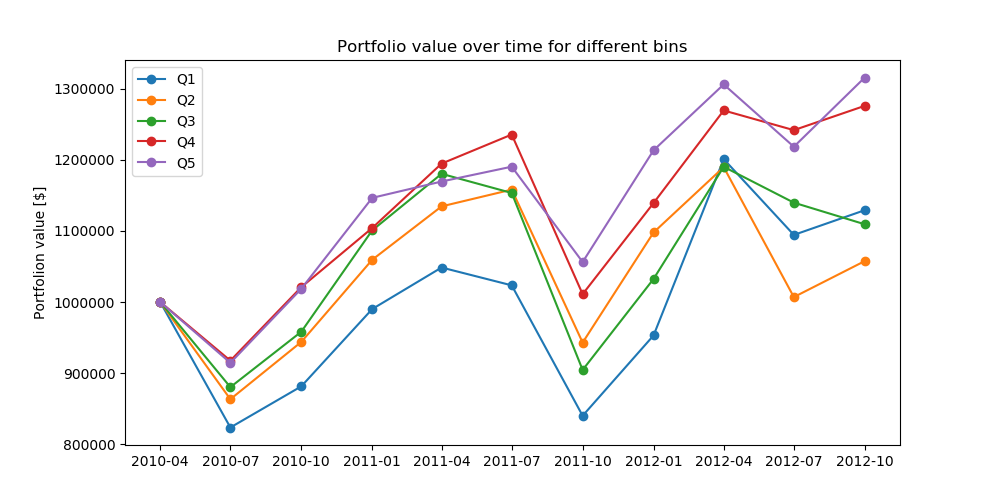

Text(0, 0.5, 'Portfolion value [$]')

In [60]:
plt.figure(figsize=(10, 5))
for l in s['bin_labels']:
    x = []
    y = []
    for qtr in s['list_qtr'][1:]:
        start = "{}{}{}".format(str(qtr[0]), str(((qtr[1])-1)*3+1).zfill(2), '01')
        x.append(datetime.strptime(start, '%Y%m%d').date())
        valuation = pf_values['diff_cosine_tf'][l][qtr][0]
        y.append(valuation)
        
    plt.plot_date(x, y, label=l, linestyle='-')

plt.legend()
plt.title('Portfolio value over time for different bins')
plt.ylabel('Portfolion value [$]')

<IPython.core.display.Javascript object>


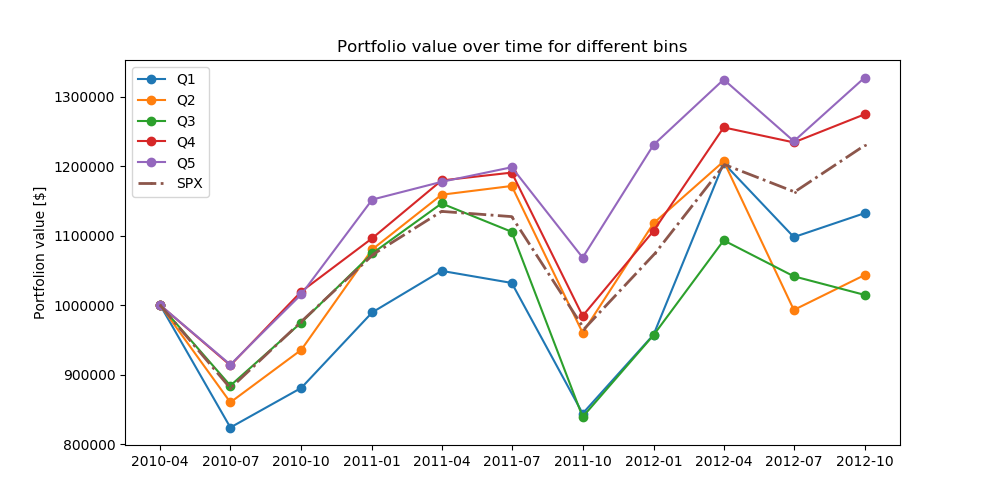

Text(0, 0.5, 'Portfolion value [$]')

In [78]:
plt.figure(figsize=(10, 5))
for l in s['bin_labels']:
    x = []
    y = []
    for qtr in s['list_qtr'][1:]:
        start = "{}{}{}".format(str(qtr[0]), str(((qtr[1])-1)*3+1).zfill(2), '01')
        x.append(datetime.strptime(start, '%Y%m%d').date())
        y.append(pf_values['diff_cosine_tf_idf'][l][qtr][0])
    plt.plot_date(x, y, label=l, linestyle='-')

# Overlay an index
#start_date = qtrs.qtr_to_day(s['list_qtr'][s['lag']], 'first', date_format='datetime')
#end_date = qtrs.qtr_to_day(s['list_qtr'][-1], 'last', date_format='datetime')
index_name = 'SPX'
benchmark_x = []
benchmark_y = []
for qtr in s['list_qtr'][1:]:
    qtr_start_date = "{}{}{}".format(str(qtr[0]), str((qtr[1]-1)*3+1).zfill(2), '01')
    qtr_start_date = datetime.strptime(qtr_start_date, '%Y%m%d').date()
    days, _ = zip(*index_data[index_name])
    for _ in range(7):
        try:
            idx = days.index(qtr_start_date)
            break
        except:  # Increment the day number until it goes through
            qtr_start_date = qtr_start_date.strftime('%Y%m%d')
            day = str(int(qtr_start_date[7]) + 1)
            qtr_start_date = qtr_start_date[:7] + day
            qtr_start_date = datetime.strptime(qtr_start_date, '%Y%m%d').date()
    benchmark_x.append(qtr_start_date)
    benchmark_y.append(index_data[index_name][idx][1])

benchmark_y = np.array(benchmark_y)
benchmark_y *= s['pf_init_value']/benchmark_y[0]
plt.plot_date(benchmark_x, benchmark_y, label=index_name, linestyle='-.', linewidth=2, ms=1)
plt.legend()
plt.title('Portfolio value over time for different bins')
plt.ylabel('Portfolion value [$]')

In [ ]:
for qtr in s['list_qtr'][1:]:
    print(qtr, pf_values['diff_jaccard']['Q5'][qtr][0])

In [62]:
test_qtr_data = master_dict['diff_jaccard'][(2010, 2)]

In [63]:
# [DEBUG] Show the Apple data for that time period
extracted_cik_scores = cik_scores[data_to_process[0][0]]
extracted_cik_scores

{(2010, 2): {'diff_jaccard': 0.002569013736546592,
  'diff_cosine_tf': 0.04374709200418036,
  'diff_cosine_tf_idf': 0.02591280013721771,
  'diff_minEdit': 0.7750273082952261,
  'diff_simple': 0.23418829066975966,
  'sing_LoughranMcDonald': -0.0016647563700913082,
  '0': {'type': '10-Q',
   'published': datetime.date(2010, 5, 3),
   'qtr': (2010, 2)}},
 (2010, 3): {'diff_jaccard': 0.849773016926045,
  'diff_cosine_tf': 0.991424873394707,
  'diff_cosine_tf_idf': 0.9897739952229097,
  'diff_minEdit': 1.0,
  'diff_simple': 1.0,
  'sing_LoughranMcDonald': -0.001411784041286702,
  '0': {'type': '10-Q',
   'published': datetime.date(2010, 8, 6),
   'qtr': (2010, 3)}},
 (2010, 4): {'diff_jaccard': 0.8165114586808954,
  'diff_cosine_tf': 0.9931562811226052,
  'diff_cosine_tf_idf': 0.9899288855527351,
  'diff_minEdit': 0.9001069249209981,
  'diff_simple': 0.9384658657513348,
  'sing_LoughranMcDonald': -0.0014076586028811098,
  '0': {'type': '10-Q',
   'published': datetime.date(2010, 11, 5),
   

In [65]:
#ticker = lookup[320193]
ticker = lookup[data_to_process[0][0]]
start_date = qtrs.qtr_to_day(s['time_range'][0], 'first', date_format='datetime')
stop_date = qtrs.qtr_to_day(s['time_range'][1], 'last', date_format='datetime')

#print(s['time_range'], start_date)
#print(s['time_range'], stop_date)
extracted_stock_data = {k: v for k, v in stock_data[ticker].items() if start_date <= k <= stop_date}
#print(extracted_data)


# Display the data

## For a given ticker

### Metrics vs stock price

<IPython.core.display.Javascript object>


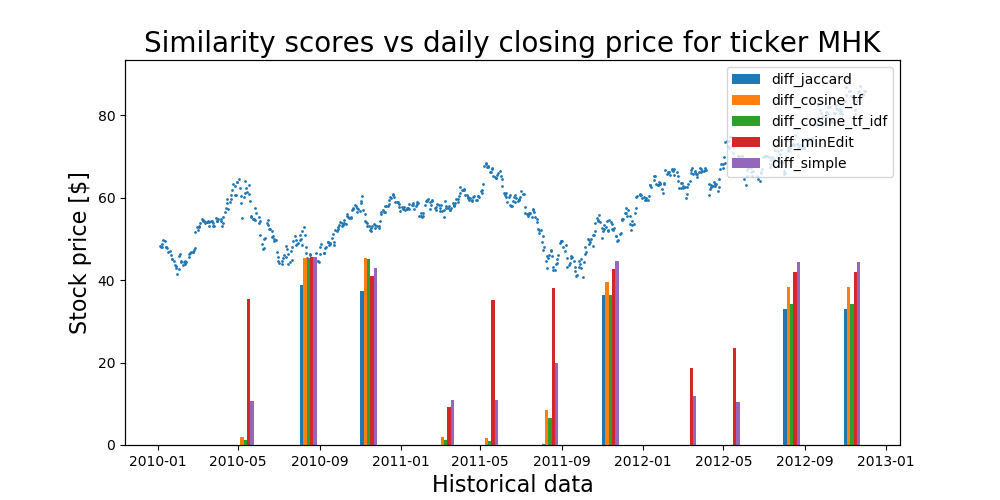

[INFO] Publication dates: 2010-05-03
[INFO] Publication dates: 2010-08-06
[INFO] Publication dates: 2010-11-05
[INFO] Publication dates: 2011-03-01
[INFO] Publication dates: 2011-05-06
[INFO] Publication dates: 2011-08-05
[INFO] Publication dates: 2011-11-04
[INFO] Publication dates: 2012-02-29
[INFO] Publication dates: 2012-05-04
[INFO] Publication dates: 2012-08-03
[INFO] Publication dates: 2012-11-02


In [66]:
display.diff_vs_stock(extracted_cik_scores, extracted_stock_data, ticker, s, method='diff')

### Sentiment vs stock price

<IPython.core.display.Javascript object>


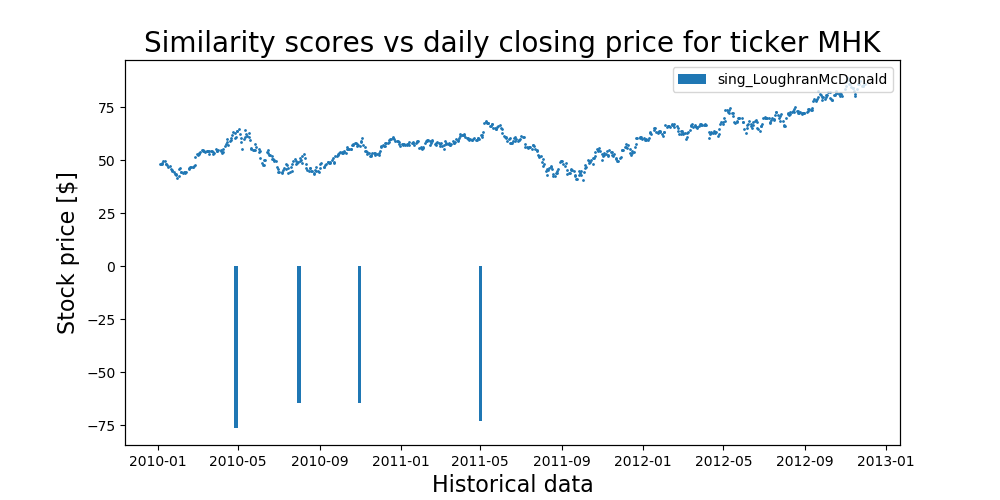

[INFO] Publication dates: 2010-05-03
[INFO] Publication dates: 2010-08-06
[INFO] Publication dates: 2010-11-05
[INFO] Publication dates: 2011-03-01
[INFO] Publication dates: 2011-05-06
[INFO] Publication dates: 2011-08-05
[INFO] Publication dates: 2011-11-04
[INFO] Publication dates: 2012-02-29
[INFO] Publication dates: 2012-05-04
[INFO] Publication dates: 2012-08-03
[INFO] Publication dates: 2012-11-02


In [67]:
display.diff_vs_stock(extracted_cik_scores, extracted_stock_data, ticker, s, method='sentiment')